# Subtask №3 | Test Task PA
_Pavlo Kukurik_

In [1]:
# Importing libs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import color_palette

In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (30, 10)

### Reading Files

In [3]:
df = pd.read_csv('data/reading_data.csv')

In [4]:
summary_df = pd.read_csv('data/summary_info.csv')

### Short Data Overview

In [5]:
summary_df['topic'].value_counts()

topic
Self-Reflection       99
Daily Optimization    96
Entrepreneurship      95
Team Dynamics         93
Mindfulness           84
                      ..
Survival               8
Natural World          8
Decision-Making        8
Personal Stories       8
Intimacy               8
Name: count, Length: 166, dtype: int64

In [6]:
# df['user_id'].value_counts()

In [7]:
# df.isna().sum()

In [8]:
# summary_df.isna().sum()

In [9]:
# df[df["event_properties_book_id"].str.match(r"^[a-zA-Z0-9]{20}$", na=False)]
df[~df["event_properties_book_id"].str.match(r"^[a-zA-Z0-9]{20}$", na=False)]

Unnamed: 0   user_id           event_time         country  \
1837          1837  8ZZS3ZSS  2024-06-28 12:37:57         Germany   
2344          2344  UJE53I3Y  2024-06-29 23:40:12  United Kingdom   
10088        10088  9RZTJZ6T  2024-06-29 07:43:55       Australia   
13499        13499  T3WJI567  2024-06-21 19:01:58   United States   
16309        16309  GHYKKHWN  2024-06-30 14:14:19           Chile   
...            ...       ...                  ...             ...   
512958      512958  Z1FEOYHY  2024-06-26 23:51:35   United States   
517150      517150  L50FTHVJ  2024-06-29 17:23:48    South Africa   
518930      518930  OO9G4ZS1  2024-06-27 13:26:33   United States   
521291      521291  FVJ4MRIG  2024-06-26 22:04:31     Netherlands   
523096      523096  RB92TRNL  2024-06-28 01:32:25          Mexico   

               event_type              event_properties_book_id  \
1837    summary_last_page  b8987b7f-bff6-4cd1-953a-d952c33e9940   
2344    summary_last_page  b8987b7f-bff6-4cd1-953a-d952c33e9940   
10088       summary_start  9363ef58-bf72-4a32-b32c-39ff0540c3b8   
13499   summary_last_page  a254a694-2e66-4854-b8b6-85a735c95613   
16309       summary_start  8bb282f0-b6be-42e7-a741-c21cff2c9cbd   
...                   ...                                   ...   
512958  summary_last_page  b8987b7f-bff6-4cd1-953a-d952c33e9940   
517150  summary_last_page  8bb282f0-b6be-42e7-a741-c21cff2c9cbd   
518930  summary_last_page  b8987b7f-bff6-4cd1-953a-d952c33e9940   
521291      summary_start  b8987b7f-bff6-4cd1-953a-d952c33e9940   
523096      summary_start  b8987b7f-bff6-4cd1-953a-d952c33e9940   

       event_properties_format user_properties_age  
1837                     audio                  21  
2344                     audio                  59  
10088                    audio                  20  
13499                     text                  22  
16309                    audio               error  
...                        ...                 ...  
512958                   audio                  33  
517150                    text                  47  
518930                   audio                  32  
521291                   audio                  52  
523096                   audio                  31  

[214 rows x 8 columns]

After 2024-06-15 07:57:05, atypical values such as `a254a694-2e66-4854-b8b6-85a735c95613' began to appear in the data in the` `event_properties_book_id` column, relative to the usual `WUOlTHMd11KUsvKSMhPx`. But upon closer inspection, it seems to be completely `“clean”` data

### Cleaning the data and unite the datasets


In [10]:
df = df[df["user_id"] != "INVALID"]
df= df[df["user_id"].str.match(r"^[A-Za-z0-9]+$", na=False)]

# df['user_id'].value_counts()

In [11]:
df.loc[:, "user_properties_age"] = pd.to_numeric(df["user_properties_age"], errors='coerce')
df = df[df["user_properties_age"].notna()]

In [12]:
users_with_multiple_books = (
    df.groupby(["user_id", "event_time"])["event_properties_book_id"]
    .nunique()
    .reset_index()
)

users_with_multiple_books = users_with_multiple_books[users_with_multiple_books["event_properties_book_id"] > 1]
multiple_books_df = df.merge(users_with_multiple_books[["user_id", "event_time"]], on=["user_id", "event_time"])

# multiple_books_df

In [13]:
# Drop sers who read different books at the same time
users_to_remove = users_with_multiple_books["user_id"].unique()
df = df[~df["user_id"].isin(users_to_remove)]

In [14]:
# Drop duplicates (when same user make several events at the same time: 155 cases)
df = df.drop_duplicates(subset=["user_id", "event_time"], keep="first").copy()
# df

Users who were reading summaries at the same time were removed from the dataset. In one case, these are just duplicates that can be explained by a technical failure, and in the other case, these are users who were reading different books at the same time. This can also be a technical failure in recording data, but it can also indicate that several people are using the same account. In this case, it is neither rational nor representative to consider such users in further analysis. In addition, it may be a sign that the user's account has been hacked or that the user has voluntarily shared their account. In both cases, this may be a reason to notify the user and block the account (in the first case to protect the user from fraudsters, in the second case to find out the details if, for example, such behavior contradicts the user's rules)

In [15]:
summary_df = summary_df.drop_duplicates(subset="book_id", keep="first").copy()

merged_df = df.merge(summary_df, left_on="event_properties_book_id", right_on="book_id", how="left")
merged_df["topic"] = merged_df["topic"].fillna("Unknown")
merged_df = merged_df.drop(columns=["book_id"])

### Functions

In [16]:
def age_distribution(df_name: pd.DataFrame, unique=False) -> plt.Figure():
    """
    This function plots the age distribution by users id.
    :param unique:
    :param df_name:
    :return:
    """

    if unique:
        sns.histplot(df_name.drop_duplicates(subset="user_id")["user_properties_age"], bins=50, color='crimson')
        plt.xlabel("Вік користувача")
        plt.ylabel("Кількість унікальних користувачів")
        plt.title("Розподіл віку унікальних користувачів")
        plt.show()

    else:
        sns.histplot(df_name["user_properties_age"],bins=50, color='crimson')
        plt.xlabel("Вік користувача")
        plt.ylabel("Кількість читачів")
        plt.title("Розподіл віку користувачів (Активнсть користувачів за віком)")
        plt.show()

In [17]:
def age_distribution_separately(df_1: pd.DataFrame, df_2: pd.DataFrame, df_3: pd.DataFrame, unique=False) -> plt.Figure():
    """
    This function plots the age distribution by users id
    :param df_1: DataFrame 1 with whole data
    :param df_2: DataFrame 2 with users who don`t change age
    :param df_3: DataFrame 3 with users who change age
    :param unique:
    :return:
    """
    if unique:
        sns.histplot(df_1.drop_duplicates(subset="user_id")["user_properties_age"], bins=50, color="orange", label="Загалом")
        sns.histplot(df_2.drop_duplicates(subset="user_id")["user_properties_age"], bins=50, color="crimson", label="Не змінили вік")
        sns.histplot(df_3.drop_duplicates(subset="user_id")["user_properties_age"], bins=50, color="seagreen", label="Змінювали вік", alpha=1)
        plt.legend()
        plt.title('Розподіл користувачі за віком')
        plt.show()

    else:
        sns.histplot(df_1["user_properties_age"], bins=50, color="orange", label="Загалом")
        sns.histplot(df_3["user_properties_age"], bins=50, color="seagreen", label="Змінювали вік")
        sns.histplot(df_2["user_properties_age"], bins=50, color="crimson", label="Не змінили вік", alpha=1)
        plt.legend()
        plt.title('Активність користувачів за віком')
        plt.show()

In [18]:
def plot_event_distributions(df_name: pd.DataFrame) -> plt.Figure():

    type_event = df_name['event_type'].value_counts()
    event_format = df_name['event_properties_format'].value_counts()

    sns.set_palette("Reds")

    fig, axes = plt.subplots(1, 2, figsize=(25, 15))

    axes[0].pie(type_event, labels=type_event.index, autopct="%1.1f%%", startangle=180, colors=sns.color_palette("Reds", len(type_event)))
    axes[0].set_title("Distribution of Event Type")

    axes[1].pie(event_format, labels=event_format.index, autopct="%1.1f%%", startangle=180, colors=sns.color_palette("Reds", len(event_format)))
    axes[1].set_title("Distribution of Event Format")

    plt.tight_layout()
    plt.show()

In [19]:
def plot_country_activity(df_name: pd.DataFrame) -> plt.Figure():
    """
    The func visualise the distribution of counties by user
    :param df_name: The dataframe`s name
    :return: show the distribution of counties by user
    """
    top_countries = df_name["country"].value_counts().head(10)
    unique_users_per_country = df_name.groupby("country")["user_id"].nunique().nlargest(10)

    sns.set_palette("Reds")
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))

    sns.barplot(x=top_countries.index, y=top_countries.values, ax=axes[0], palette="Reds")
    axes[0].set_title("Top 10 Active Countries by Total Events")
    axes[0].set_ylabel("Total Events")
    axes[0].set_xlabel("Country")
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=unique_users_per_country.index, y=unique_users_per_country.values, ax=axes[1], palette="Reds")
    axes[1].set_title("Top 10 Countries by Unique Users")
    axes[1].set_ylabel("Unique Users")
    axes[1].set_xlabel("Country")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [20]:
def plot_topic_distribution(df_name: pd.DataFrame)-> plt.Figure():
    topic_counts = df_name.groupby("topic").agg(
        total_events=("event_time", "count"),
        unique_users=("user_id", "nunique")
    ).sort_values(by="total_events", ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(30, 10))

    sns.barplot(x=topic_counts.index[:10], y=topic_counts["total_events"][:10], ax=axes[0], palette="Reds")
    axes[0].set_title("Топ-10 тем за активністю")
    axes[0].set_xlabel("Тематика")
    axes[0].set_ylabel("Кількість подій")
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=topic_counts.index[:10], y=topic_counts["unique_users"][:10], ax=axes[1], palette="Reds")
    axes[1].set_title("Топ-10 тем за унікальними користувачами")
    axes[1].set_xlabel("Тематика")
    axes[1].set_ylabel("Кількість унікальних користувачів")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [21]:
def topic_number_by_user(df_name: pd.DataFrame, n=20) -> plt.Figure():
    """
    The func visualise number of topics by users
    :param df_name: name of dataframe
    :param n: limit of topic on x
    :return:
    """
    user_topic_counts = df_name.groupby("user_id")["topic"].nunique()

    plt.figure(figsize=(25, 15))
    sns.histplot(user_topic_counts, bins=126)
    plt.title("Кількість тем, які читає один користувач")
    plt.xlabel("Кількість унікальних тем")
    plt.ylabel("Кількість користувачів")
    plt.xlim(0, n)
    plt.xticks(range(n+1))

    plt.show()

In [22]:
def analyze_book_completion(df_name: pd.DataFrame) -> plt.Figure():
    """
    Analyze book completion rates based on user activity.
    :param df_name: DataFrame containing user interactions with books.
    :return: Prints summary statistics and displays a visualization.
    """

    completion_rates = df_name.groupby(["user_id", "event_properties_book_id"])["event_type"].nunique()
    fully_tracked_books = completion_rates[completion_rates == 2].count()
    total_started_books = (df_name["event_type"] == "summary_start").sum()
    completion_rate = fully_tracked_books / total_started_books if total_started_books > 0 else 0

    started_books = set(zip(
        df_name.loc[df_name["event_type"] == "summary_start", "user_id"],
        df_name.loc[df_name["event_type"] == "summary_start", "event_properties_book_id"]
    ))

    last_page_only = df_name[
        (df_name["event_type"] == "summary_last_page") &
        (~df_name[["user_id", "event_properties_book_id"]].apply(tuple, axis=1).isin(started_books))
    ]


    users_with_only_last_page = set(df_name.loc[df_name["event_type"] == "summary_last_page", "user_id"]) - \
                                set(df_name.loc[df_name["event_type"] == "summary_start", "user_id"])

    print(f"Unique user-book pairs: {completion_rates.shape[0]}")
    print(f"Books fully tracked (started and completed): {fully_tracked_books}")
    print(f"Total books started: {total_started_books}")
    print(f"Estimated completion rate: {completion_rate:.2%}")
    print(f"Records with 'summary_last_page' but no 'summary_start': {last_page_only.shape[0]}")
    print(f"Unique users with only 'summary_last_page': {len(users_with_only_last_page)}")

    plt.figure(figsize=(30, 10))
    df_name["event_time"] = pd.to_datetime(df_name["event_time"])
    df_name[df_name["event_type"] == "summary_start"]["event_time"].hist(bins=50, alpha=1, label="summary_start", color='orange')
    last_page_only["event_time"].hist(bins=50, alpha=1, label="summary_last_page only", color='crimson')
    plt.xlabel("Event Time")
    plt.ylabel("Count")
    plt.title("Distribution of 'summary_last_page' without 'summary_start'")
    plt.legend()
    plt.show()

In [23]:
def plot_user_activity(df_name: pd.DataFrame) -> None:
    """
    The function visualizes daily user activity with a rolling average.

    :param df_name: The DataFrame containing 'event_time' and 'daily_reads' columns.
    :return: None, displays the user activity plot.
    """
    df_name["rolling_avg"] = df_name["daily_reads"].rolling(window=7).mean()

    mean_reads = df_name["daily_reads"].mean()
    std_reads = df_name["daily_reads"].std()

    plt.figure(figsize=(30, 10))
    sns.scatterplot(x=df_name["event_time"], y=df_name["daily_reads"], alpha=0.5, color='royalblue', label="Daily Reads")
    sns.lineplot(x=df_name["event_time"], y=df_name["rolling_avg"], color="darkred", linewidth=3, label="7-Day Rolling Average")

    plt.axhline(mean_reads + 3 * std_reads, color="seagreen", linestyle="dashed", label="Anomaly Threshold (3σ)")
    plt.xlabel("Date")
    plt.ylabel("Number of Summaries Read per Day")
    plt.title("Daily User Activity with Rolling Average")
    plt.legend()
    plt.show()

In [24]:
def plot_time_diff_by_hour(df_name: pd.DataFrame) -> None:
    """
    The function visualizes the distribution of reading time differences by the hour of the day.

    :param df_name: The DataFrame containing 'event_time' and 'user_id' columns.
    :return: None, displays a boxplot of time differences.
    """
    df_copy_ = df_name.copy()
    df_copy_["event_time"] = pd.to_datetime(df_copy_["event_time"], errors="coerce")
    df_copy_["hour"] = df_copy_["event_time"].dt.hour
    df_copy_["time_diff"] = df_copy_.groupby("user_id")["event_time"].diff().dt.total_seconds() / 3600

    plt.figure(figsize=(15, 8))
    sns.boxplot(x=df_copy_["hour"], y=df_copy_["time_diff"], color="crimson")
    plt.ylim(0, df_copy_["time_diff"].quantile(0.95))
    plt.xlabel("Hour of the Day")
    plt.ylabel("Time Between Readings (Hours)")
    plt.title("Distribution of Time Between Readings by Hour")
    plt.show()

In [25]:
def plot_time_diff_distribution(df_name: pd.DataFrame) -> None:
    """
    The function visualizes the overall distribution of time differences between readings.

    :param df_name: The DataFrame containing 'event_time' and 'user_id' columns.
    :return: None, displays a histogram of time differences.
    """
    df_copy_ = df_name.copy()
    df_copy_["event_time"] = pd.to_datetime(df_copy_["event_time"], errors="coerce")
    df_copy_["time_diff"] = df_copy_.groupby("user_id")["event_time"].diff().dt.total_seconds() / 3600
    df_copy_ = df_copy_[df_copy_["time_diff"] > 0]

    plt.figure(figsize=(40, 15))
    sns.histplot(df_copy_["time_diff"], kde=True, color="crimson")
    plt.xlabel("Time Between Readings (Hours)")
    plt.ylabel("Number of Occurrences")
    plt.title("Distribution of Time Between Readings")
    plt.show()

In [26]:
def prepare_user_reading_data(df_name: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    The function processes event data to calculate time differences between readings
    and daily reading activity per user.
    :param df_name: The DataFrame containing 'user_id', 'event_time', and 'event_properties_book_id'.
    :return: A tuple containing:
        - df_copy: The processed DataFrame with 'time_diff' calculated.
        - user_daily_reads: A DataFrame with daily reading counts and outlier detection.
    """
    df_copy_ = df_name.copy()
    df_copy_["event_time"] = pd.to_datetime(df_copy_["event_time"], errors="coerce")
    df_copy_ = df_copy_.sort_values(by=["user_id", "event_time"])
    df_copy_["prev_event_time"] = df_copy_.groupby("user_id")["event_time"].shift(1)
    df_copy_["time_diff"] = (df_copy_["event_time"] - df_copy_["prev_event_time"]).dt.total_seconds() / 3600

    user_daily_reads_ = df_copy_.groupby(["user_id", df_copy_["event_time"].dt.date])["event_properties_book_id"].count().reset_index()
    user_daily_reads_.rename(columns={"event_properties_book_id": "daily_reads"}, inplace=True)

    mean_reads = user_daily_reads_["daily_reads"].mean()
    std_reads = user_daily_reads_["daily_reads"].std()
    user_daily_reads_["z_score"] = (user_daily_reads_["daily_reads"] - mean_reads) / std_reads

    return df_copy_, user_daily_reads_

In [27]:
def event_per_week(df_name: pd.DataFrame) -> plt.Figure():
    df_name["event_time"] = pd.to_datetime(df_name["event_time"])
    event_counts_weekly = df_name["event_time"].dt.to_period("W").value_counts().sort_index()

    plt.figure(figsize=(30, 10))
    plt.plot(event_counts_weekly.index.astype(str), event_counts_weekly.values, marker="o", linestyle="-",
             color="crimson")
    plt.xlabel("Week")
    plt.ylabel("Number of Events")
    plt.title("Event Distribution Per Week")
    plt.xticks(rotation=45)
    plt.show()

In [28]:
def event_per_day(df_name: pd.DataFrame) -> plt.Figure():
    df_name["event_time"] = pd.to_datetime(df_name["event_time"])
    event_counts_weekly = df_name["event_time"].dt.to_period("D").value_counts().sort_index()

    plt.figure(figsize=(30, 10))
    plt.plot(event_counts_weekly.index.astype(str), event_counts_weekly.values, marker="o", linestyle="-",
             color="crimson")
    plt.xlabel("Week")
    plt.ylabel("Number of Events")
    plt.title("Event Distribution Per Week")
    plt.xticks(rotation=45)
    plt.show()

In [29]:
def plot_event_distribution_by_hour(df_name: pd.DataFrame) -> None:
    """
    The function visualizes the distribution of events by the hour of the day.

    :param df_name: The DataFrame containing an 'event_time' column.
    :return: None (displays the plot).
    """
    df_name["event_time"] = pd.to_datetime(df_name["event_time"], errors="coerce")
    event_counts_hourly = df_name["event_time"].dt.hour.value_counts().sort_index()

    plt.figure(figsize=(30, 10))
    plt.plot(event_counts_hourly.index, event_counts_hourly.values, marker="o", linestyle="-", color="crimson")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Events")
    plt.title("Event Distribution by Hour")
    plt.xticks(range(24))
    plt.show()

In [30]:
def hour_activity_by_country(df_name: pd.DataFrame, top_n: int = 5) -> None:
    """
    Visualizes the distribution of events by the hour of the day for the top N countries.
    :param df_name: name of dataset
    :param top_n: The number of top countries to include in the visualization (default is 5).
    :return: None (displays the plot).
    """
    df_copi = df_name.copy()
    df_copi["event_time"] = pd.to_datetime(df_copi["event_time"], errors="coerce")
    df_copi["hour"] = df_copi["event_time"].dt.hour

    top_countries = df_copi["country"].value_counts().head(top_n).index

    plt.figure(figsize=(30, 10))
    palette = sns.color_palette("husl", n_colors=len(top_countries))

    for i, country in enumerate(top_countries):
        country_data = df_copi[df_copi["country"] == country]
        sns.kdeplot(country_data["hour"], label=country, color=palette[i], linewidth=2)

    plt.xlabel("Hour of the Day", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Event Distribution by Hour for Top {top_n} Countries", fontsize=14)
    plt.xticks(range(24))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Country", fontsize=10)
    plt.show()

In [31]:
def analyze_activity_drop(df_name: pd.DataFrame) -> plt.Figure():
    df_name["week"] = df_name["event_time"].dt.to_period("W")

    weekly_events = df_name.groupby("week").size()
    min_week, max_week = weekly_events.idxmin(), weekly_events.idxmax()

    plt.figure(figsize=(30, 10))
    plt.plot(weekly_events.index.astype(str), weekly_events.values, marker="o", linestyle="-", color="crimson")
    plt.axvline(x=str(min_week), color="blue", linestyle="--", label="Мін. активність")
    plt.axvline(x=str(max_week), color="green", linestyle="--", label="Макс. активність")
    plt.xlabel("Тиждень")
    plt.ylabel("Кількість подій")
    plt.title("Розподіл подій по тижнях")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    df_name["cohort"] = df_name.groupby("user_id")["event_time"].transform("min").dt.to_period("W")
    cohort_activity = df_name.groupby(["cohort", df_name["event_time"].dt.to_period("W")])["user_id"].nunique().unstack()
    cohort_activity.fillna(0, inplace=True)

    plt.figure(figsize=(15, 10))
    sns.heatmap(cohort_activity, cmap="coolwarm", annot=True, fmt=".0f")
    plt.xlabel("Тиждень активності")
    plt.ylabel("Когорта")
    plt.title("Когортний аналіз активності користувачів")
    plt.show()

In [32]:
def calculate_churn_and_retention(df_name: pd.DataFrame):
    cohort_size = df_name.groupby("cohort")["user_id"].nunique()
    retention_table = df_name.groupby(["cohort", df_name["event_time"].dt.to_period("W")])["user_id"].nunique().unstack().divide(cohort_size, axis=0)

    churn_rate = 1 - retention_table
    avg_retention = retention_table.mean(axis=0)
    avg_churn = churn_rate.mean(axis=0)

    plt.figure(figsize=(30, 10))
    plt.plot(avg_retention.index.astype(str), avg_retention.values, marker="o", label="Retention Rate", color="orange")
    plt.plot(avg_churn.index.astype(str), avg_churn.values, marker="o", label="Churn Rate", color="crimson")
    plt.xlabel("Тиждень")
    plt.ylabel("Rate")
    plt.title("Retention & Churn Rate")
    plt.legend()
    plt.show()

In [33]:
def filter_incomplete_users(df_name):
    started_books = set(zip(
        df_name.loc[df_name["event_type"] == "summary_start", "user_id"],
        df_name.loc[df_name["event_type"] == "summary_start", "event_properties_book_id"]
    ))

    last_page_only = df_name[
        (df_name["event_type"] == "summary_last_page") &
        (~df_name[["user_id", "event_properties_book_id"]].apply(tuple, axis=1).isin(started_books))
    ]

    users_with_only_last_page = set(last_page_only["user_id"])

    df_filtered = df_name[~df_name["user_id"].isin(users_with_only_last_page)]

    return df_filtered

In [34]:
def acquisition_analysis(df_name):

    df_name["cohort"] = df_name.groupby("user_id")["event_time"].transform("min").dt.to_period("W")

    acquisition = df_name["cohort"].value_counts().sort_index()

    plt.figure(figsize=(30, 10))
    plt.bar(acquisition.index.astype(str), acquisition.values, color="seagreen", alpha=0.7)
    plt.xlabel("Тиждень")
    plt.ylabel("Кількість нових користувачів")
    plt.title("Притік користувачів по тижнях")
    plt.xticks(rotation=45)
    plt.show()

In [35]:
def sesonal_prepare(df_name: pd.DataFrame):
    """
    Prepare data to seasonal analysis
    :param df_name:
    :return:
    """
    df_name['event_time'] = pd.to_datetime(df_name['event_time'])
    df_name['day_of_week'] = df_name['event_time'].dt.day_name()
    df_name['hour'] = df_name['event_time'].dt.hour

    return df_name

In [36]:
def plot_activity_by_format(df_name: pd.DataFrame):
    format_activity = df_name.groupby(['event_properties_format', 'day_of_week']).size().reset_index(name='counts')
    sns.barplot(x='day_of_week', y='counts', hue='event_properties_format', data=format_activity)
    plt.title('Activity by Format (audio/text) and Day of the Week')
    plt.show()

In [37]:
def plot_topic_popularity(df_name: pd.DataFrame):
    top_topics = df_name['topic'].value_counts().nlargest(5).index.tolist()
    df_top_topics = df_name[df_name['topic'].isin(top_topics)]

    topic_activity = df_top_topics.groupby(['topic', 'day_of_week']).size().reset_index(name='counts')
    sns.barplot(x='day_of_week', y='counts', hue='topic', data=topic_activity)
    plt.title('Top 5 Topics Popularity Across Days of the Week')
    plt.show()

In [38]:
def plot_peak_hours(df_name: pd.DataFrame):
    hour_activity = df_name.groupby(['day_of_week', 'hour']).size().reset_index(name='counts')
    sns.lineplot(data=hour_activity, x='hour', y='counts', hue='day_of_week')
    plt.title('Most Active Hours Across Days of the Week')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Activity Count')
    plt.show()

In [94]:
def calculate_stickiness_ratio(df_name: pd.DataFrame) -> float:

    df_name['event_time'] = pd.to_datetime(df_name['event_time'])
    df_name['date'] = df_name['event_time'].dt.date

    daily_active_users = df_name.groupby('date')['user_id'].nunique().mean()
    monthly_active_users = df_name.groupby(df_name['event_time'].dt.to_period('M'))['user_id'].nunique().mean()

    stickiness_ratio = daily_active_users / monthly_active_users if monthly_active_users > 0 else 0
    return round(stickiness_ratio, 2)

### EDA

In [39]:
df_cleaned = merged_df.copy()

In [40]:
print(f"The number of unique users is: {df_cleaned['user_id'].nunique()}. This is the {df_cleaned['user_id'].nunique() / df_cleaned.__len__():.3}% of the data set.")
print('--------------------------------------------------------------------------')
print(f"The number of unique books is: {df_cleaned['event_properties_book_id'].nunique()}")


The number of unique users is: 221650. This is the 0.453% of the data set.
--------------------------------------------------------------------------
The number of unique books is: 1652


In [41]:
user_event_counts = df_cleaned.groupby("user_id")["event_time"].nunique()
single_event_users = user_event_counts[user_event_counts == 1]
total_users = len(user_event_counts)
percentage = len(single_event_users) / total_users * 100

print(f"Number of users with only one unique event: {len(single_event_users)}")
print(f"Percent of such users: {percentage:.2f}% (Between unique users)")

Number of users with only one unique event: 127198
Percent of such users: 57.39% (Between unique users)


#### The plot twist (Spliting th data)

###### Activity of users by age and users age distribution

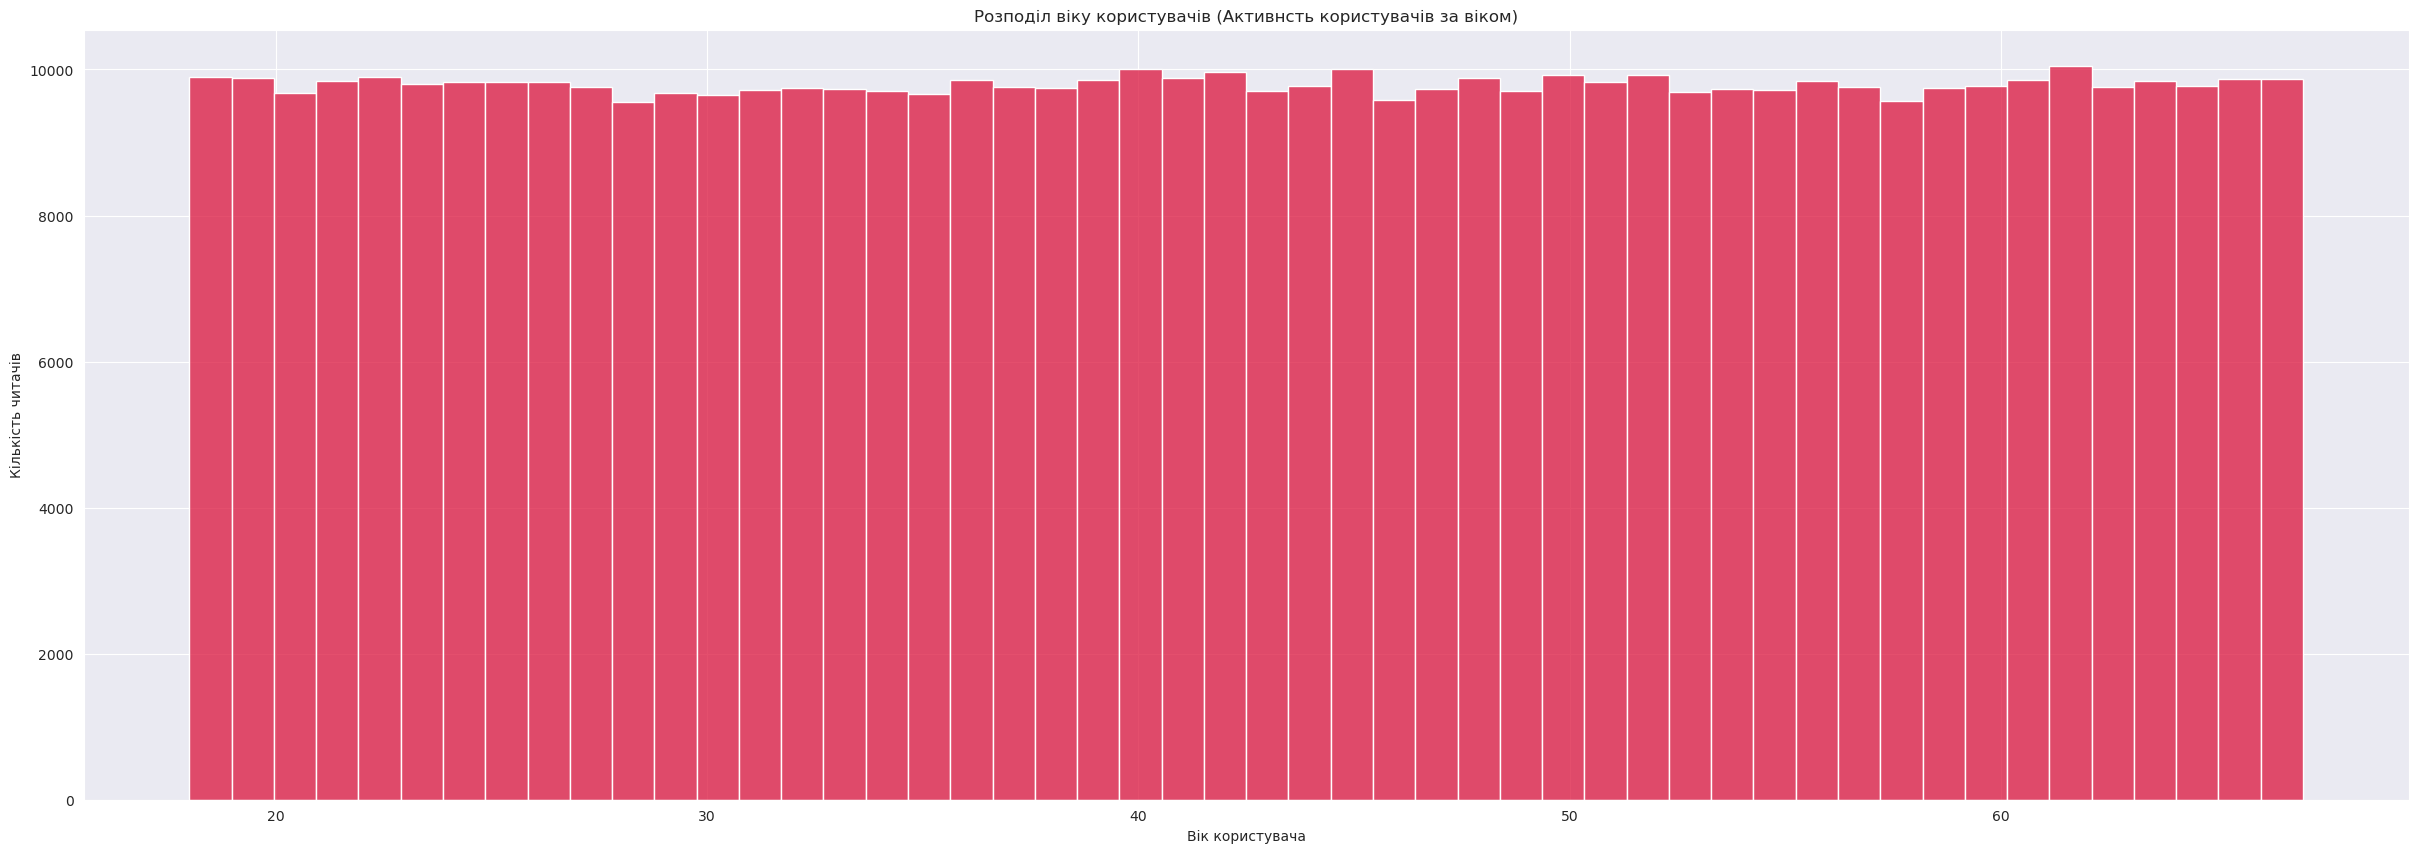

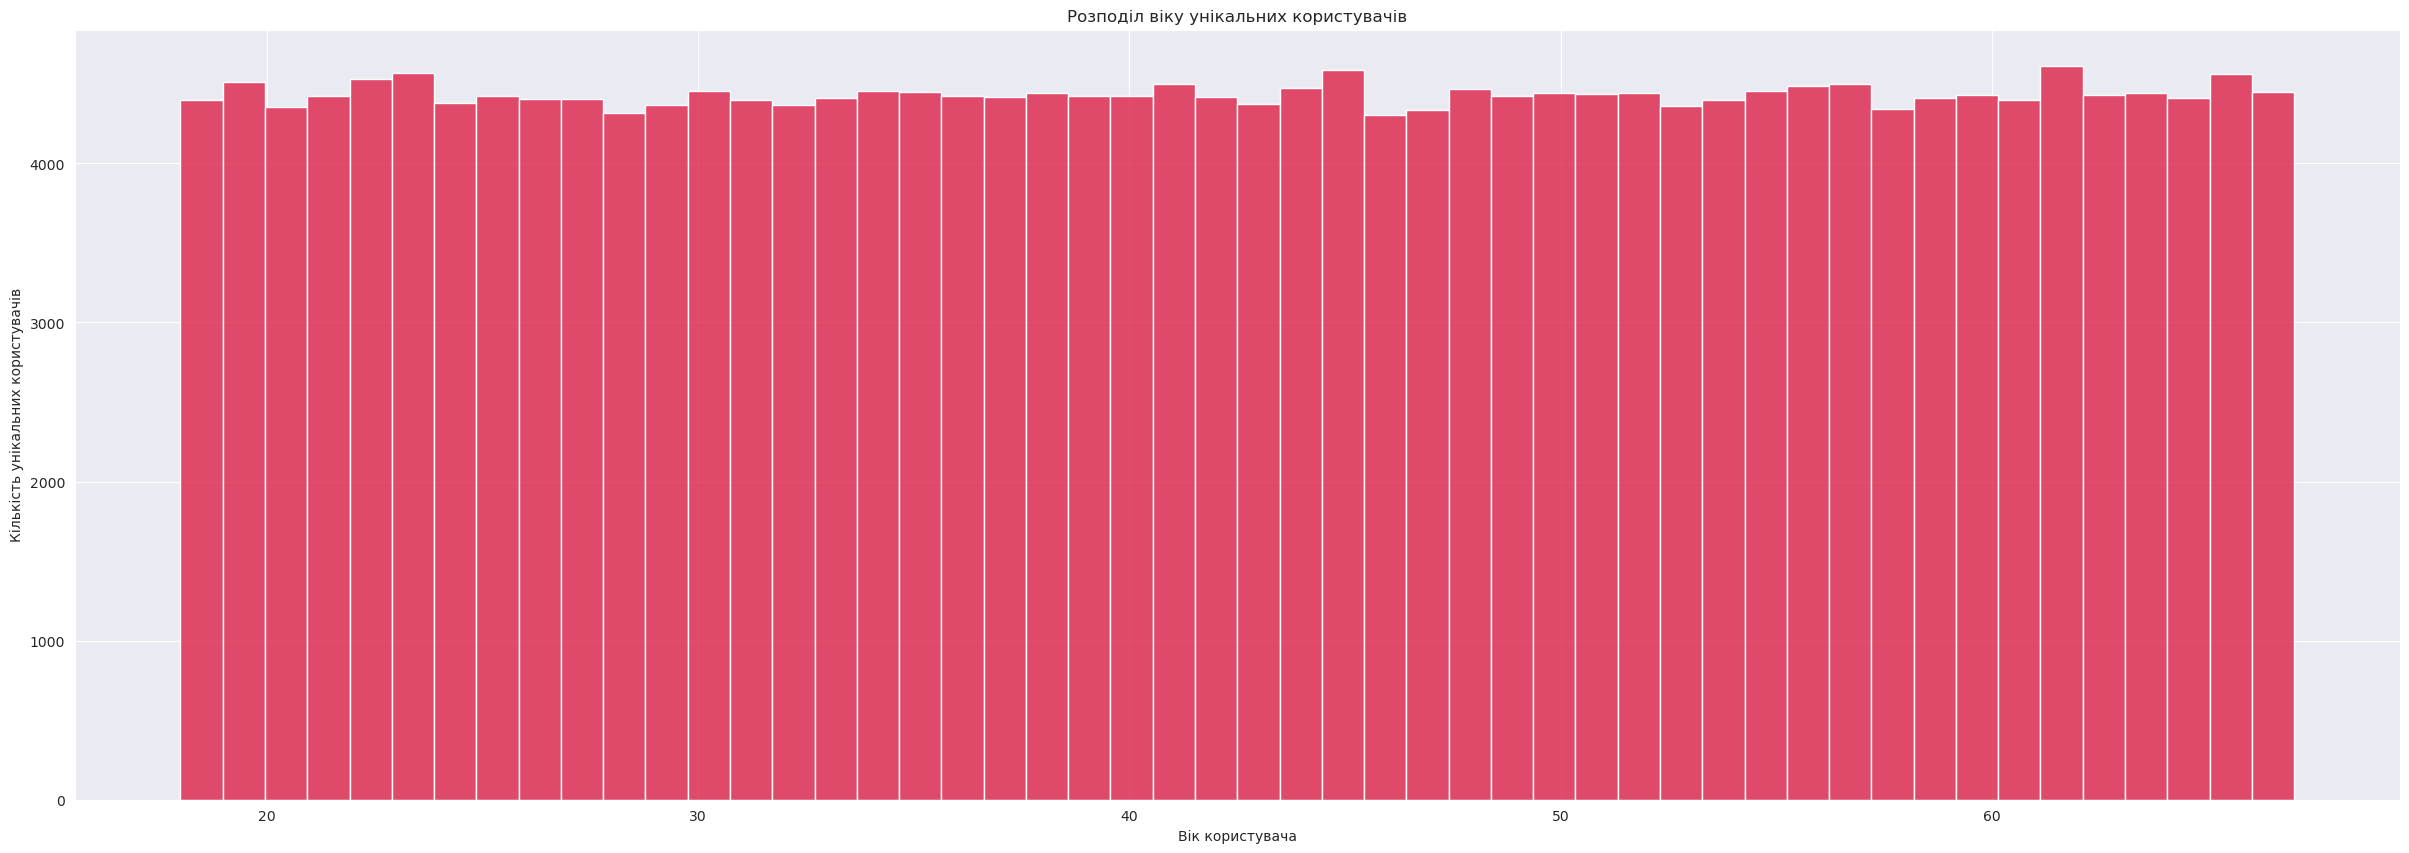

In [42]:
age_distribution(df_cleaned)
age_distribution(df_cleaned, unique=True)

Here we see that the  looks uniform, which is quite surprising. Also some users are changing their age during this time. Let`s look closer


In [43]:
df_copy = df_cleaned.copy()
df_copy["previous_age"] = df_copy.groupby("user_id")["user_properties_age"].shift(1)
users_with_age_changes = df_copy[df_copy["user_properties_age"] != df_copy["previous_age"]].dropna()
users_with_changes_ids = users_with_age_changes["user_id"].unique()
users_with_age_changes = df_copy[df_copy["user_id"].isin(users_with_changes_ids)]
users_without_age_changes = df_copy[~df_copy["user_id"].isin(users_with_changes_ids)]

# users_with_age_changes.drop_duplicates(subset="user_id")
users_with_age_changes

Unnamed: 0   user_id           event_time        country  \
1                1  7XTQHMH8  2024-06-03 21:46:51          Spain   
2                2  2IB2IK8U  2024-05-17 18:47:01  United States   
3                3  O9C6WXJE  2024-06-07 01:18:14  United States   
4                4  4GRWXHNP  2024-05-03 13:16:34      Hong Kong   
6                6  8Z5FY1Q5  2024-06-03 13:09:14  United States   
...            ...       ...                  ...            ...   
489611      523131  KV7XABCL  2024-05-09 02:26:42  United States   
489614      523136  K5SZLO4G  2024-05-13 11:35:55  United States   
489615      523137  AGFW7EES  2024-06-04 05:17:29  United States   
489616      523138  VIXNS5SY  2024-06-03 12:07:17  United States   
489620      523142  OP1A9NVQ  2024-04-05 10:17:31         Norway   

               event_type event_properties_book_id event_properties_format  \
1           summary_start     WUOlTHMd11KUsvKSMhPx                   audio   
2           summary_start     AJfjqmnZfcGYTpDtYhzz                   audio   
3           summary_start     1384d32a0cc5415ba60b                   audio   
4       summary_last_page     1Z9KhNI1CyXJMDXEDdgN                   audio   
6       summary_last_page     pADqpzgc48WYGTGYQLfn                   audio   
...                   ...                      ...                     ...   
489611  summary_last_page     5de53a7711e54ad6881c                   audio   
489614      summary_start     f5a4fb9dfd3e420aaa21                   audio   
489615      summary_start     J6fy6QCxXDjJg74r8xmh                   audio   
489616  summary_last_page     e878fcb2e1fb4efea7d5                   audio   
489620  summary_last_page     e113f74b84c54aa6bf32                   audio   

       user_properties_age                  topic previous_age  
1                     43.0                Unknown          NaN  
2                     57.0       Entrepreneurship          NaN  
3                     45.0          Brain Science          NaN  
4                     30.0             Creativity          NaN  
6                     19.0                Unknown          NaN  
...                    ...                    ...          ...  
489611                23.0            Empowerment         38.0  
489614                31.0       Mind Enhancement         56.0  
489615                50.0               Survival         37.0  
489616                26.0  Fitness and Nutrition         49.0  
489620                57.0           Neuroscience         51.0  

[360672 rows x 10 columns]

In [44]:
df_cleaned[df_cleaned["user_id"].isin(users_with_changes_ids)].groupby("user_id")["user_properties_age"].agg(list).head(10)

user_id
000EASFZ    [31.0, 25.0, 28.0, 64.0, 54.0, 30.0, 58.0, 61....
000L9LNJ     [48.0, 19.0, 51.0, 53.0, 22.0, 39.0, 44.0, 63.0]
0015JC17                                   [64.0, 38.0, 67.0]
001FV4T5                 [24.0, 64.0, 21.0, 42.0, 52.0, 39.0]
001LXFJB    [45.0, 55.0, 28.0, 55.0, 52.0, 45.0, 24.0, 25....
001M897V                                   [49.0, 55.0, 61.0]
001RB3KN                             [54.0, 54.0, 66.0, 56.0]
002JQD3M                                         [42.0, 44.0]
0030EYEB                             [26.0, 34.0, 25.0, 51.0]
00473AO2                                         [23.0, 48.0]
Name: user_properties_age, dtype: object

Here we can see that some users change their age so randomly. There may be some problems during data recording or a technical failure
Let`s look how change age distributions in each subset

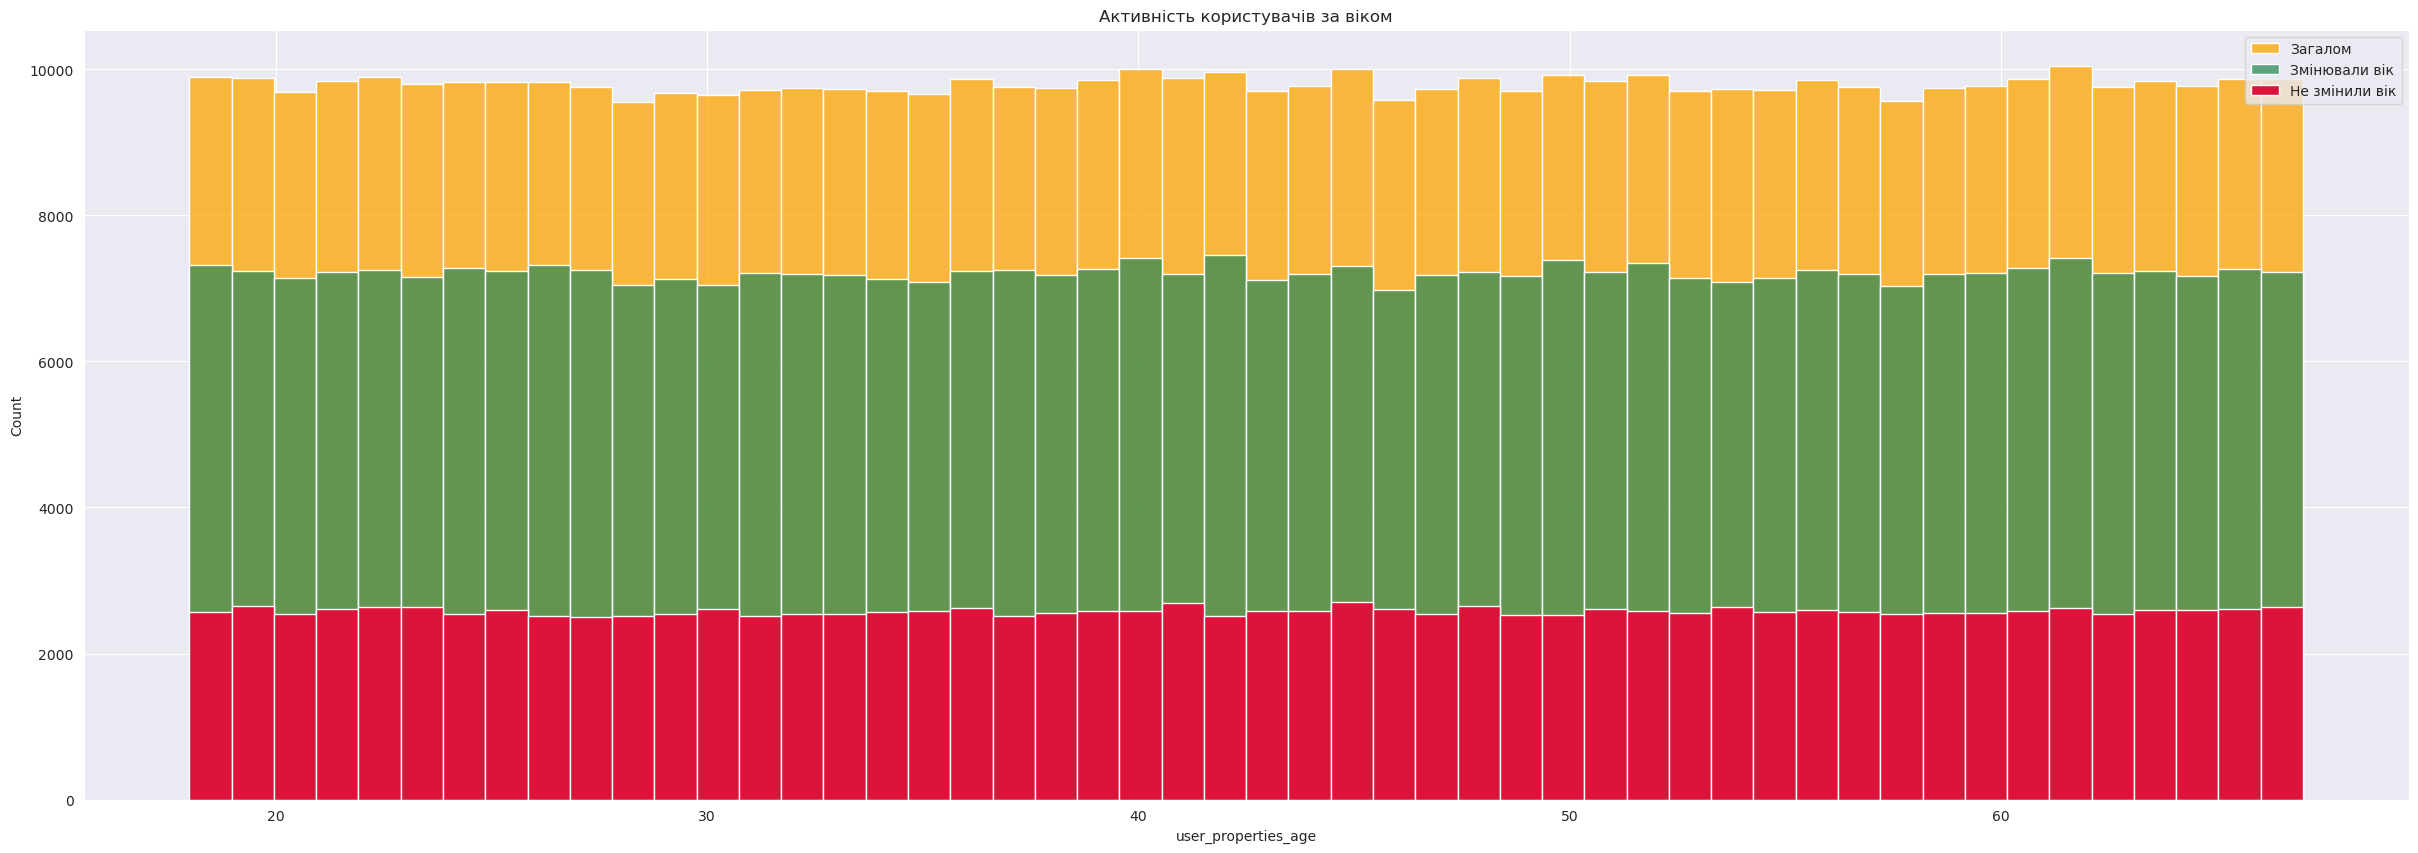

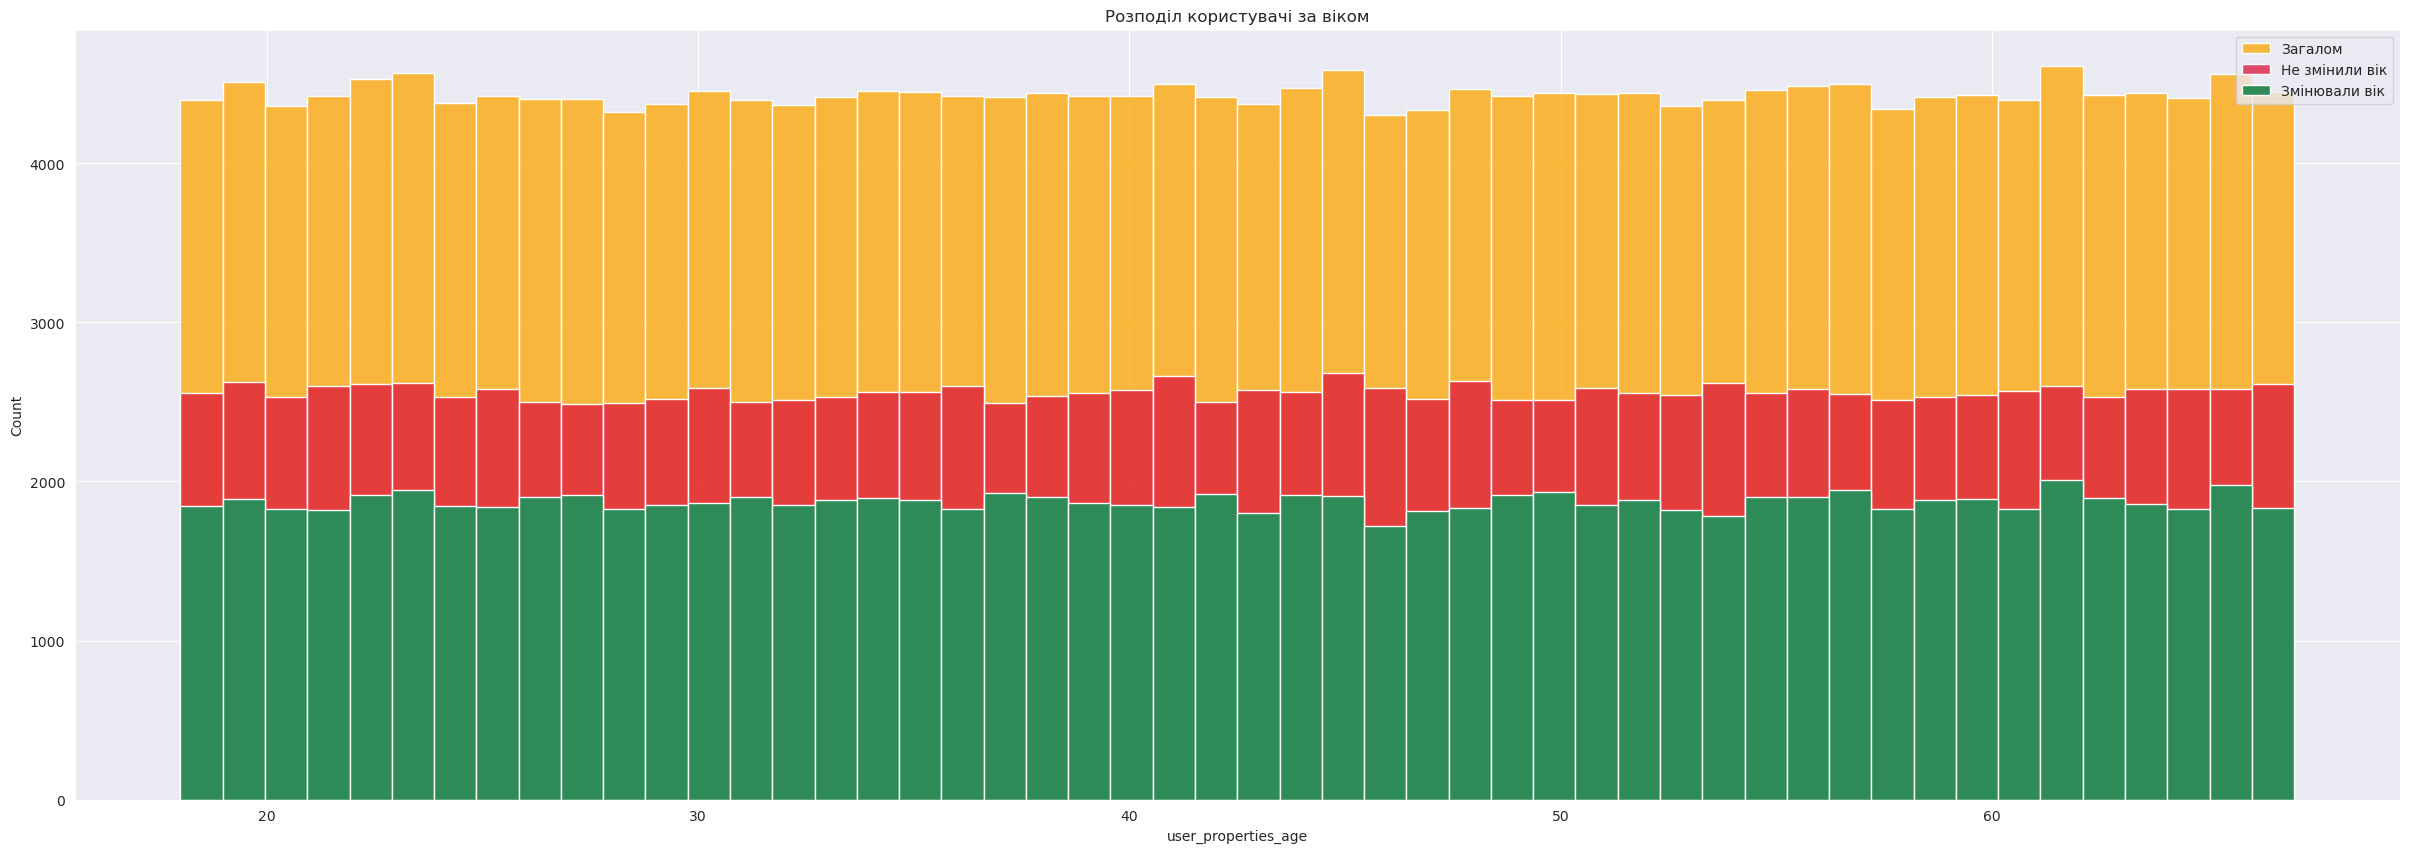

In [45]:
age_distribution_separately(df_cleaned, users_without_age_changes, users_with_age_changes)
age_distribution_separately(df_cleaned, users_without_age_changes, users_with_age_changes, unique=True)

As you can see from these graphs, the distribution remains uniform even if you exclude users who have changed their age. We can also see that although there are fewer users who change their age, they generate significantly more activity. It looks like the data was generated using a uniform distribution or it is a very strange technical glitch.

Such age-changing users could be considered a common error and removed for further study. But they make up the majority of the data and generate about 2/3 of the activity. Also, their removal almost does not change the main indicators of the distributions (more on this below). Therefore, at this stage, I decided to divide the data into: General, Changing age, Not changing age. I will work with them separately and study them according to a similar structure, because except for the age change, they are almost identical


#### General Data

##### Distributions

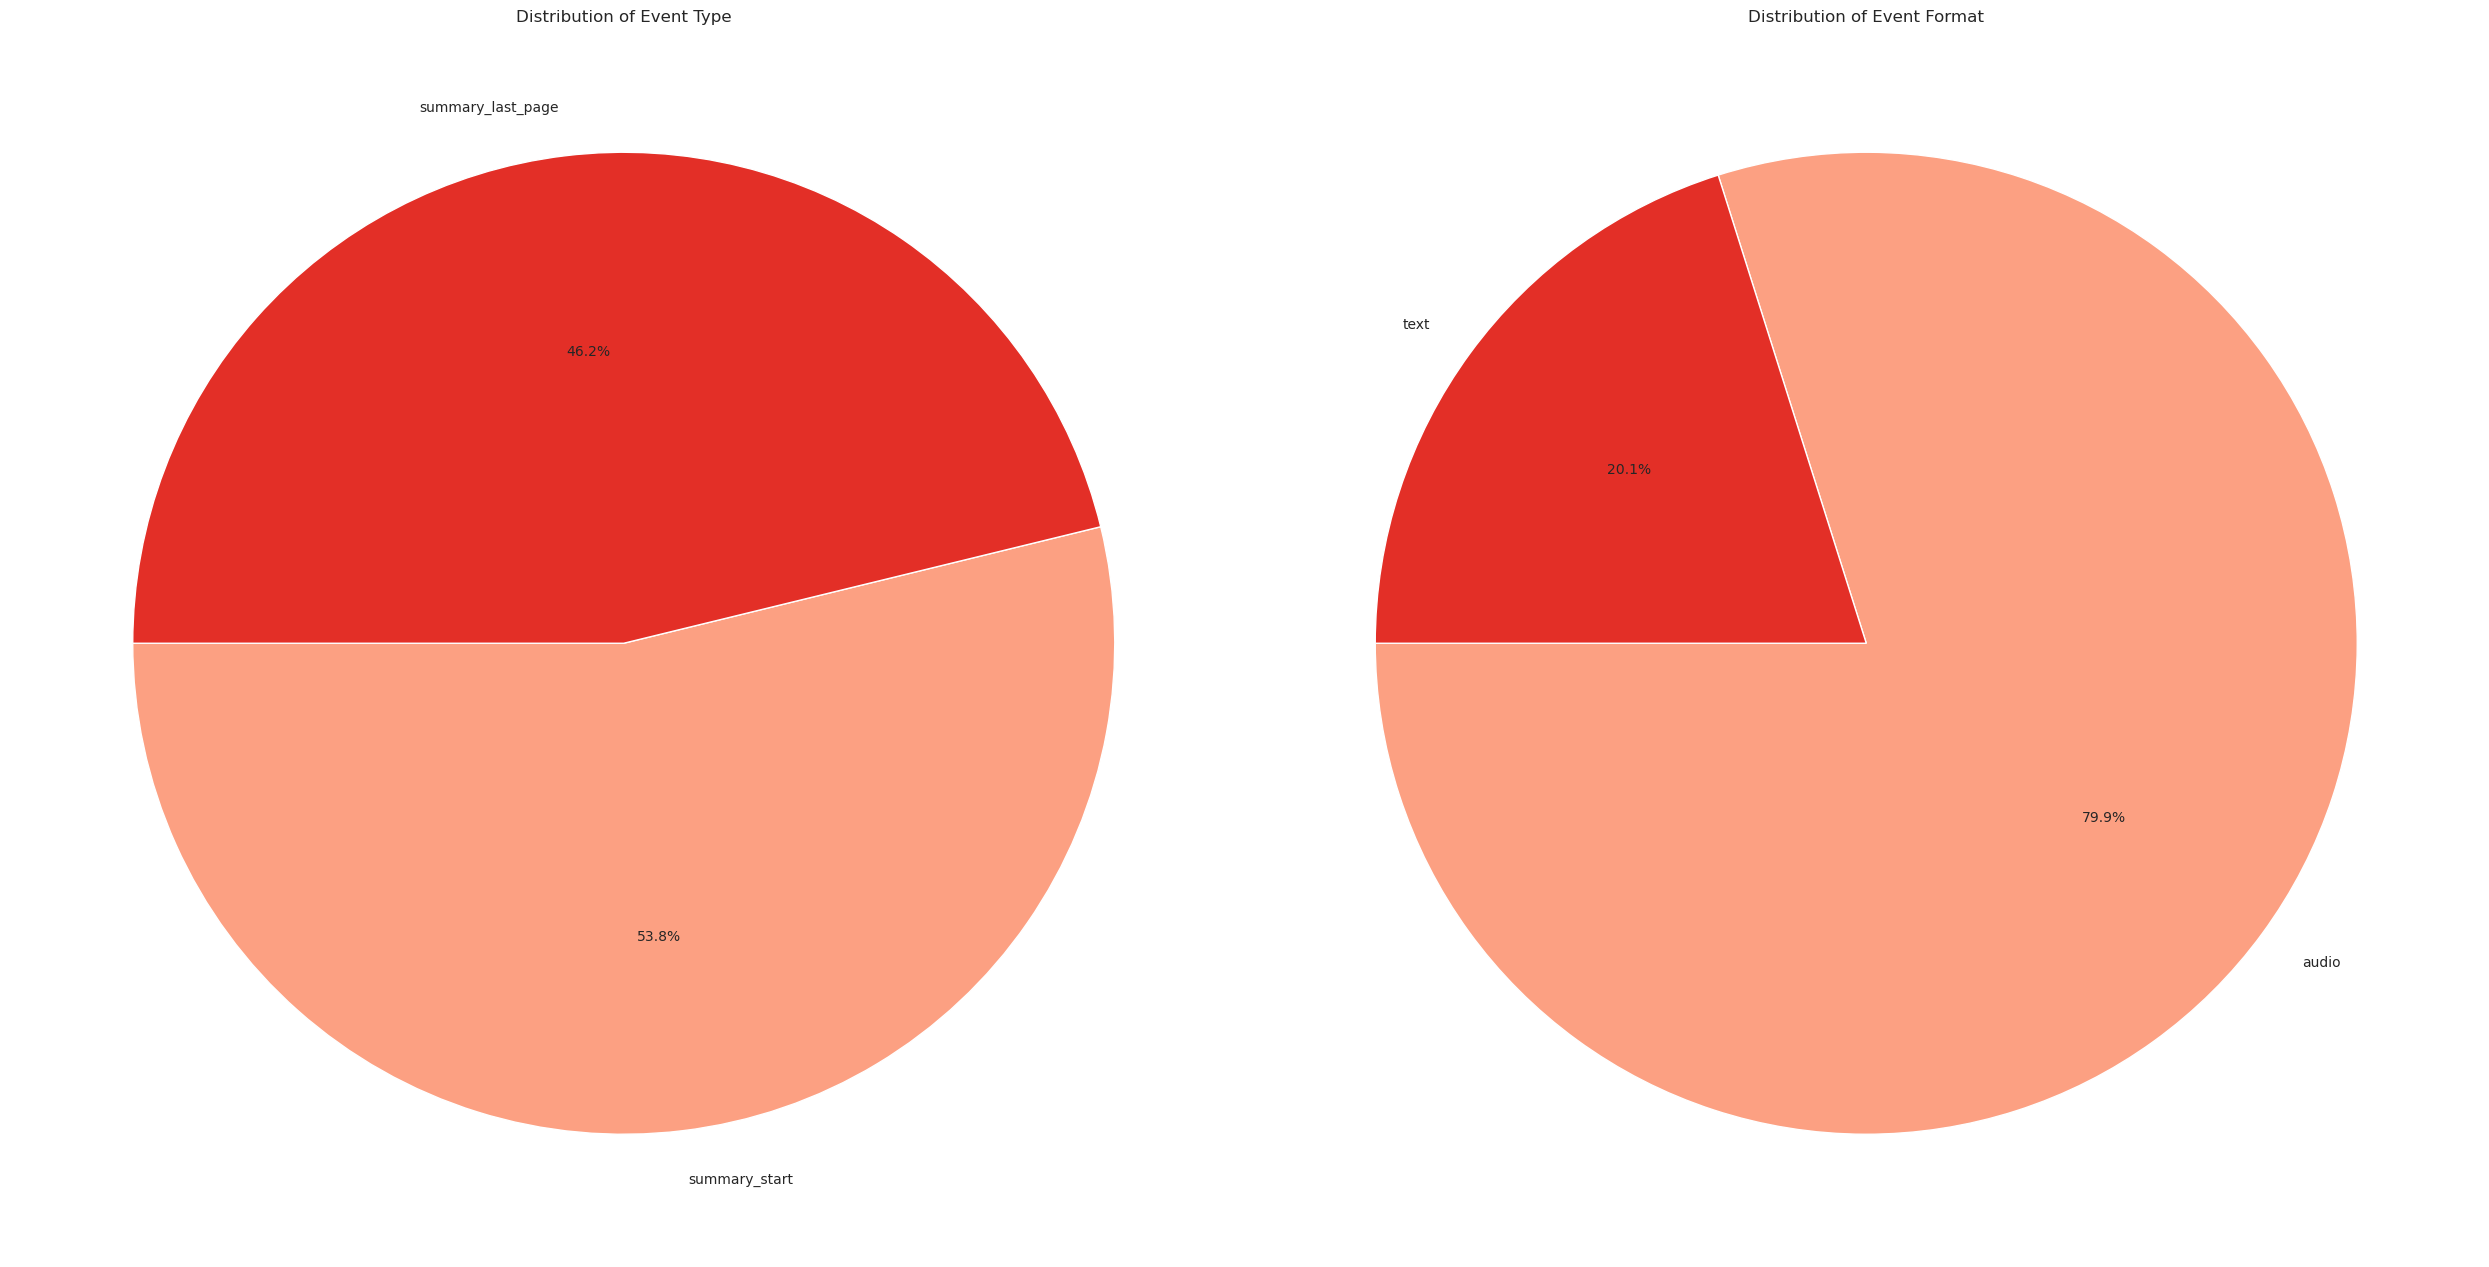

In [46]:
plot_event_distributions(df_cleaned)

As we can see from the second diagram, most users prefer the audio format. As for the first one, we can say that corseters almost always read summaries, but this is only at first glance, so it's worth looking into it in more detail

Unique user-book pairs: 470919
Books fully tracked (started and completed): 15009
Total books started: 263483
Estimated completion rate: 5.70%
Records with 'summary_last_page' but no 'summary_start': 210926
Unique users with only 'summary_last_page': 59768


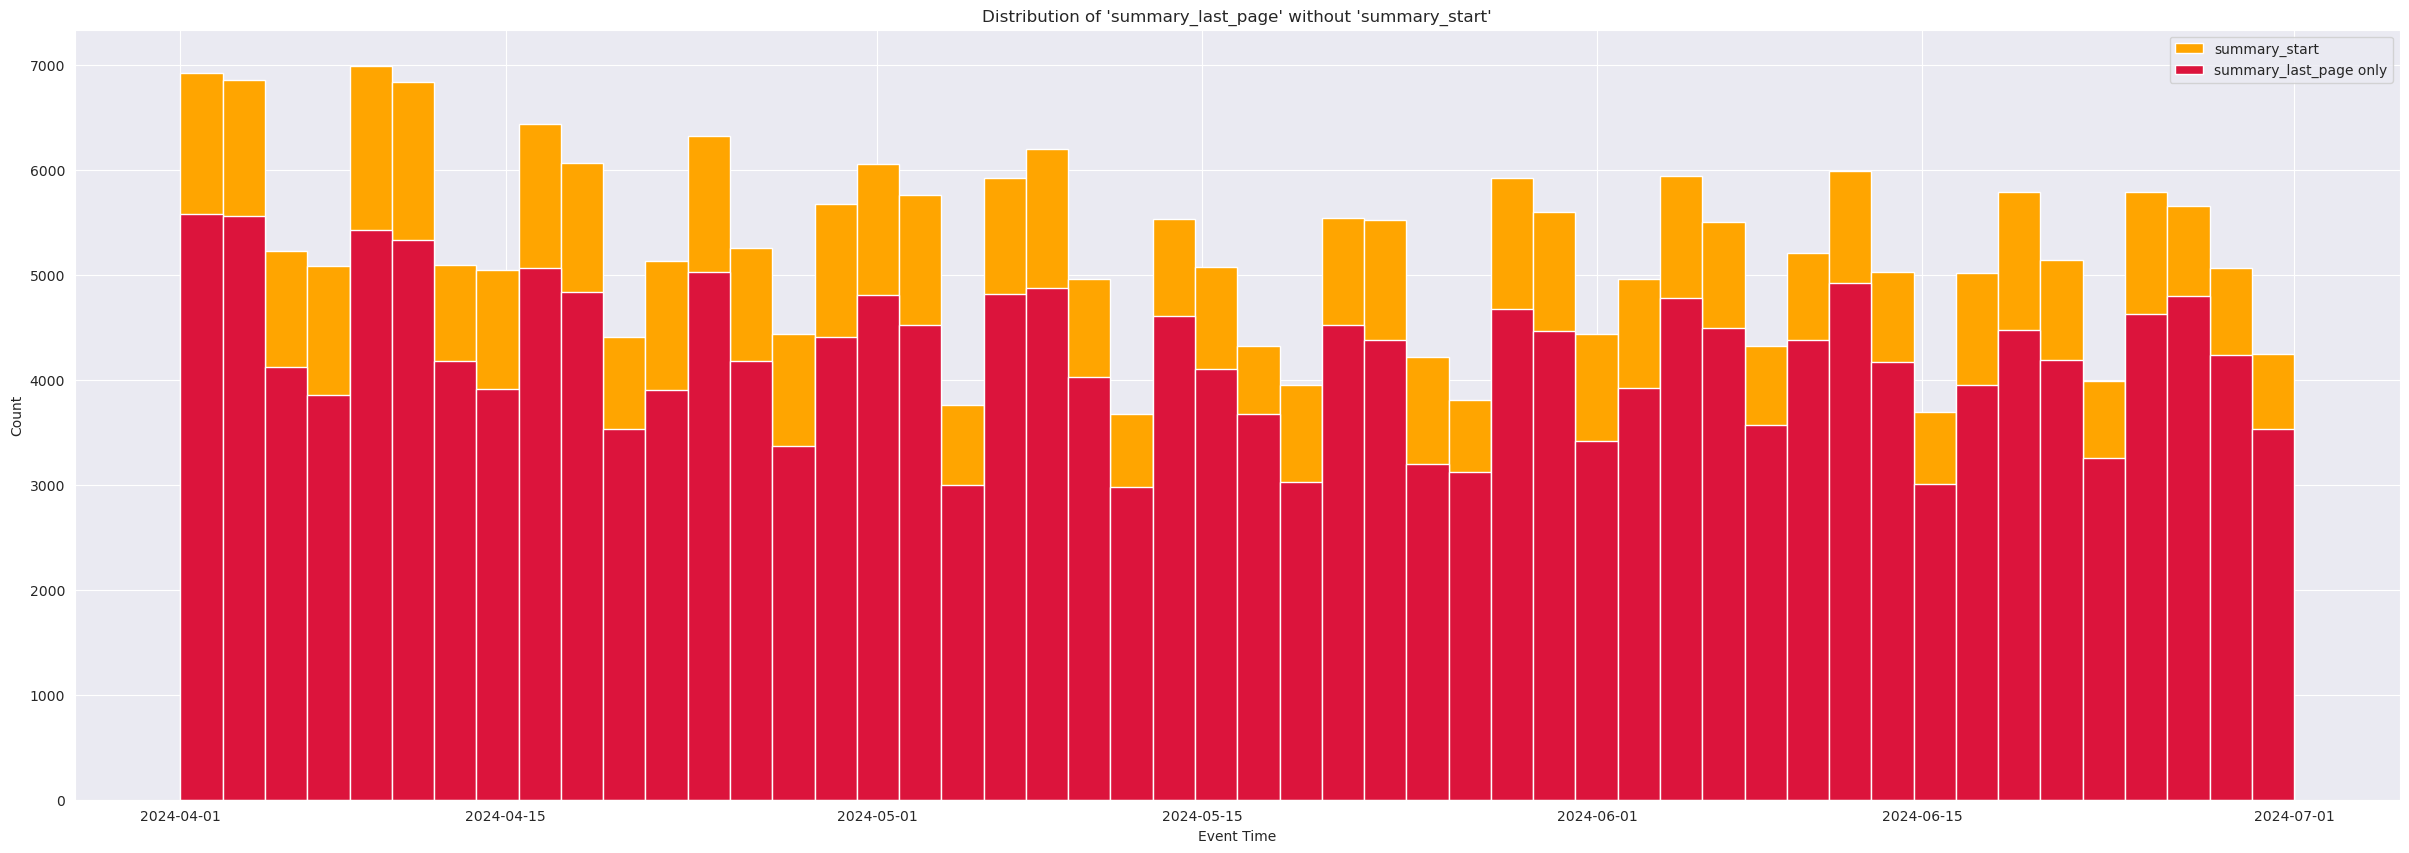

In [47]:
analyze_book_completion(df_cleaned)

As you can see from the diagram, a significant number of users view the last page of the samari without fixing the start of reading. Most likely, this means that the user started reading this summary before the recording of this data period began. It can also be a failure in data recording, so you should pay attention to this in the future, check the data recording process and check if this is the case based on data for a longer period of time (if any).

As for other indicators:

Records from `summary_last_page`: `210_000`. This is almost half of all records and it has been de-segmented by `59,768` users, which may indicate significant gaps from the beginning of reading to the end.
A total of `263,483 reads were started during this time, of which only `15,009 were completed, which is `5.70%`. This is a very low rate. However, based on the fact that almost half of the requests are “reads” from the previous preceding period, we can assume that users have long gaps between reading (more on this below) and will finish these books later.

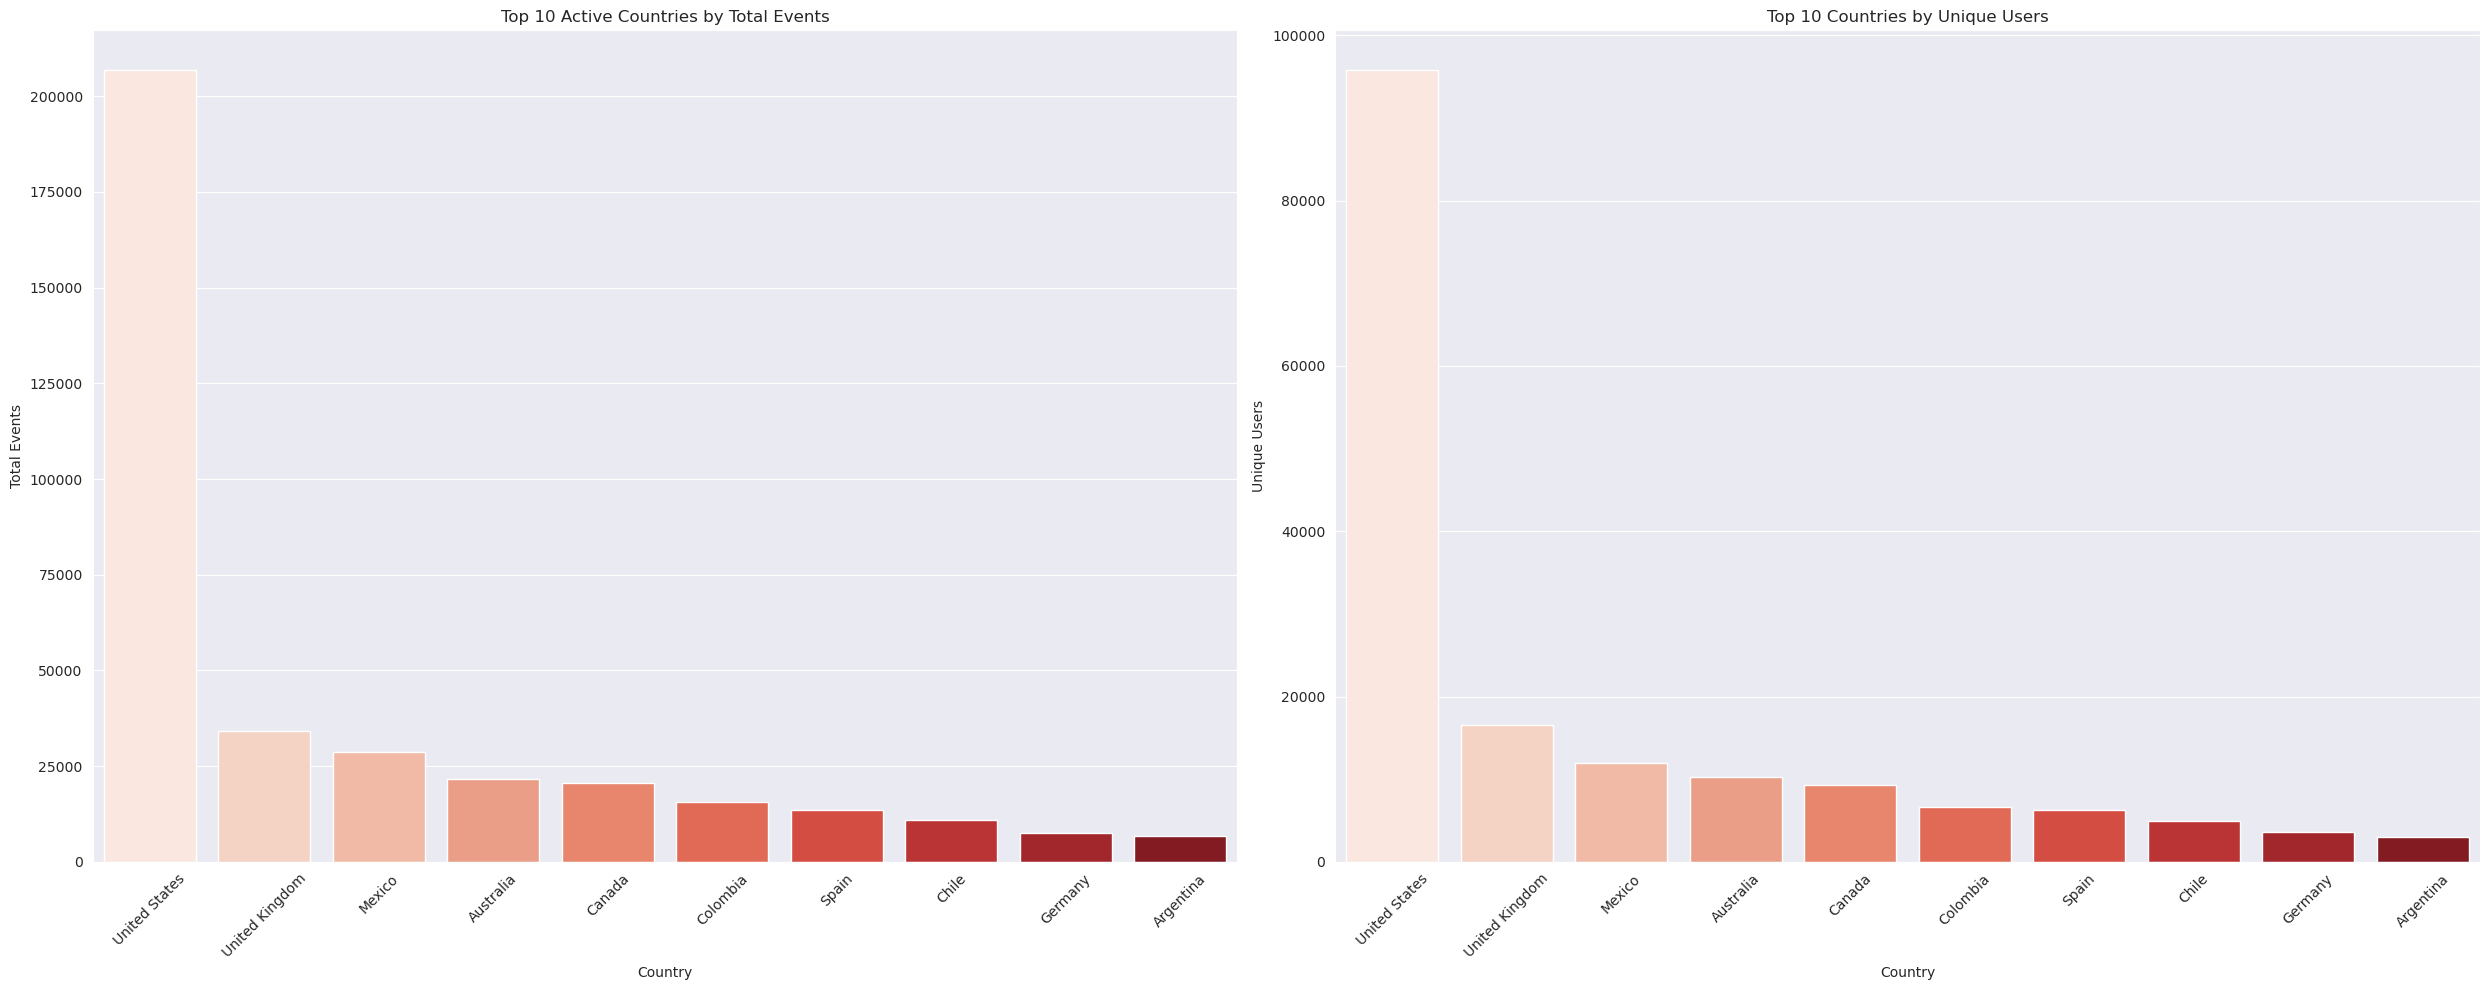

In [48]:
plot_country_activity(df_cleaned)

The United States has the dominant share among countries in terms of both activity and the number of users, and it is also interesting that the distribution of these indicators is very similar. We can also see that English and Spanish speakers dominate among the top 10 countries, and it is this audience (and these languages) that should be emphasized.

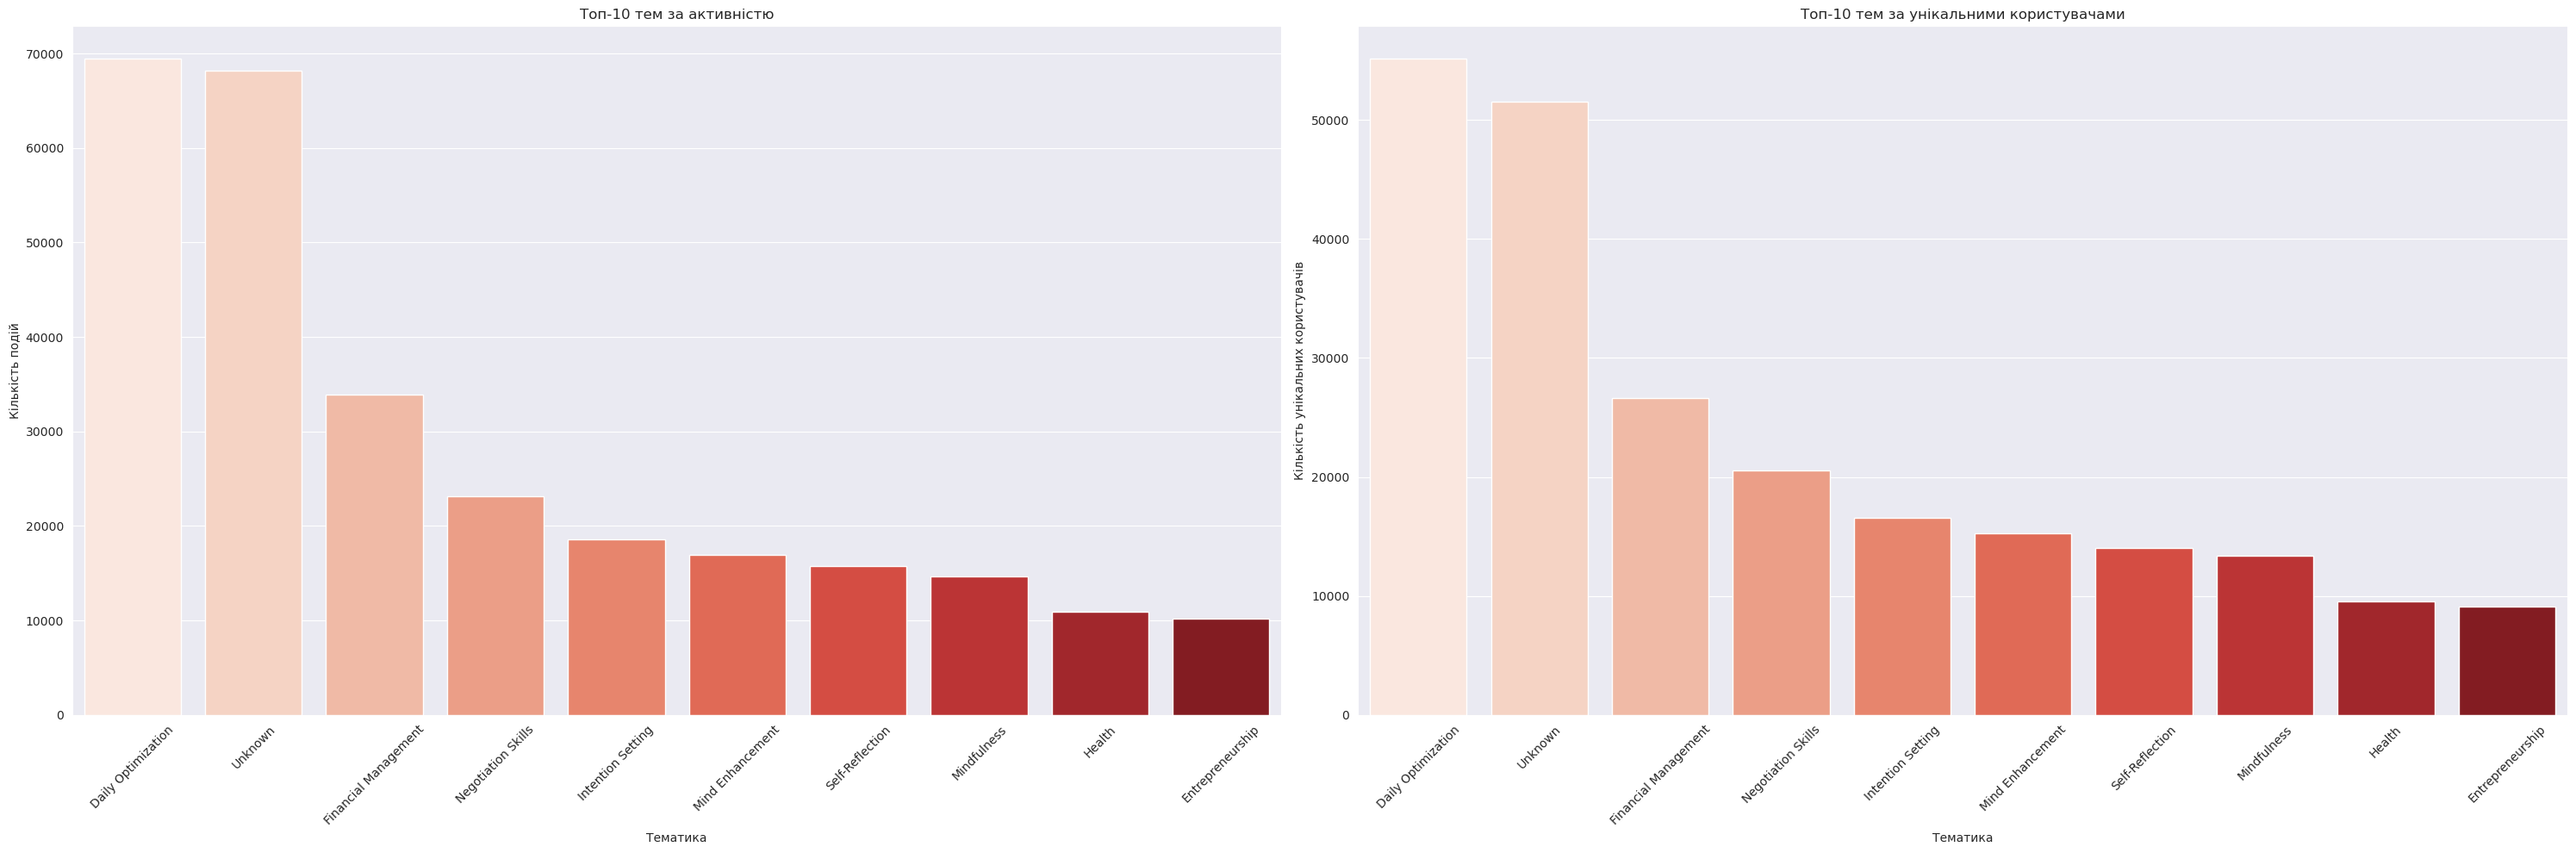

In [49]:
plot_topic_distribution(df_cleaned)

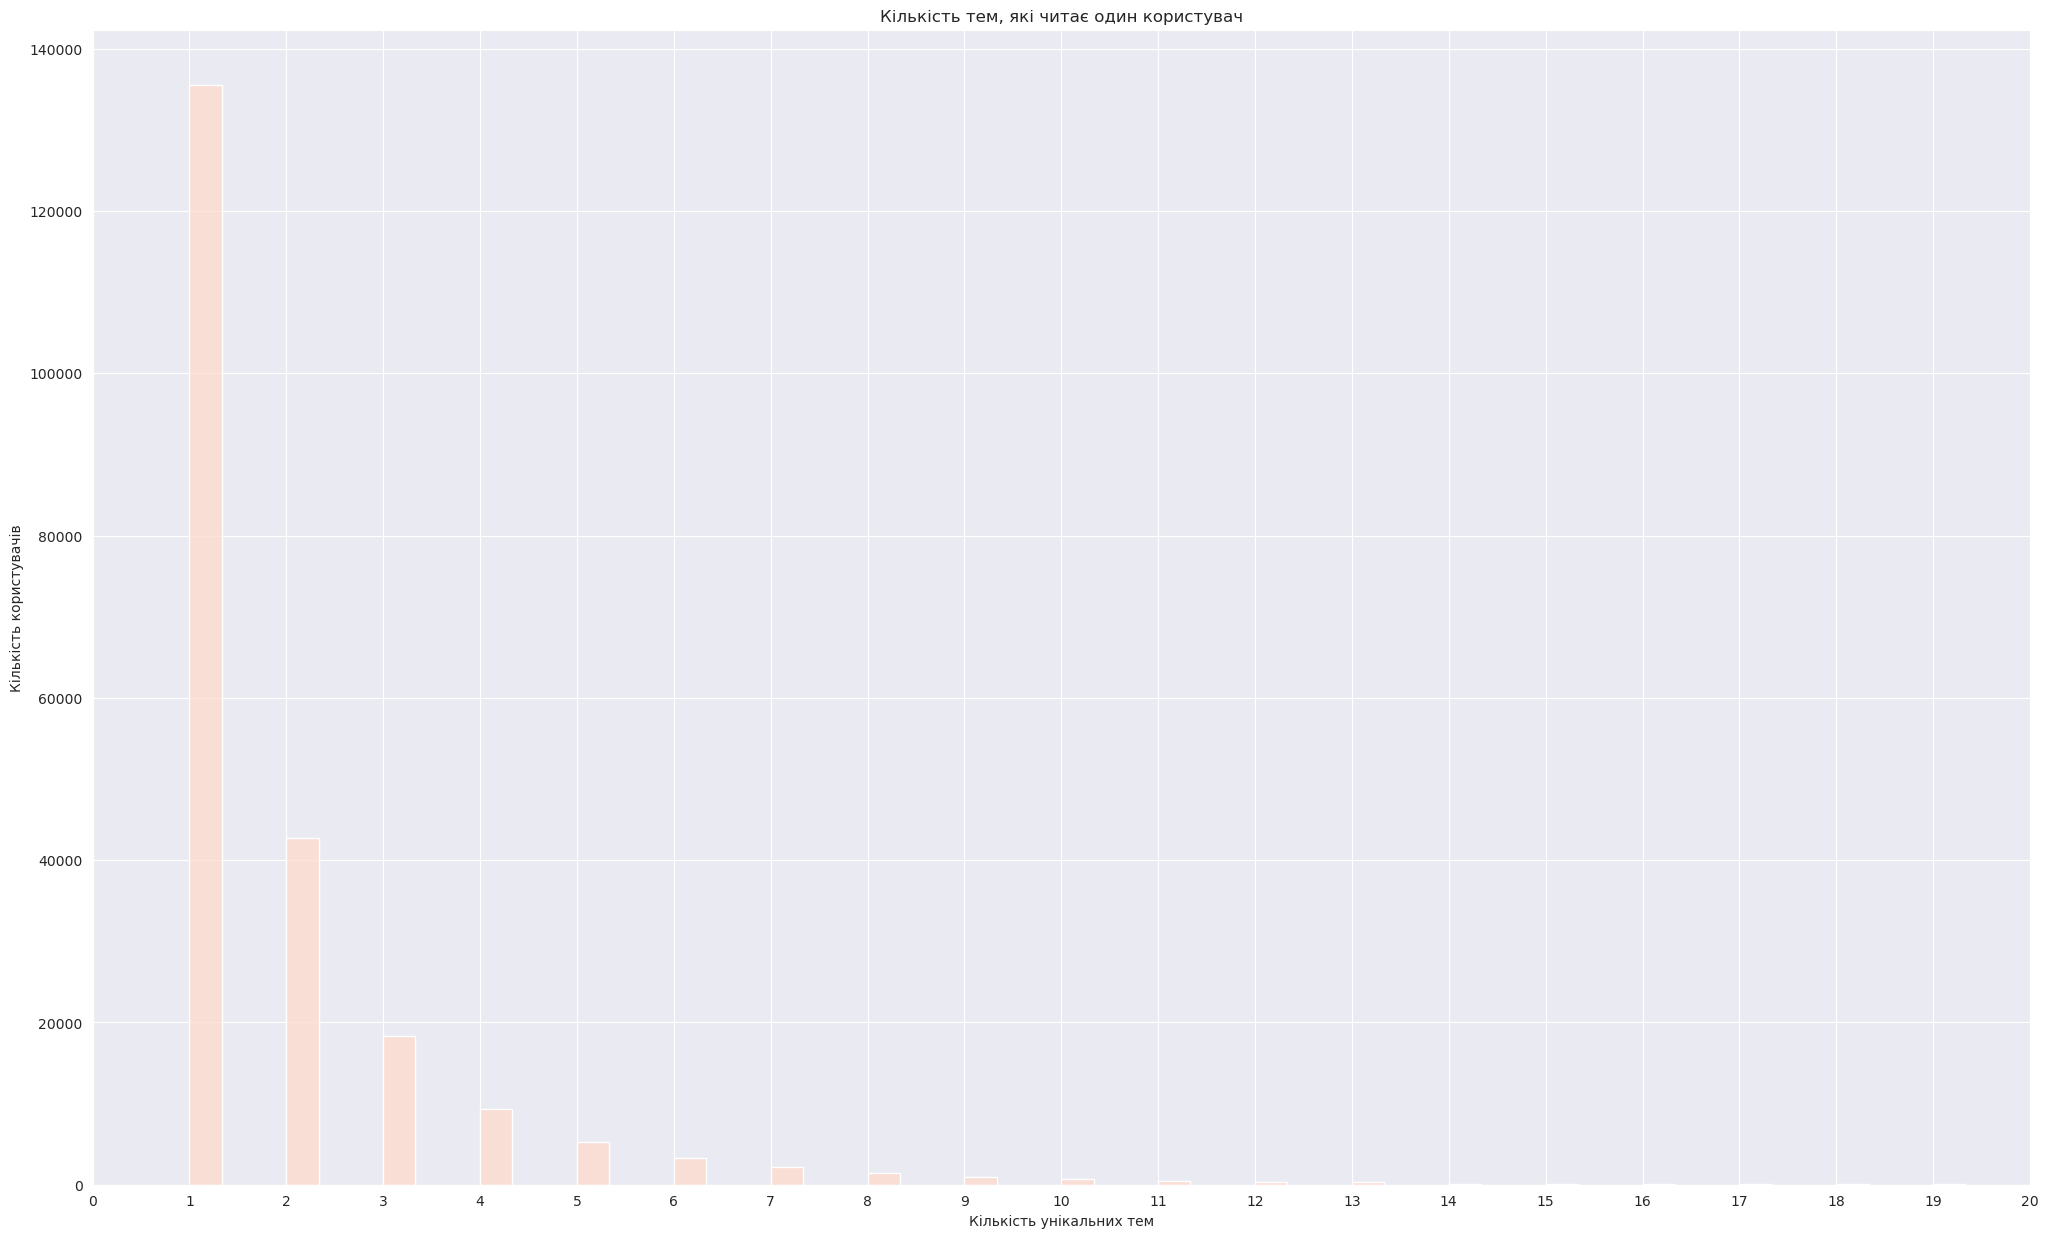

In [50]:
topic_number_by_user(df_cleaned)

As we can see most users prefer to choose summary with one topic

##### Hours Activity Time differences between reading summary

In [51]:
df_copy, user_daily_reads = prepare_user_reading_data(df_cleaned)

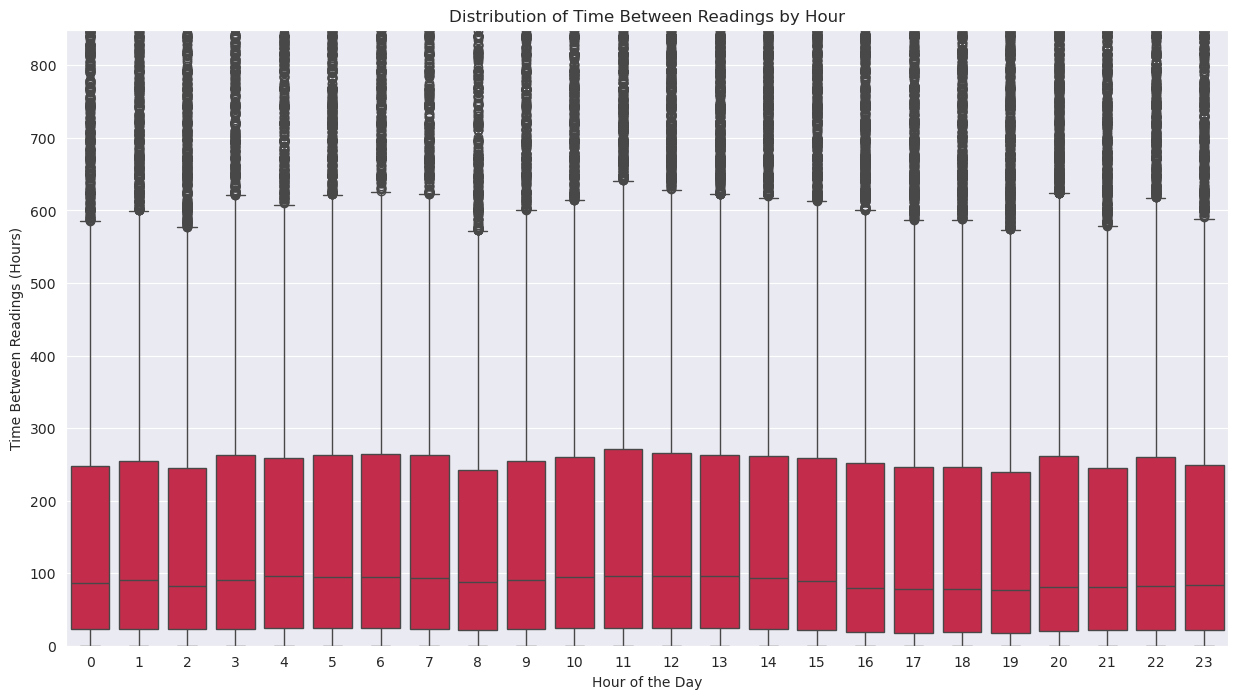

In [52]:
plot_time_diff_by_hour(df_copy)

As we can see, the time of day has almost no effect on the time between readings

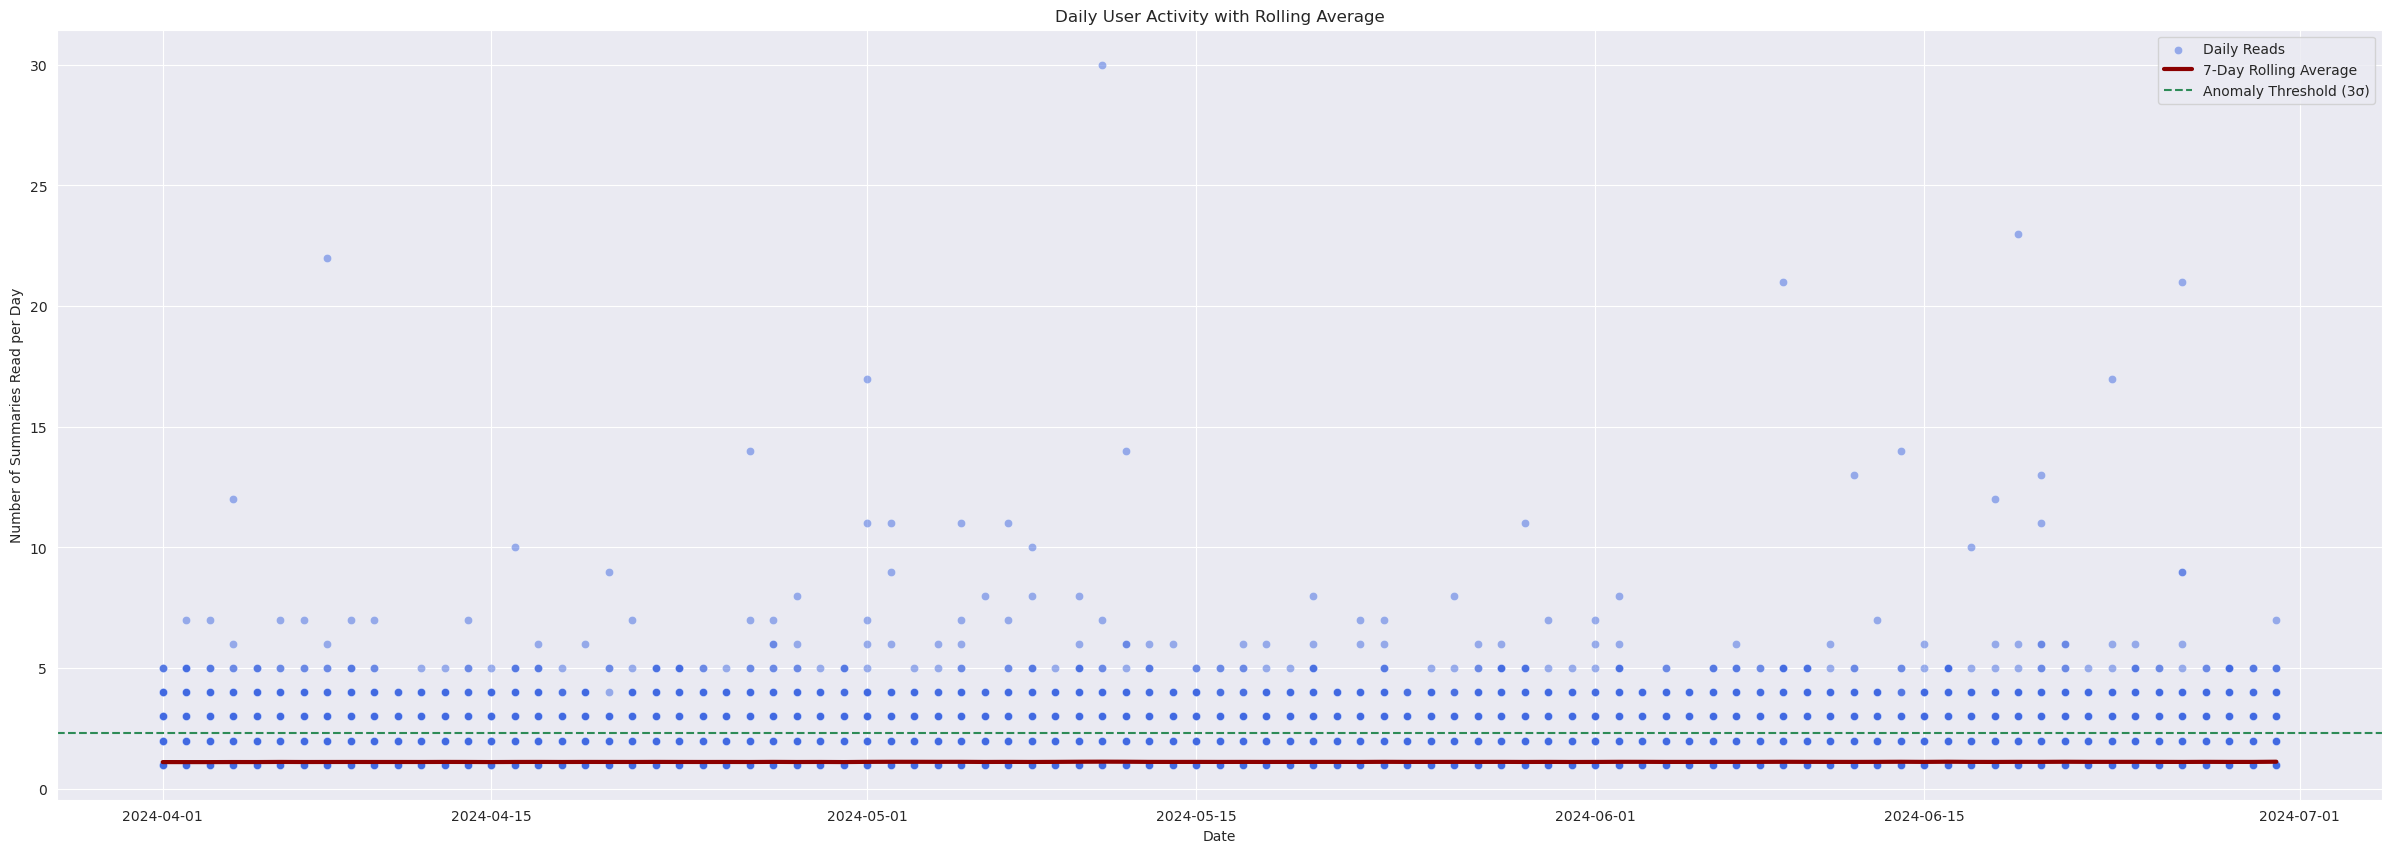

In [53]:
plot_user_activity(user_daily_reads)

Here we can see that the average value for a user is 2-3 books, and there are many users (about 5000) who go beyond this, and some of them even very much. But these 'anomalies' are quite natural and indicate that a small proportion of users are true 'connoisseurs' of the product. Such an audience can be called “loyal” and should be targeted for marketing campaigns, sweepstakes, etc.

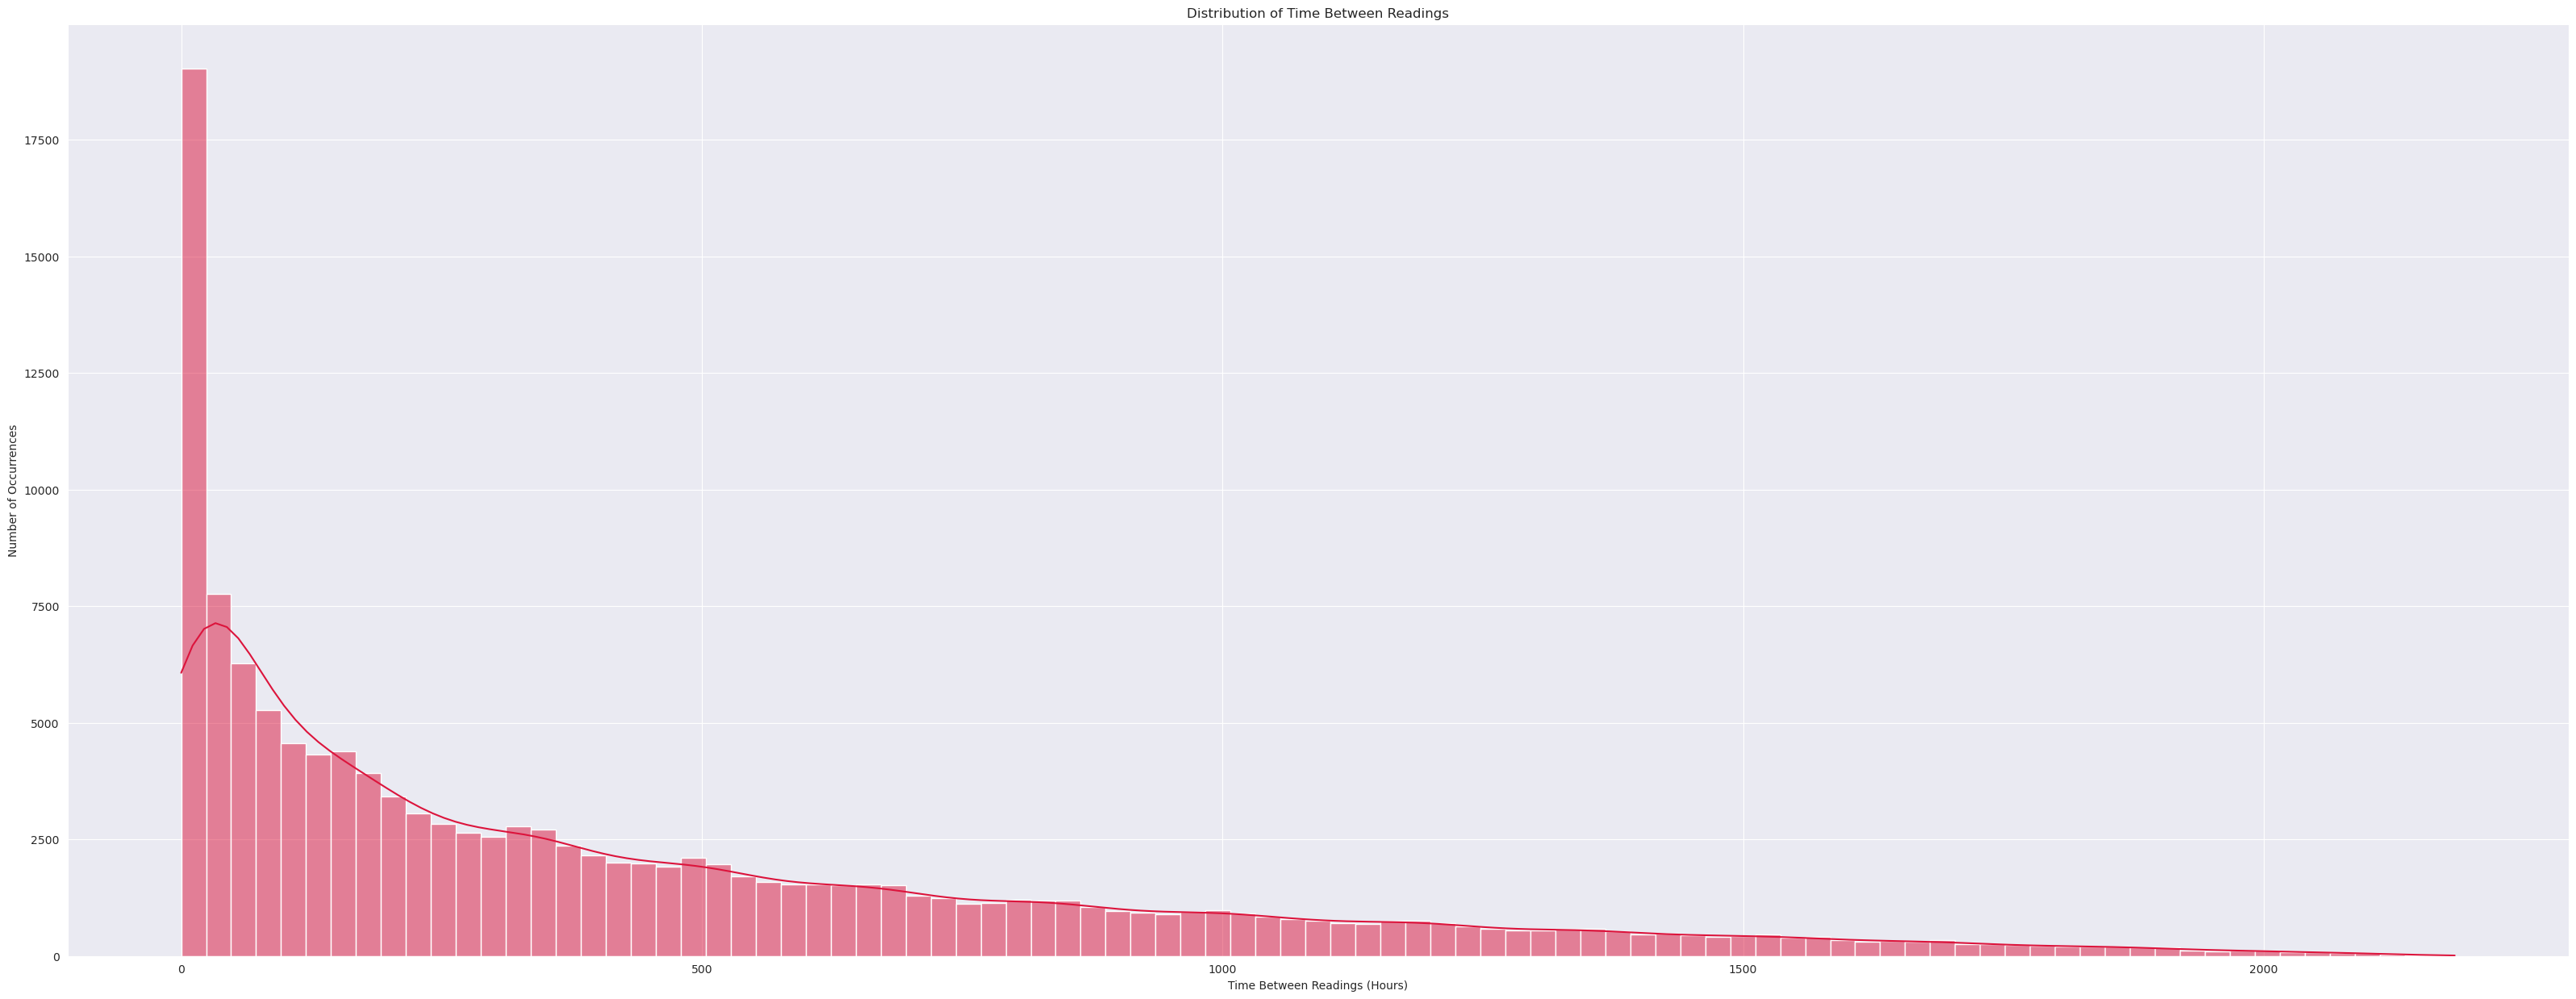

In [92]:
plot_time_diff_distribution(df_cleaned)

We can see the trend here: Most users read summaries in a short time, but there are many who do it in 500 hours or even more. This supports the hypothesis described above (that users make large intervals, so almost half of the entries have no beginning)

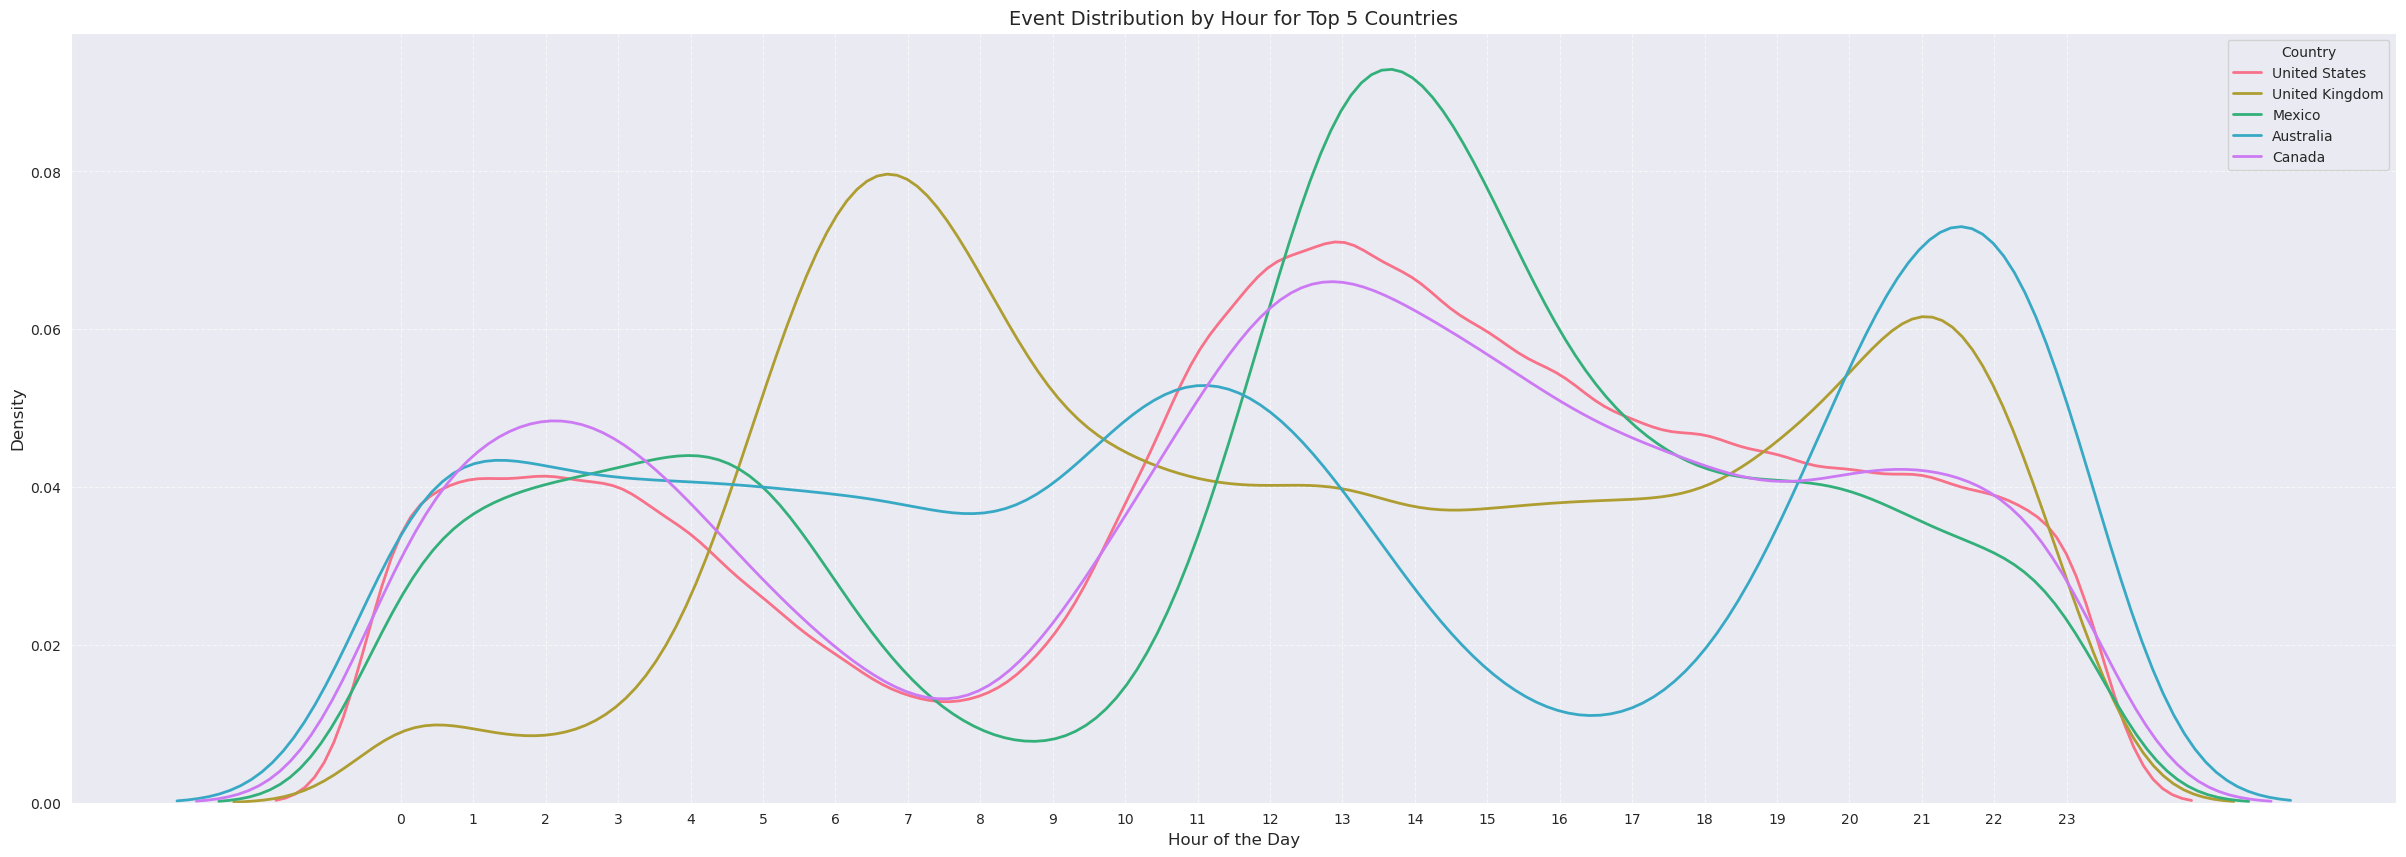

In [55]:
hour_activity_by_country(df_cleaned, 5)

As we can see, hourly peaks of activity differ from country to country. They are similar in countries with similar time zones (USA, Canada, Mexico), but they are radically different in others (UK). This indicates that the data is recorded at the local time of the user's country

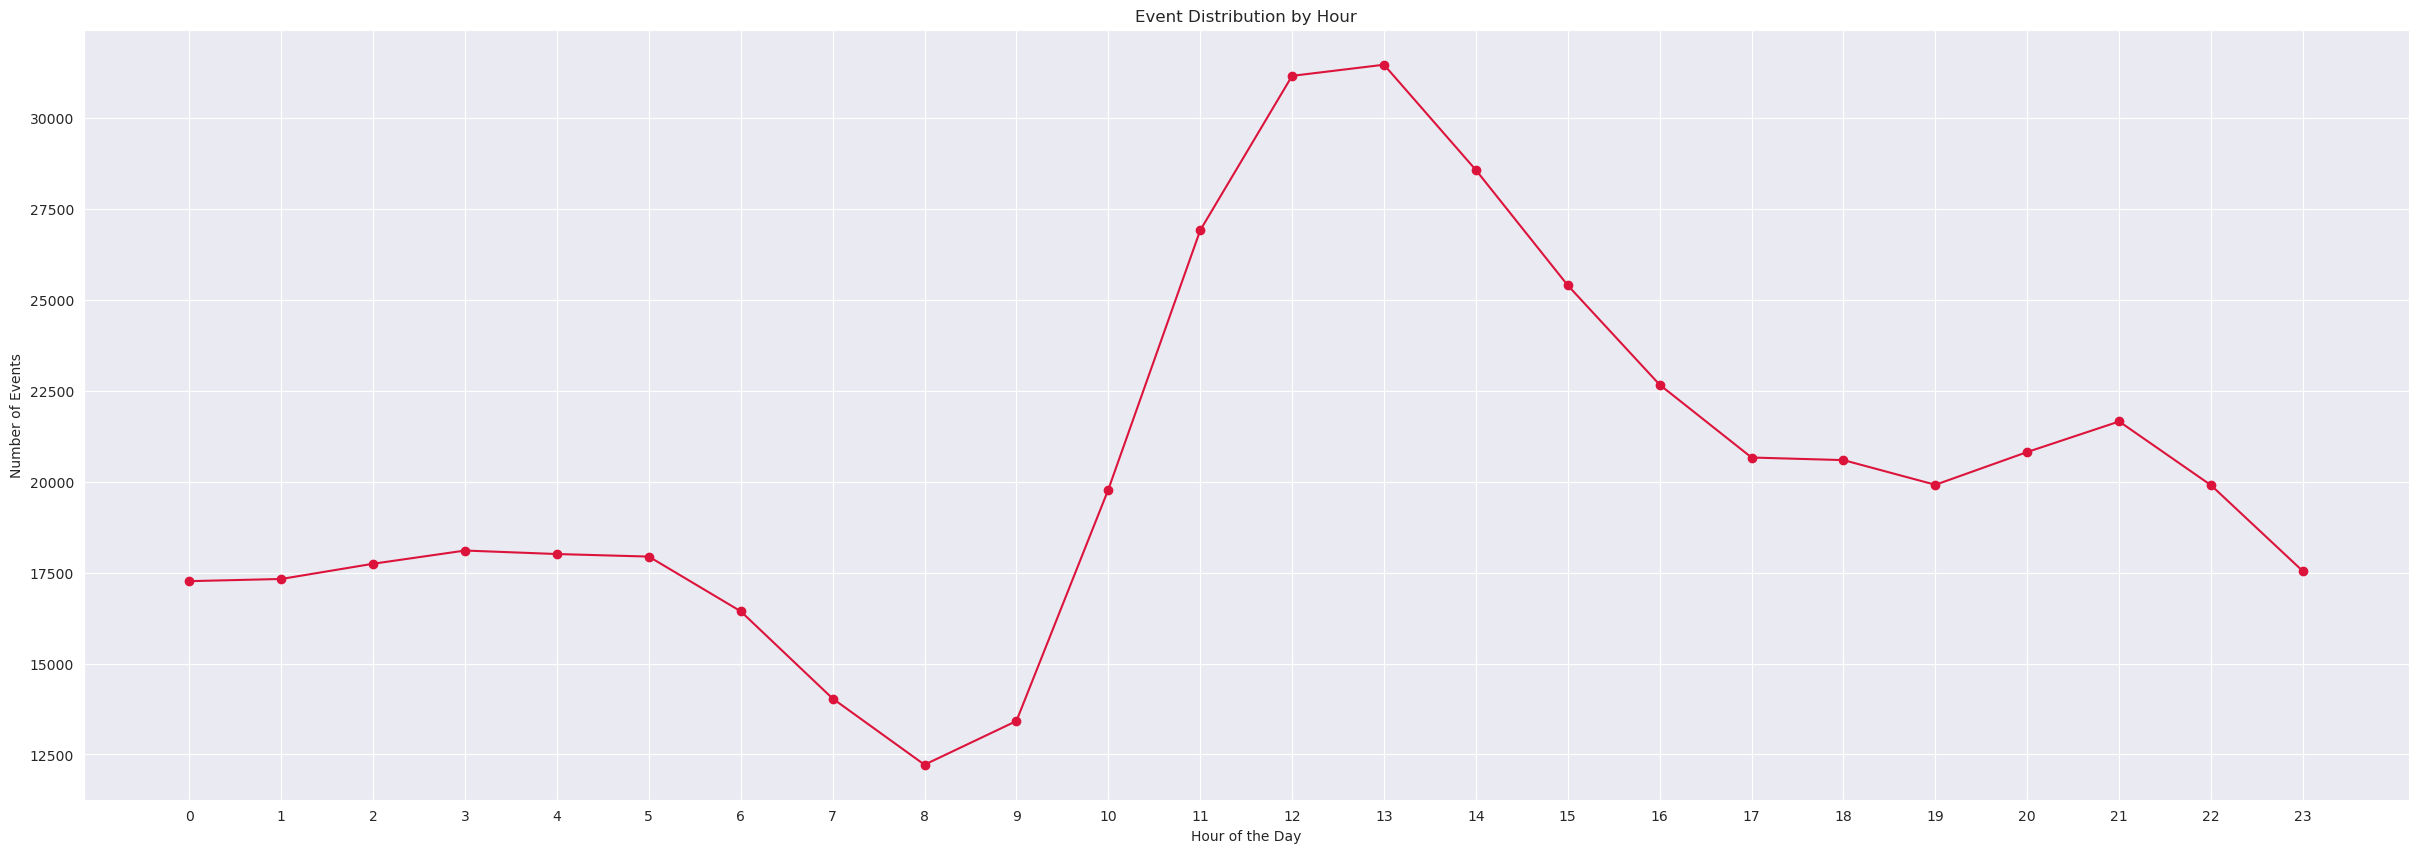

In [56]:
plot_event_distribution_by_hour(df_cleaned)

Here we see that most of them occur during lunchtime, which is quite expected. In addition, the distribution is heavily skewed toward this time period due to the dominant share of users from the United States, as time zones differ across countries. Also, taking into account this data, it is possible to take into account that if you need to create technical breaks in the application, you should use the least active hours. You can also take into account the difference in time zones

##### Activity Drop

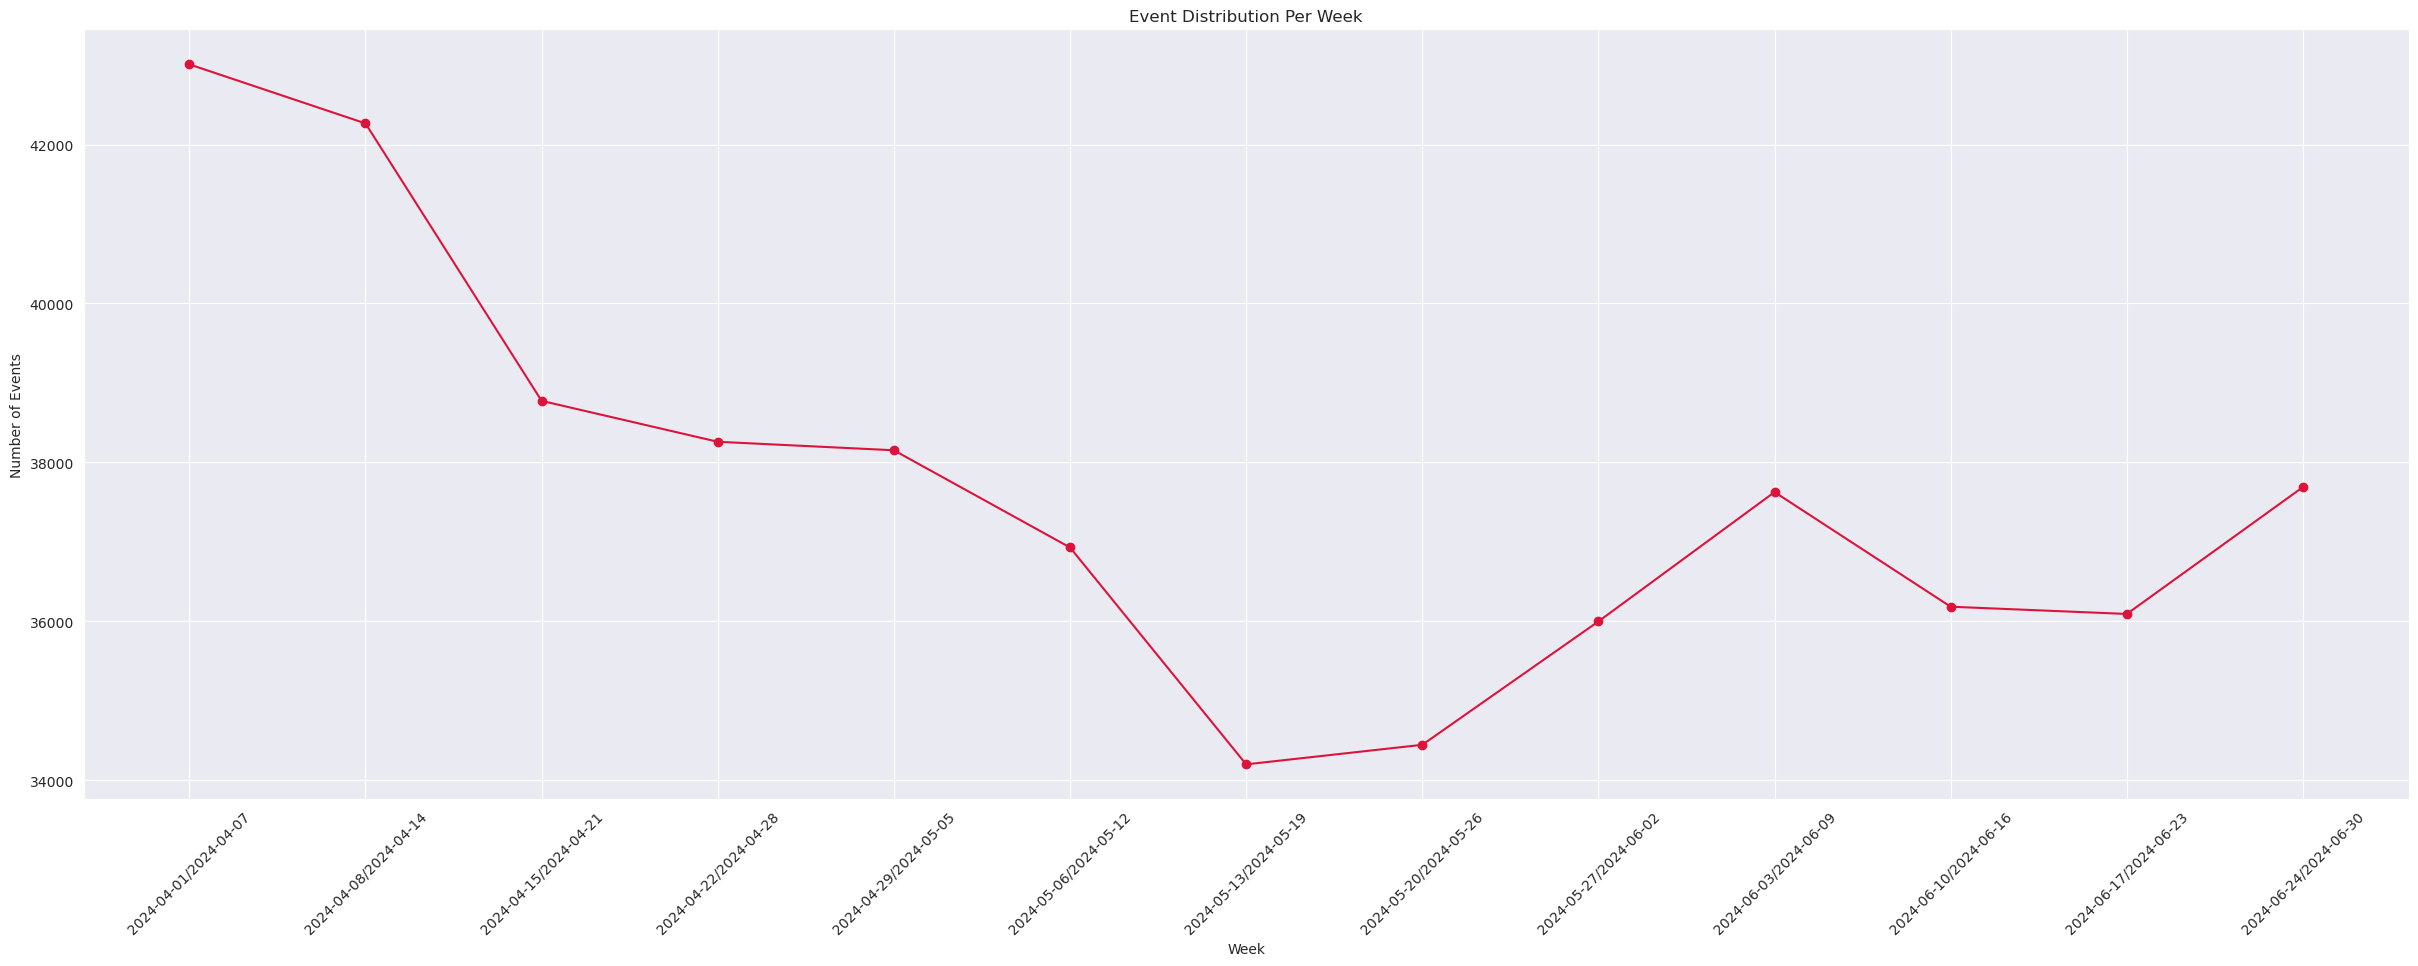

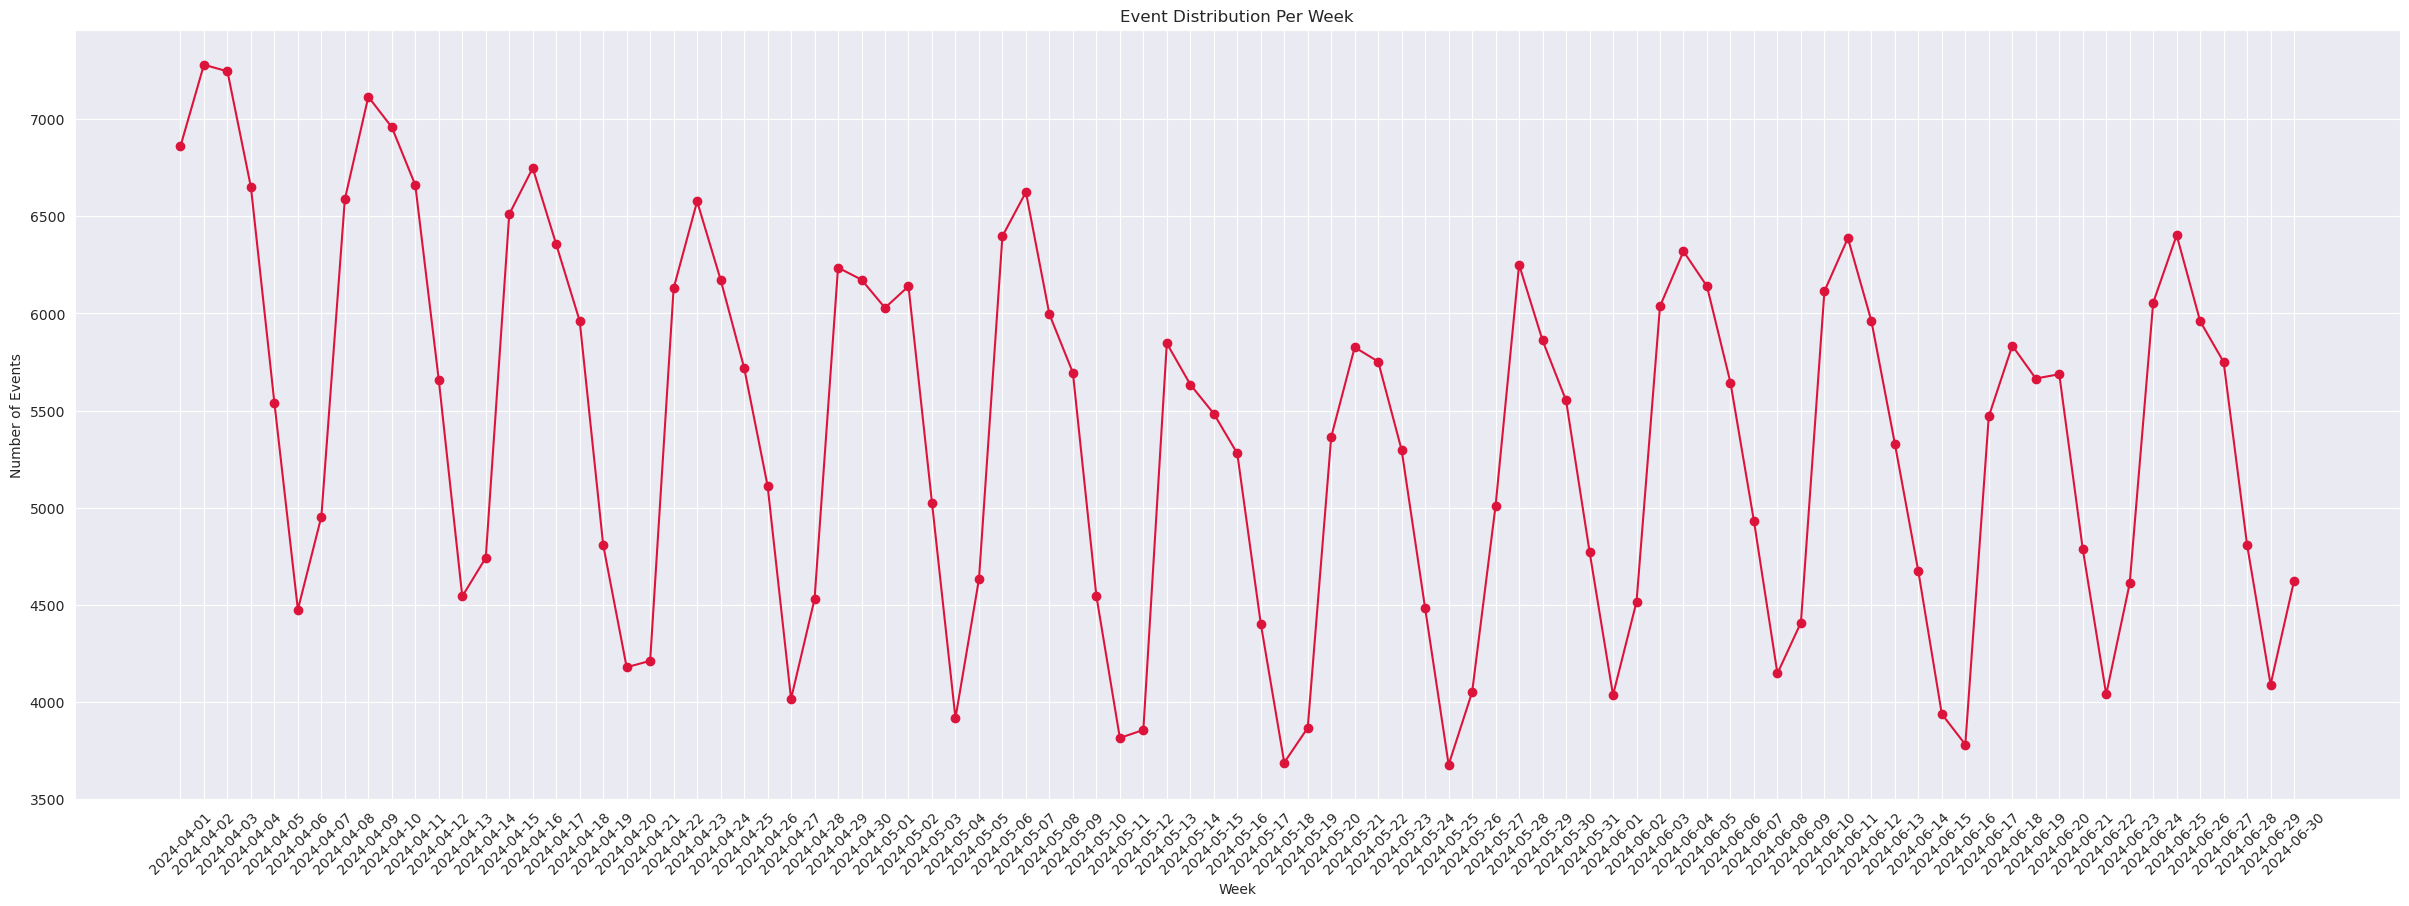

In [57]:
event_per_week(df_cleaned)
event_per_day(df_cleaned)

Here we see a fairly strong downward trend in activity, which occurs from April to mid-May, followed by a gradual recovery. It is worth taking a closer look at the period of minimum activity and comparing it with other, more successful periods to find out the reasons for this drop.

About seasonality below

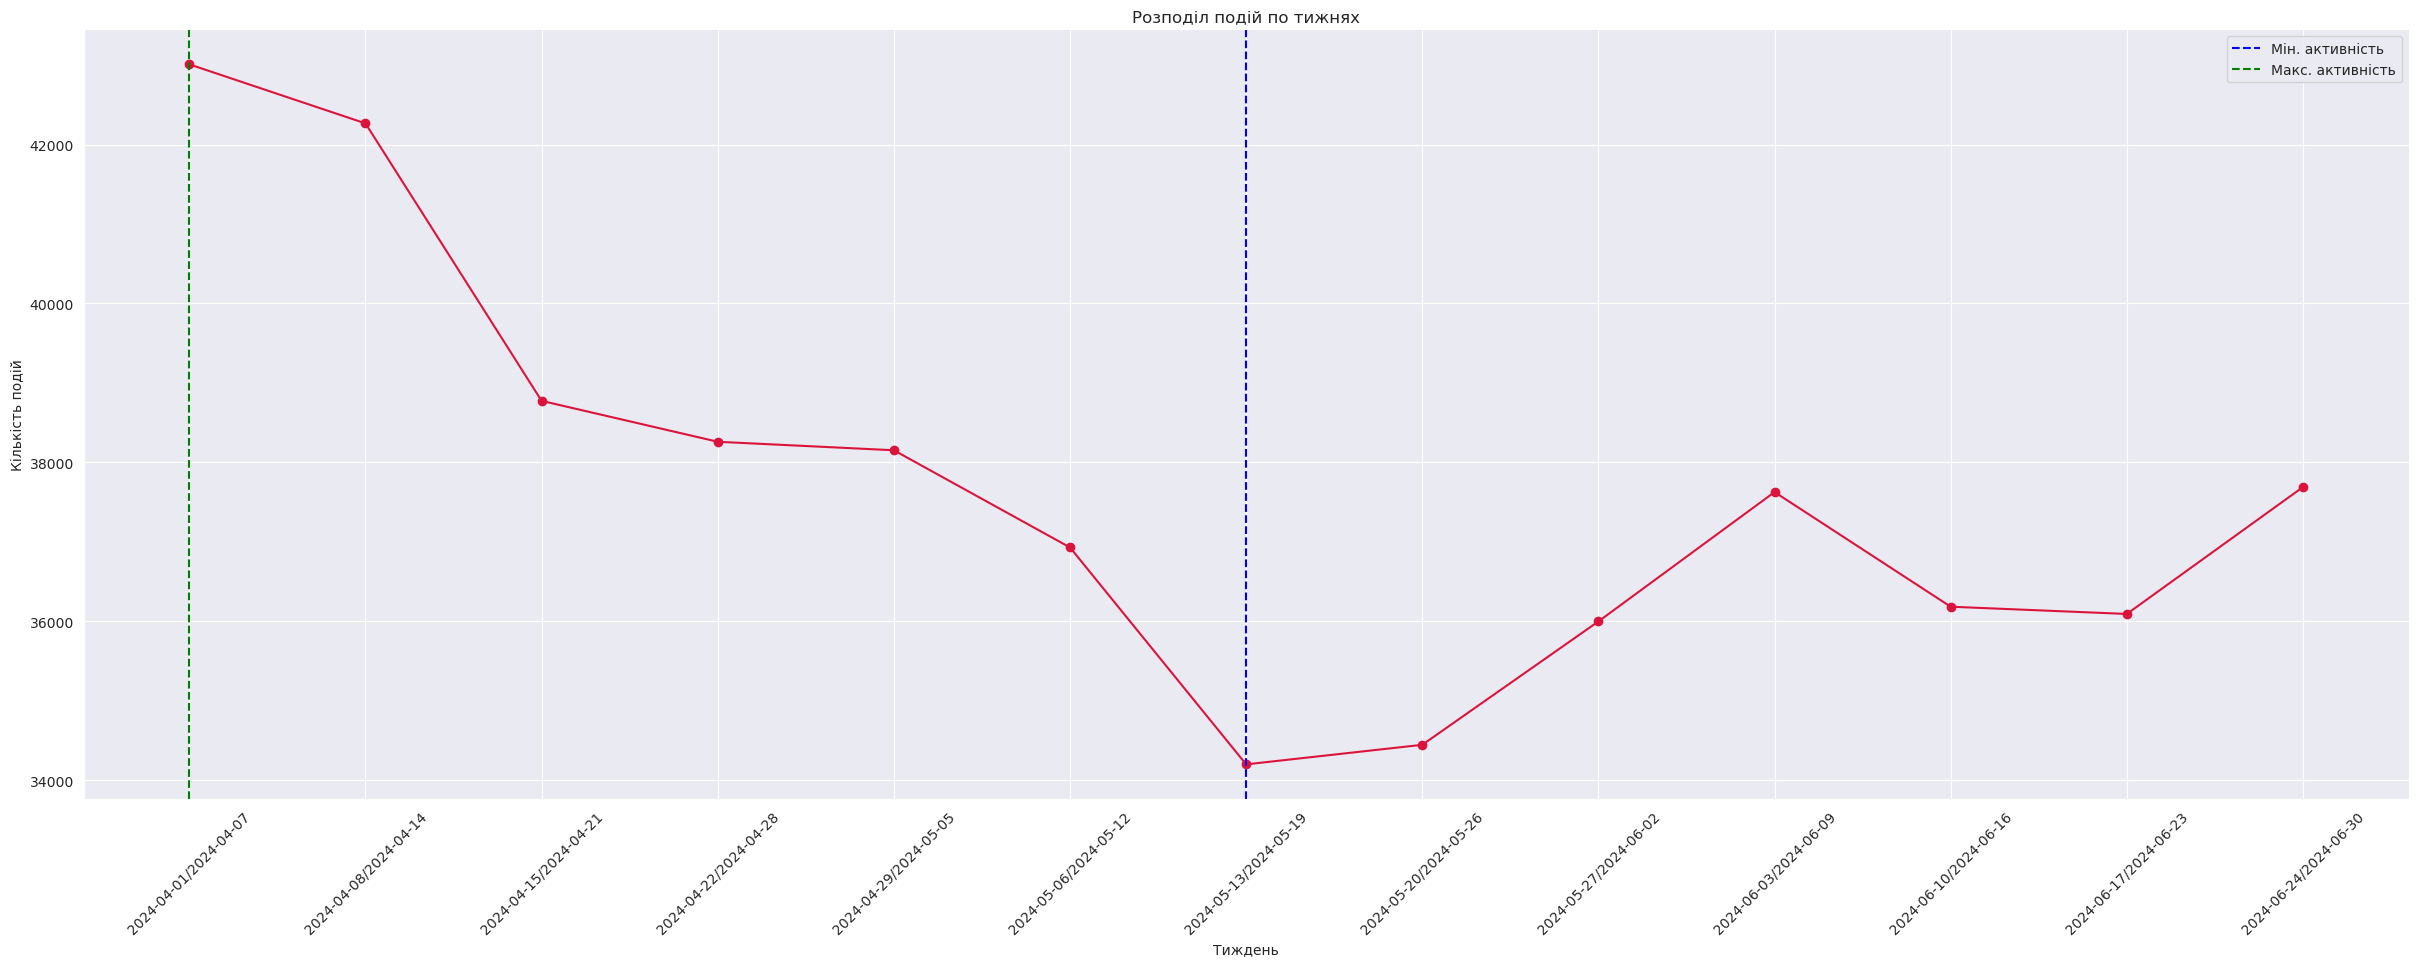

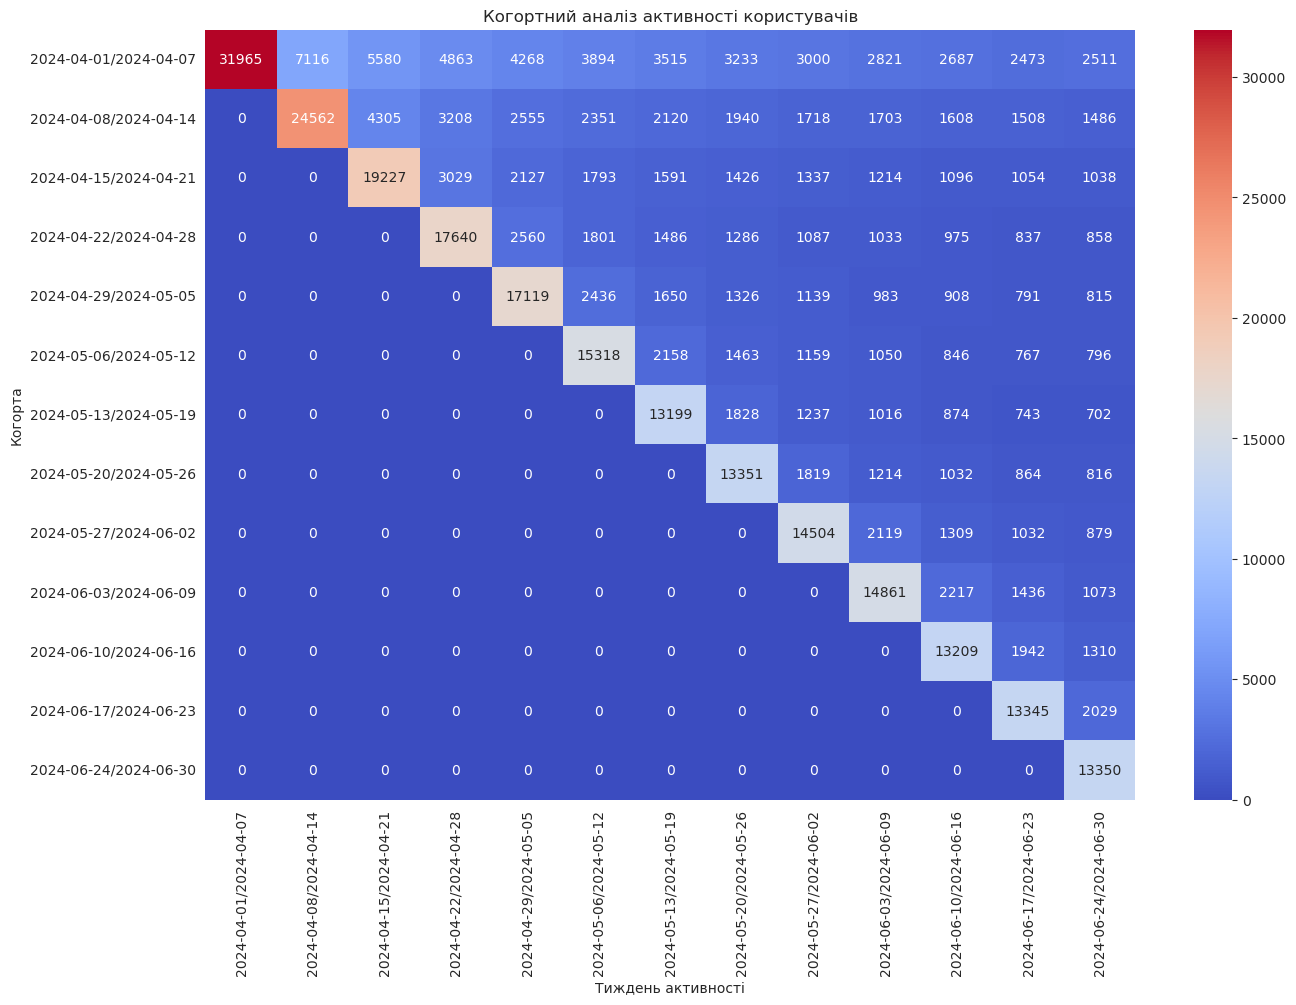

In [58]:
analyze_activity_drop(df_cleaned)

Having conducted a cohort analysis, we can see that the flow of new users is gradually decreasing.
Also, the level of customer retention on the platform is low, which is quite bad.

In the context of considering the decline in user activity, we can say that the reason is the above described things (Decrease in the flow of new customers and low retention rate).

It can be assumed that a successful marketing campaign generated such a large influx of customers earlier, as the situation stabilized later, which may indicate the absence of such campaigns during this period.

As for customer churn, the sharp decline can also be explained by a successful marketing campaign. However, the situation continues to be bad, which suggests that it is worth studying this issue in more detail and developing strategies to retain customers on the platform (daily quests with rewards, etc.). Also, this outflow can be partially explained by the fact that many users take long intervals between reading and will return later.

You can see the decline in the inflow of new customers and their outflow in more detail in the graphs below

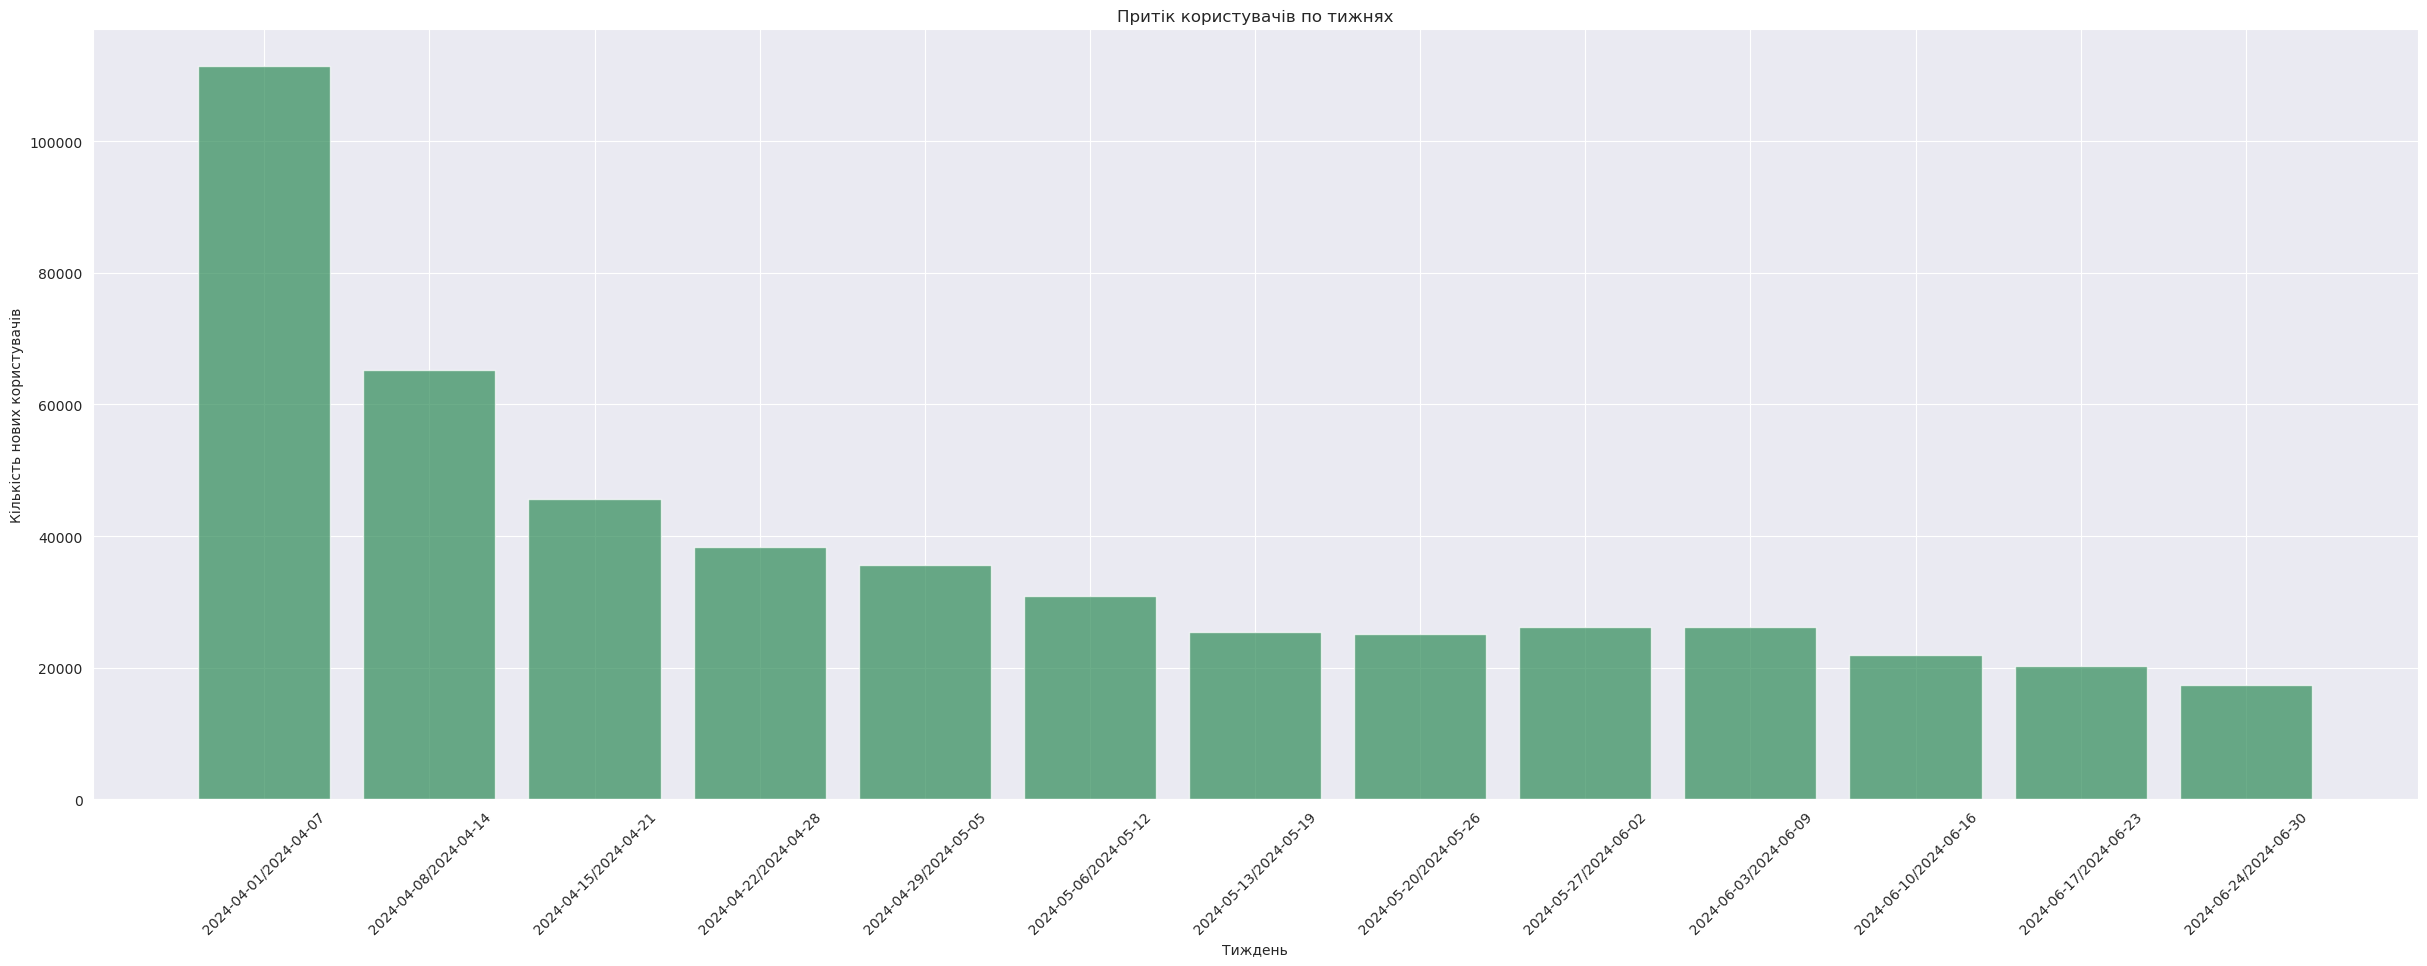

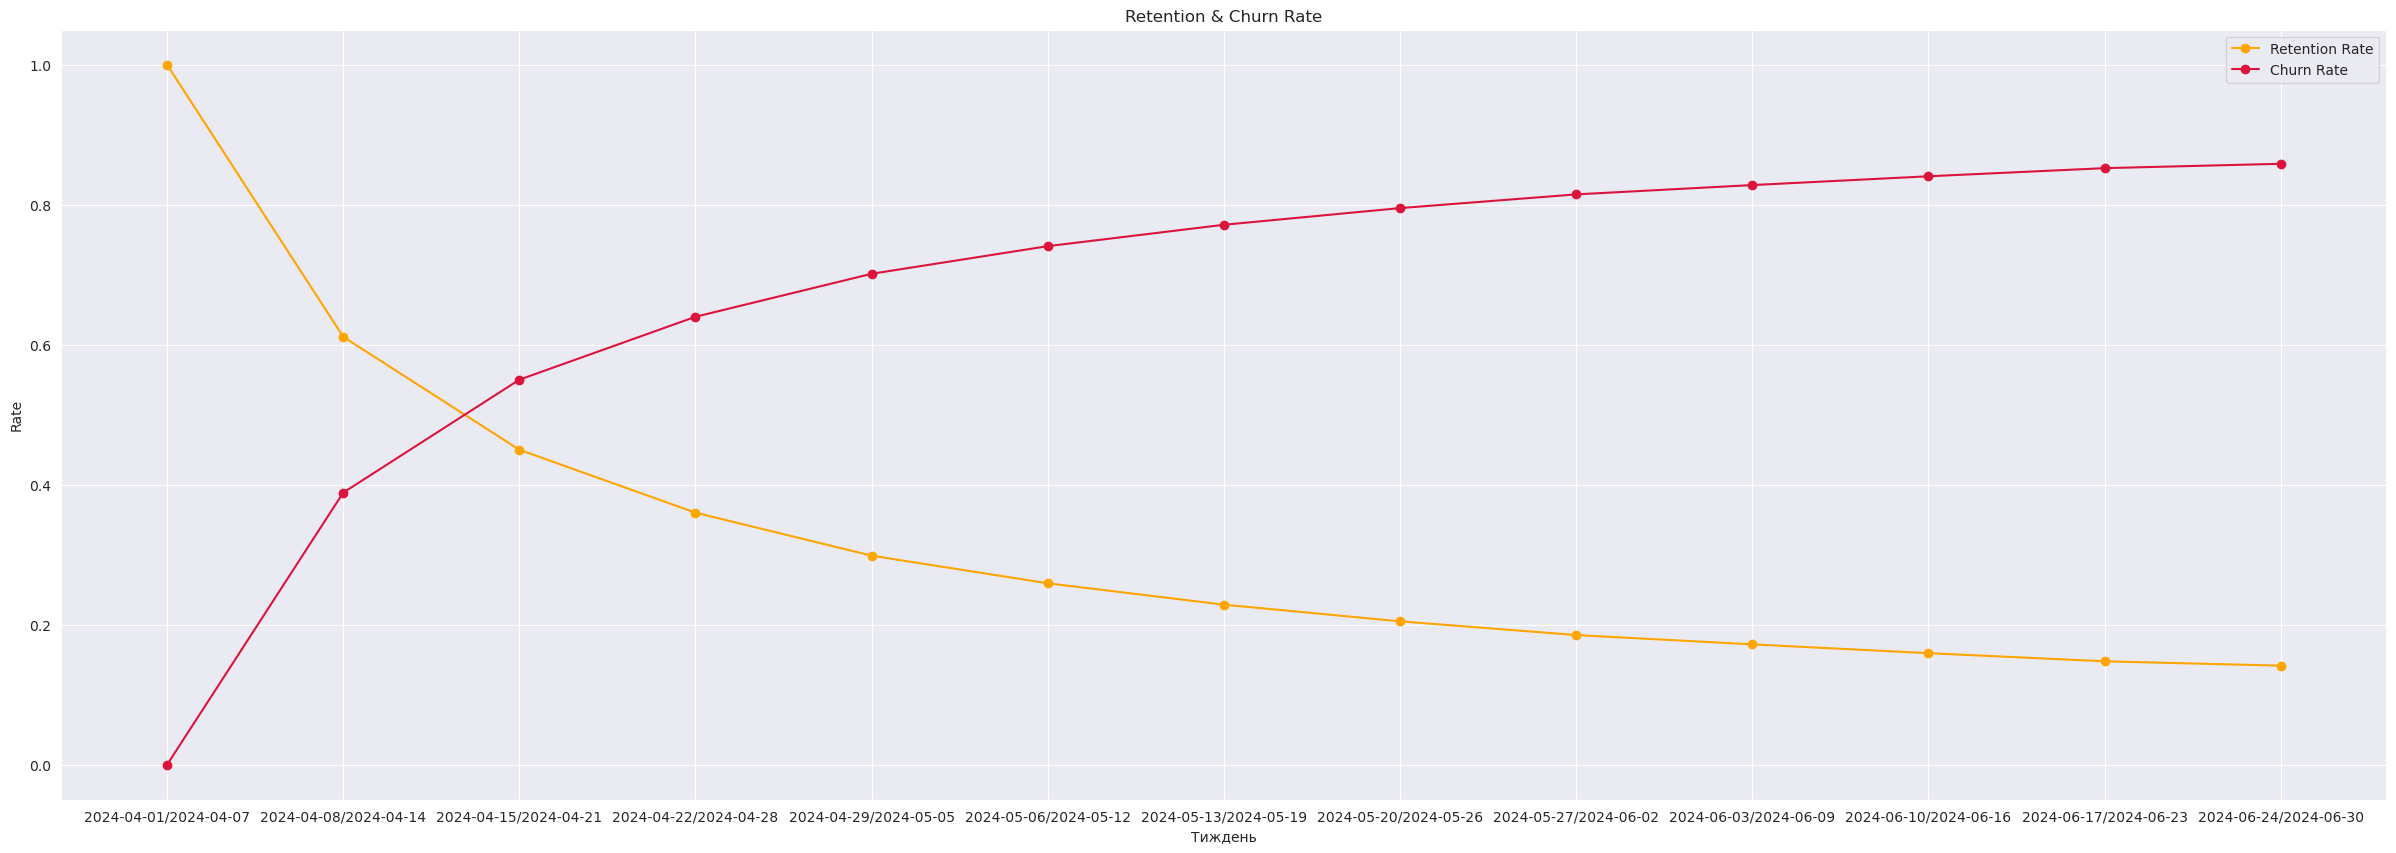

In [59]:
acquisition_analysis(df_cleaned)
calculate_churn_and_retention(df_cleaned)

Here, I tried to remove users who have records of reading completion without starting it (perhaps they started in another period and make long intervals), as they can distort the indicators of customer inflow and outflow. But as you can see, even without them, the indicators remain almost identical (which partially confirms the hypothesis that these are users who started in the past, because they behave the same way as other users)

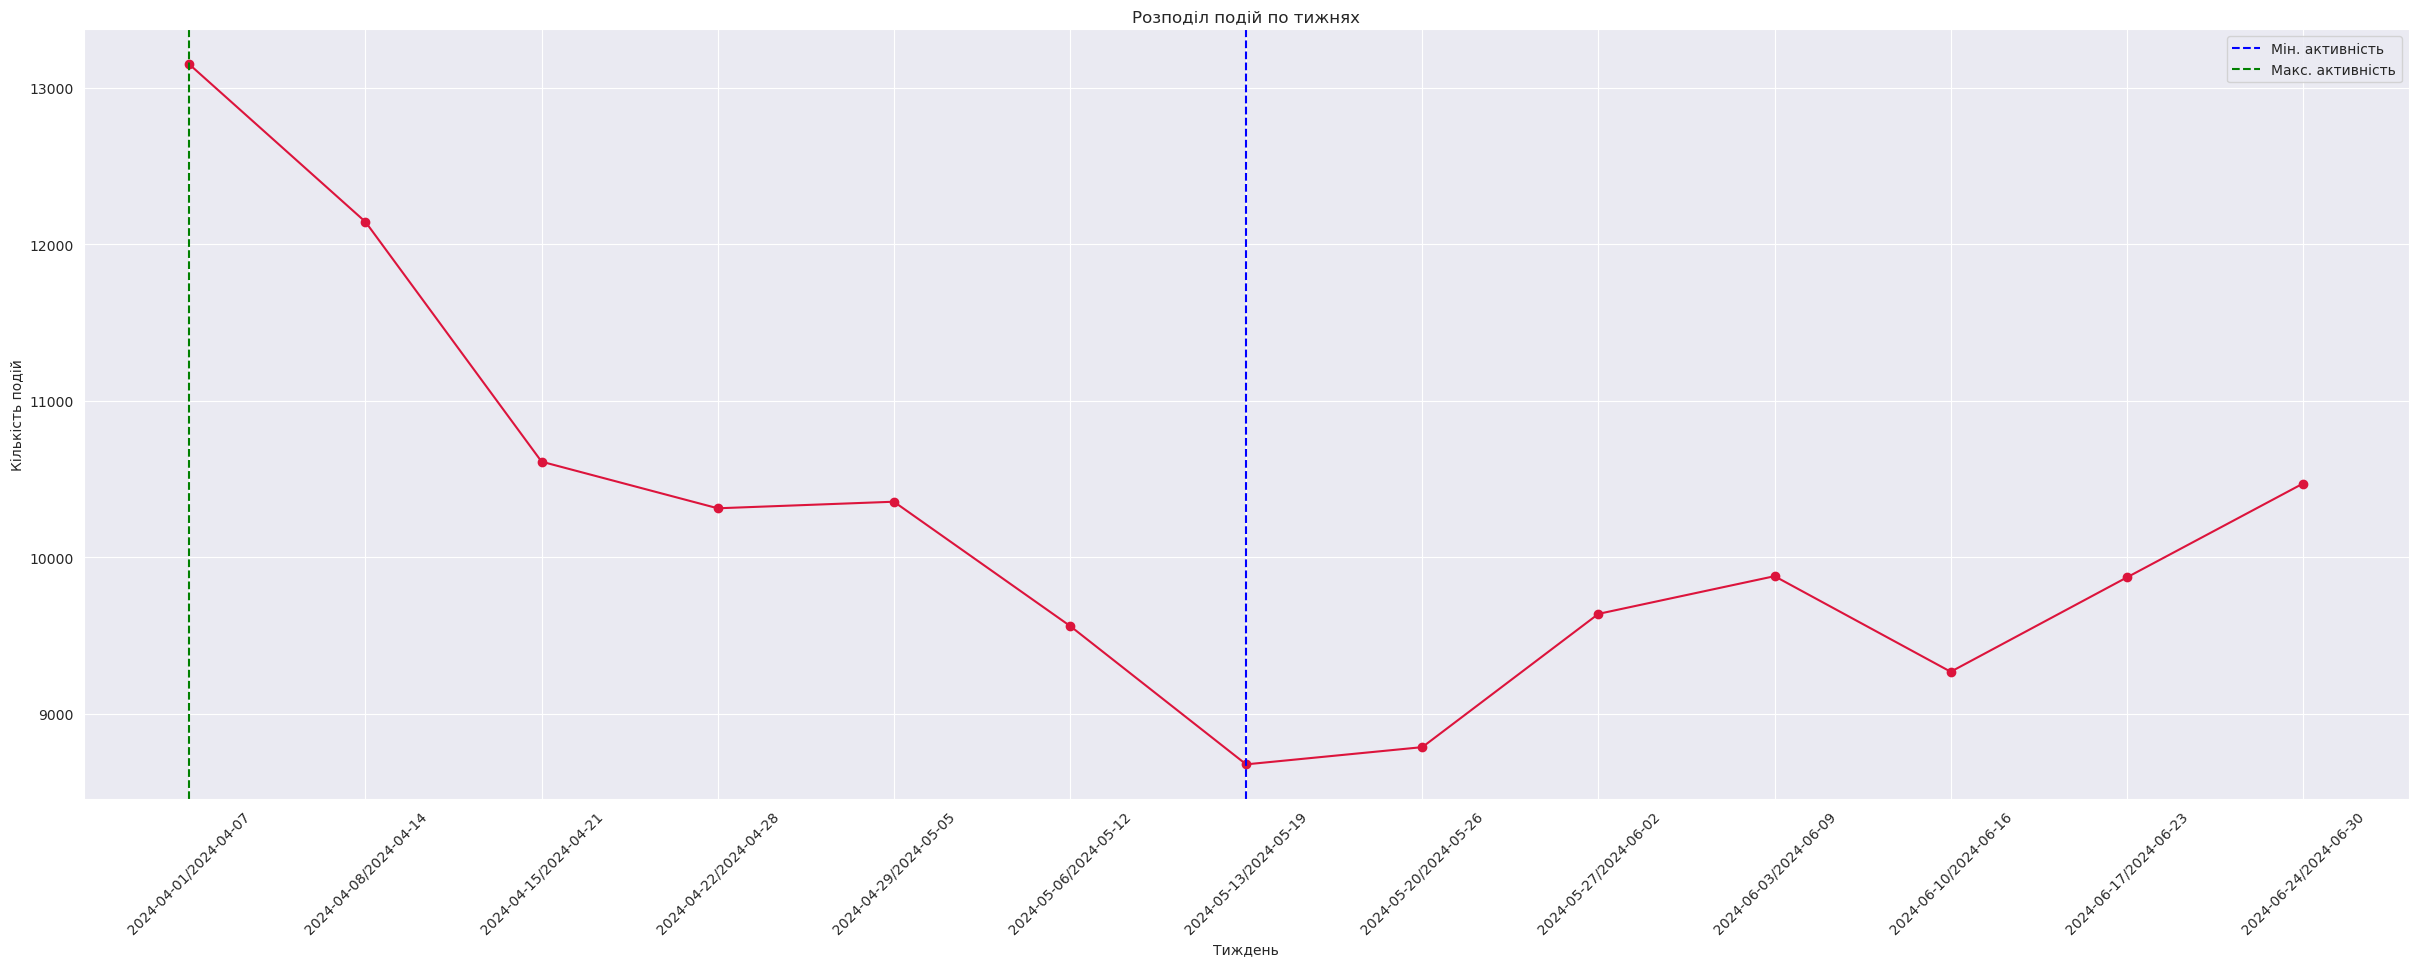

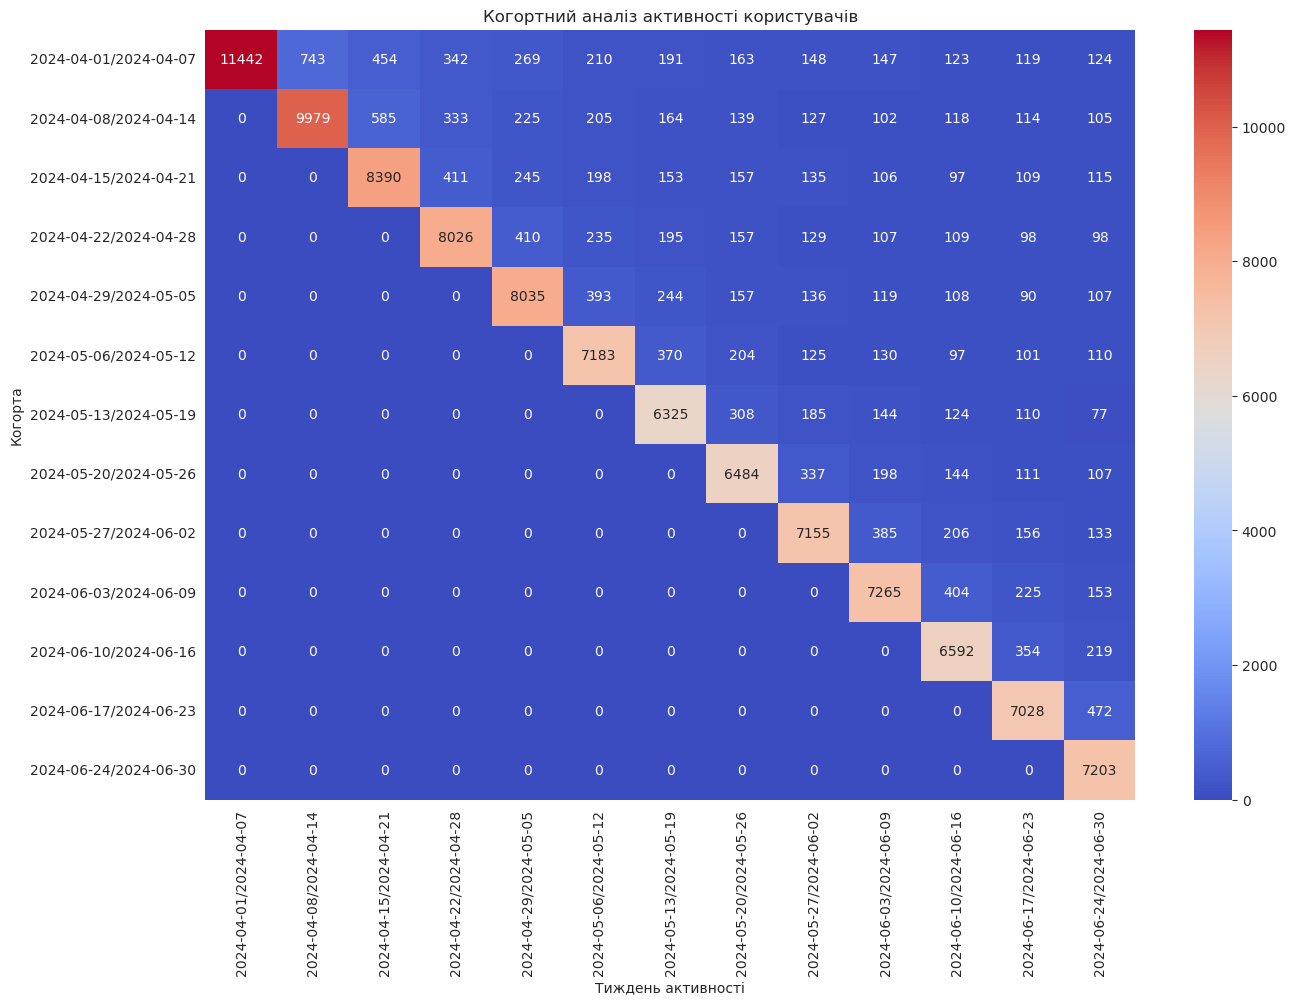

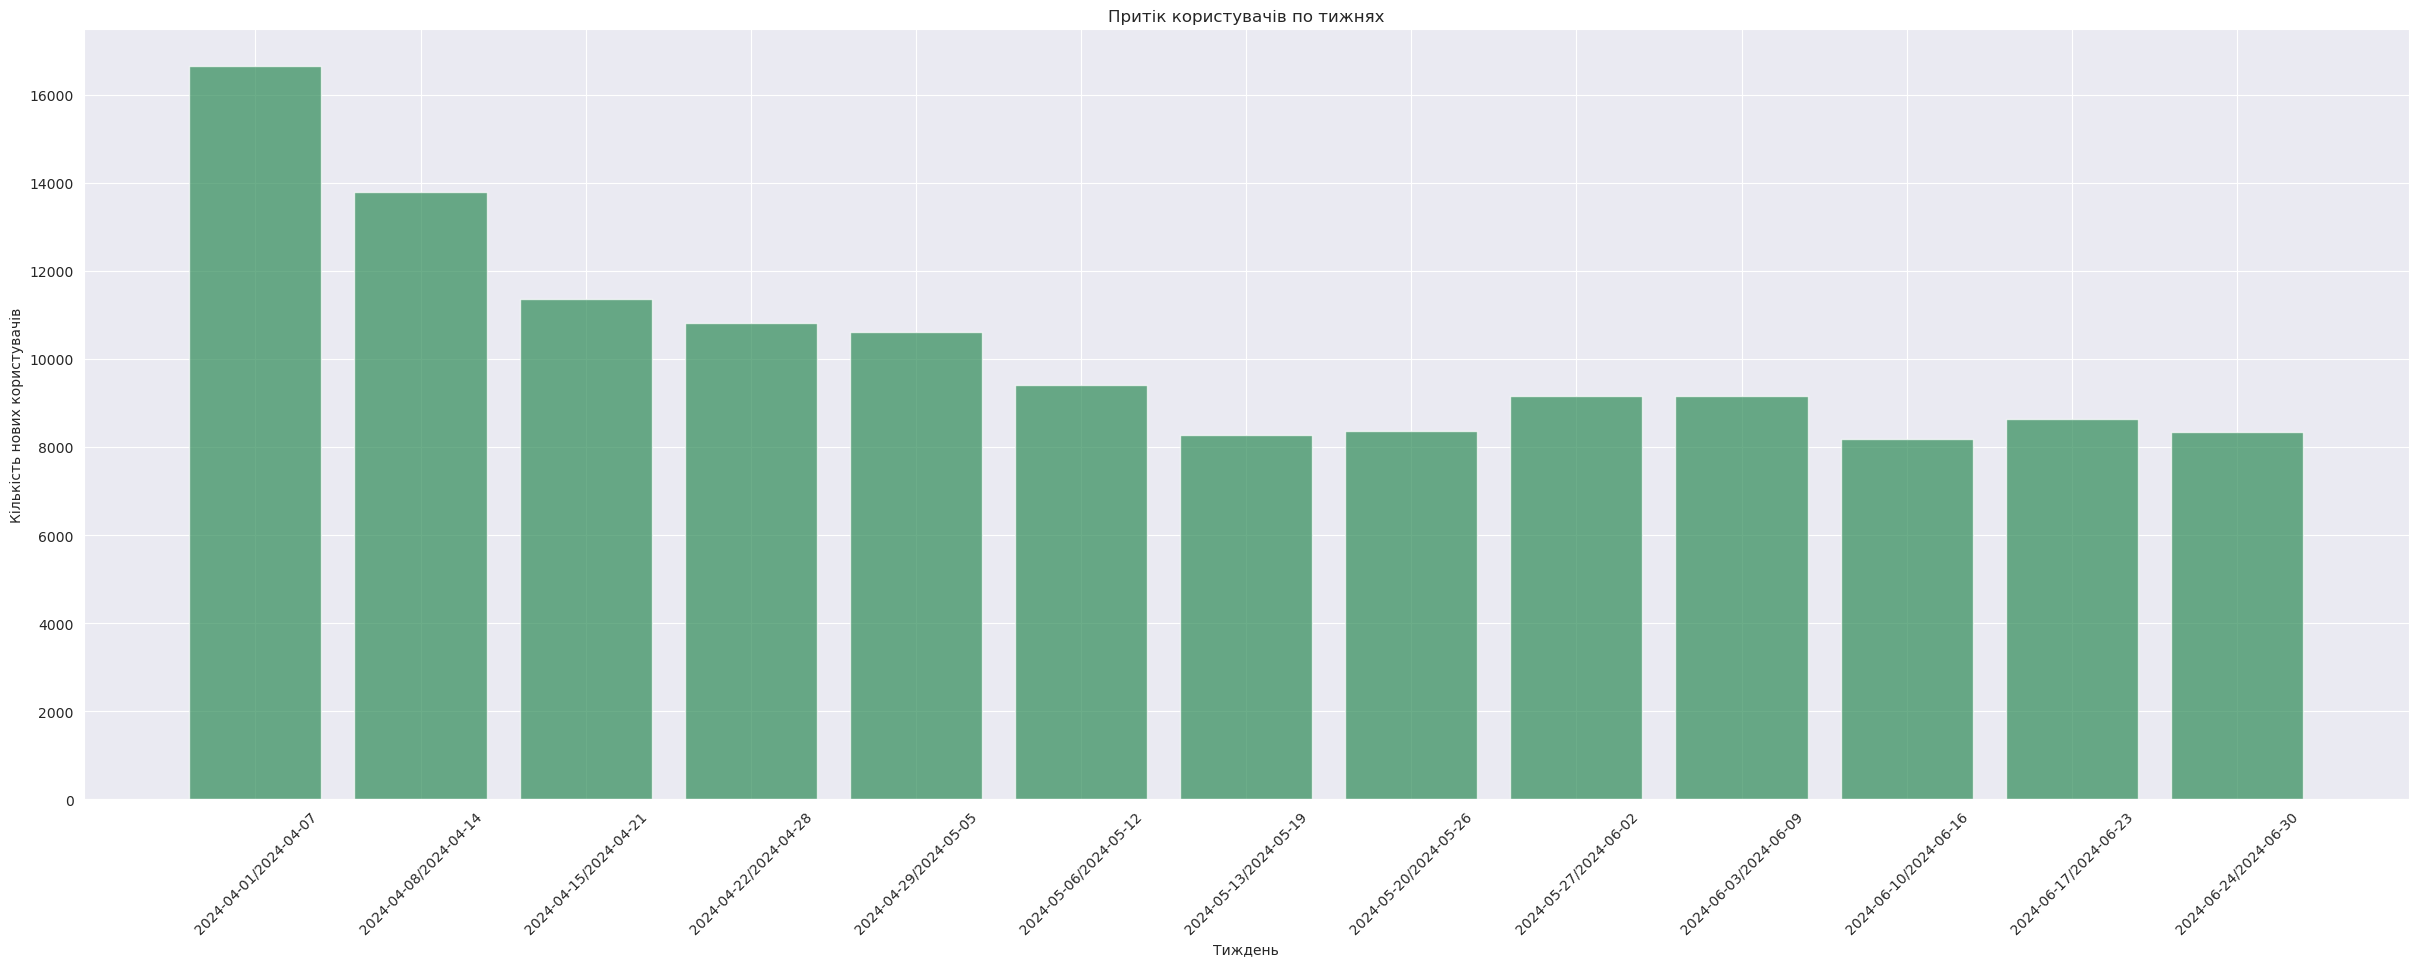

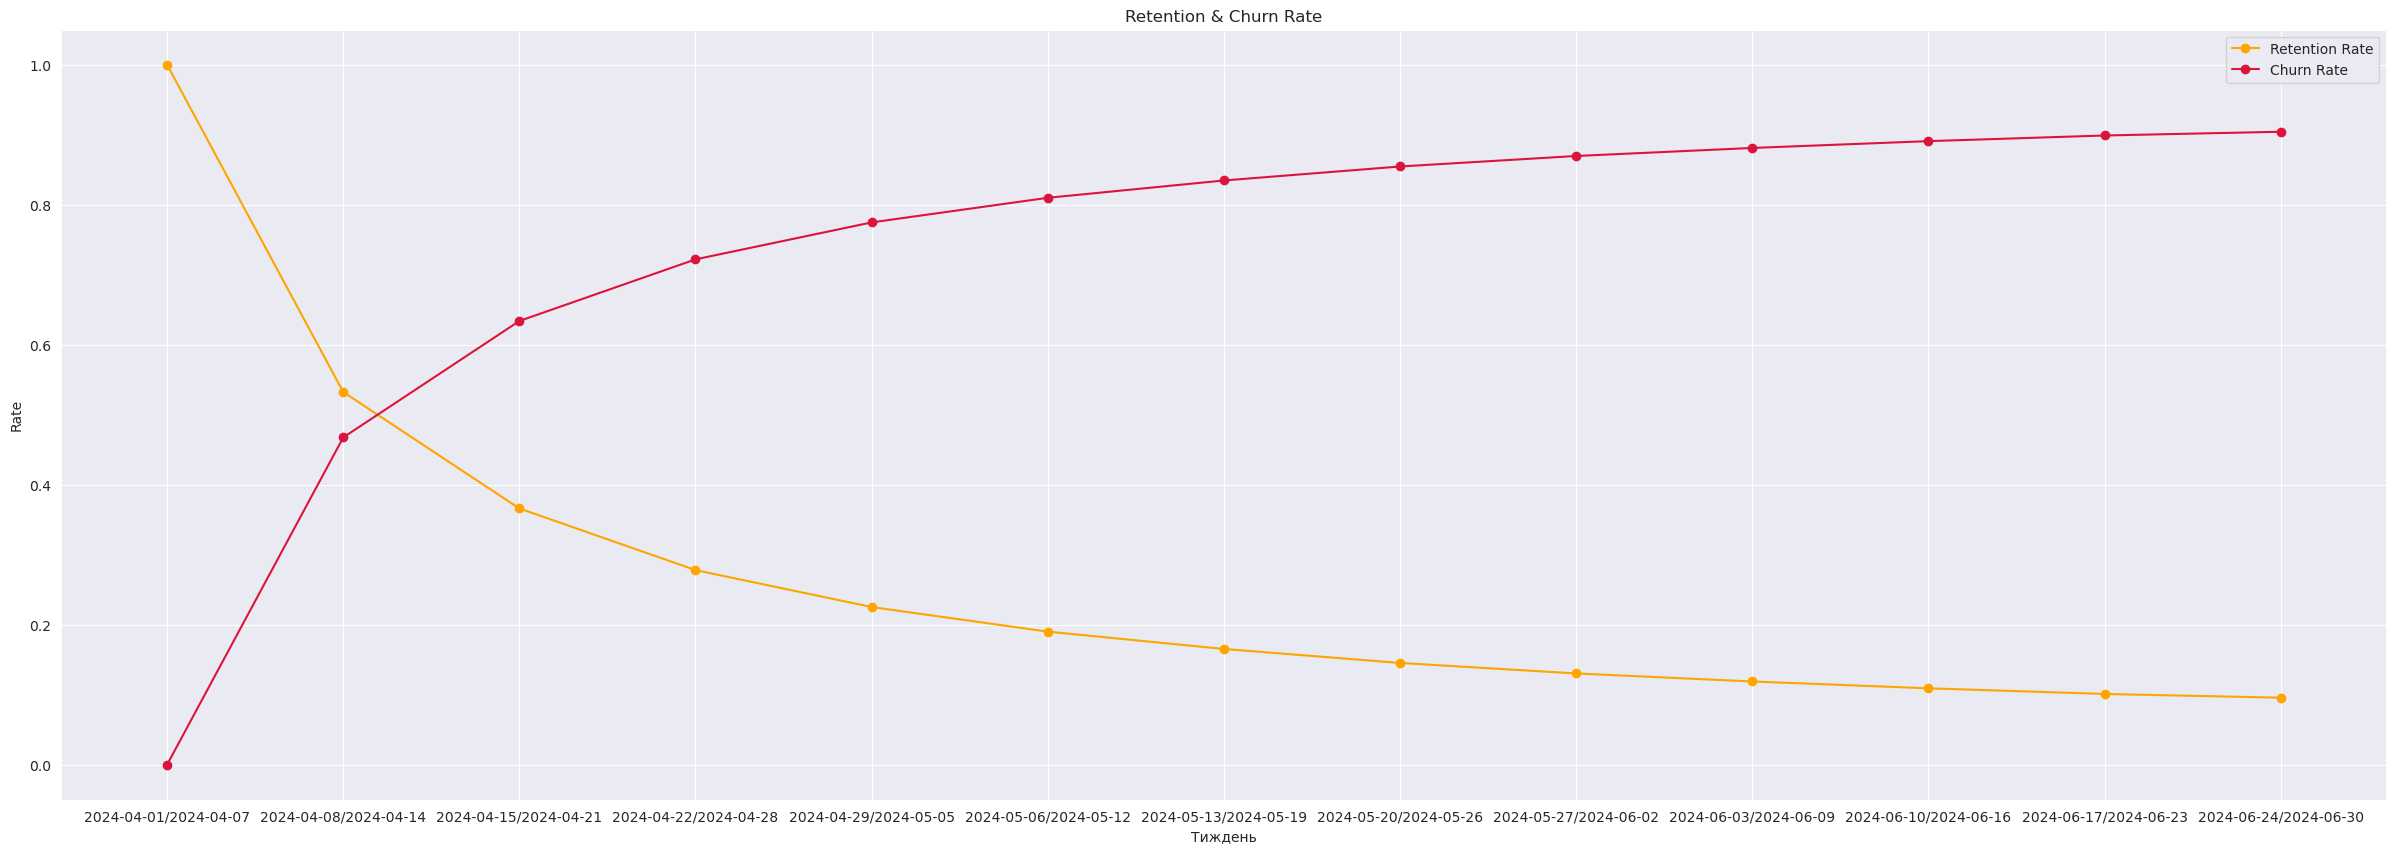

In [60]:
df_copy_test = df_cleaned.copy()
df_cleaned_filtered = filter_incomplete_users(df_copy_test)

analyze_activity_drop(df_cleaned_filtered)
acquisition_analysis(df_cleaned_filtered)
calculate_churn_and_retention(df_cleaned_filtered)

In [95]:
stickiness_ratio = calculate_stickiness_ratio(df_cleaned)
print(f"Stickiness Ratio: {stickiness_ratio}")

Stickiness Ratio: 0.05


##### Seasonality check

Earlier we saw that there is a weekly seasonality in the data, so it's worth trying to find out why (the most active days are Tuesday and Wednesday, the most inactive days are Saturday and Sunday, respectively)

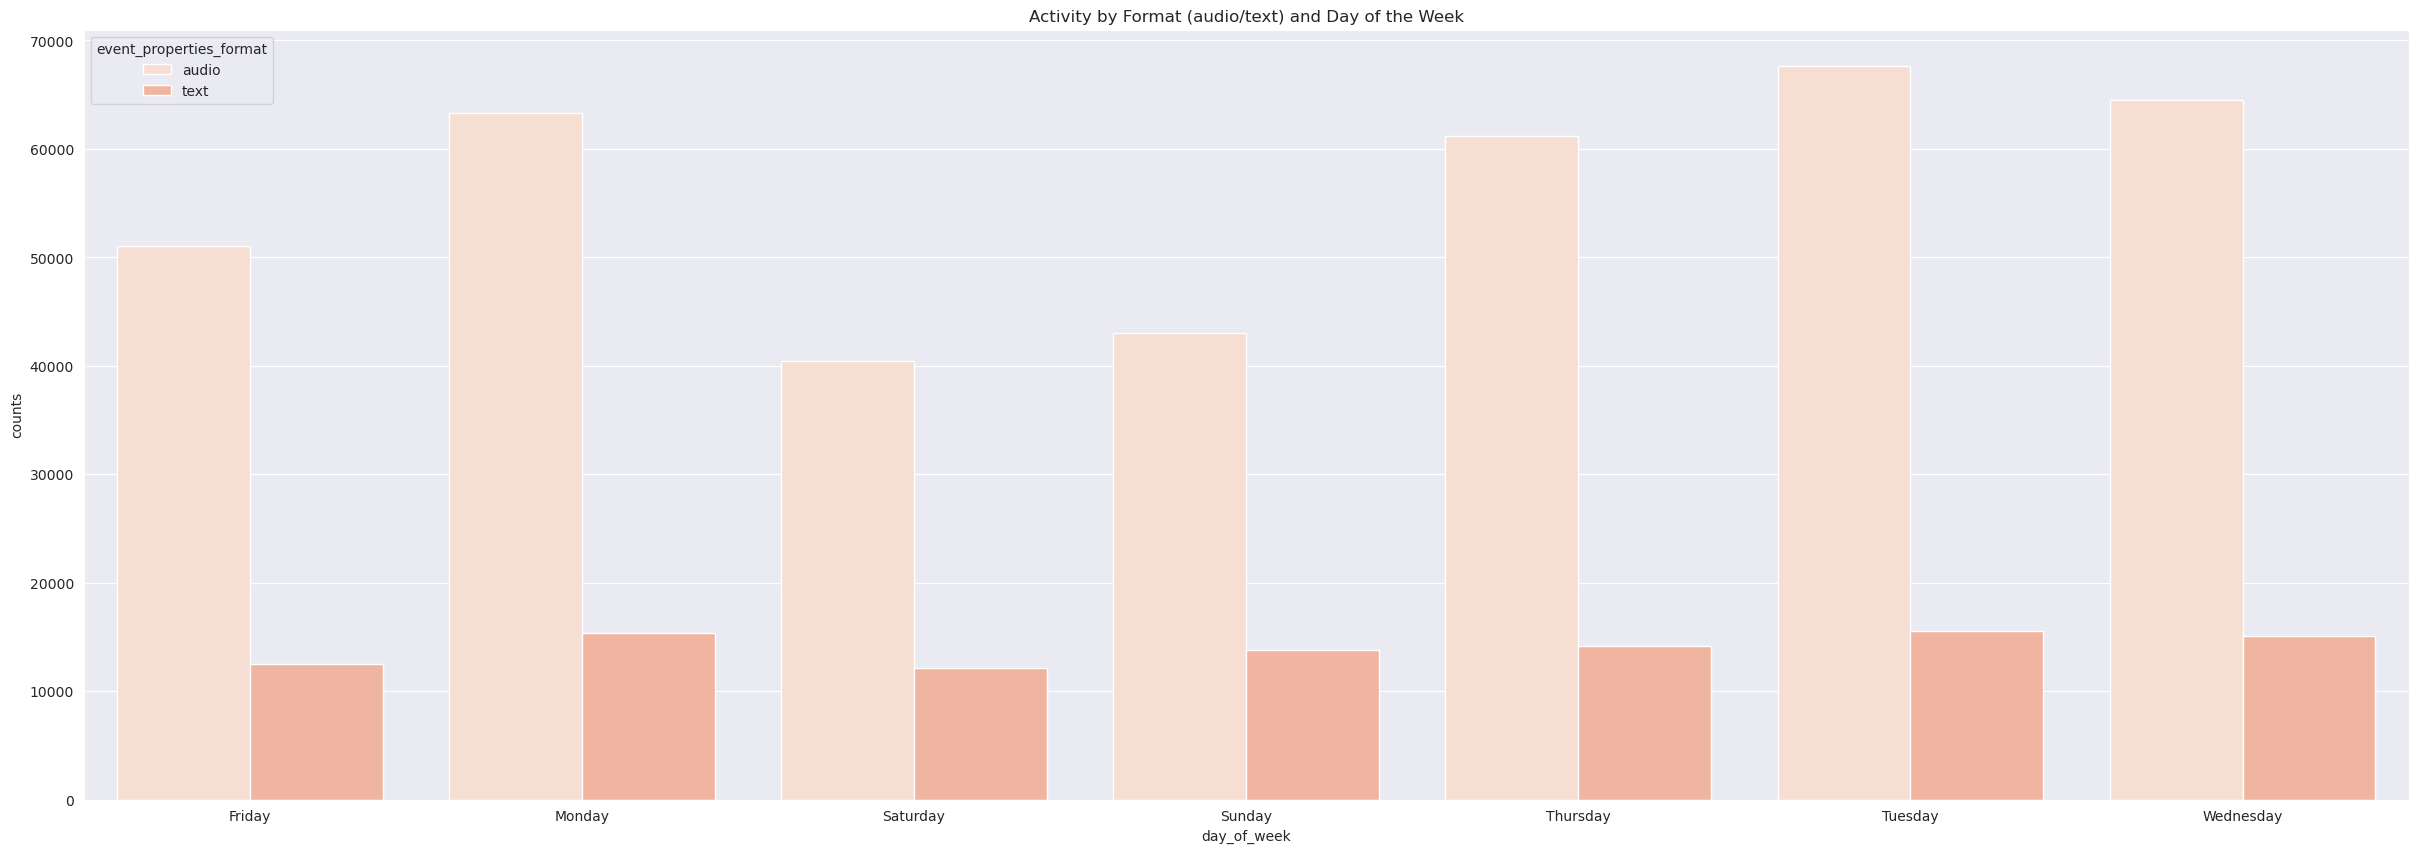

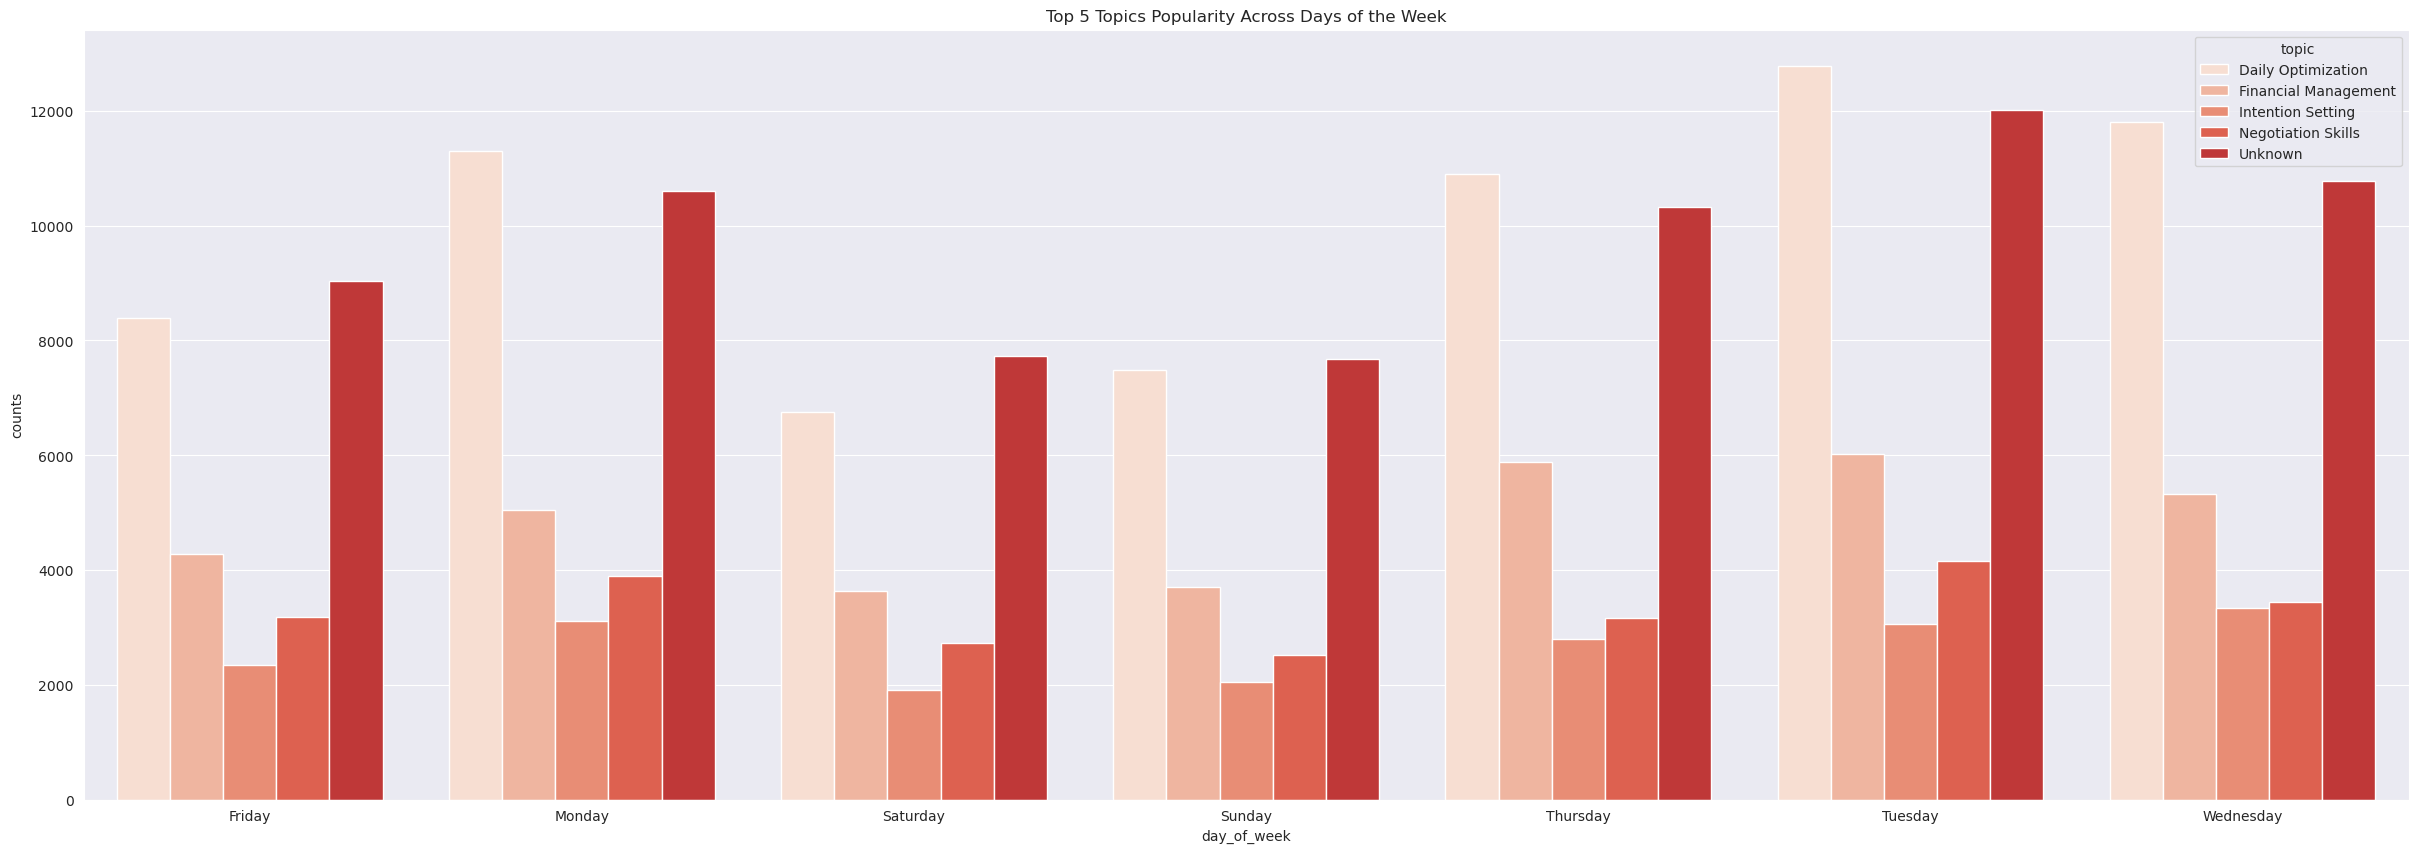

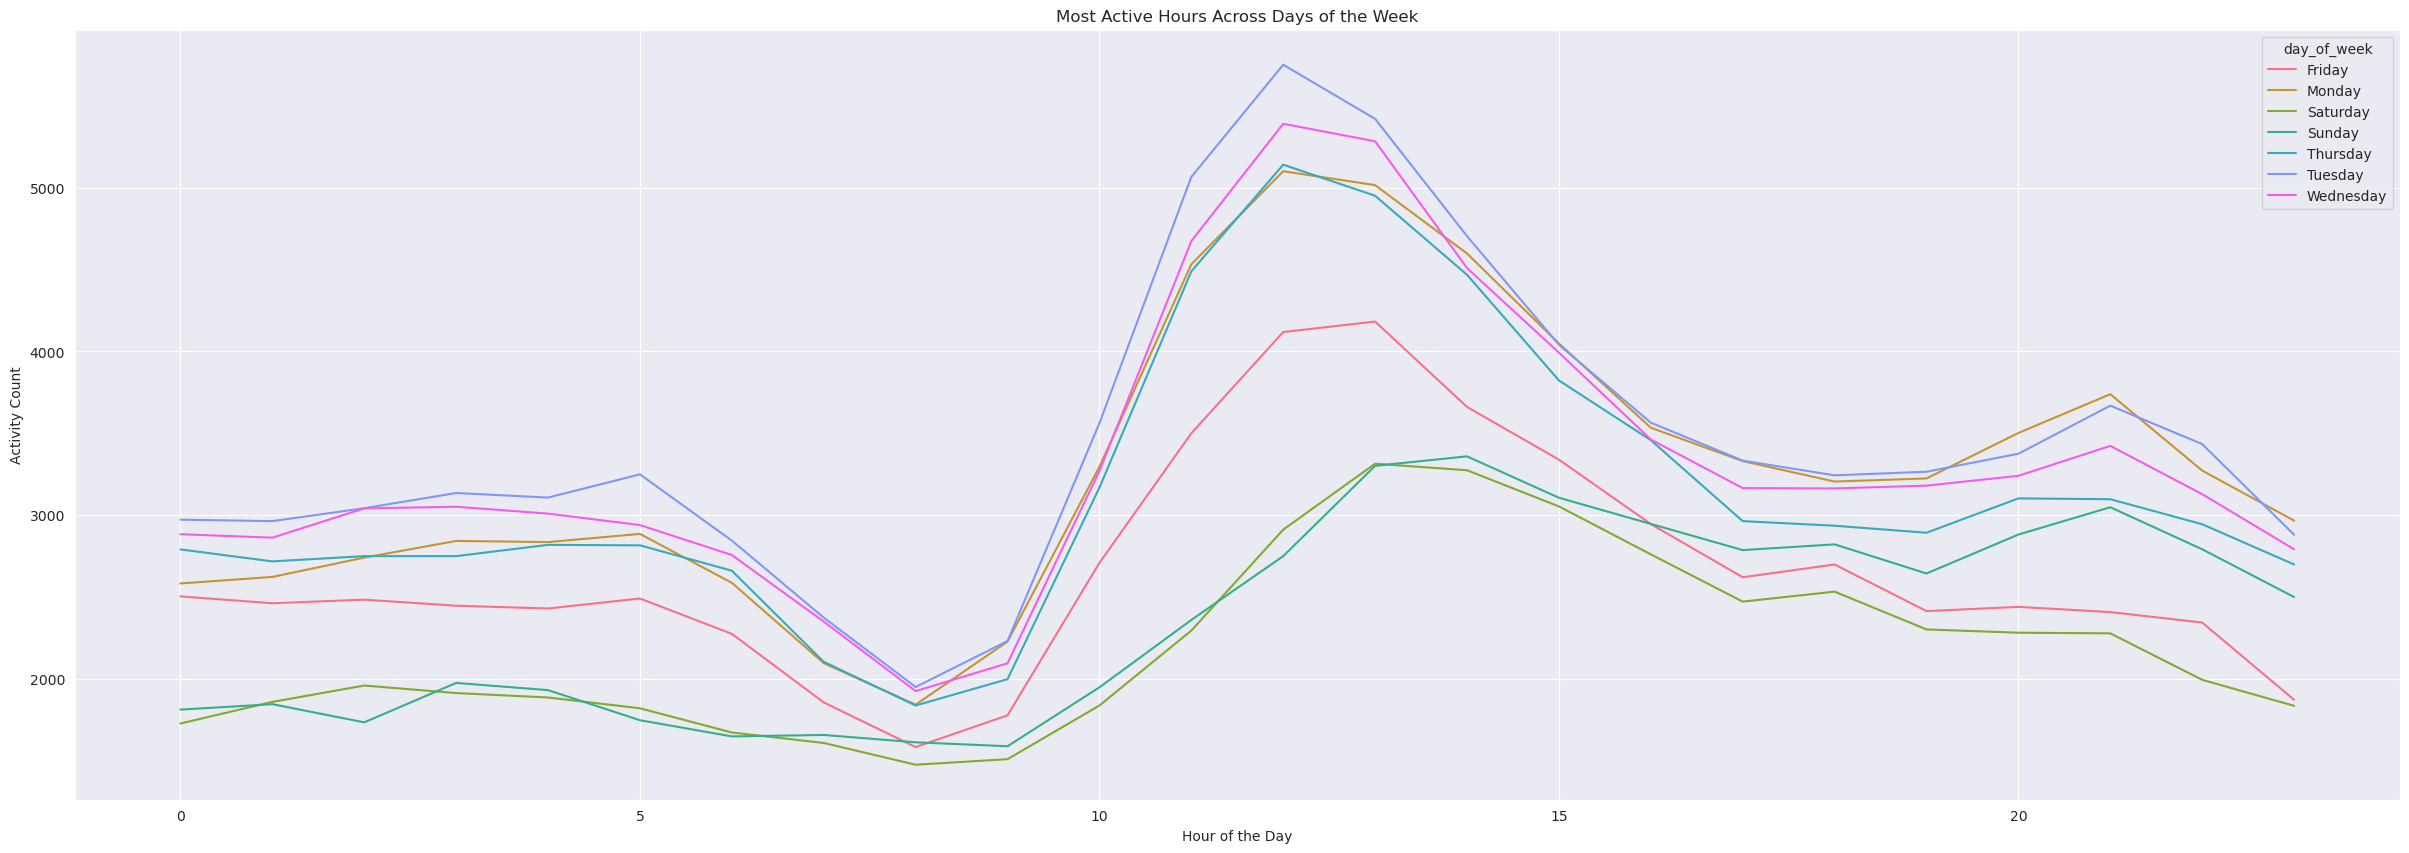

In [61]:
ses_1 = sesonal_prepare(df_cleaned)

plot_activity_by_format(ses_1)
plot_topic_popularity(ses_1)
plot_peak_hours(ses_1)

As we can see, there is no clear reason for this seasonality. A wider range of data may be needed to study this issue in more detail

#### Changing age data

##### Distributions

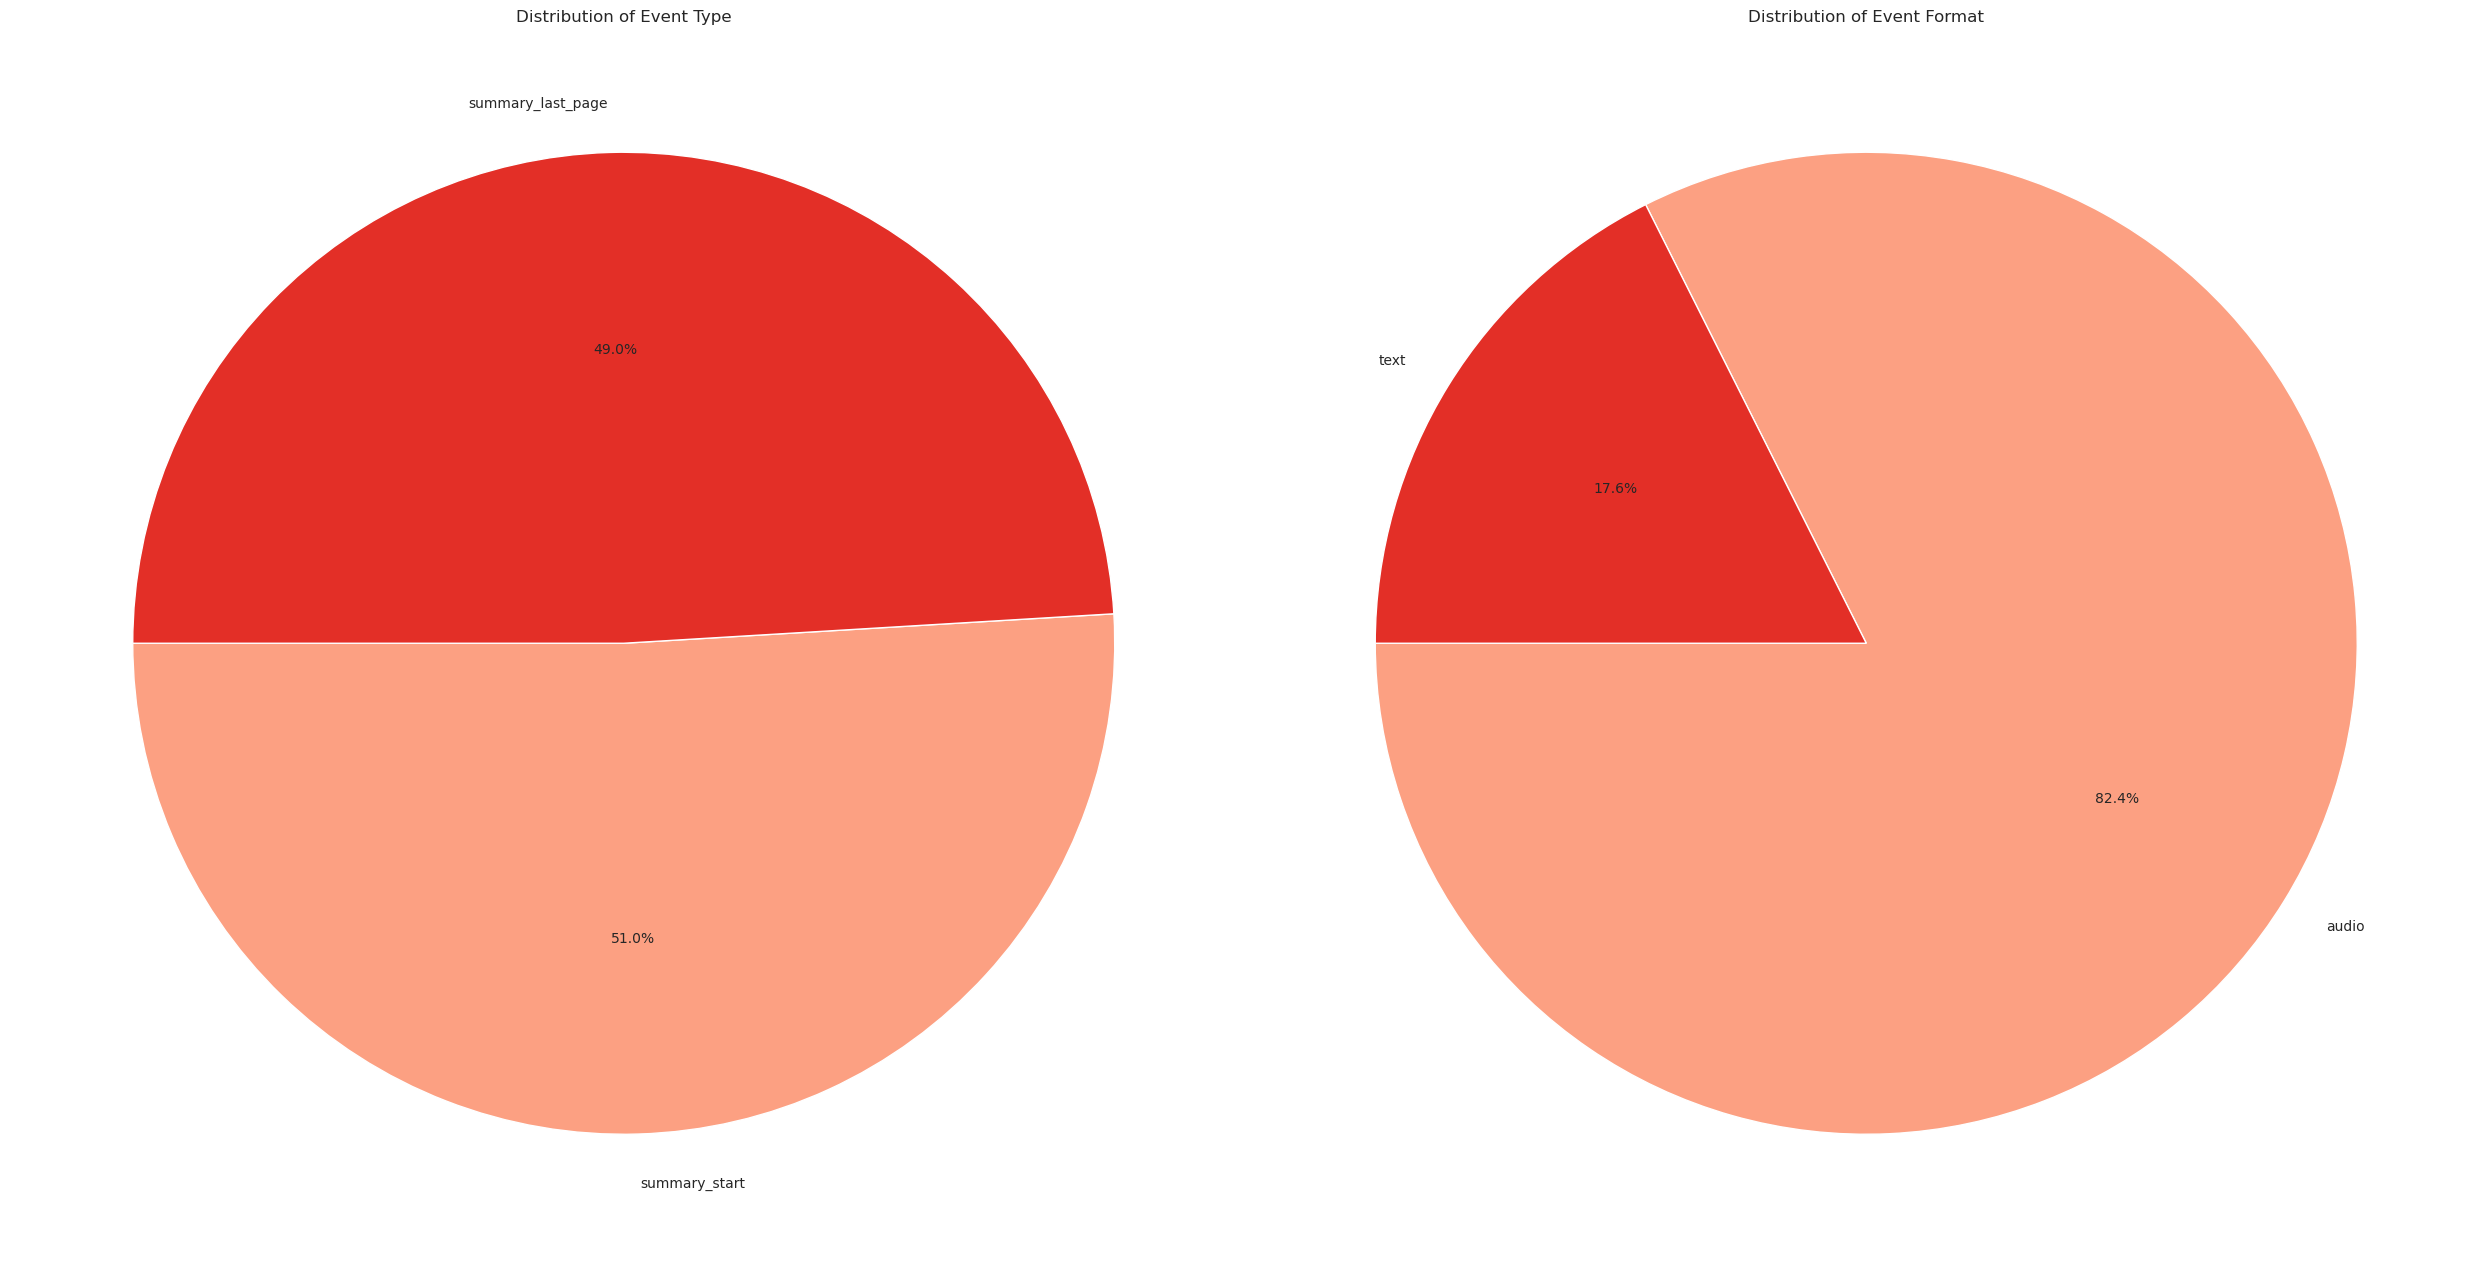

In [62]:
plot_event_distributions(users_with_age_changes)

Very similar to the general data


Unique user-book pairs: 342063
Books fully tracked (started and completed): 14930
Total books started: 183783
Estimated completion rate: 8.12%
Records with 'summary_last_page' but no 'summary_start': 161756
Unique users with only 'summary_last_page': 11140


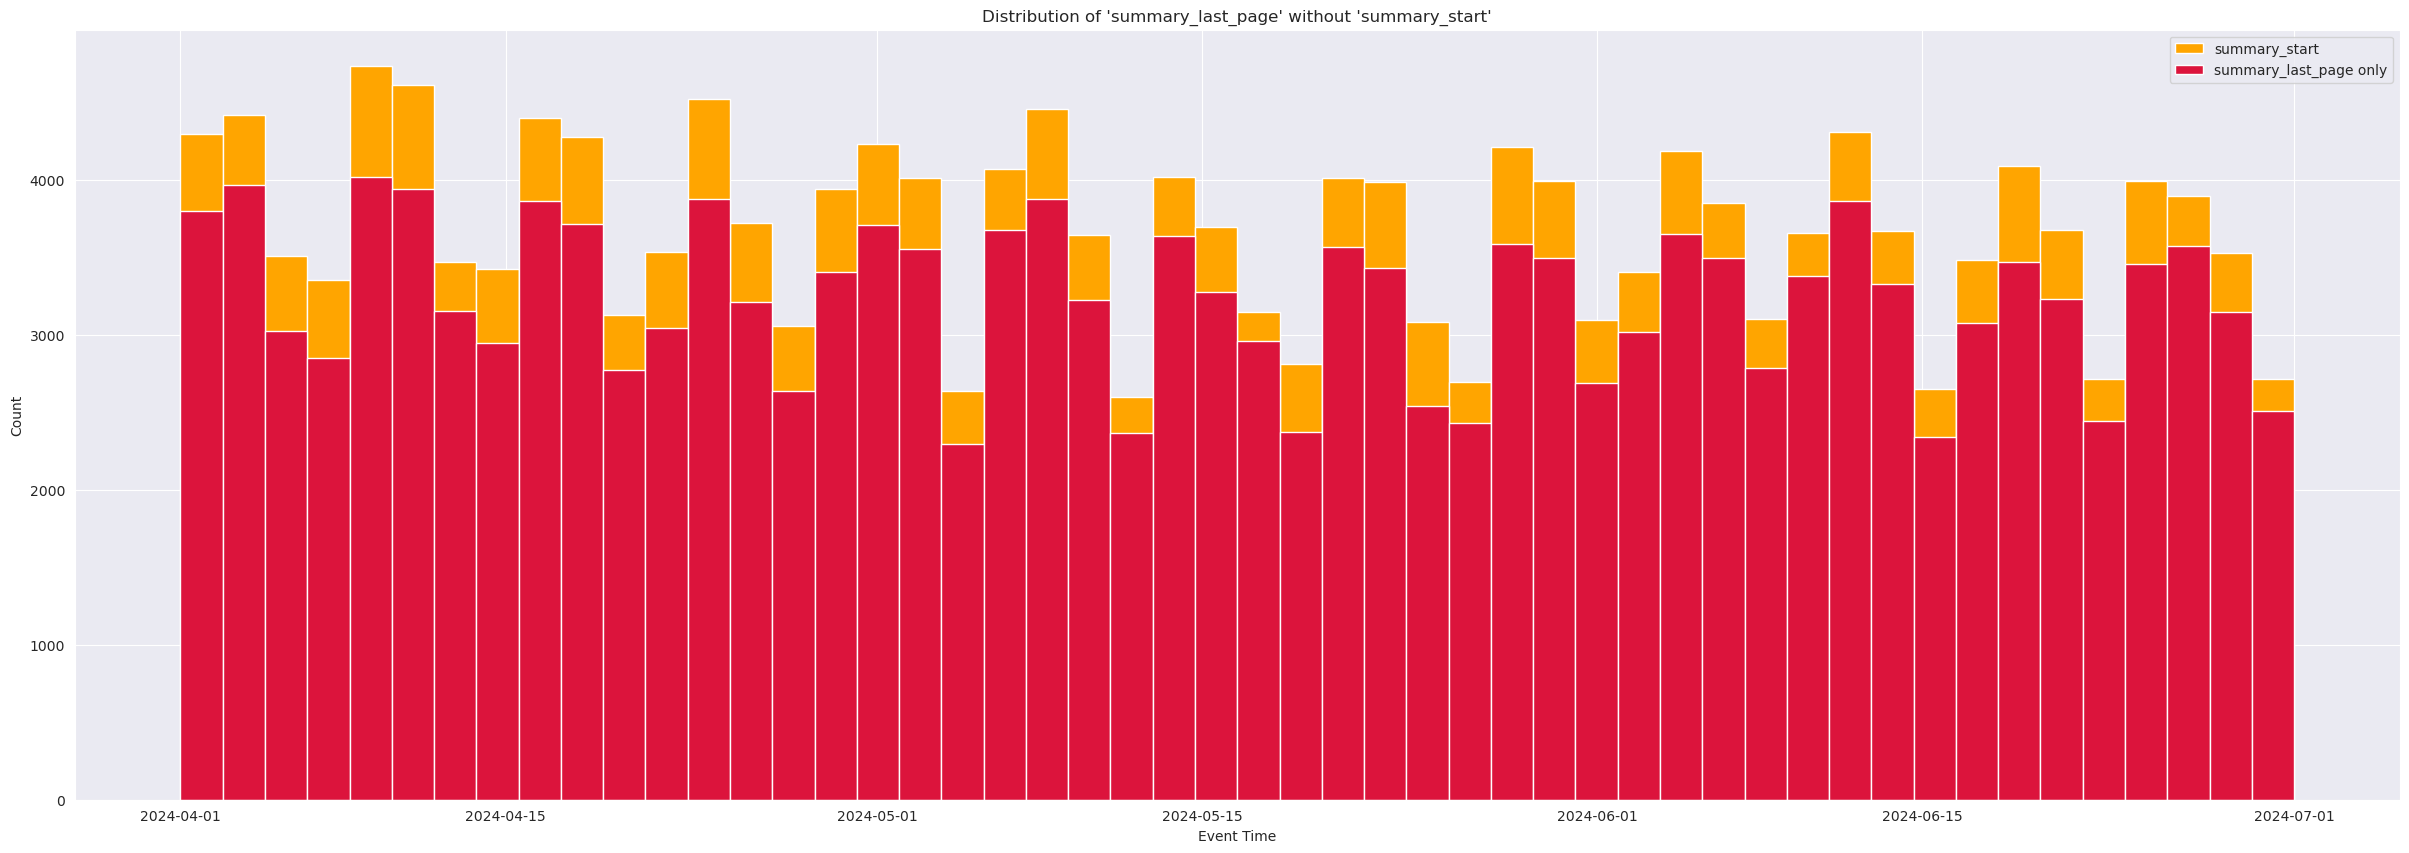

In [63]:
analyze_book_completion(users_with_age_changes)

By most parameters, it coincides with the general data (in percentage terms). However, there is a slightly higher level of reading the text, which may be due to the higher activity of this group

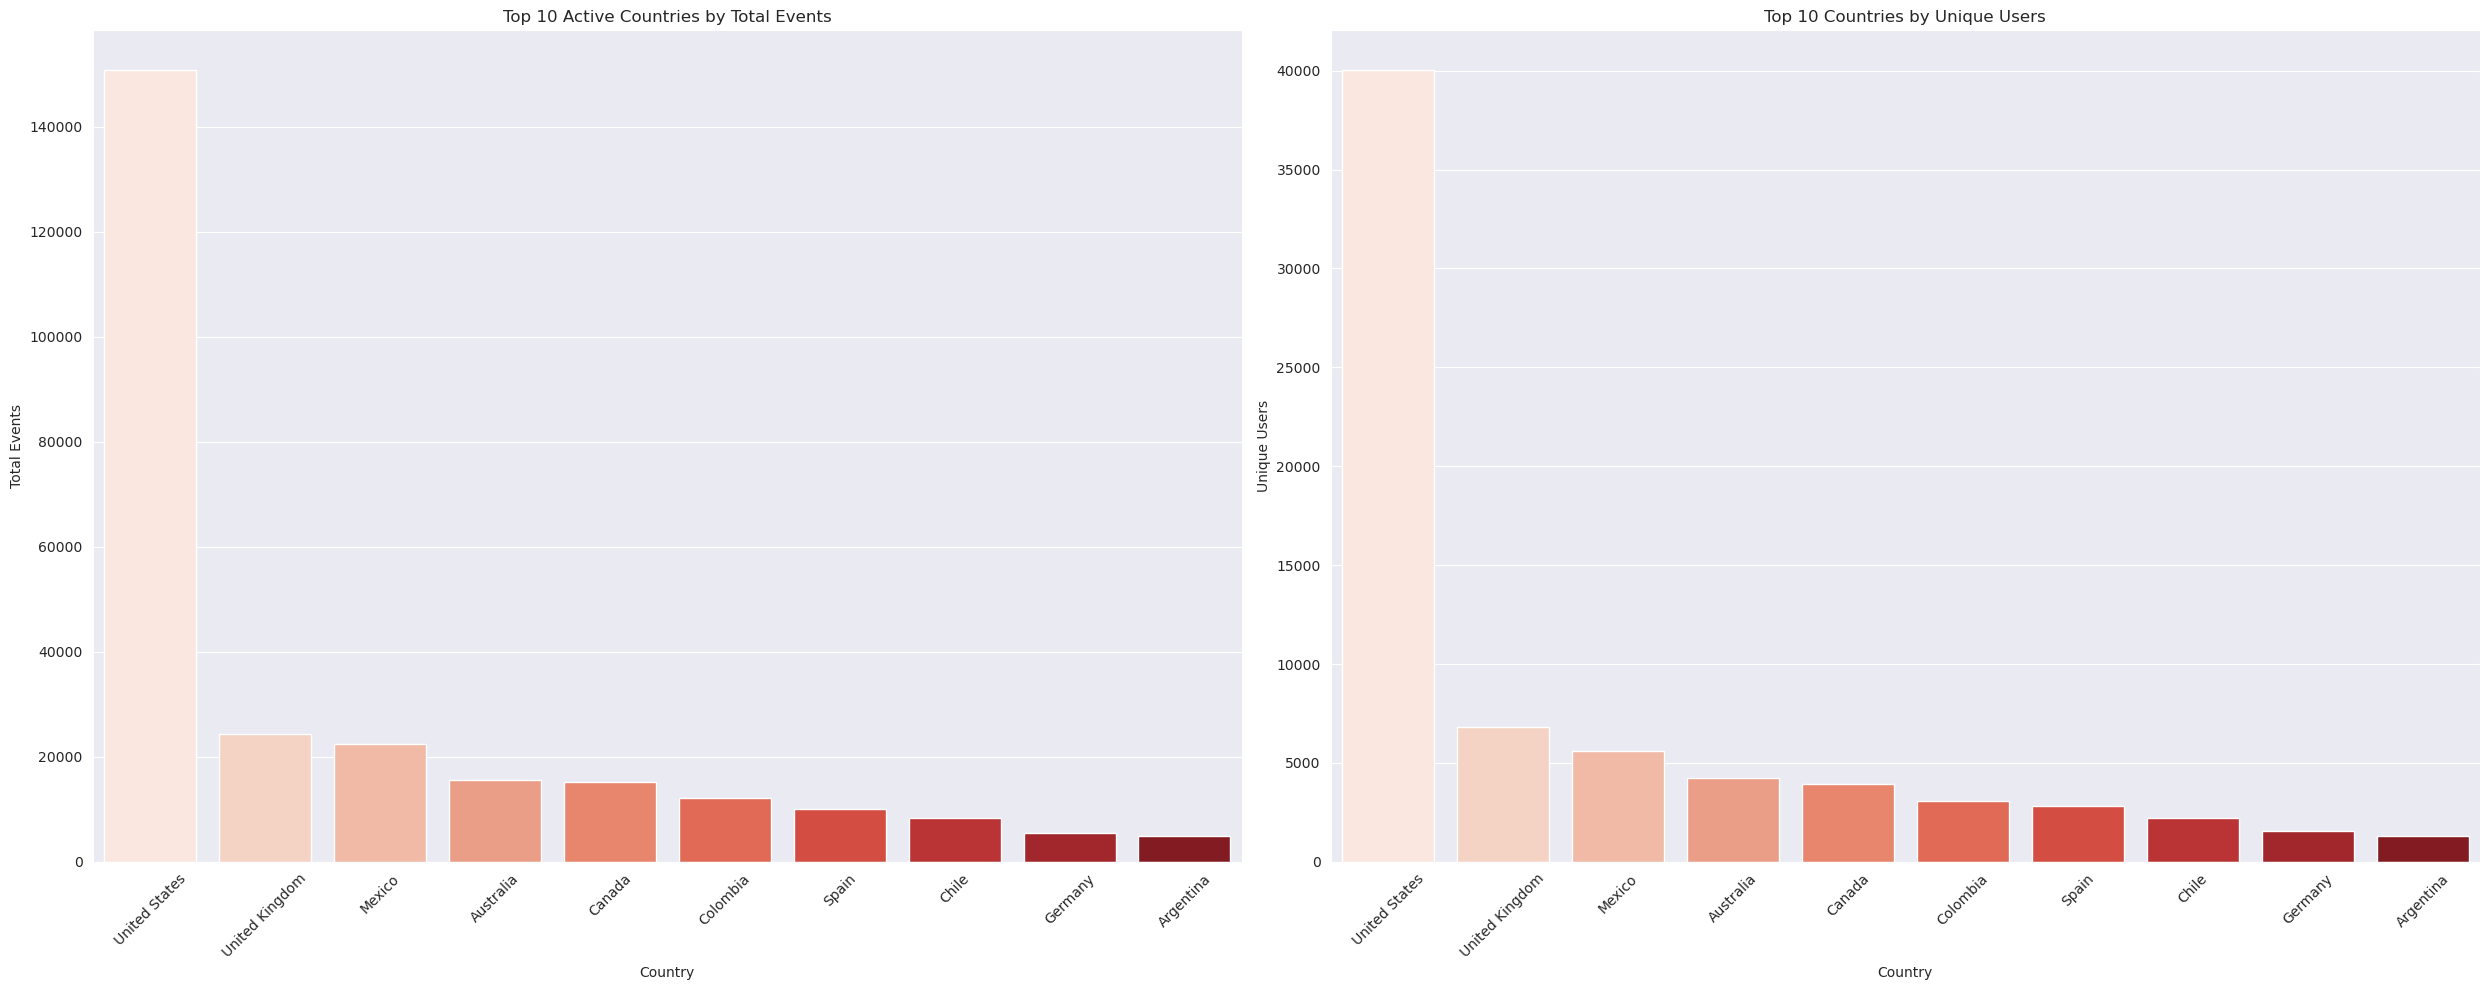

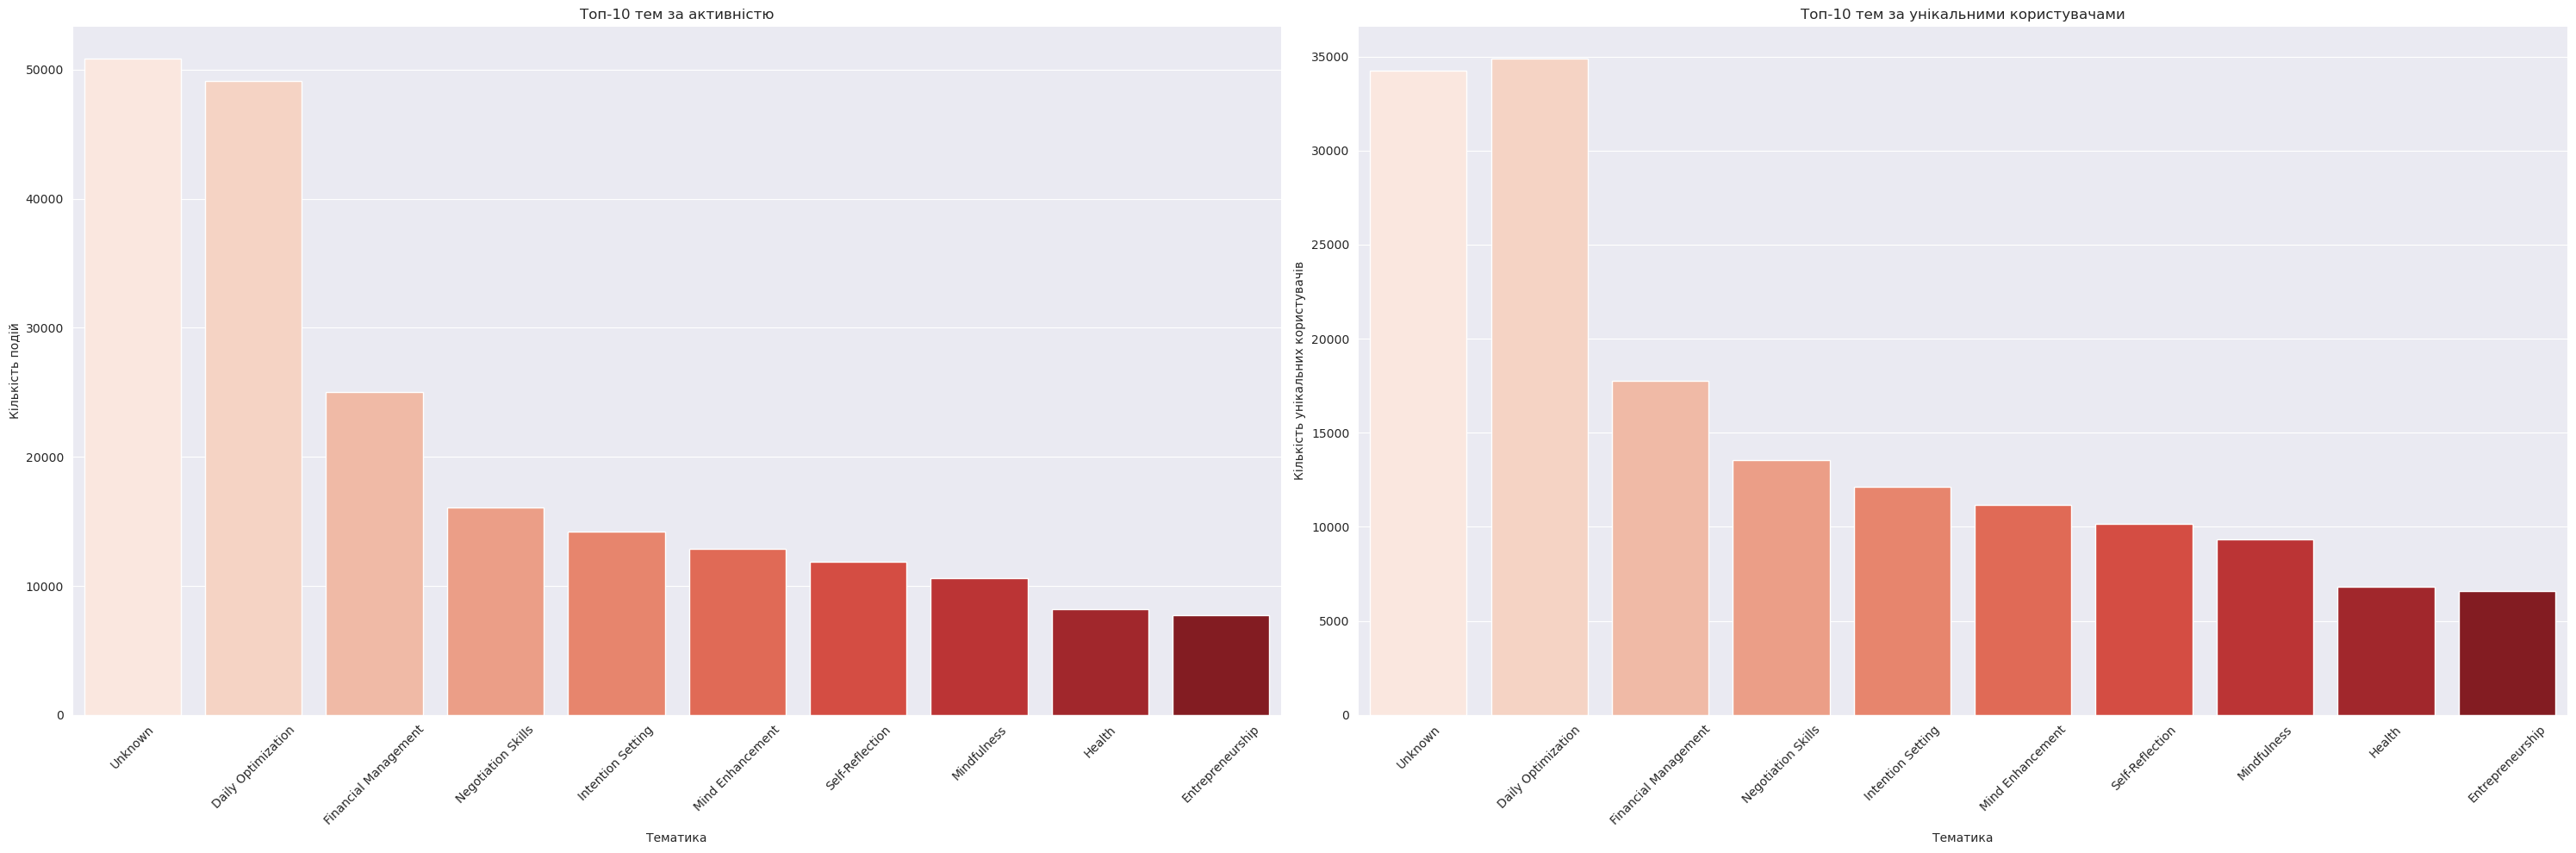

In [64]:
plot_country_activity(users_with_age_changes)
plot_topic_distribution(users_with_age_changes)

Very similar to general  (Unknow topic a has a little bigger part)

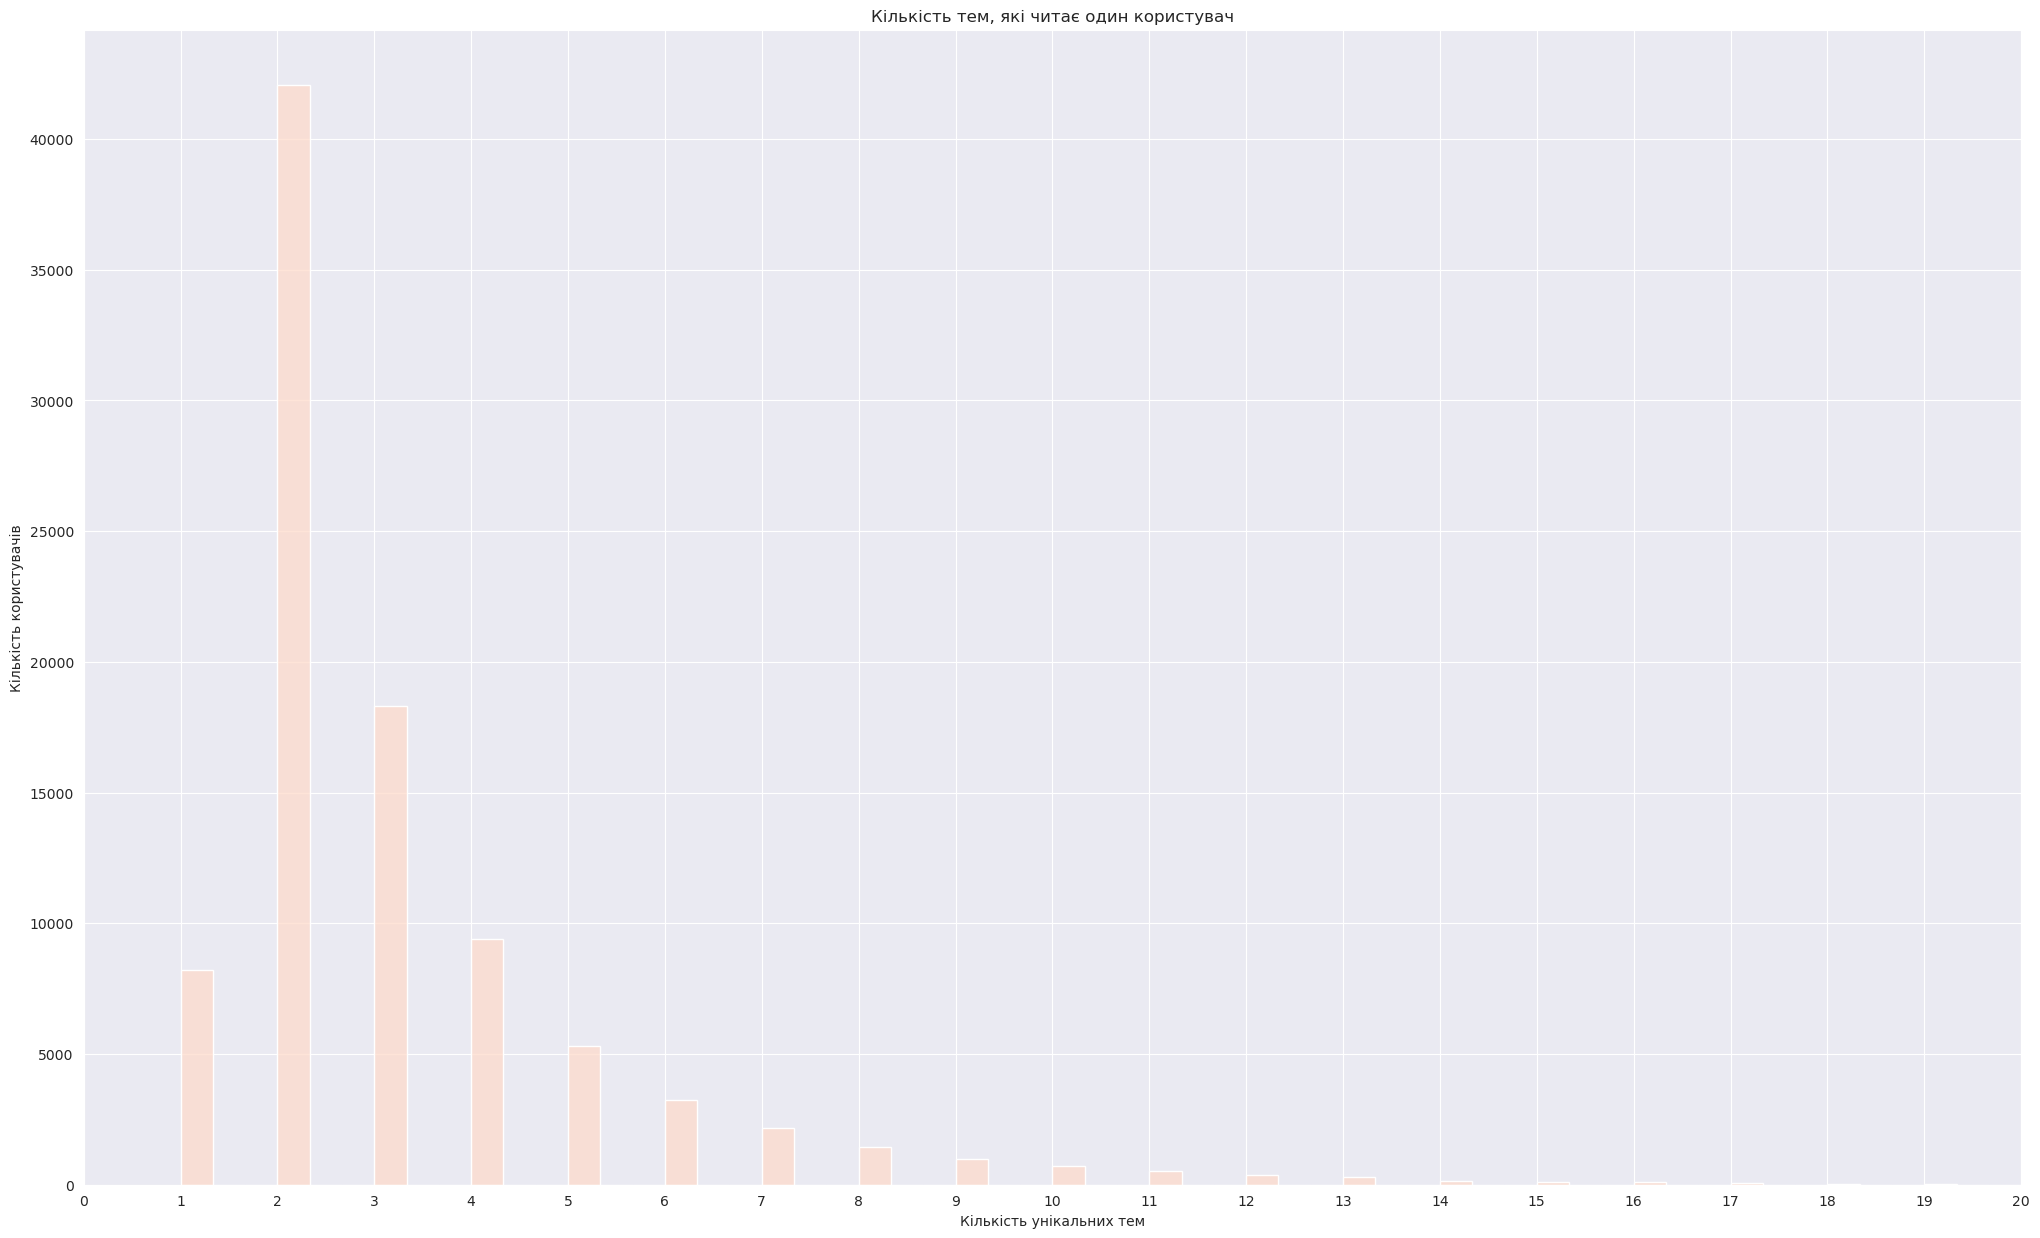

In [65]:
topic_number_by_user(users_with_age_changes)

This group of users prefer two or more topic to read

##### Hours Activity Time differences between reading summary

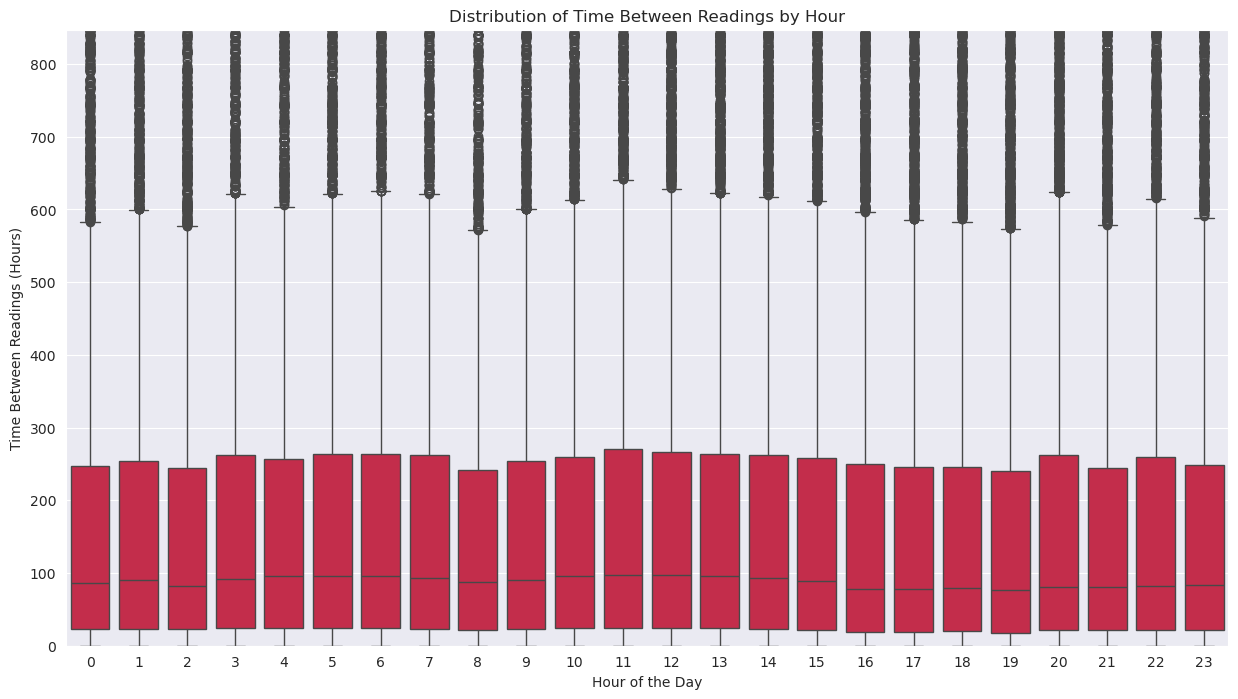

In [66]:
df_copy2, user_daily_reads2 = prepare_user_reading_data(users_with_age_changes)
plot_time_diff_by_hour(df_copy2)

Same as general

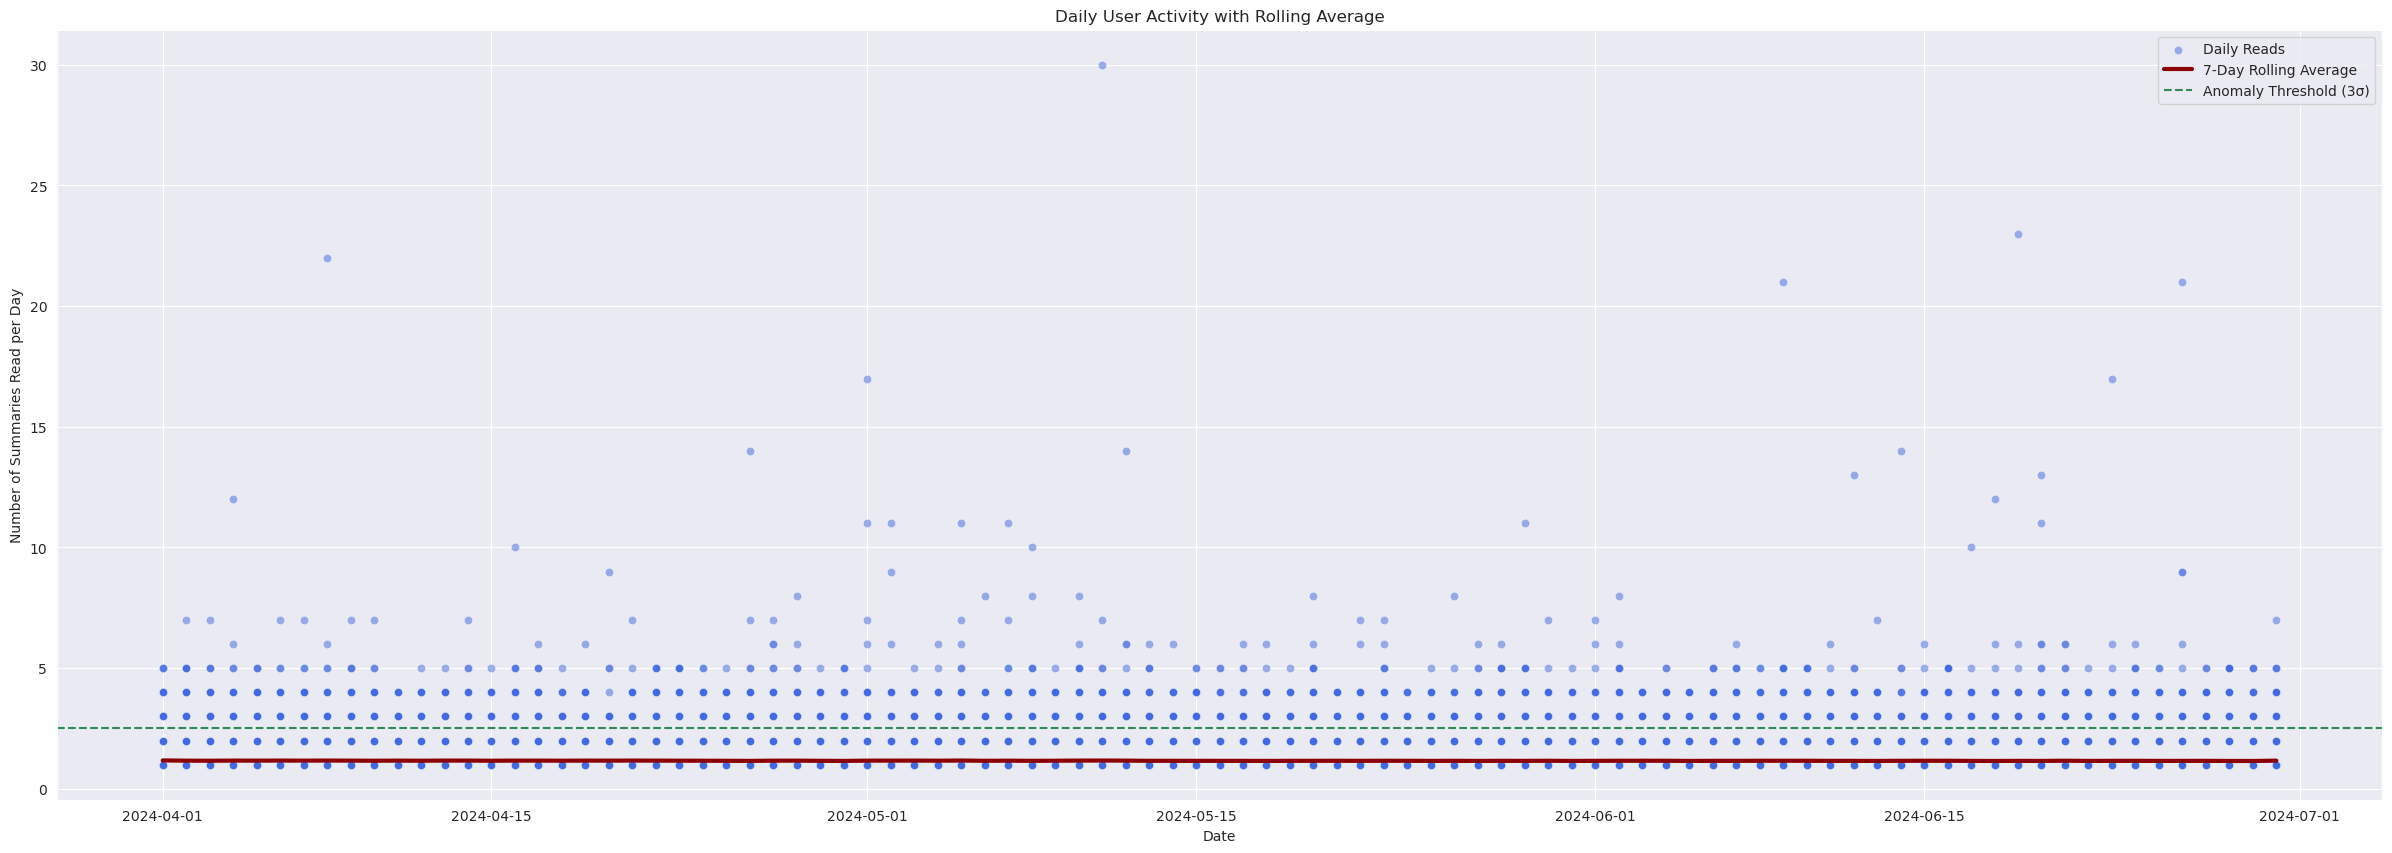

In [67]:
plot_user_activity(user_daily_reads2)

Very similar go general data (this group is almost 70% of whole data)

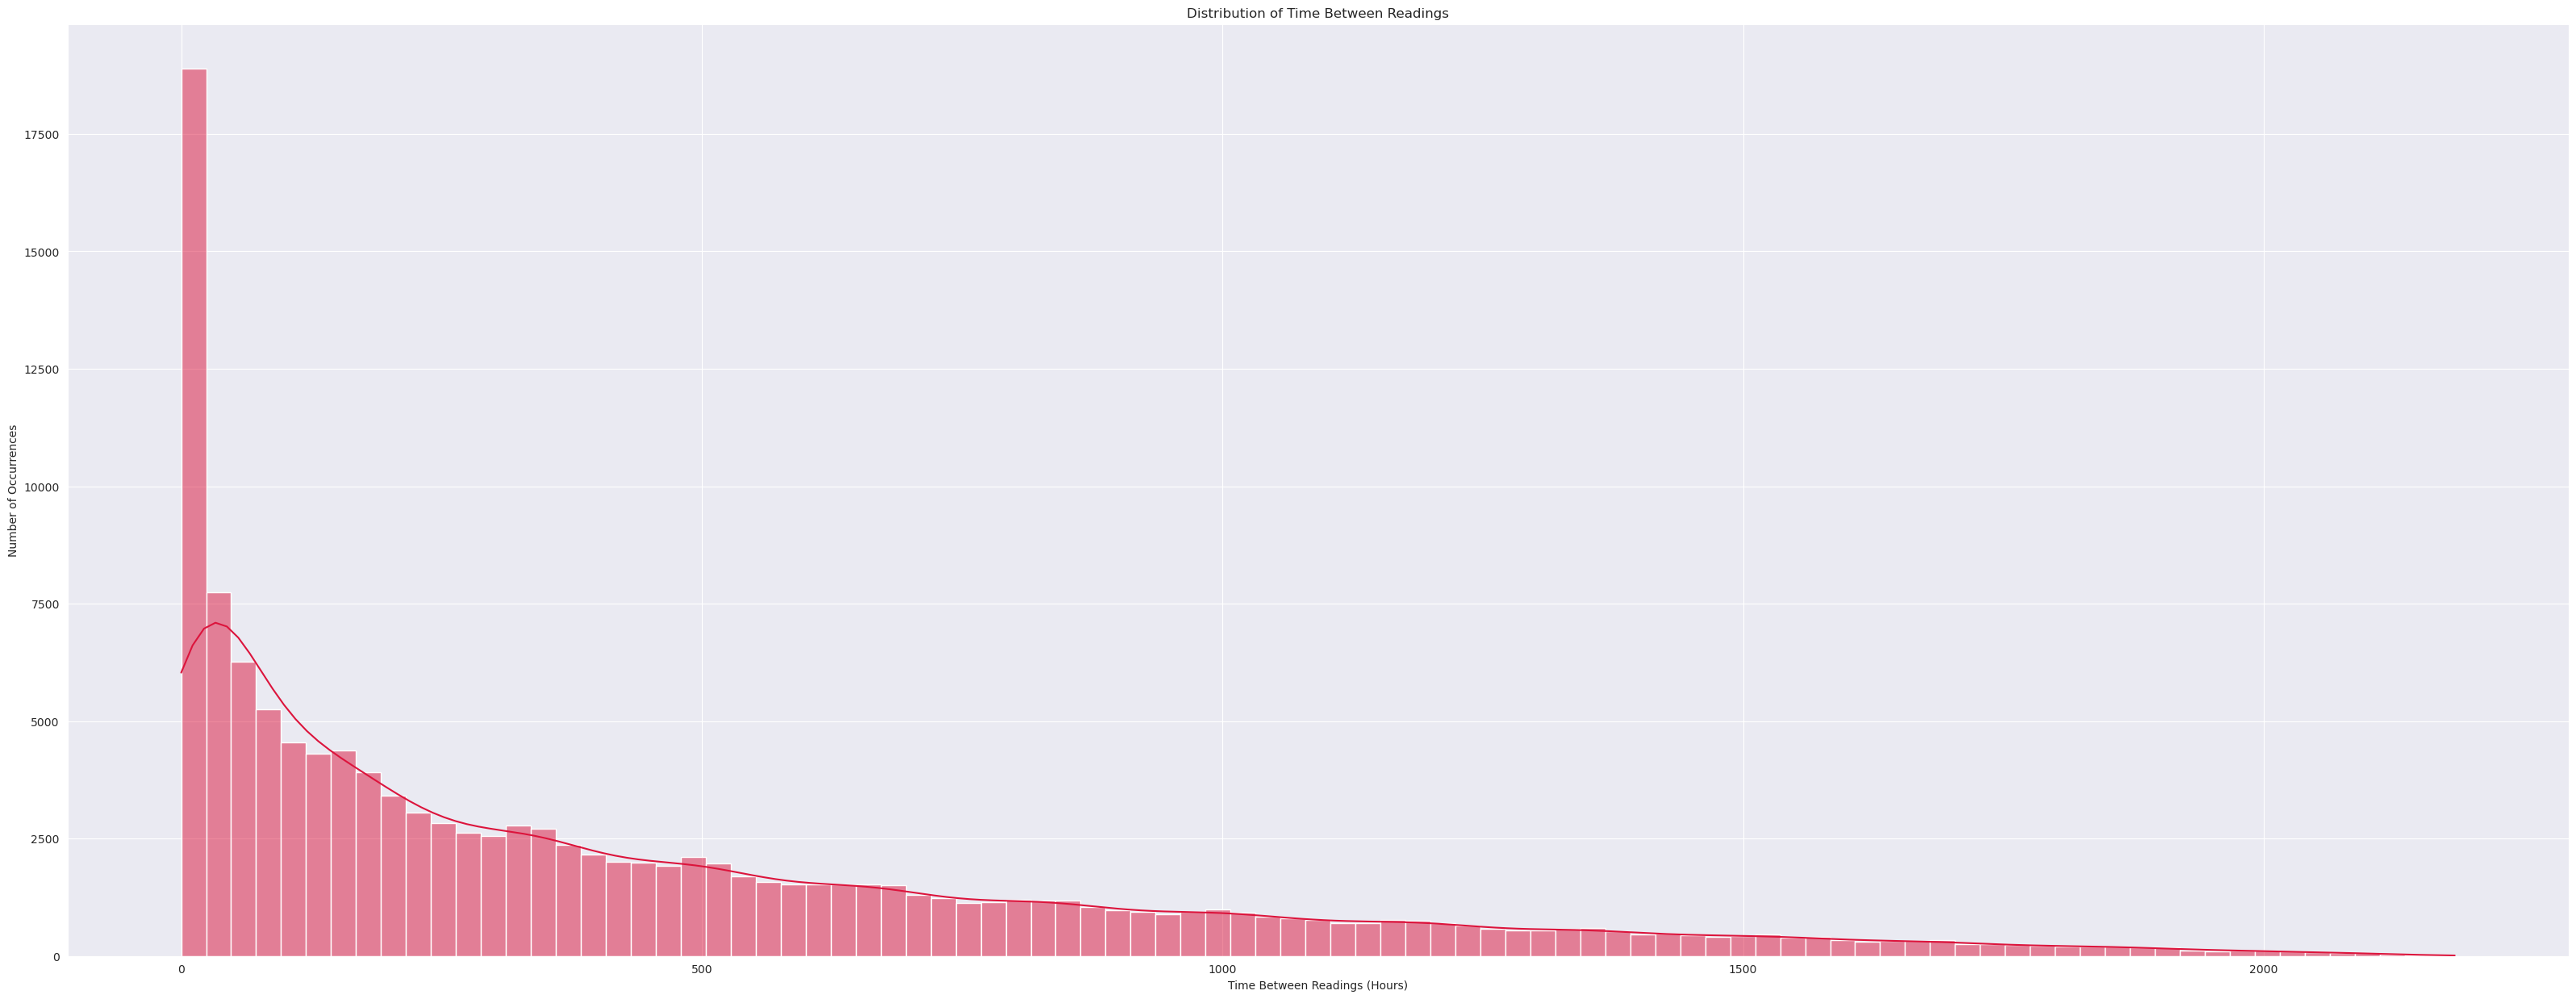

In [68]:
plot_time_diff_distribution(users_with_age_changes)

Very similar to general data

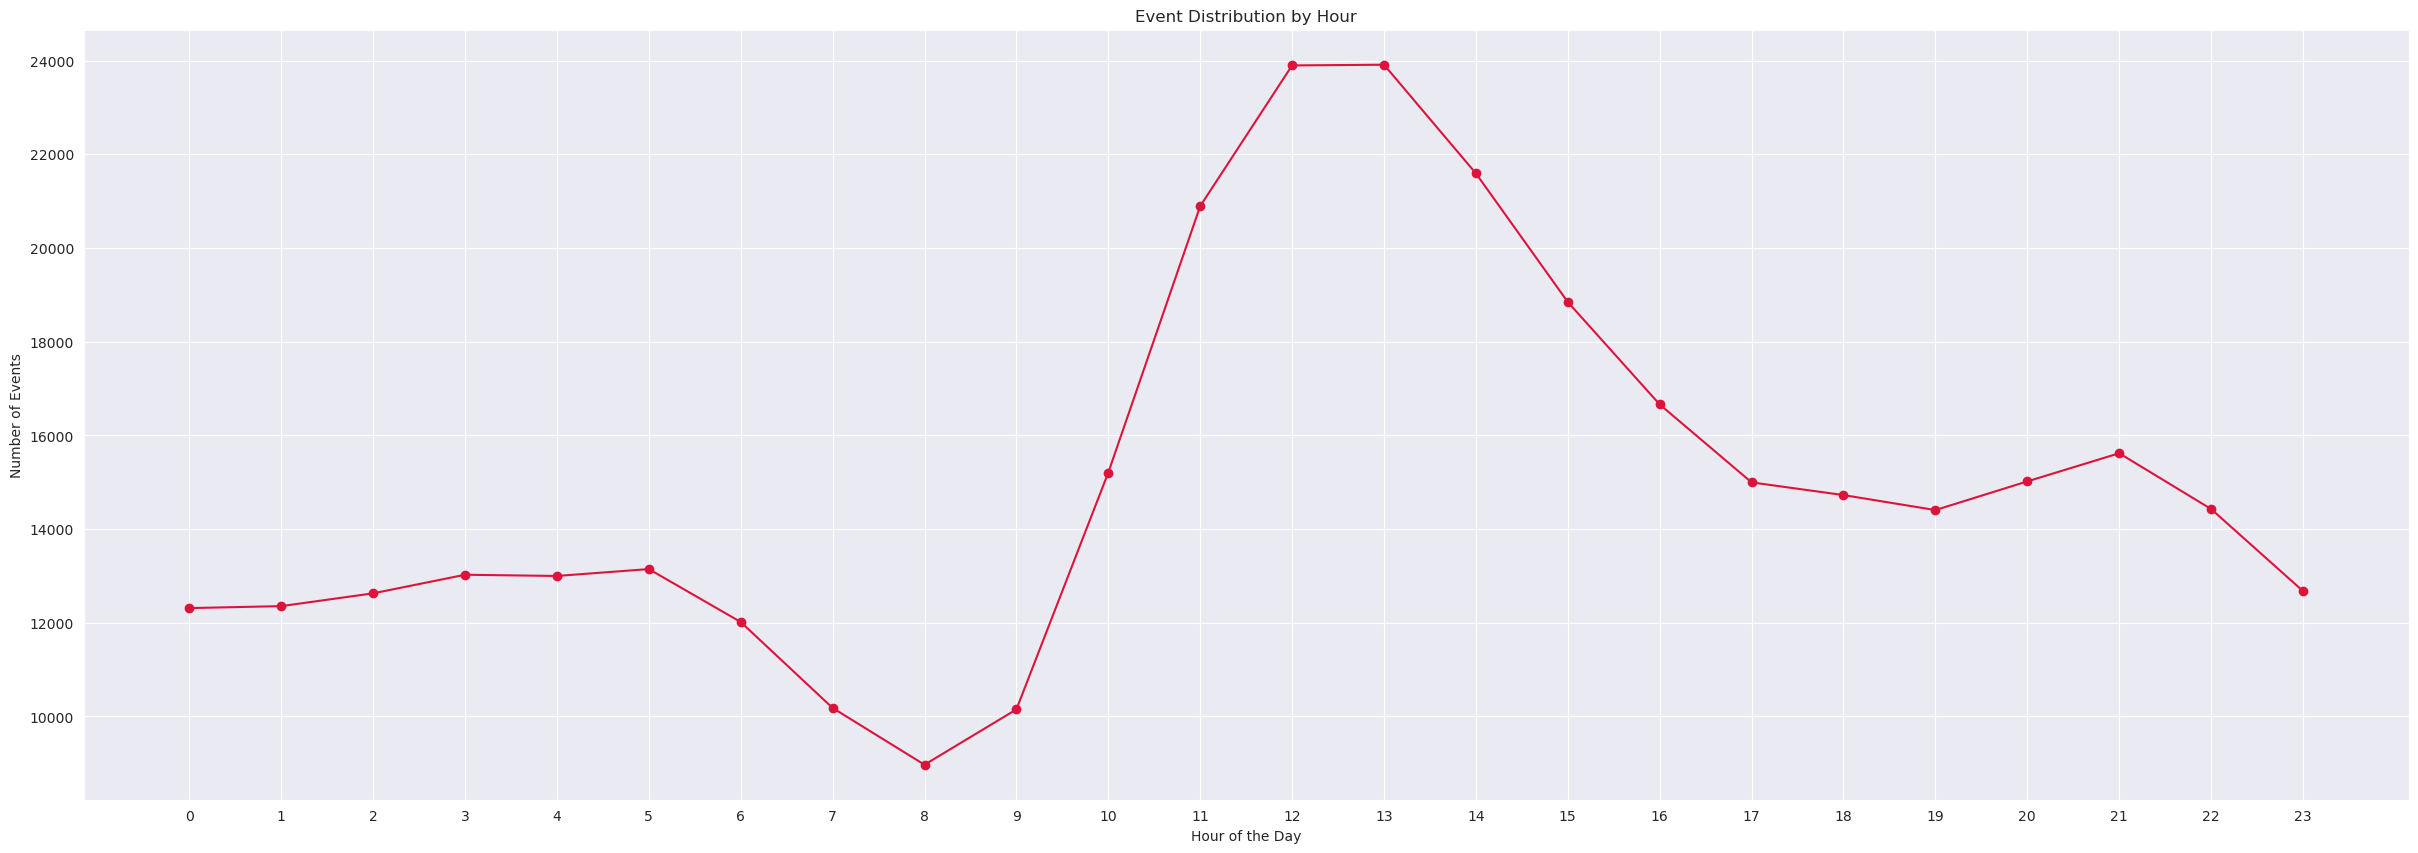

In [69]:
plot_event_distribution_by_hour(users_with_age_changes)

##### Activity Drop


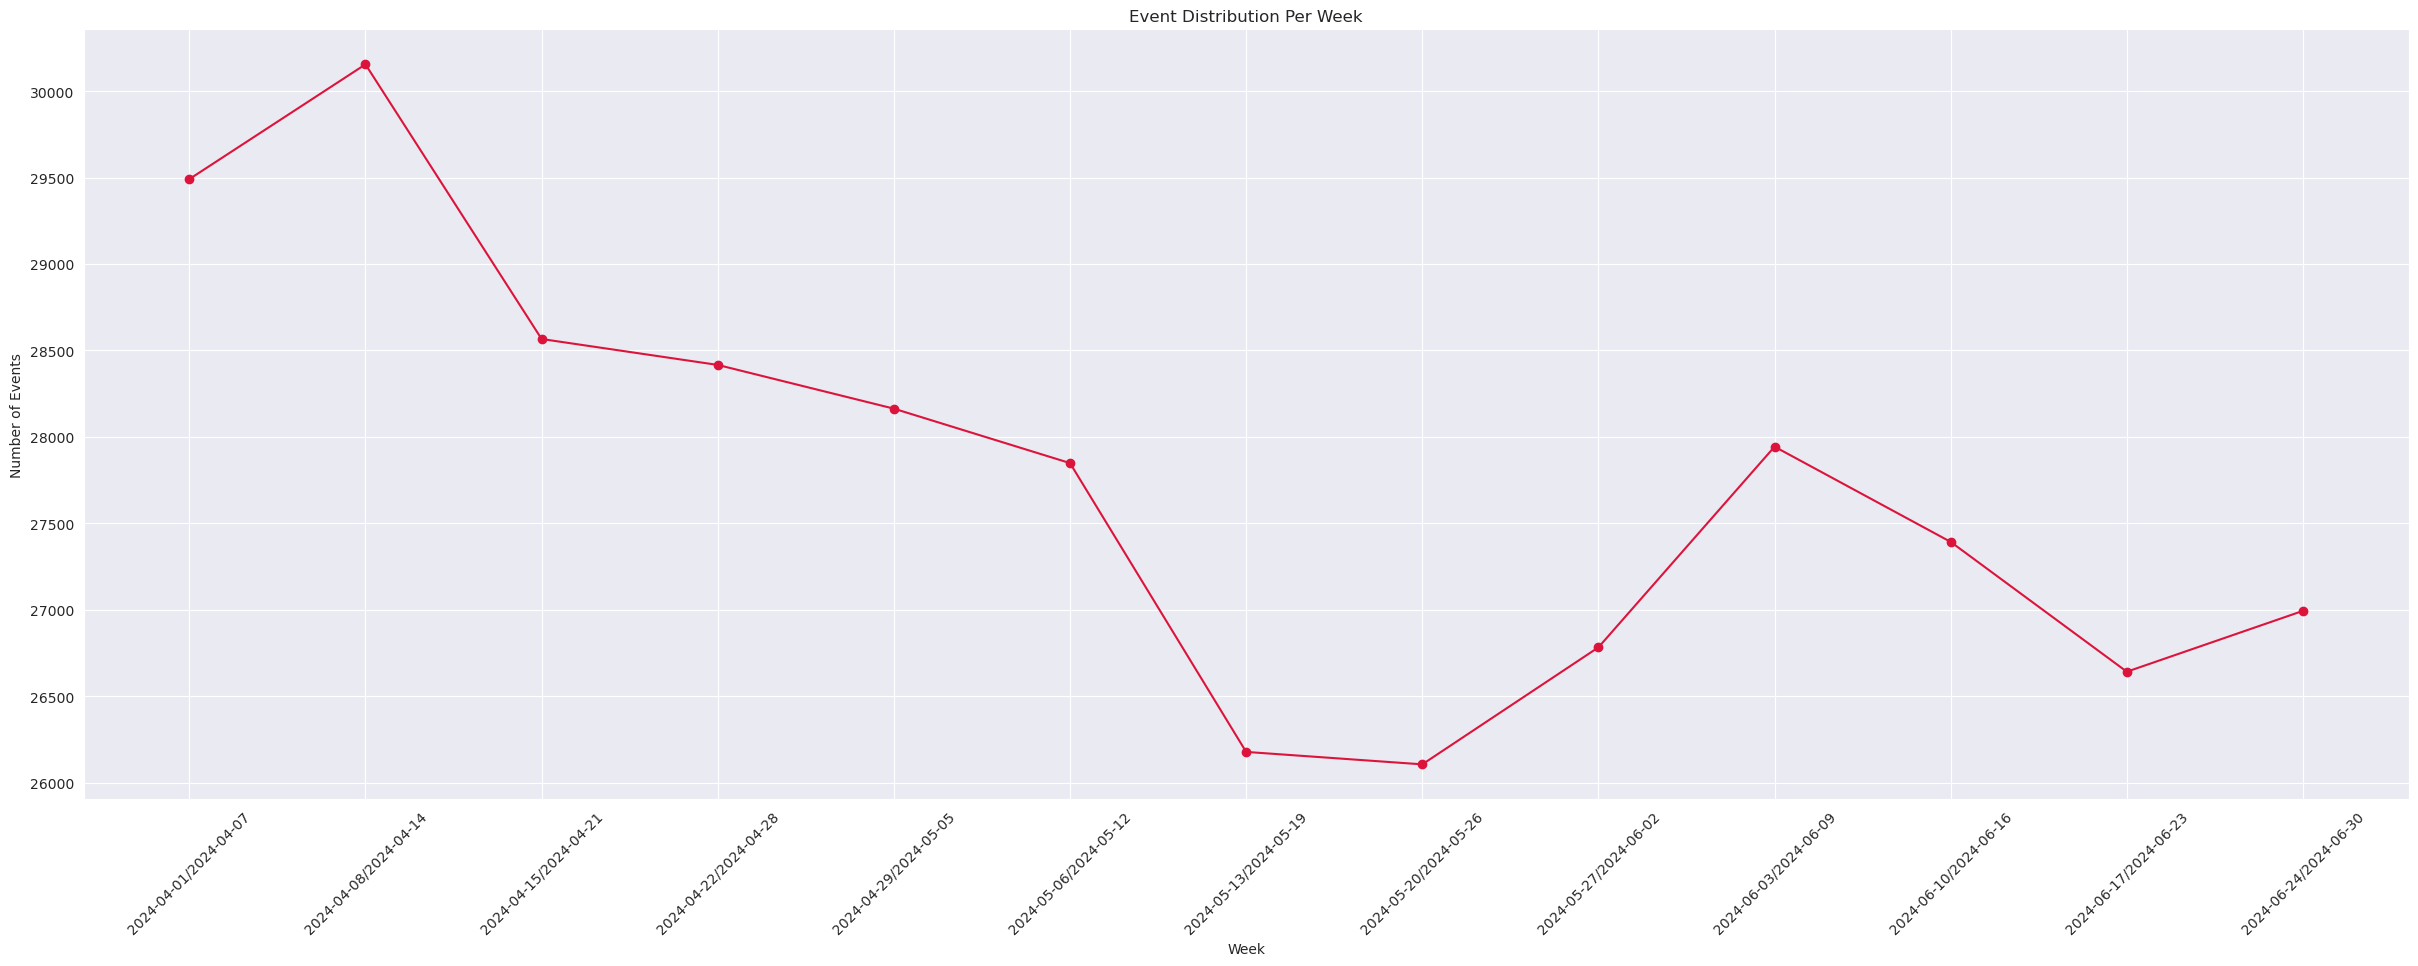

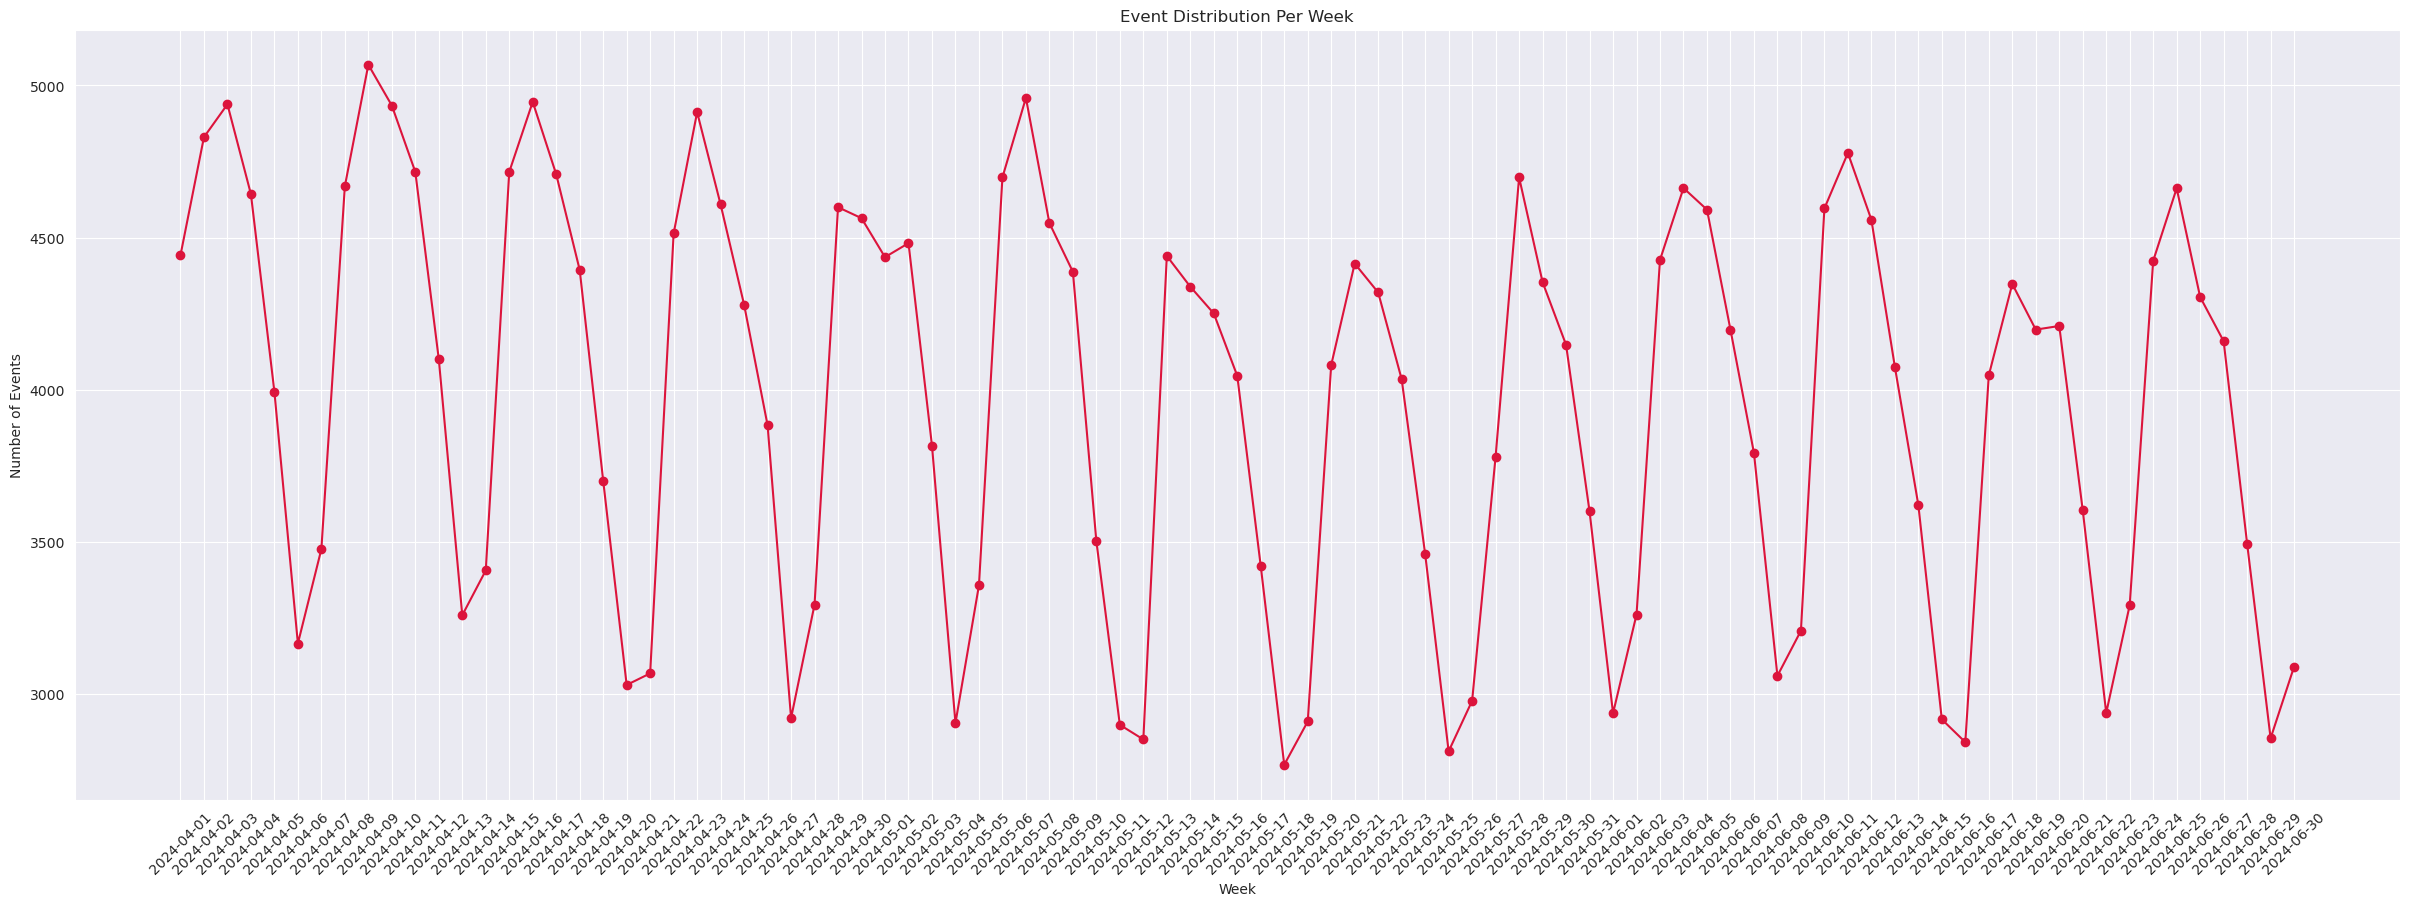

In [70]:
event_per_week(users_with_age_changes)
event_per_day(users_with_age_changes)

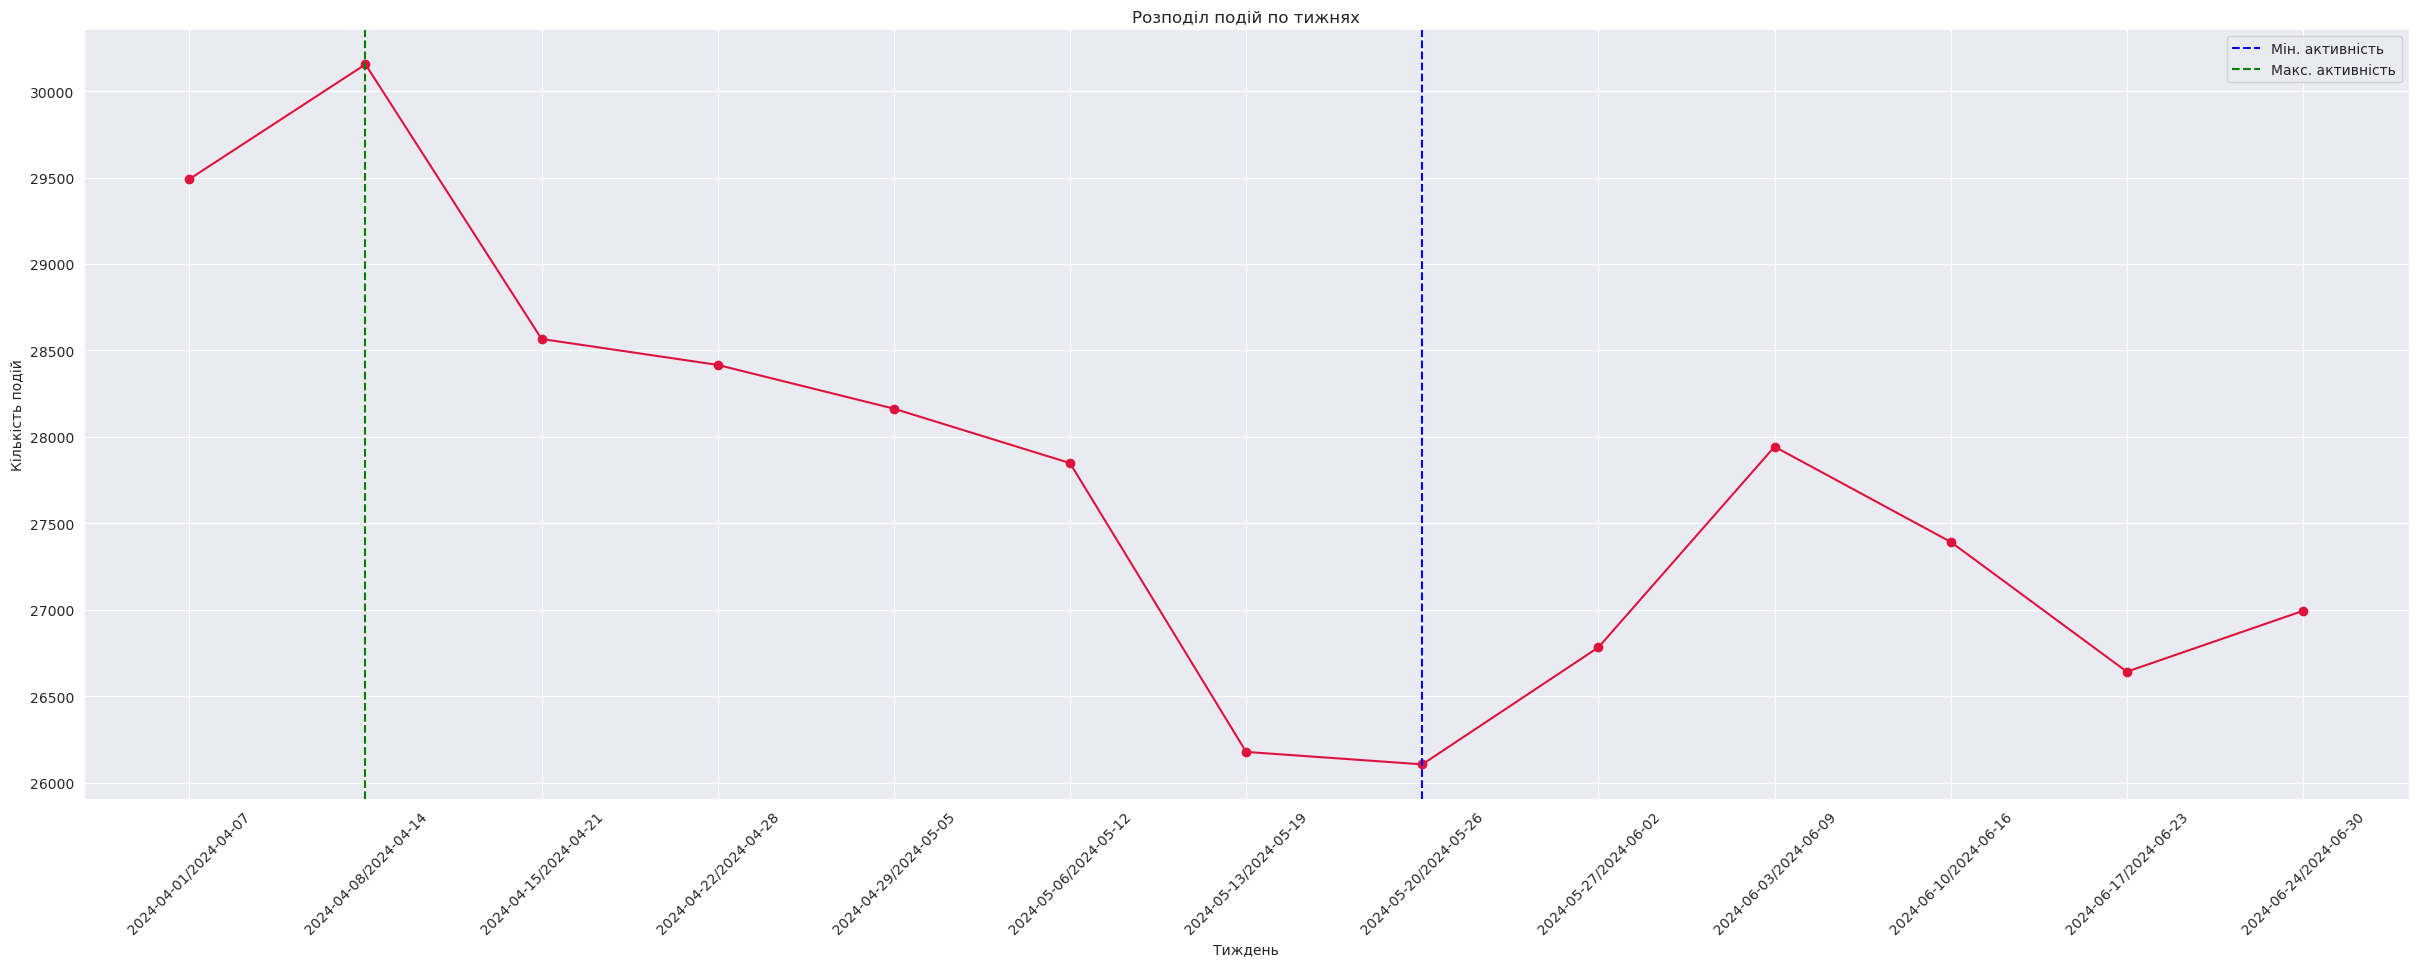

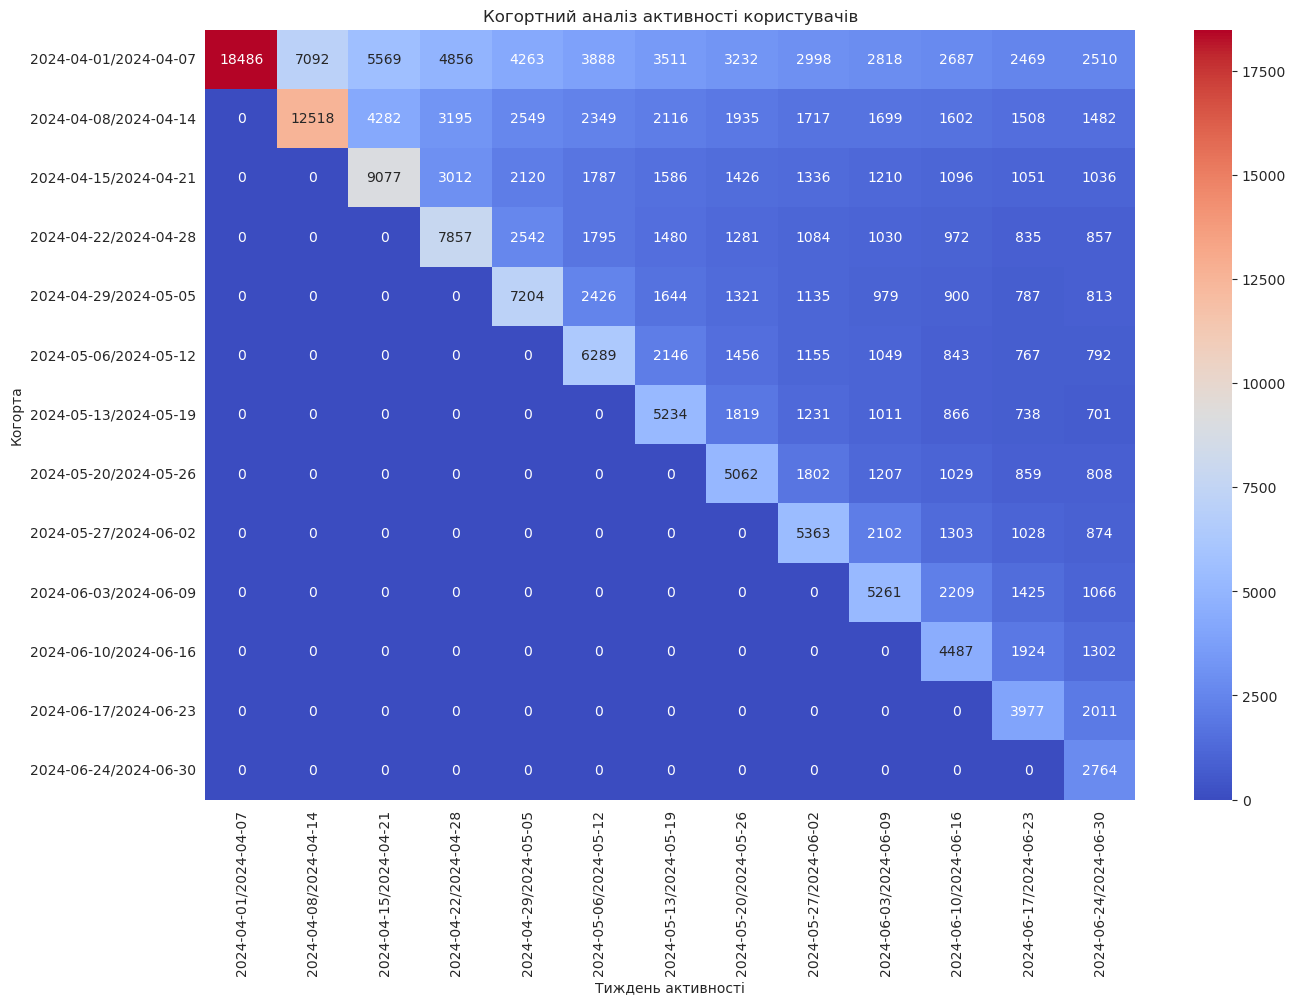

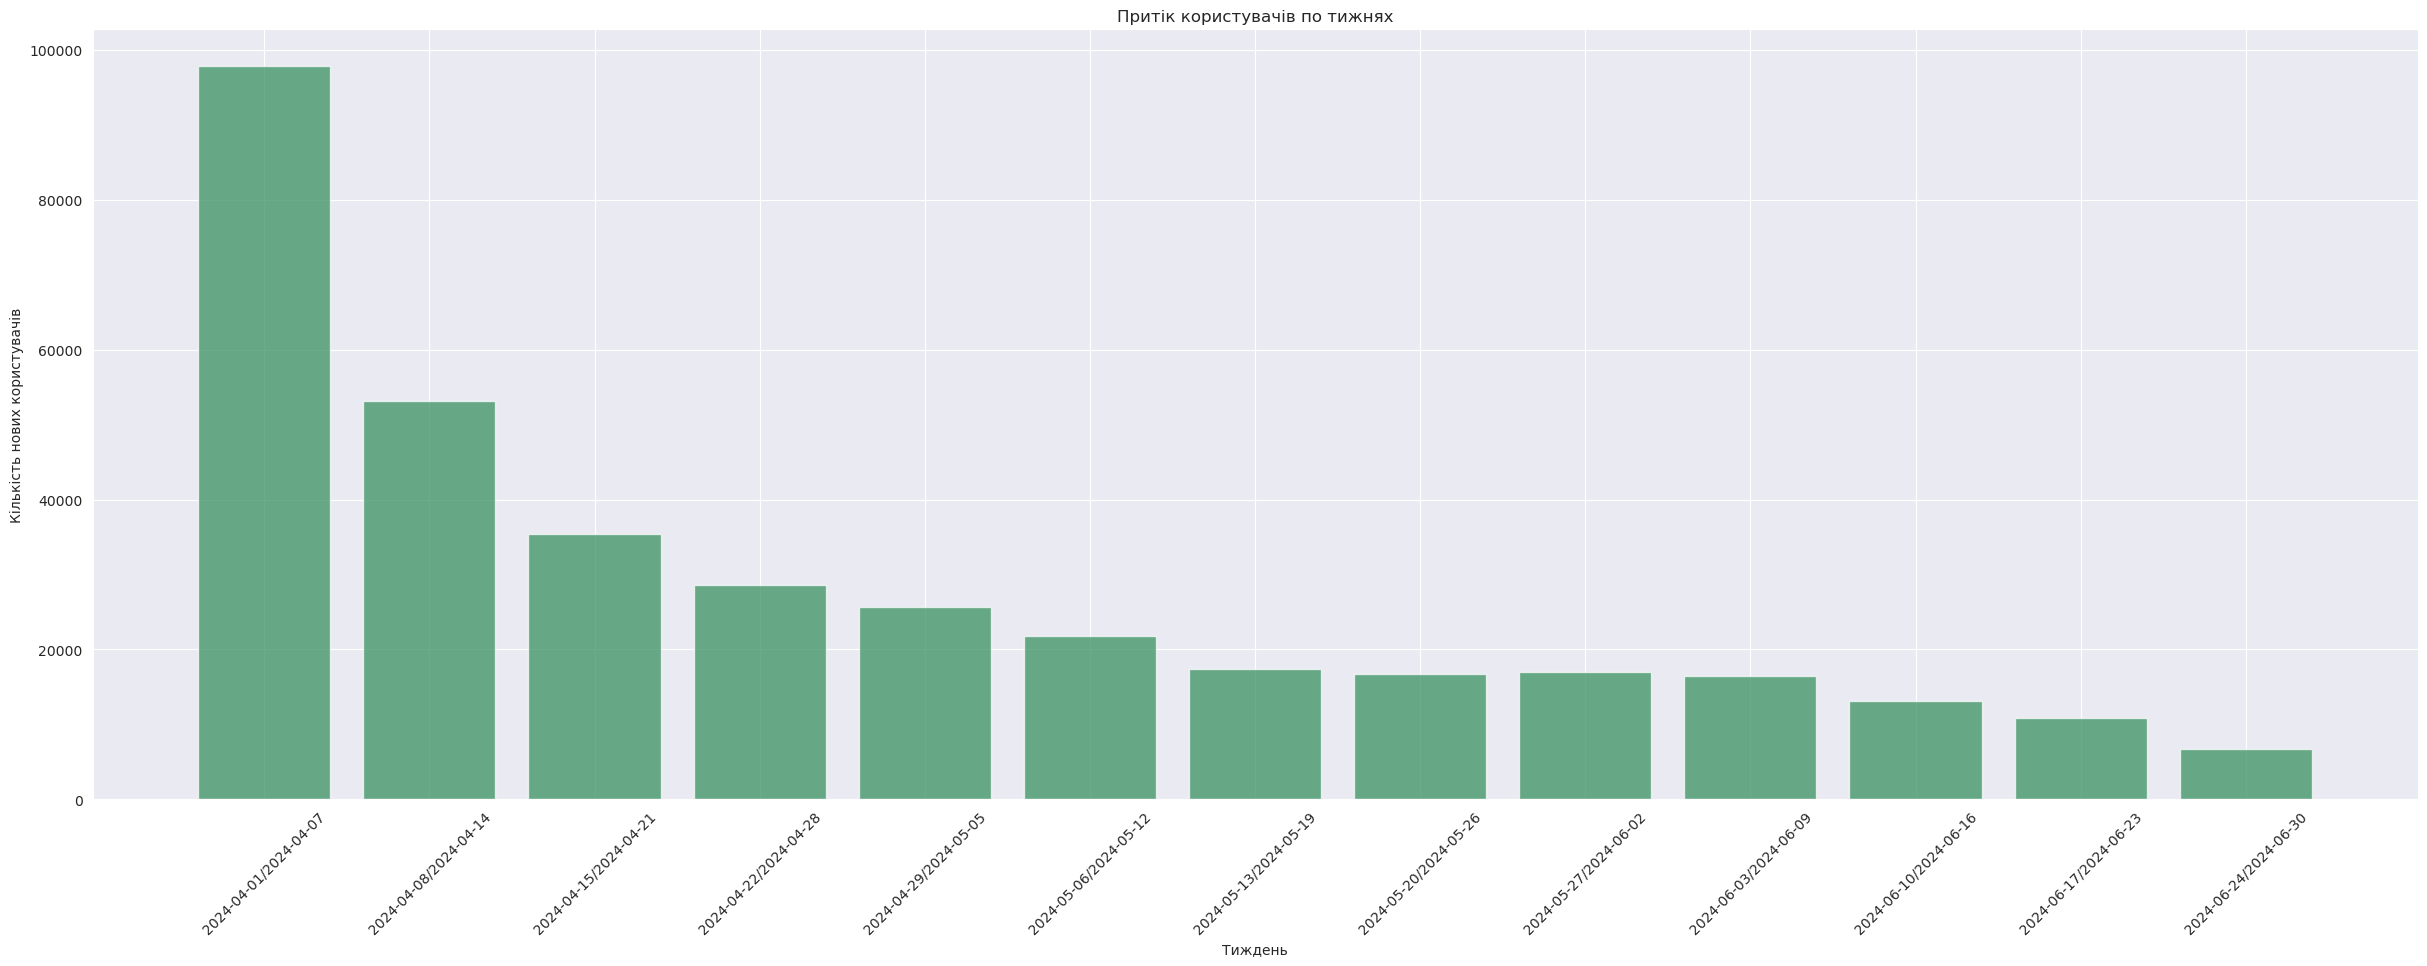

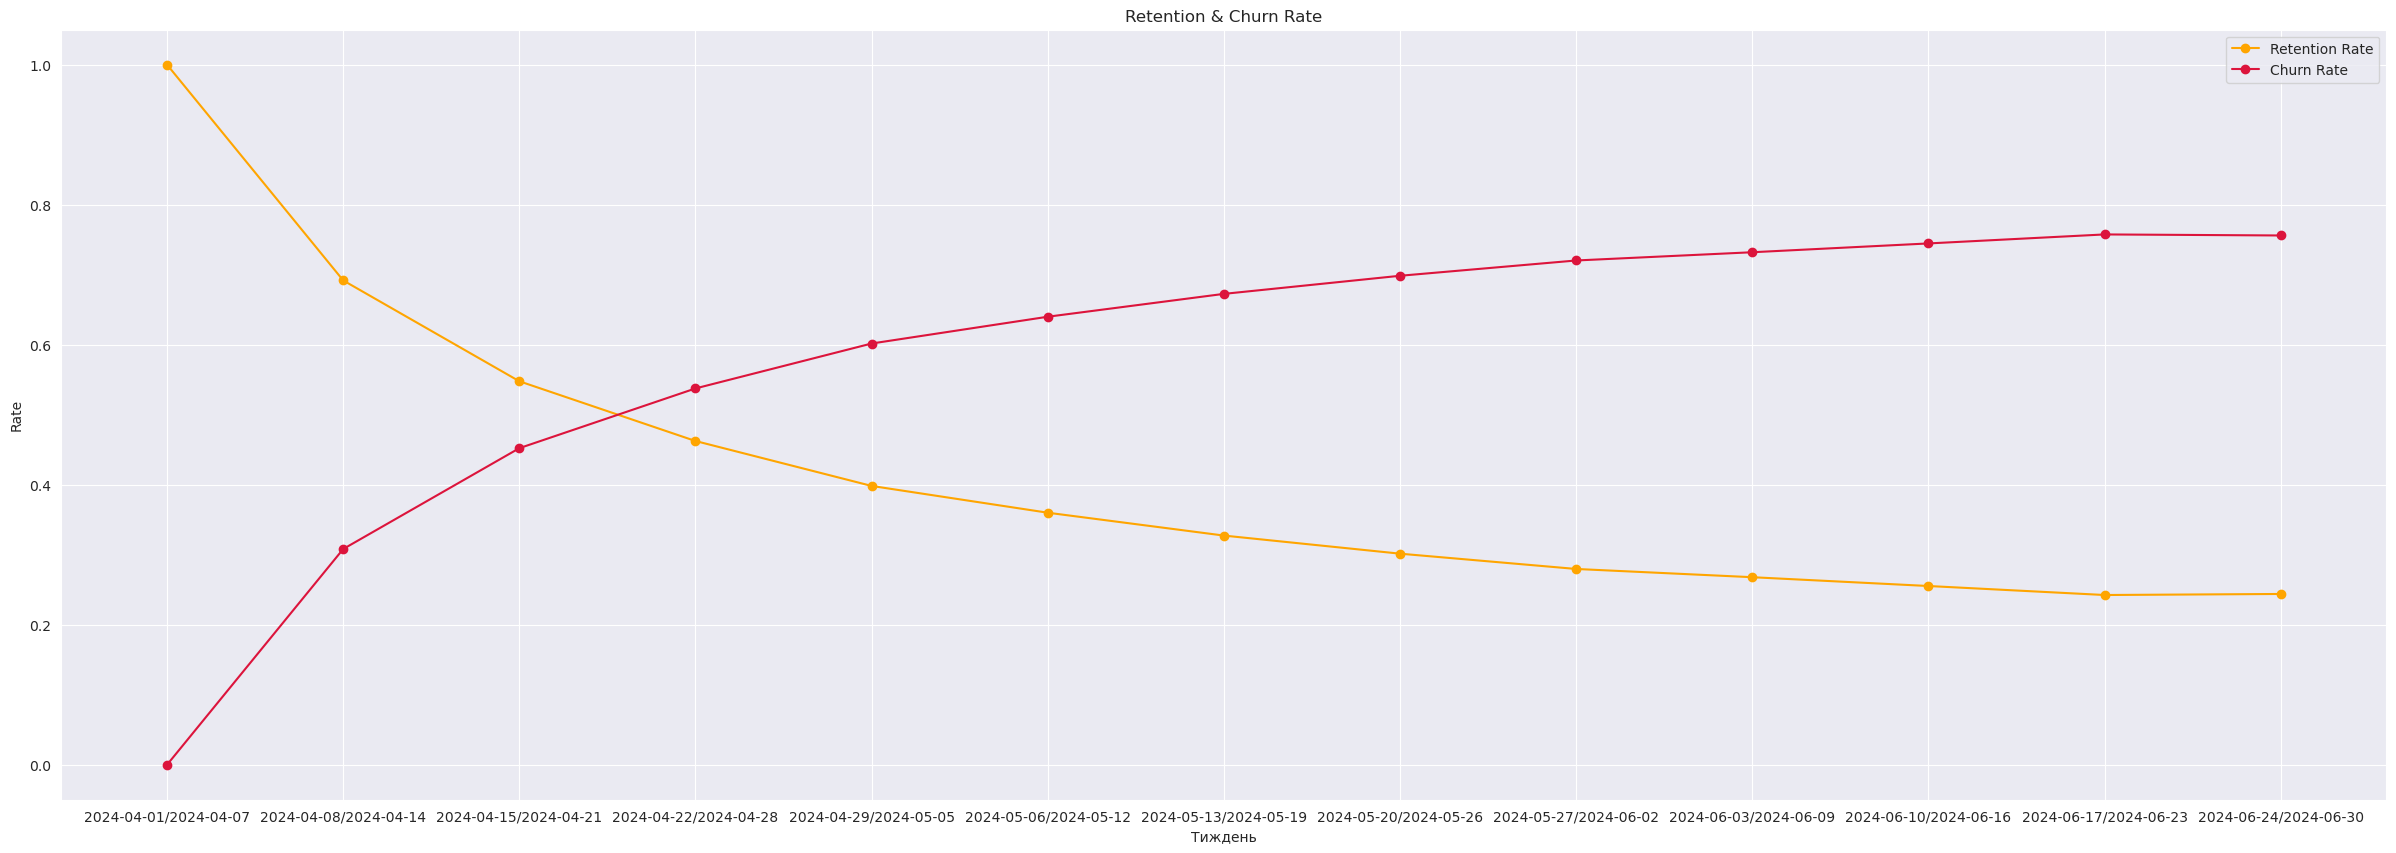

In [71]:
analyze_activity_drop(users_with_age_changes)
acquisition_analysis(users_with_age_changes)
calculate_churn_and_retention(users_with_age_changes)

Here, almost everything is the same as in the general data. But the customer churn rate is lower, which is much better

##### Seasonality check

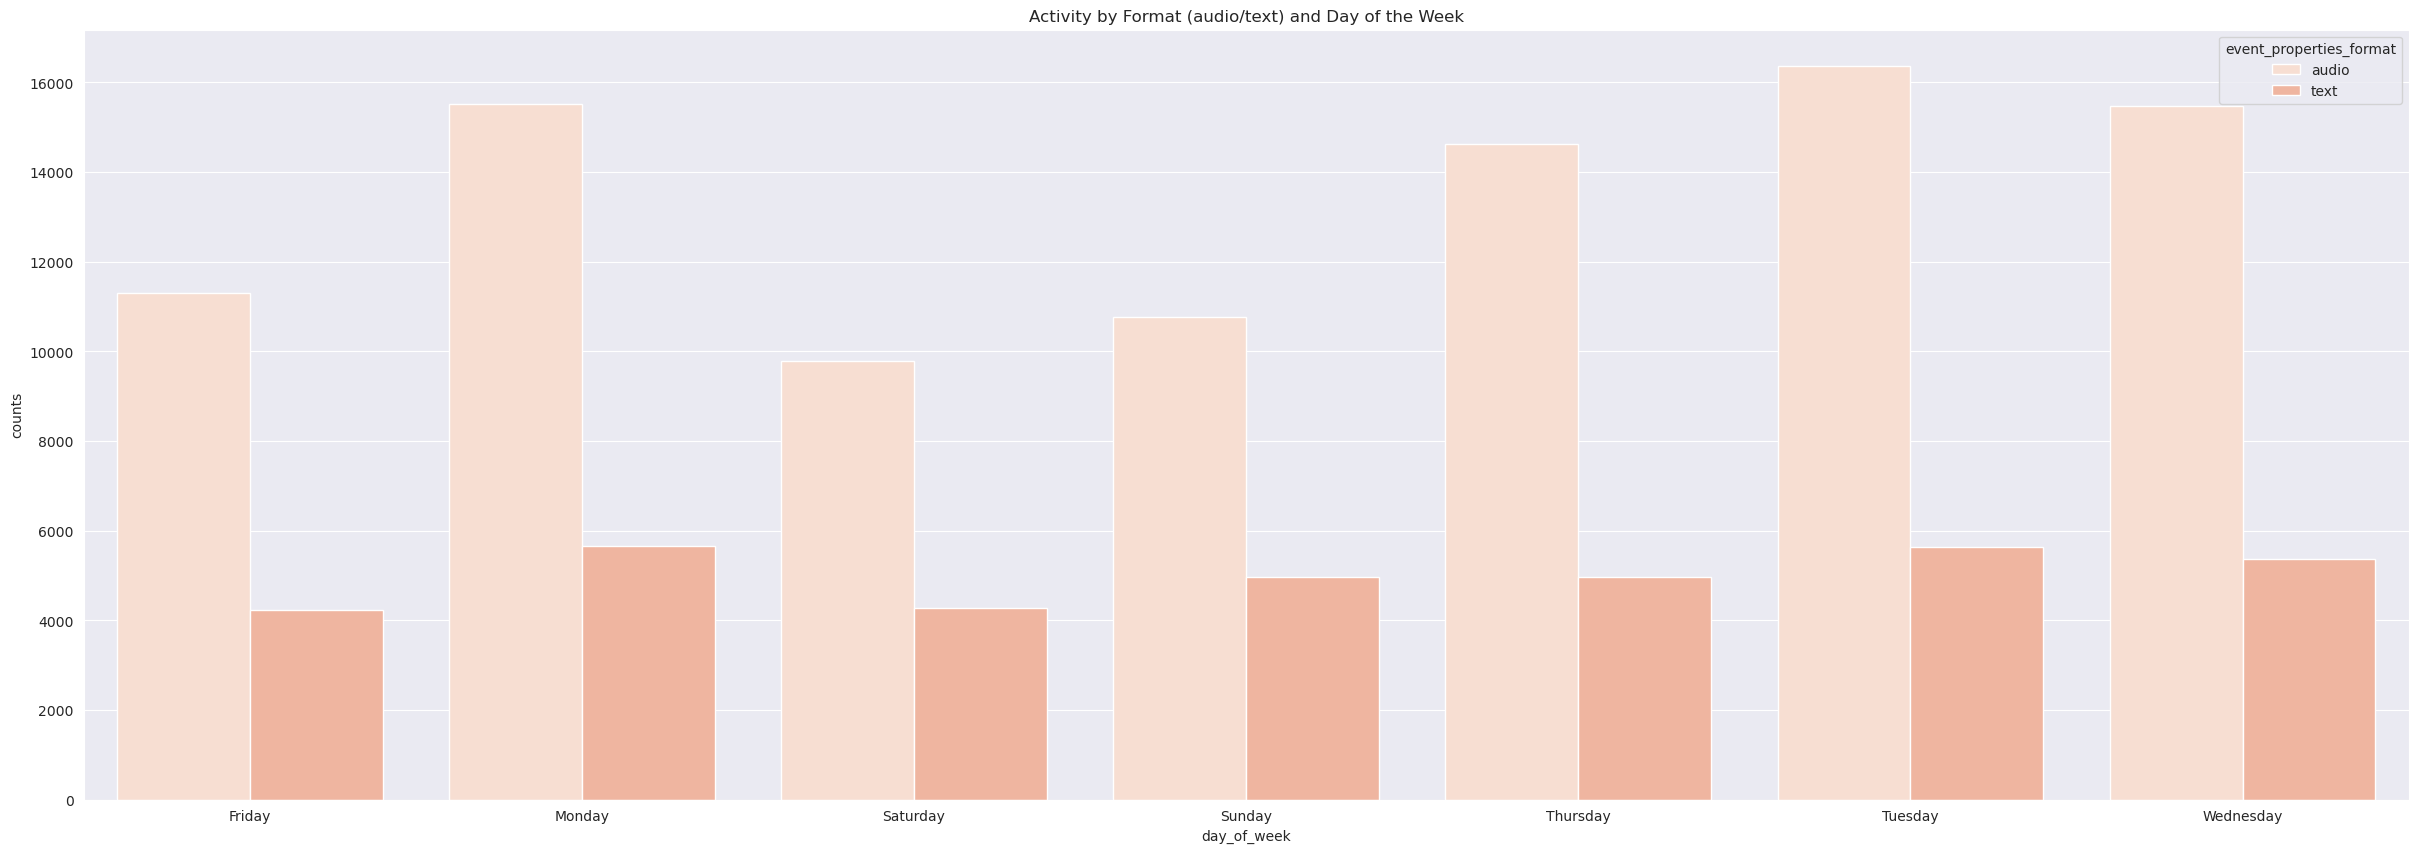

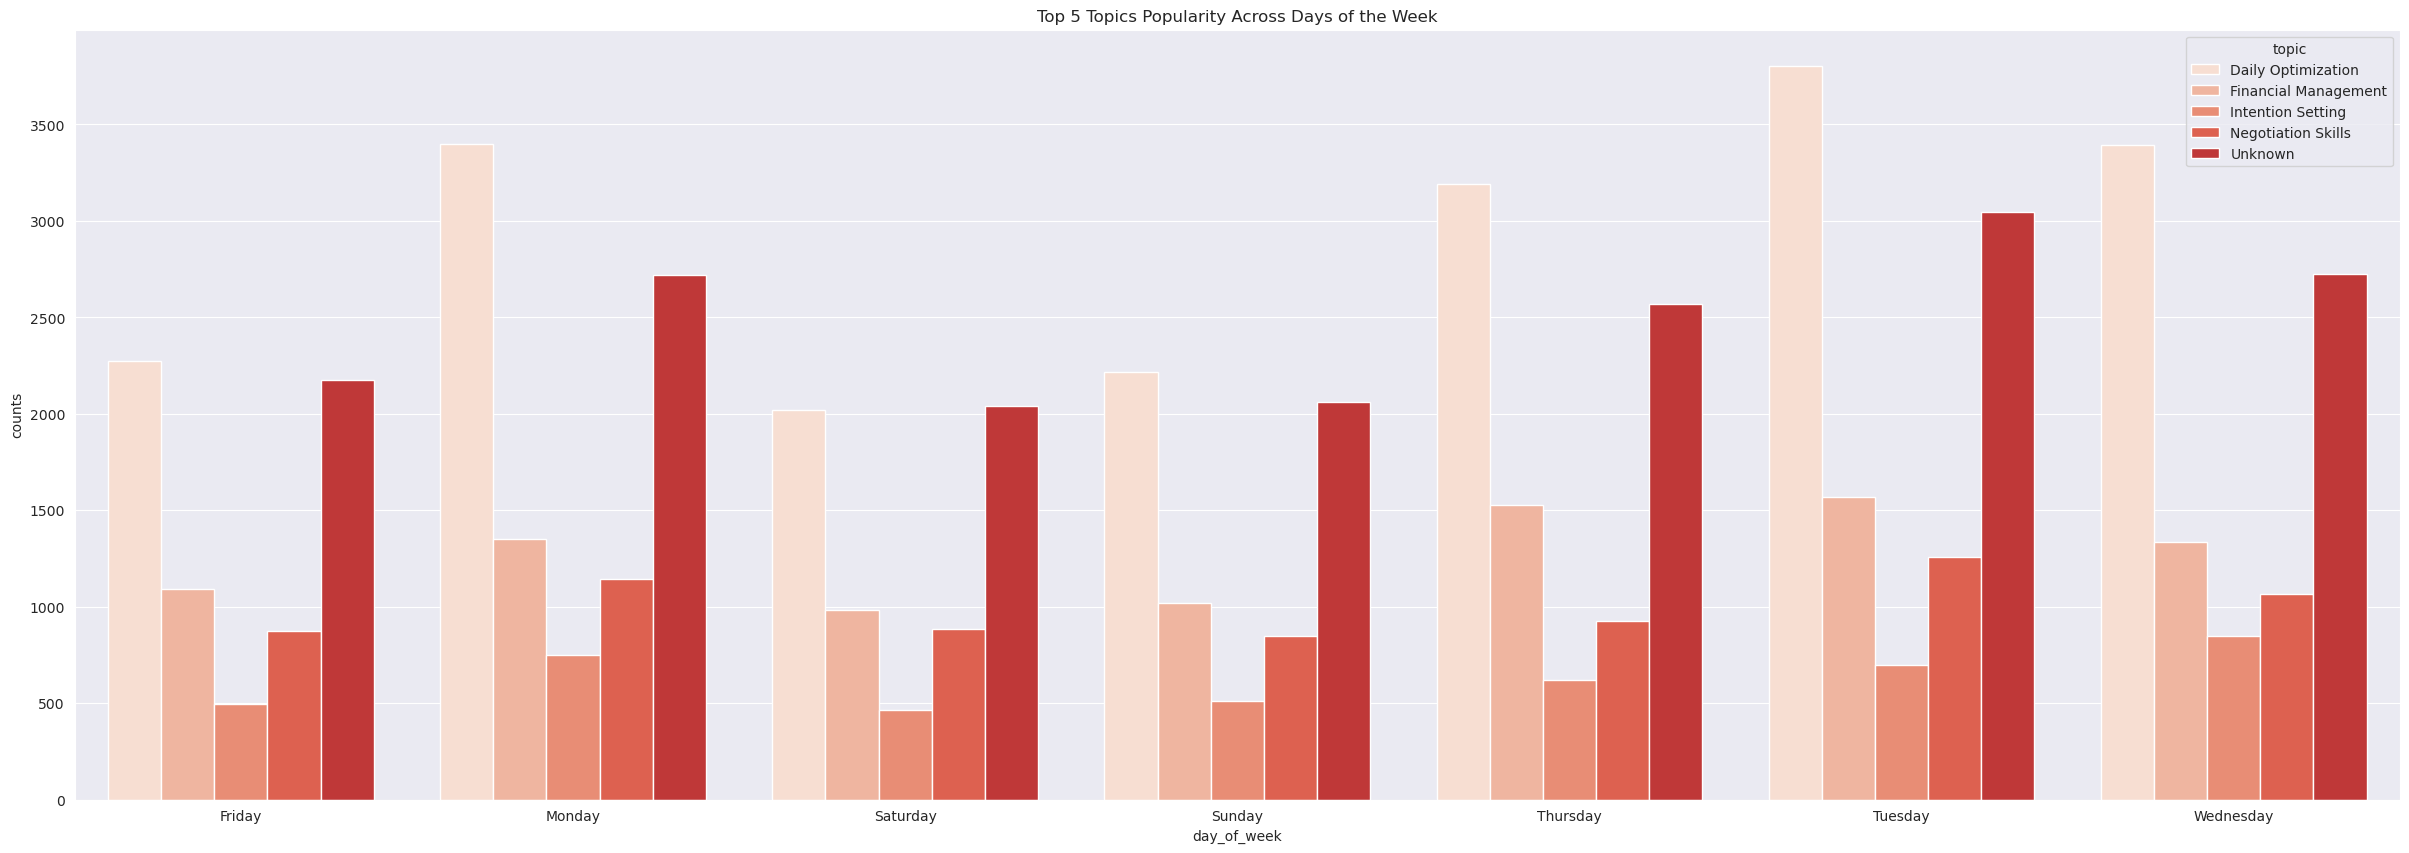

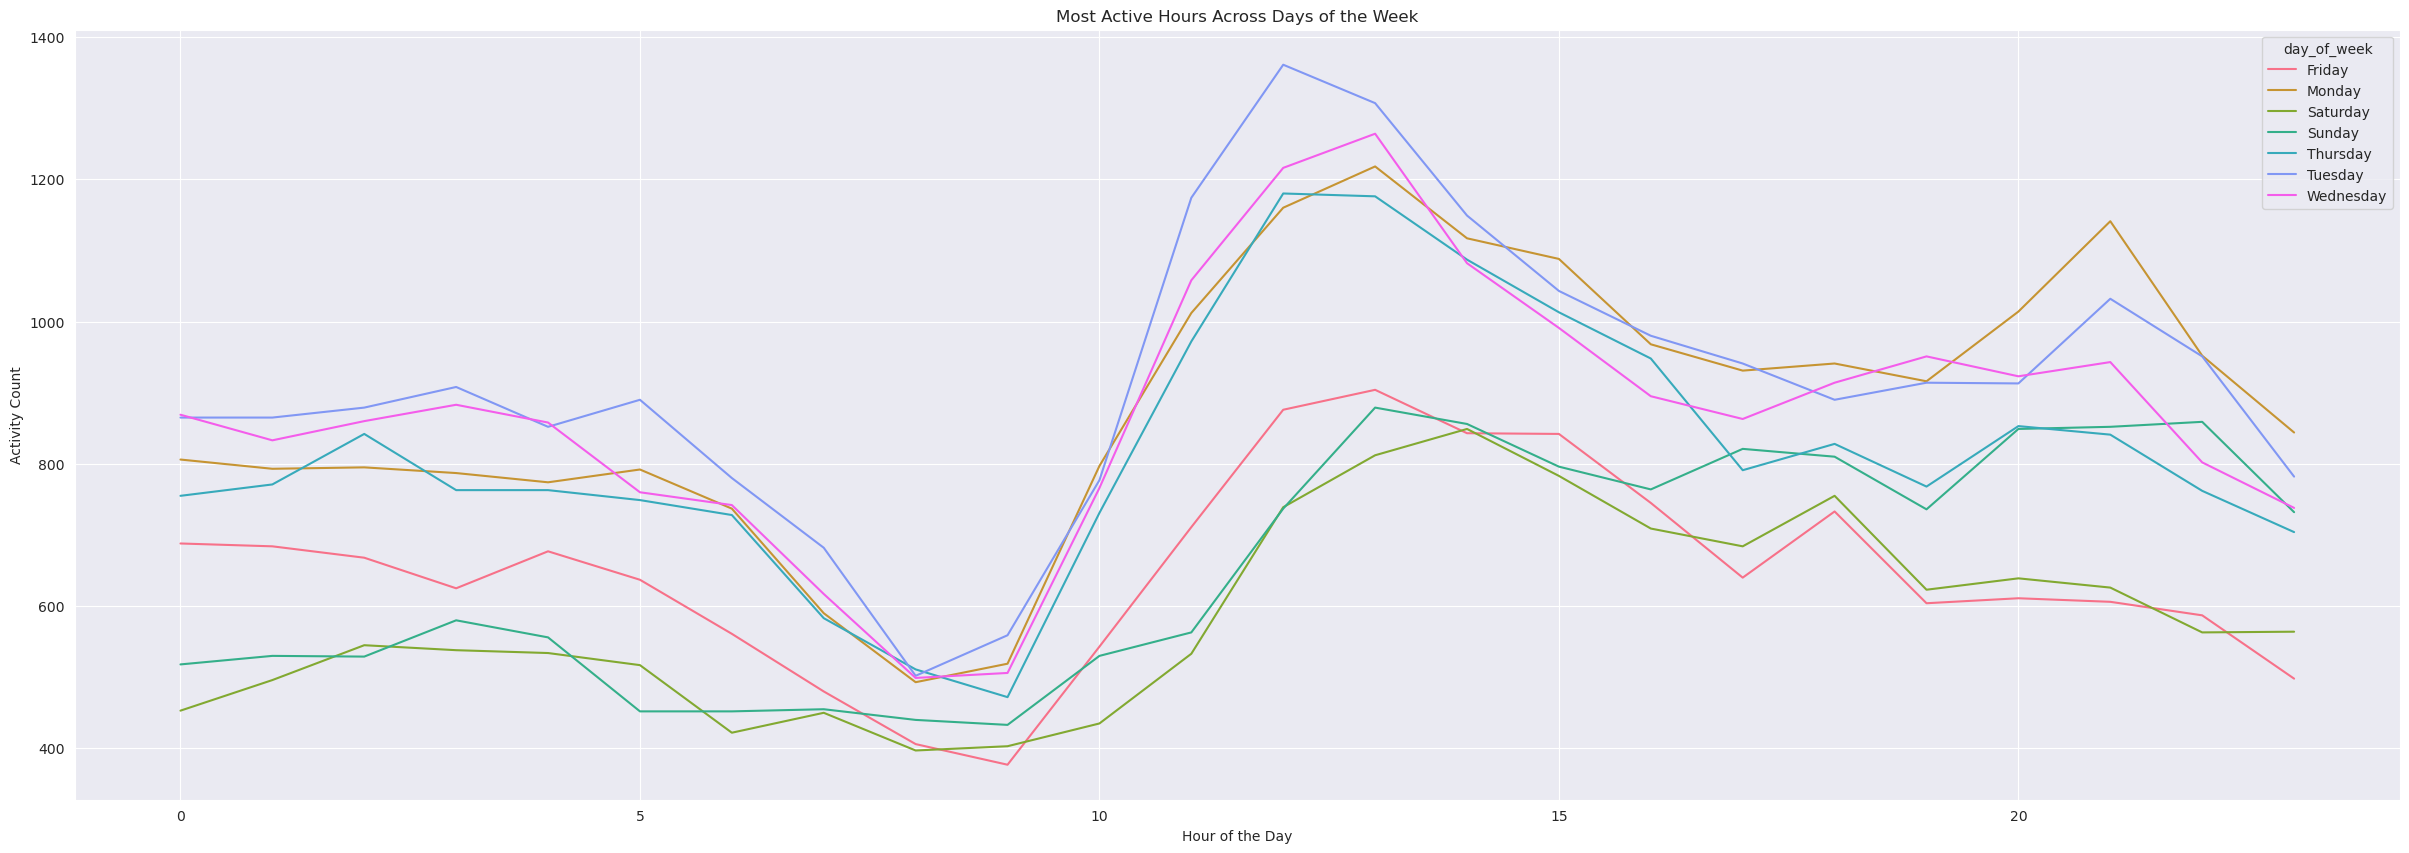

In [72]:
ses_2 = sesonal_prepare(users_without_age_changes)

plot_activity_by_format(ses_2)
plot_topic_popularity(ses_2)
plot_peak_hours(ses_2)

#### No changing age data

##### Distributions

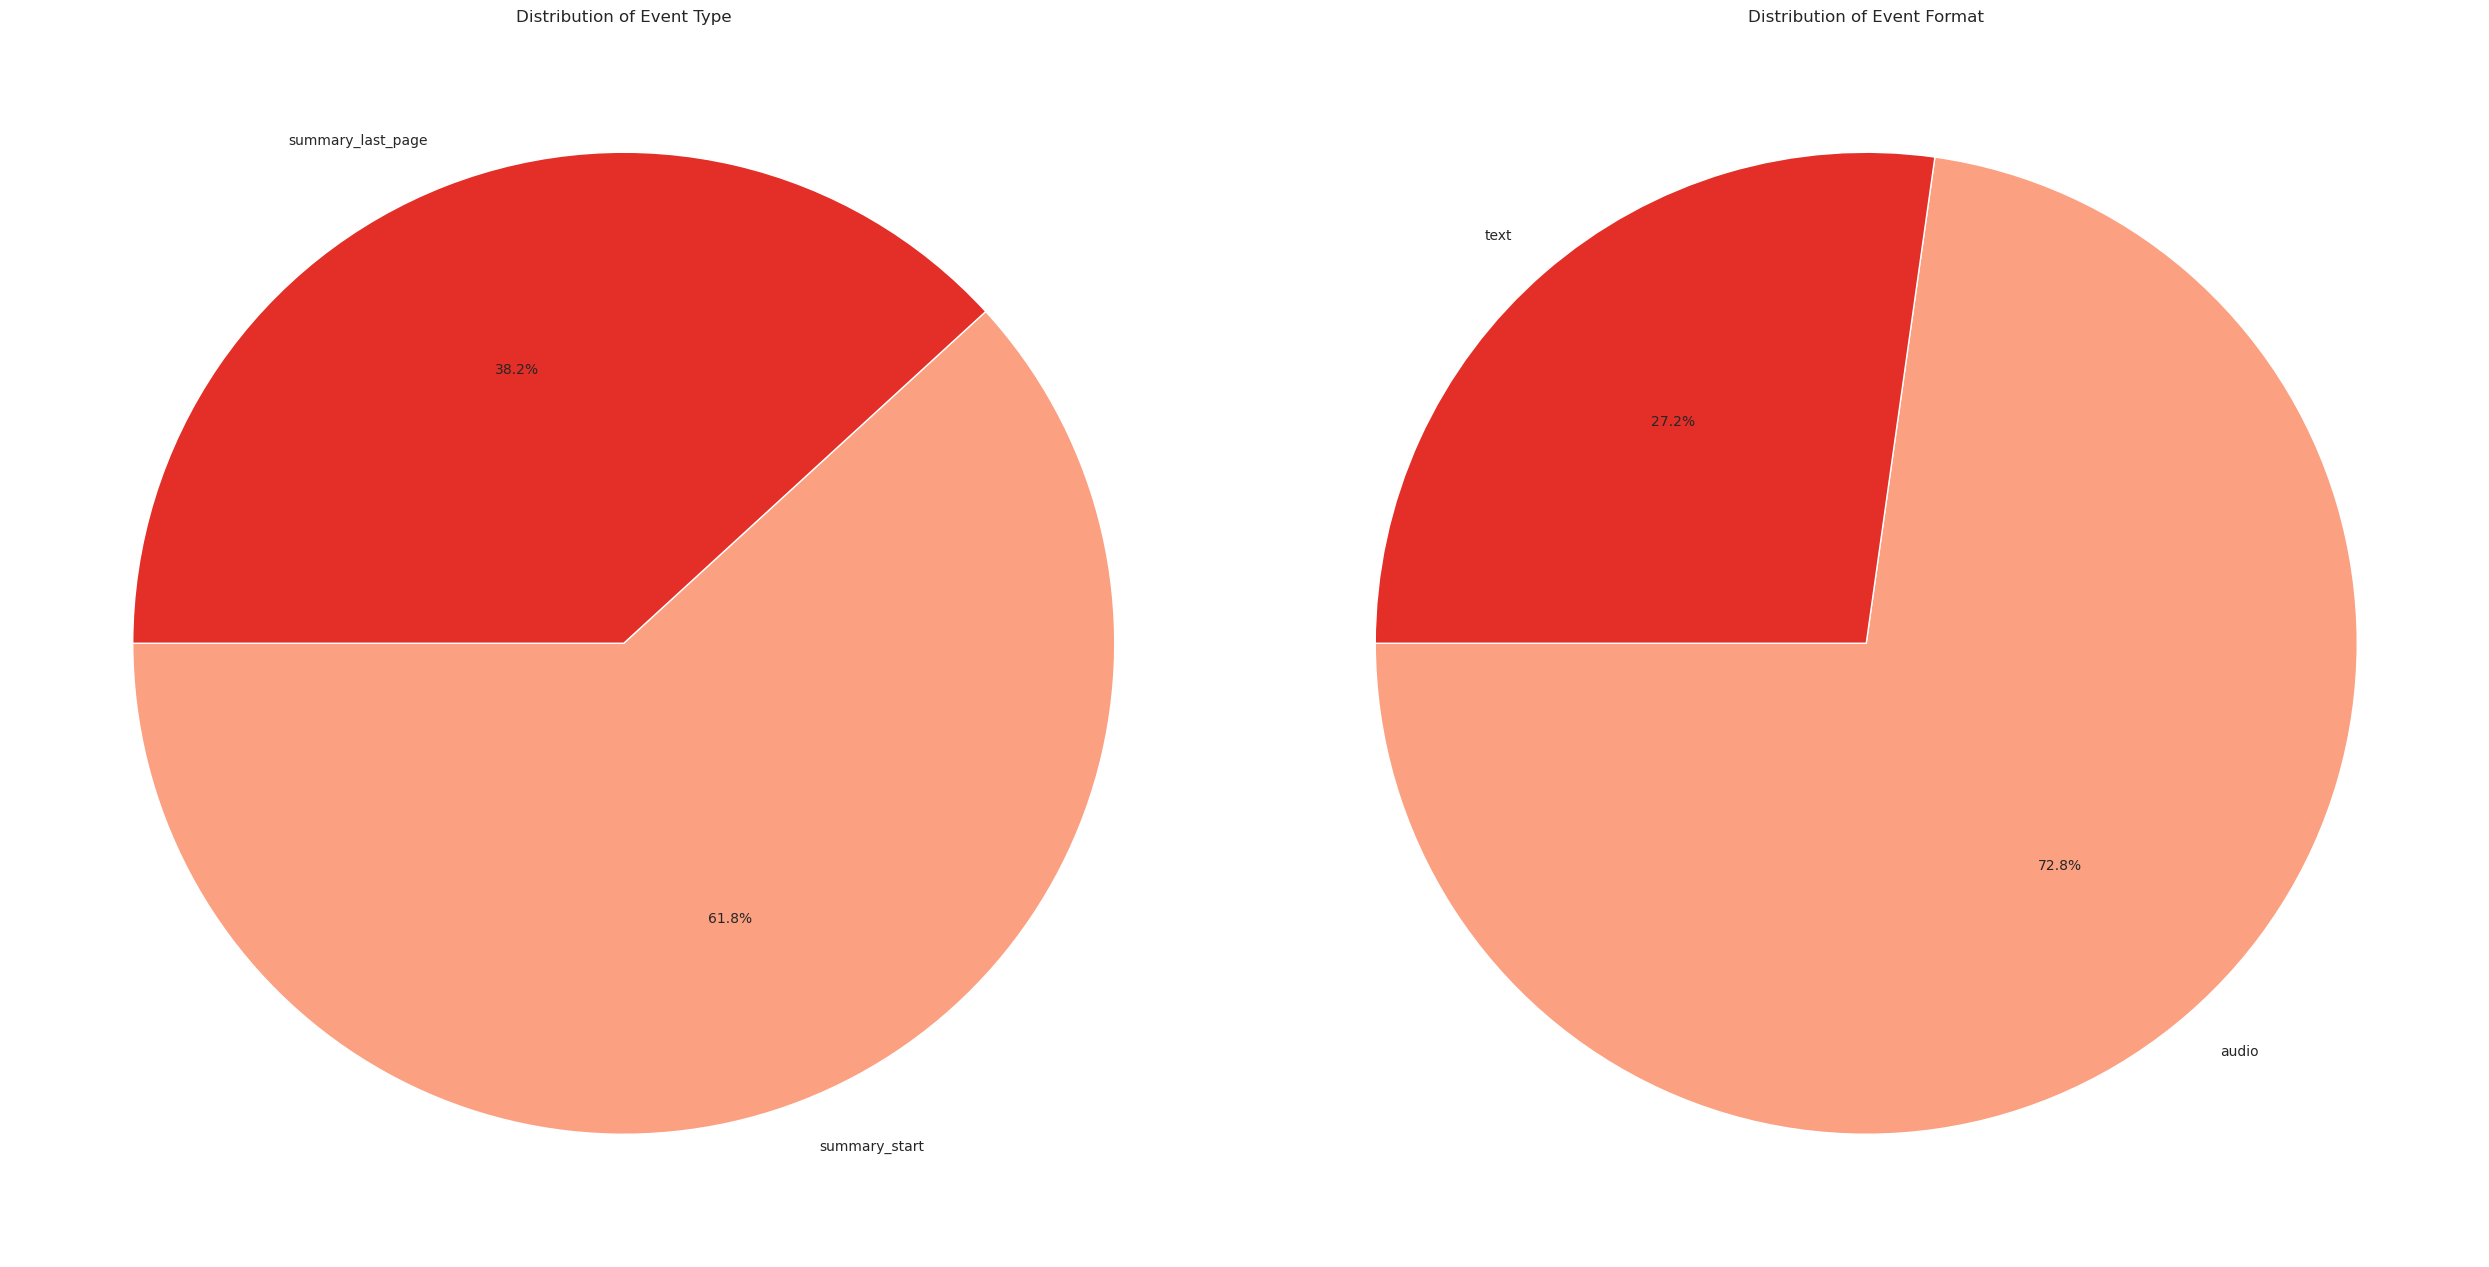

In [73]:
plot_event_distributions(users_without_age_changes)

Very similar po th whole data

Unique user-book pairs: 128856
Books fully tracked (started and completed): 79
Total books started: 79700
Estimated completion rate: 0.10%
Records with 'summary_last_page' but no 'summary_start': 49170
Unique users with only 'summary_last_page': 48628


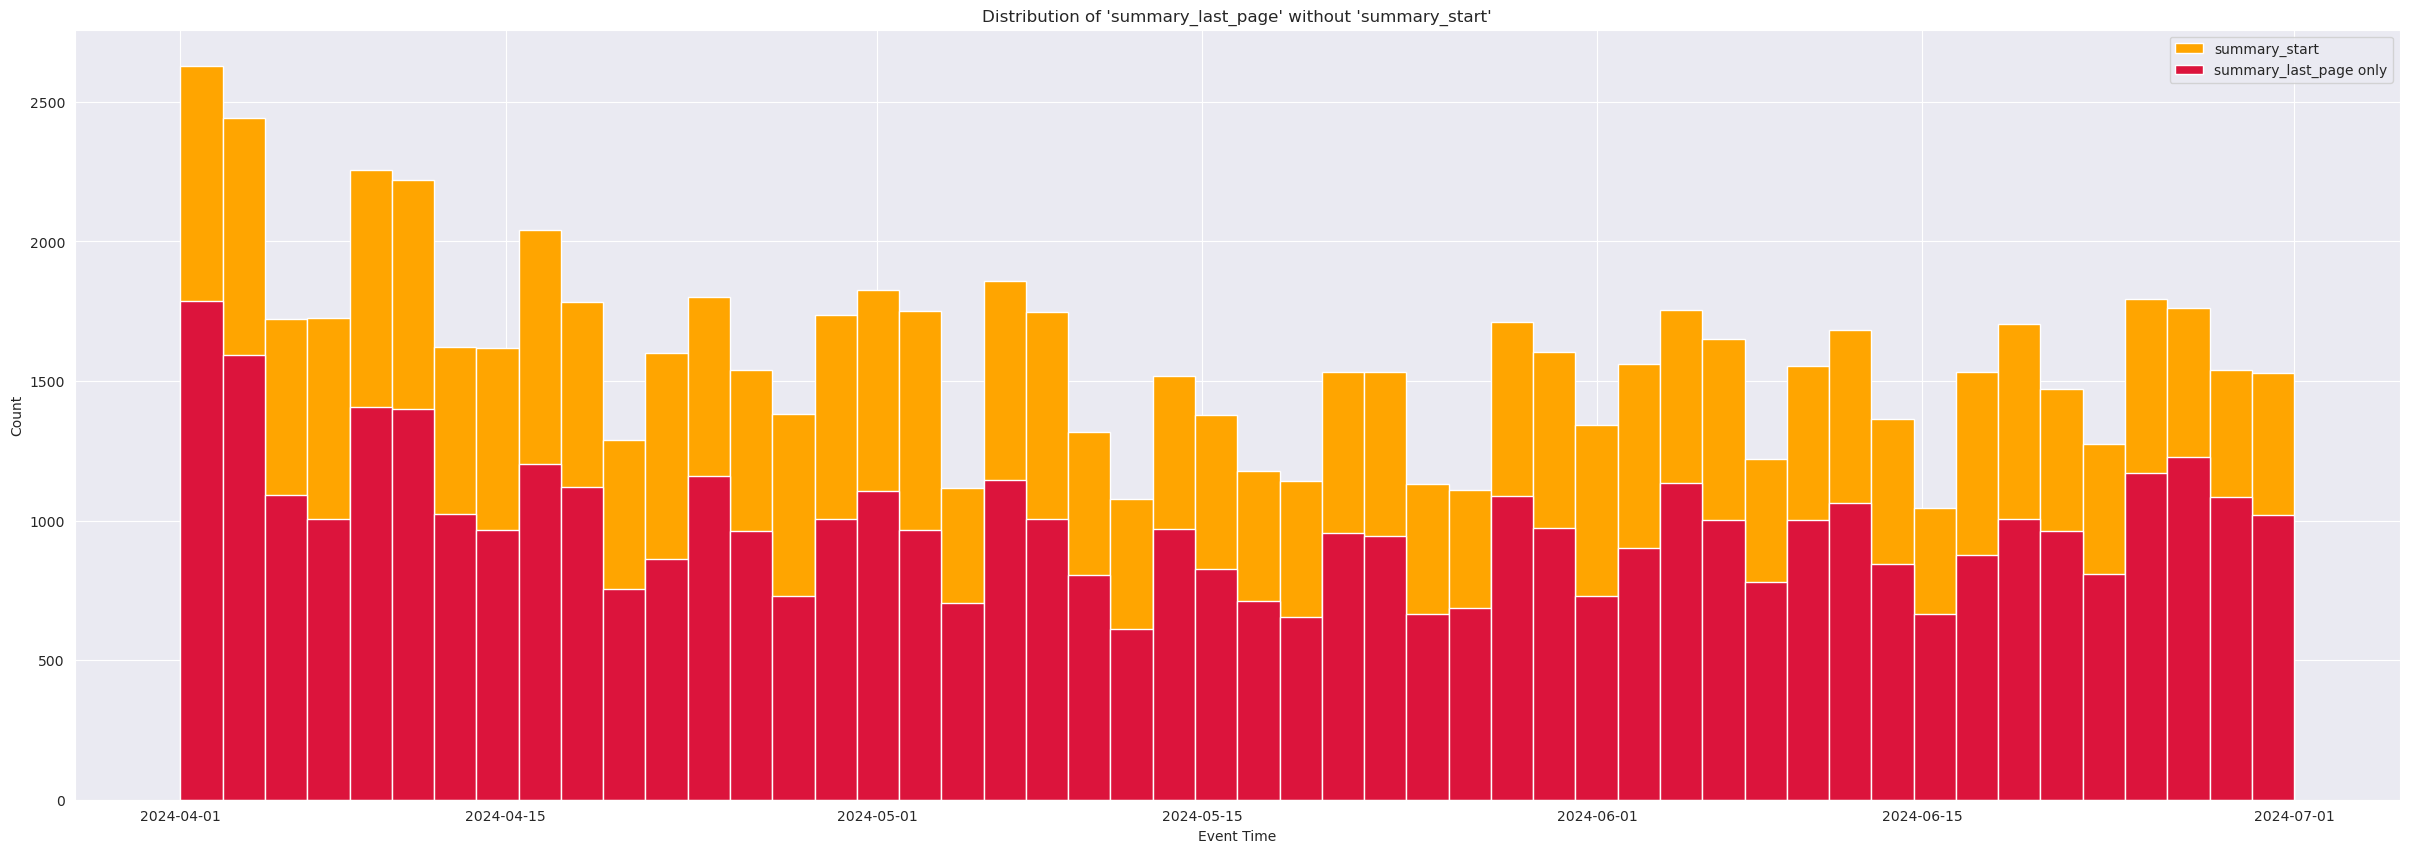

In [74]:
analyze_book_completion(users_without_age_changes)

By most parameters, it coincides with the general data (in percentage terms). But there is a much lower level of summary reading, which may be due to the overall lower activity of such users, as described above

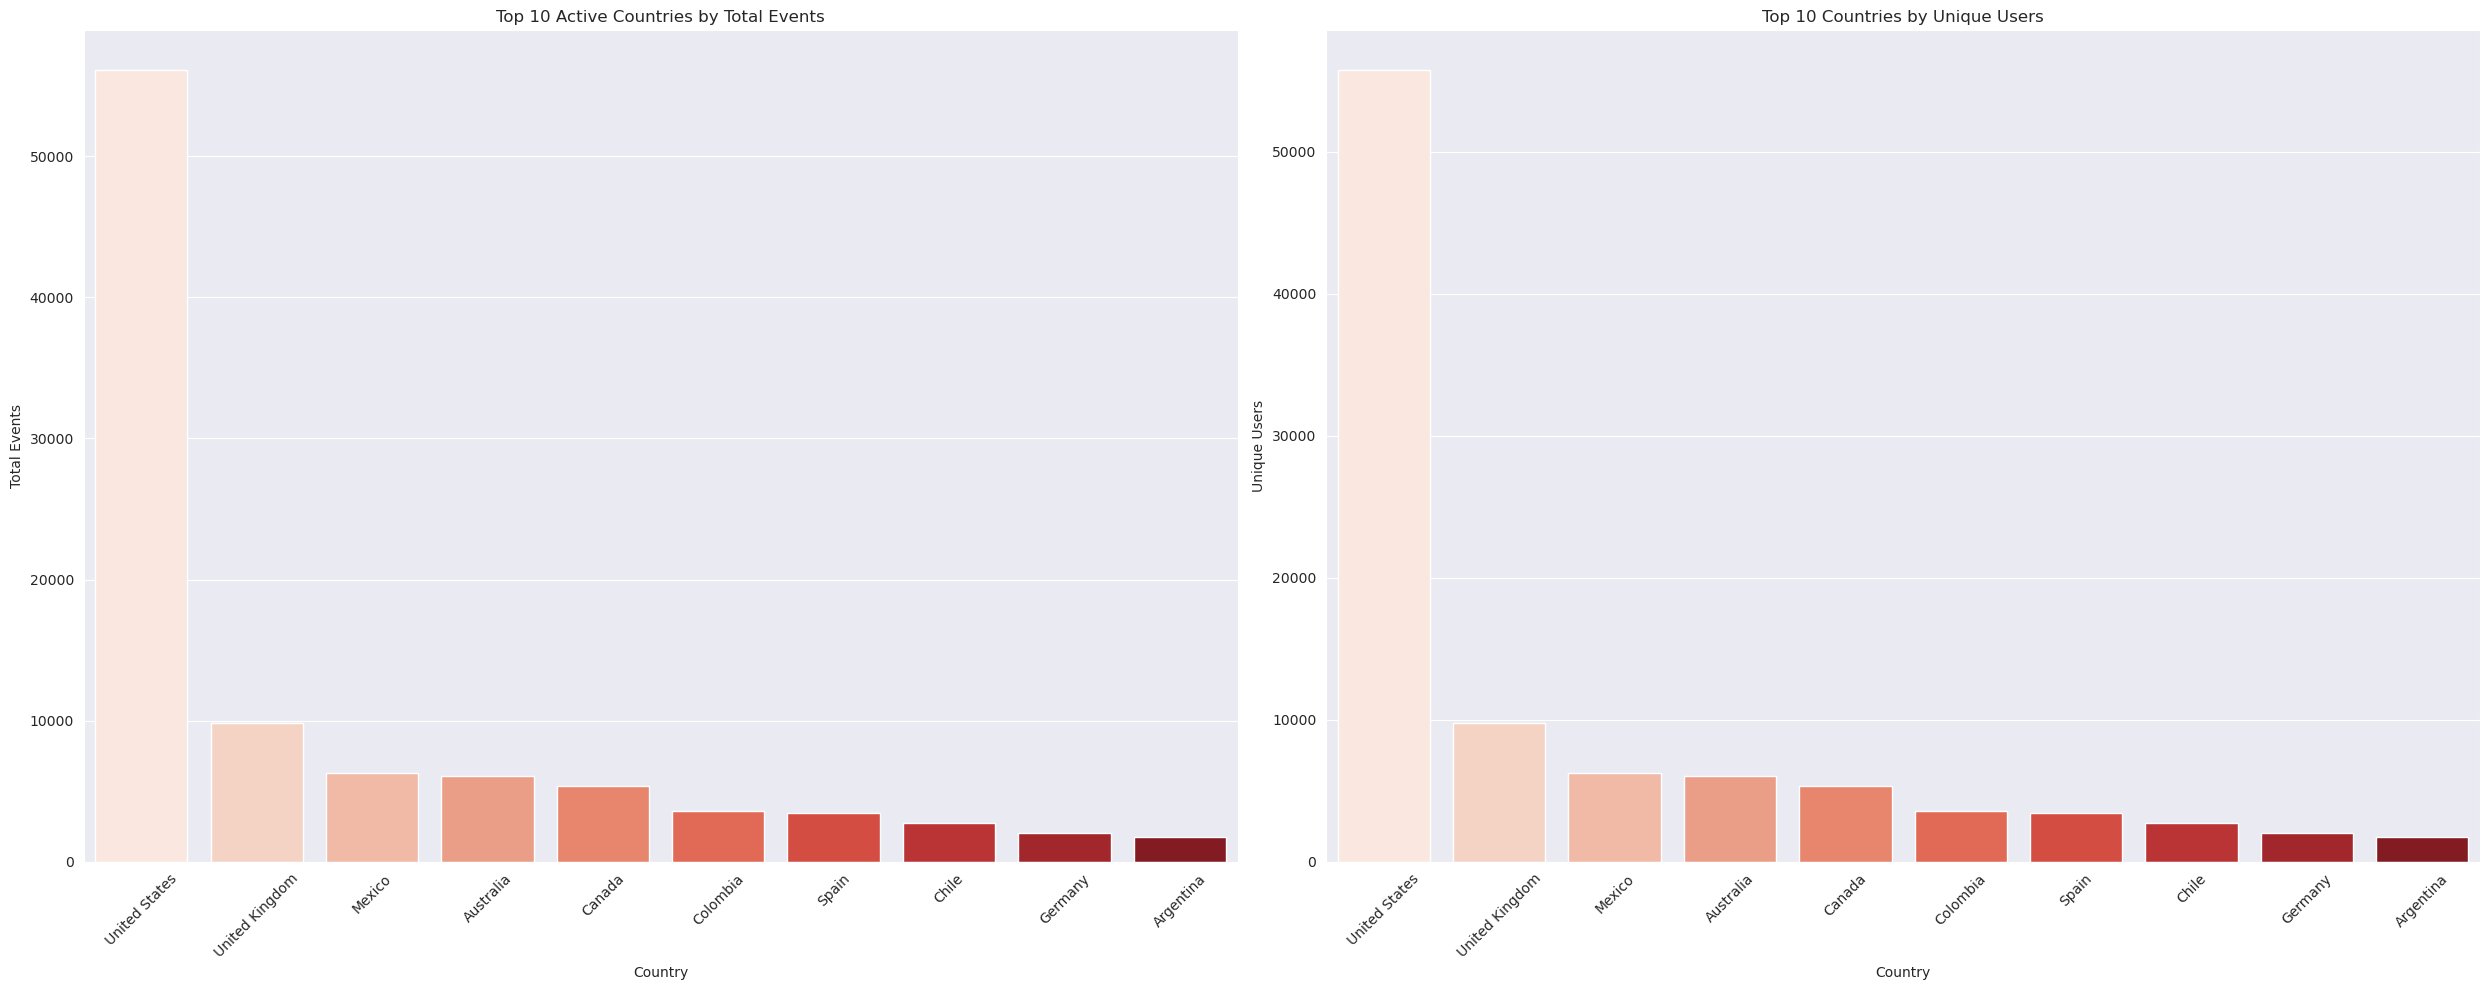

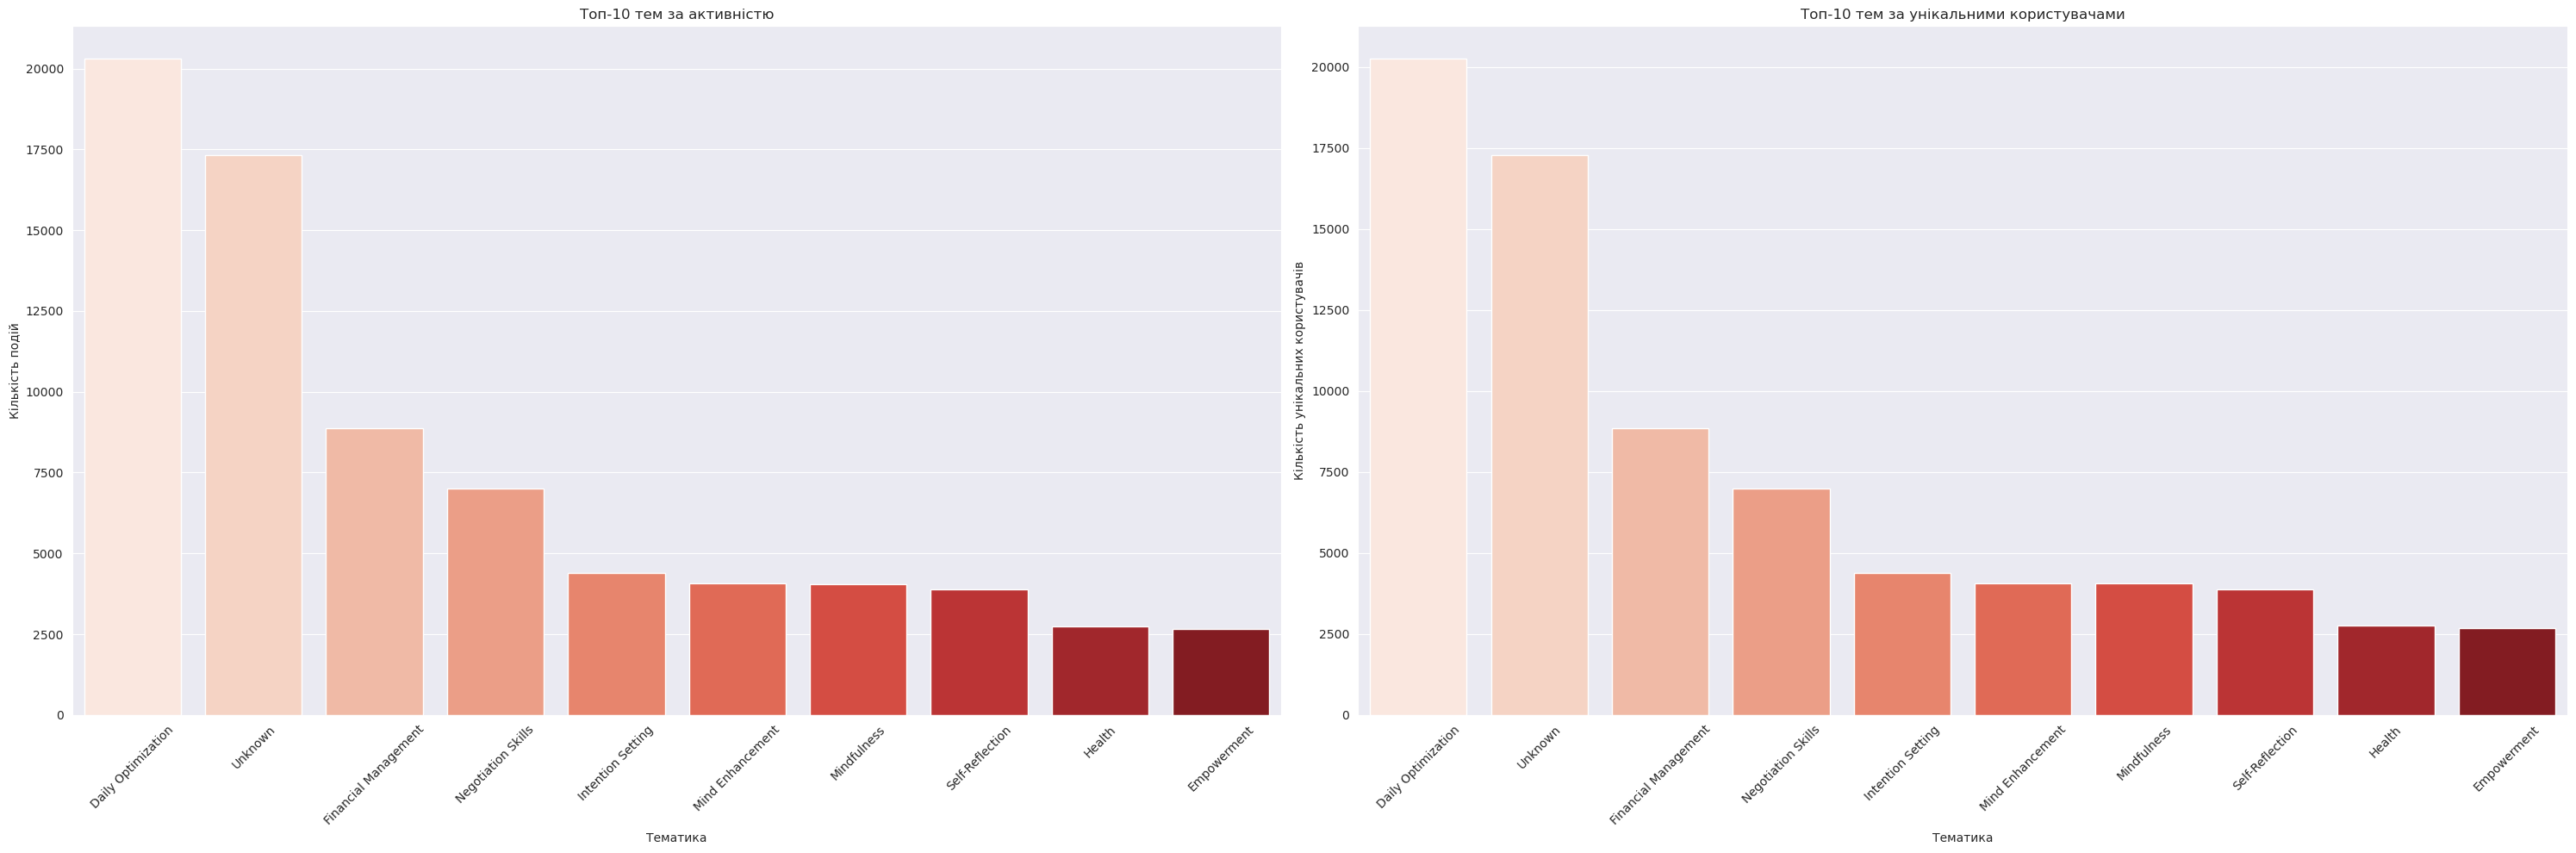

In [75]:
plot_country_activity(users_without_age_changes)
plot_topic_distribution(users_without_age_changes)

Very similar po th whole data

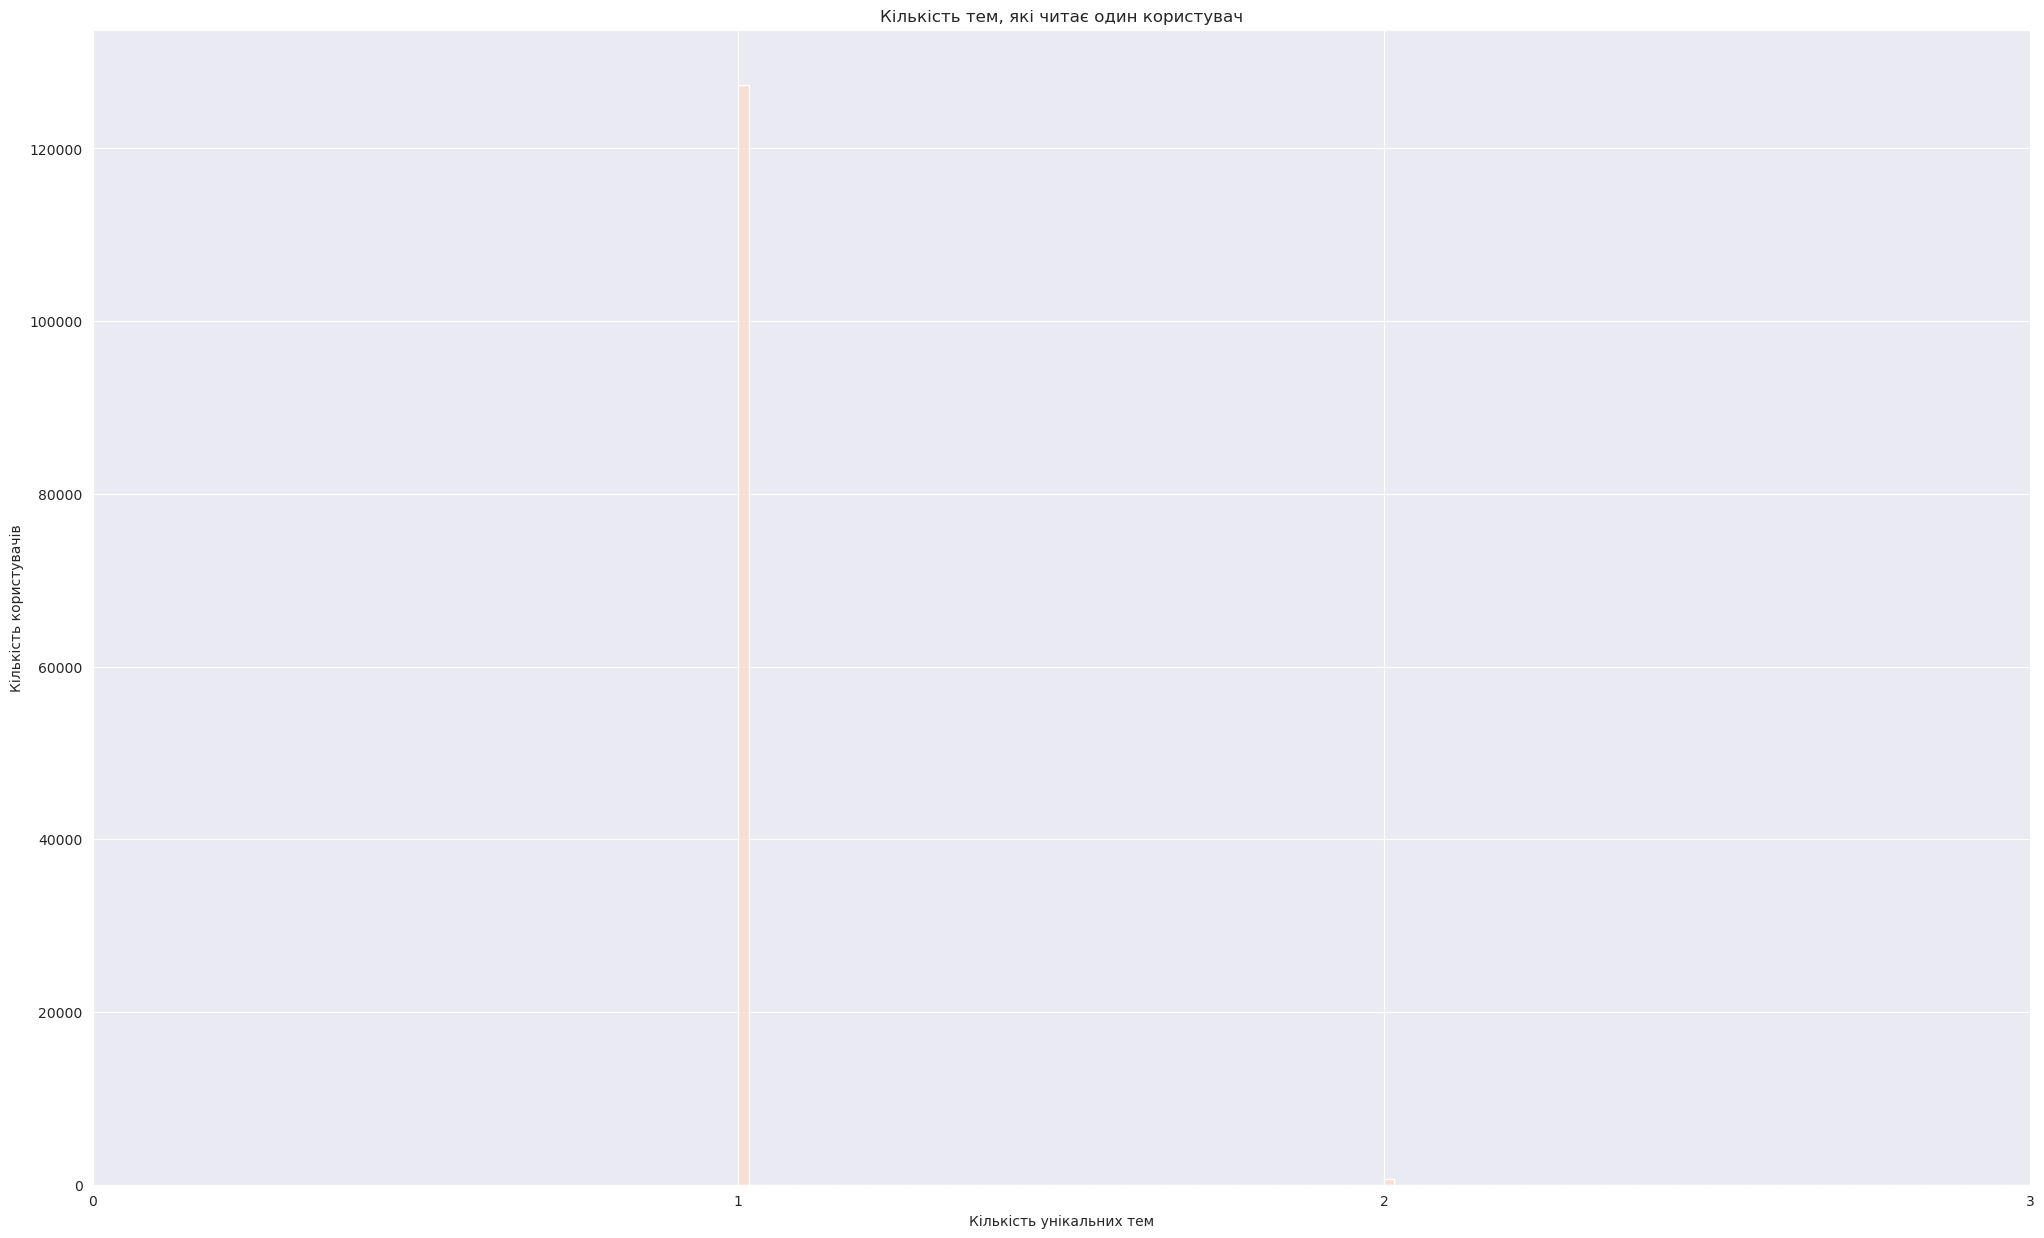

In [76]:
topic_number_by_user(users_without_age_changes, 3)

Almost all users choose only one topic, which can be easily explained by the low activity (they read no more than one summary in total)

##### Hours Activity Time differences between reading summary

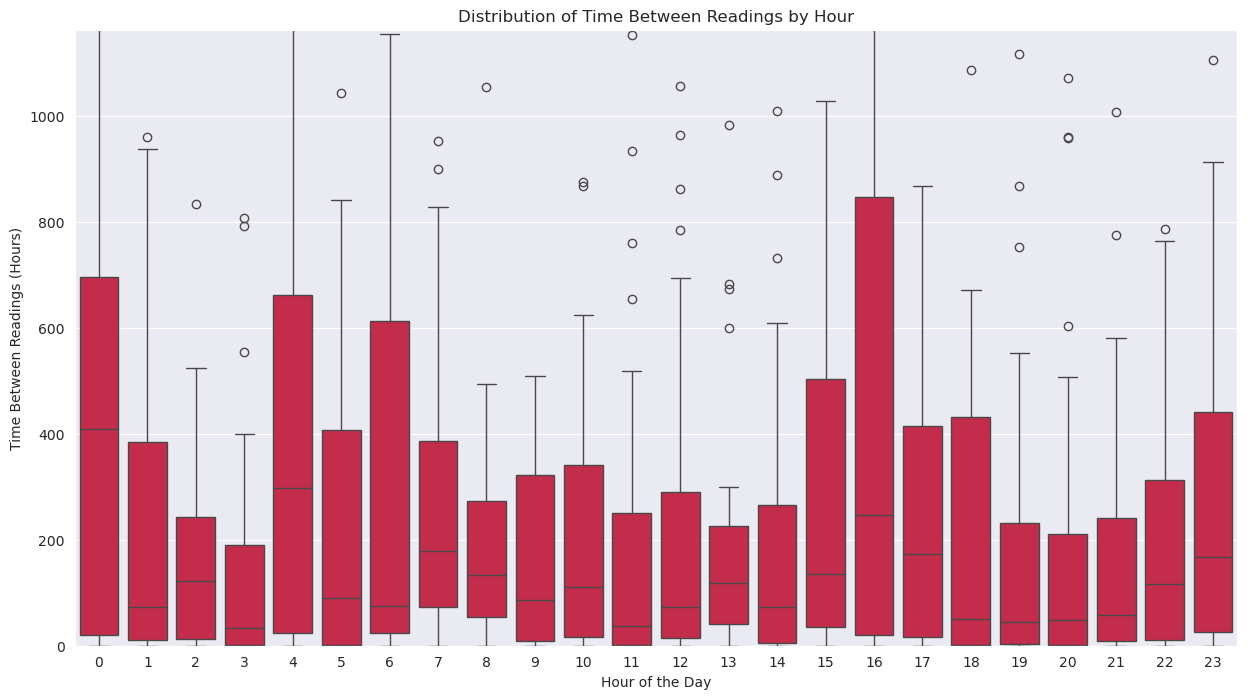

In [77]:
df_copy1, user_daily_reads1 = prepare_user_reading_data(users_without_age_changes)
plot_time_diff_by_hour(df_copy1)

time between readings disributed so randomly

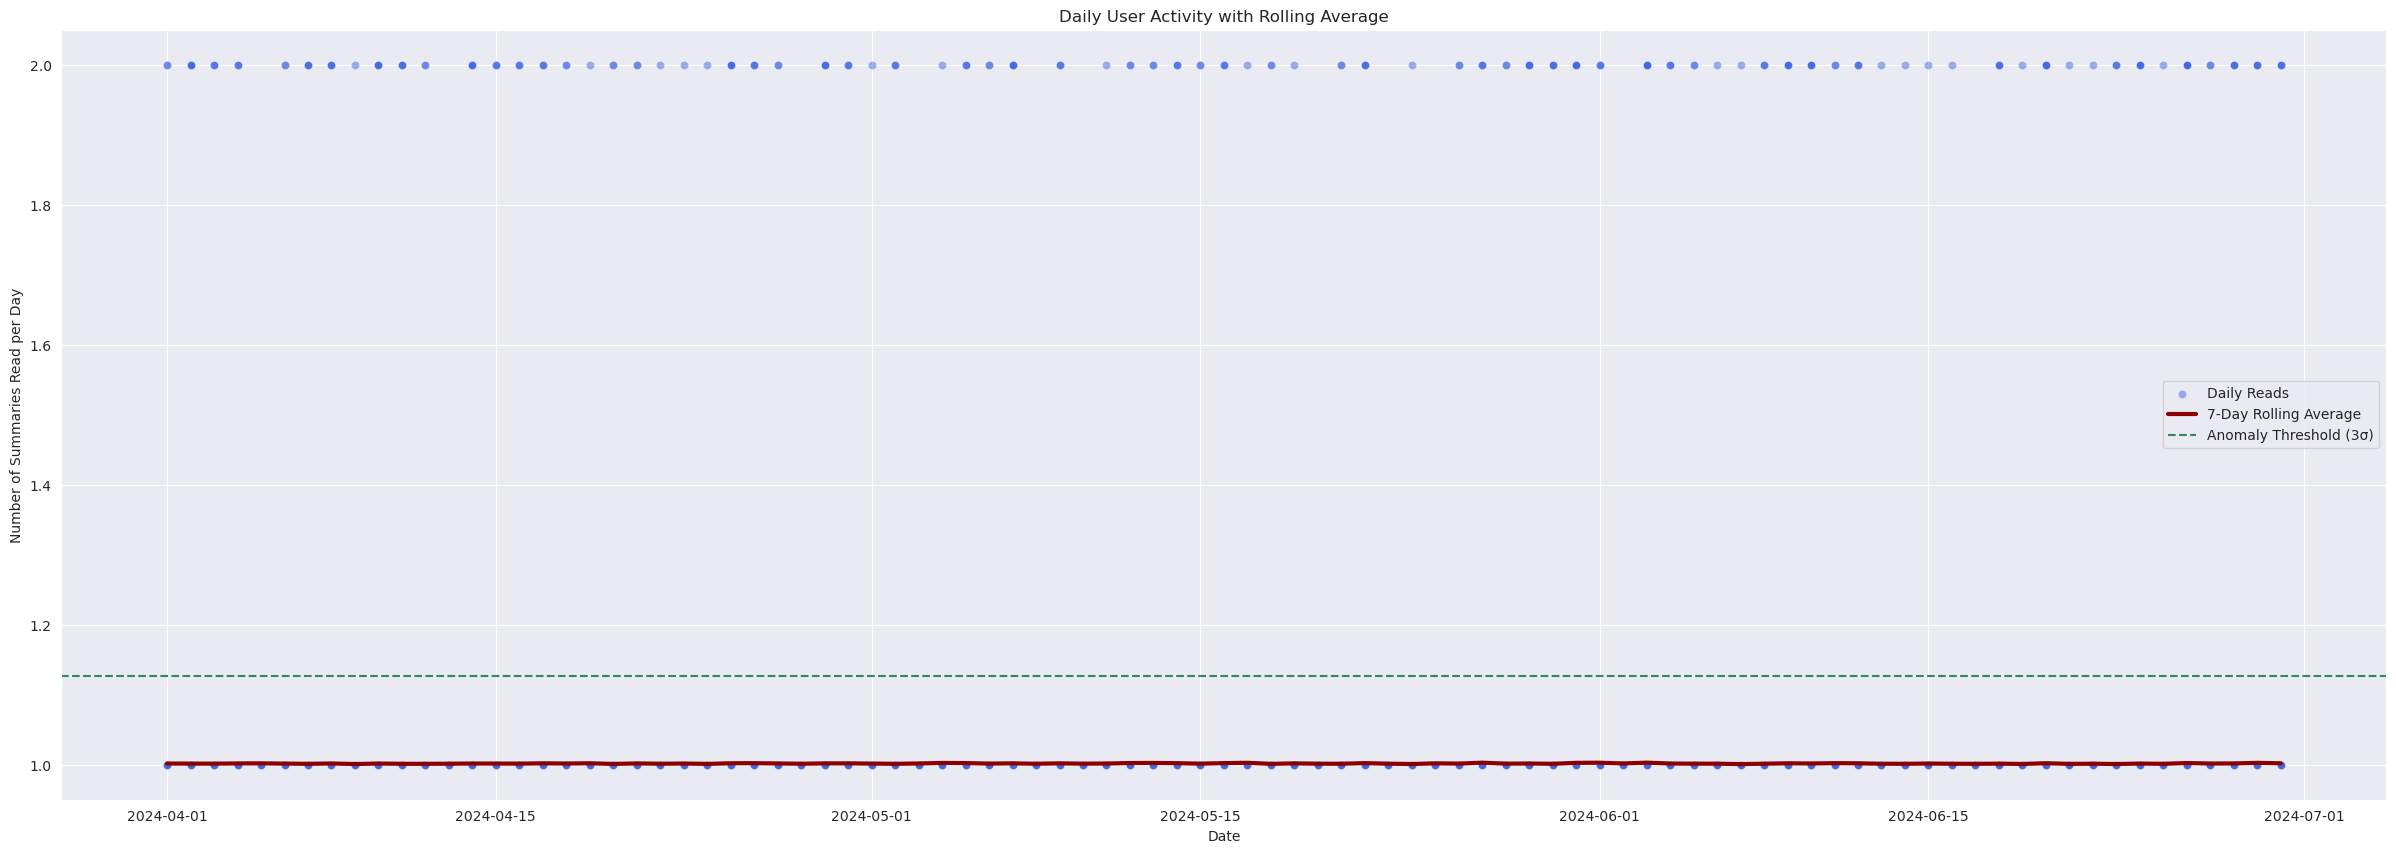

In [78]:
plot_user_activity(user_daily_reads1)

Again because low activity

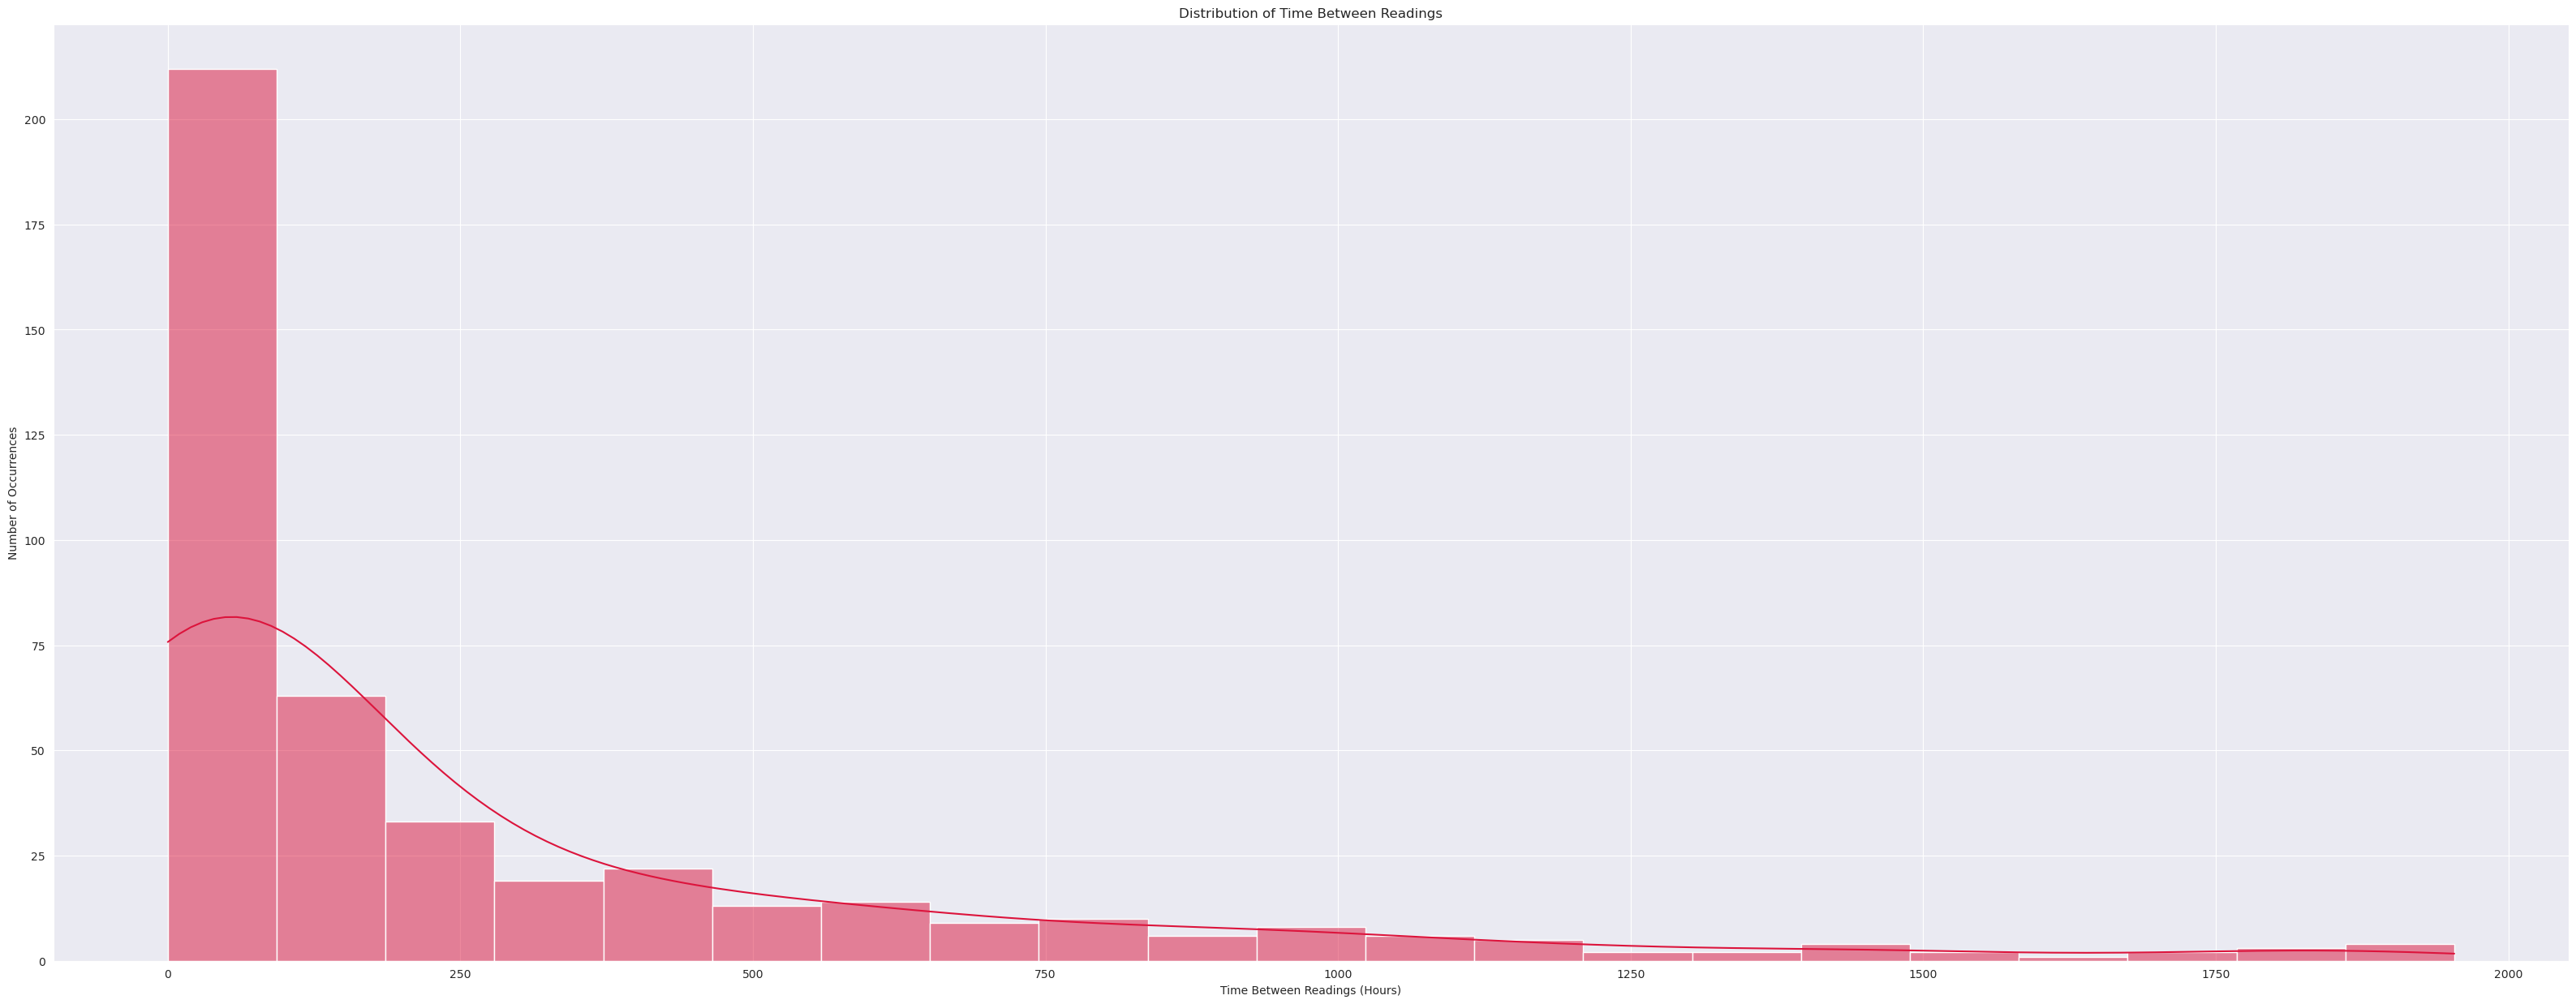

In [79]:
plot_time_diff_distribution(users_without_age_changes)

Very similar to general data

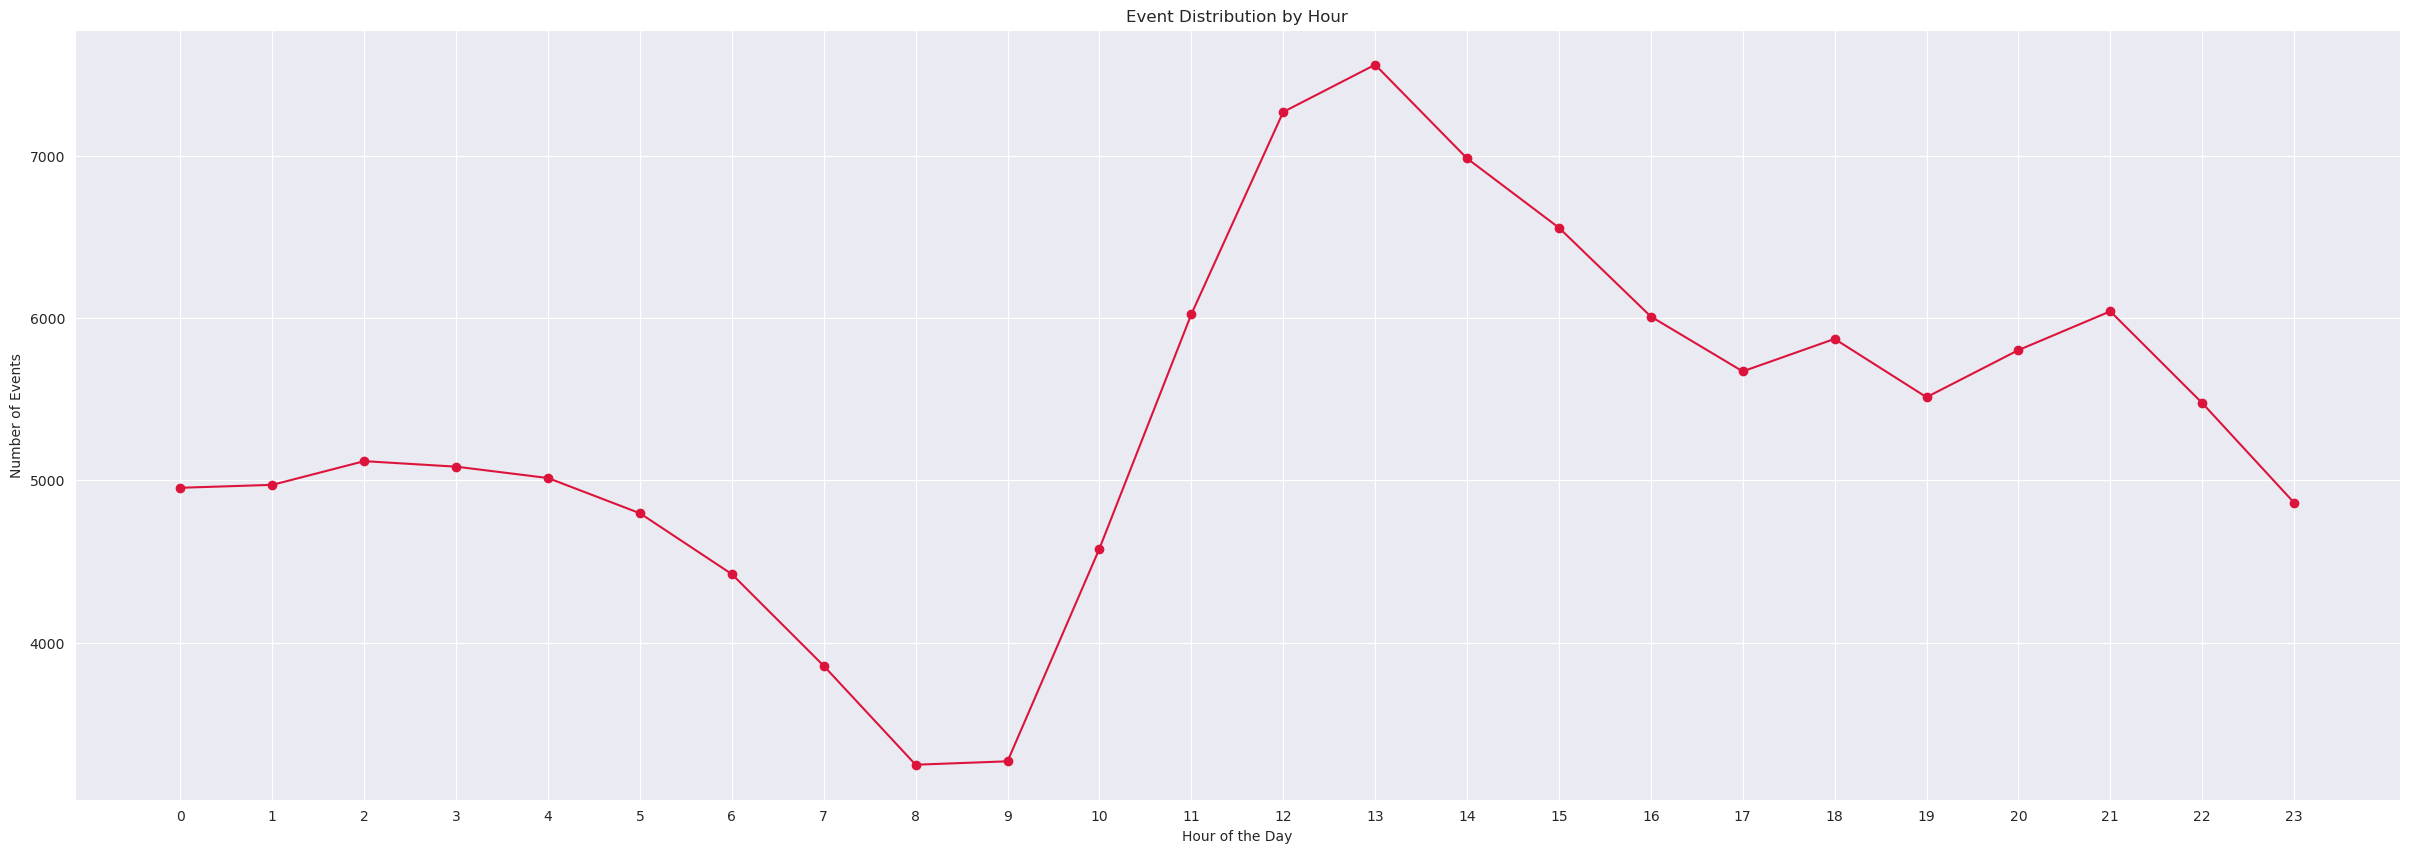

In [80]:
plot_event_distribution_by_hour(users_without_age_changes)

Very similar to general data

##### Activity Drop

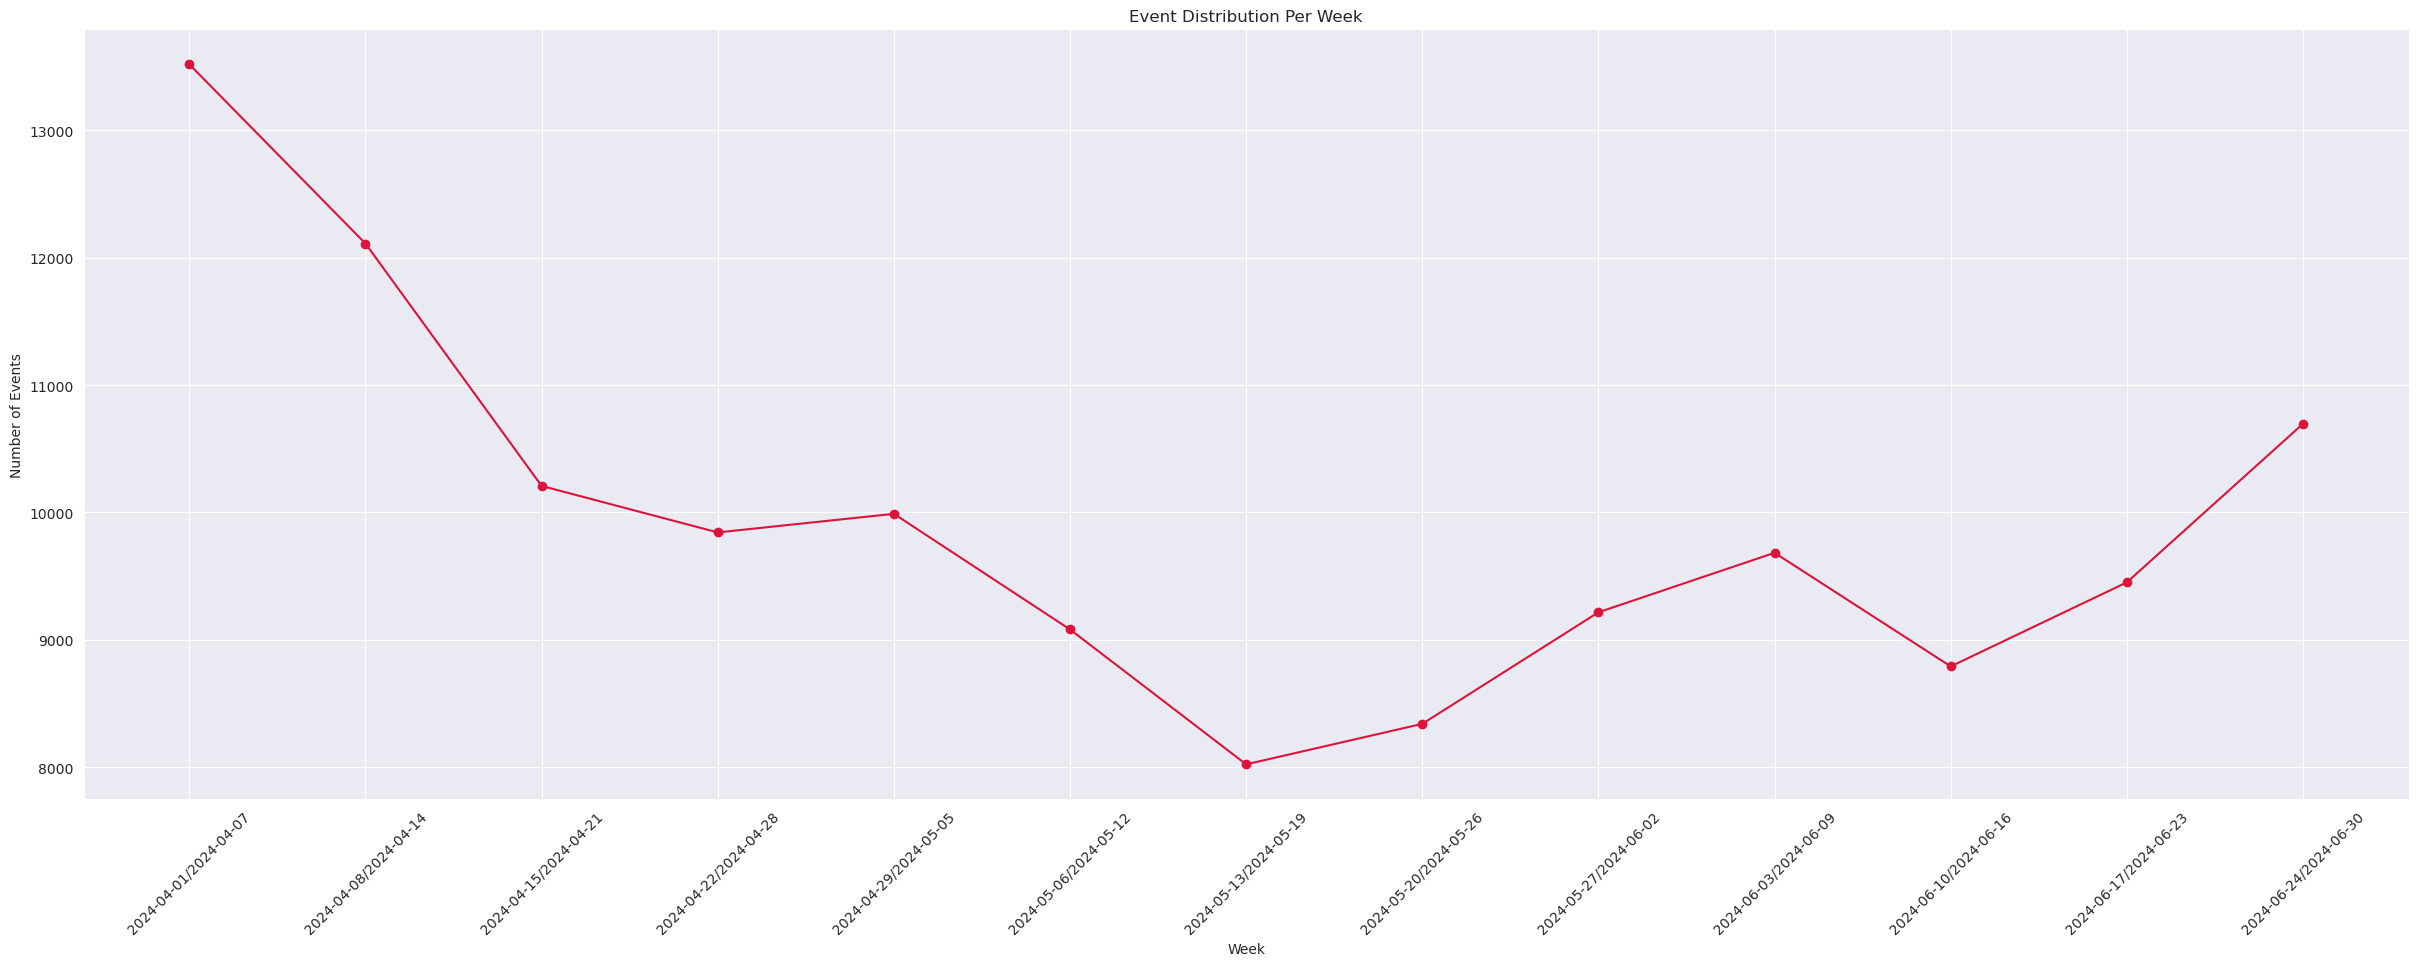

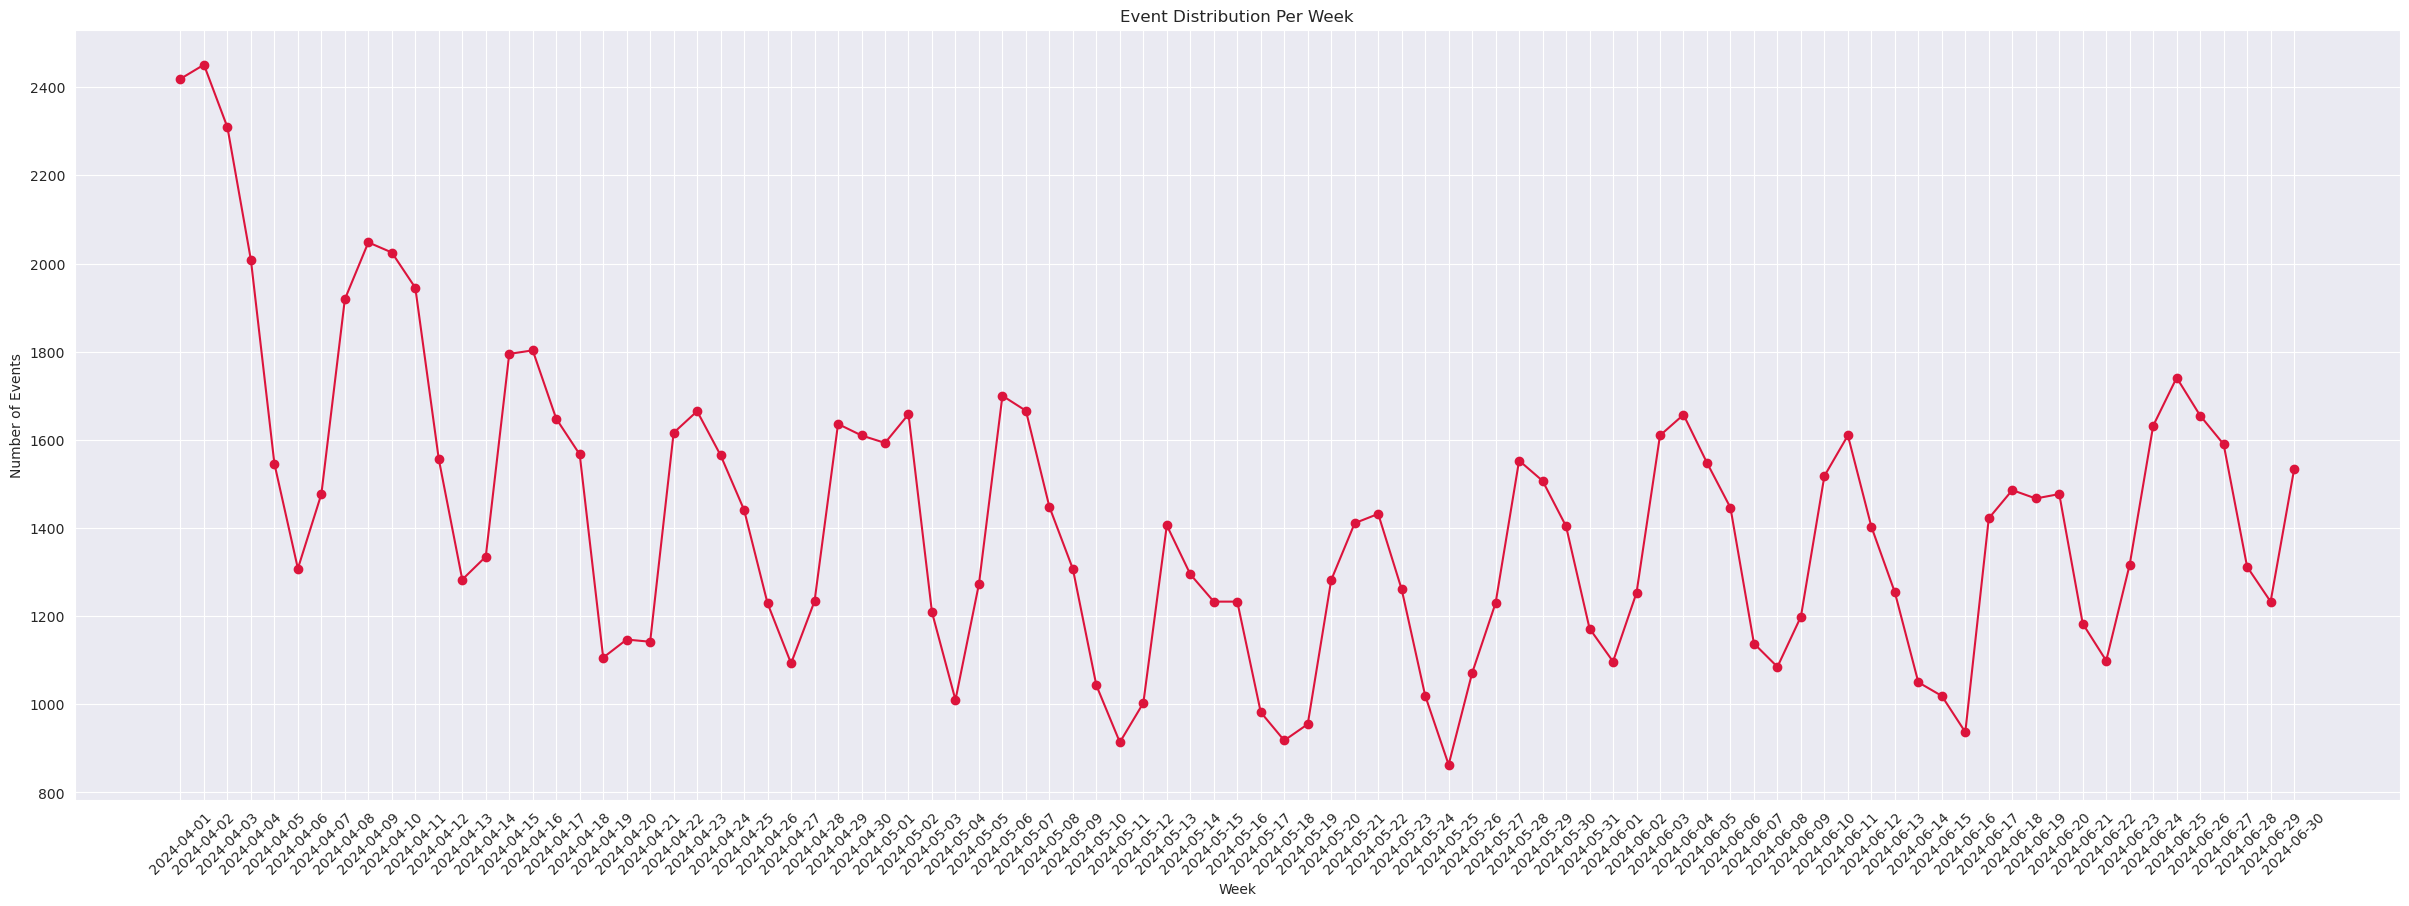

In [81]:
event_per_week(users_without_age_changes)
event_per_day(users_without_age_changes)

Same as for general

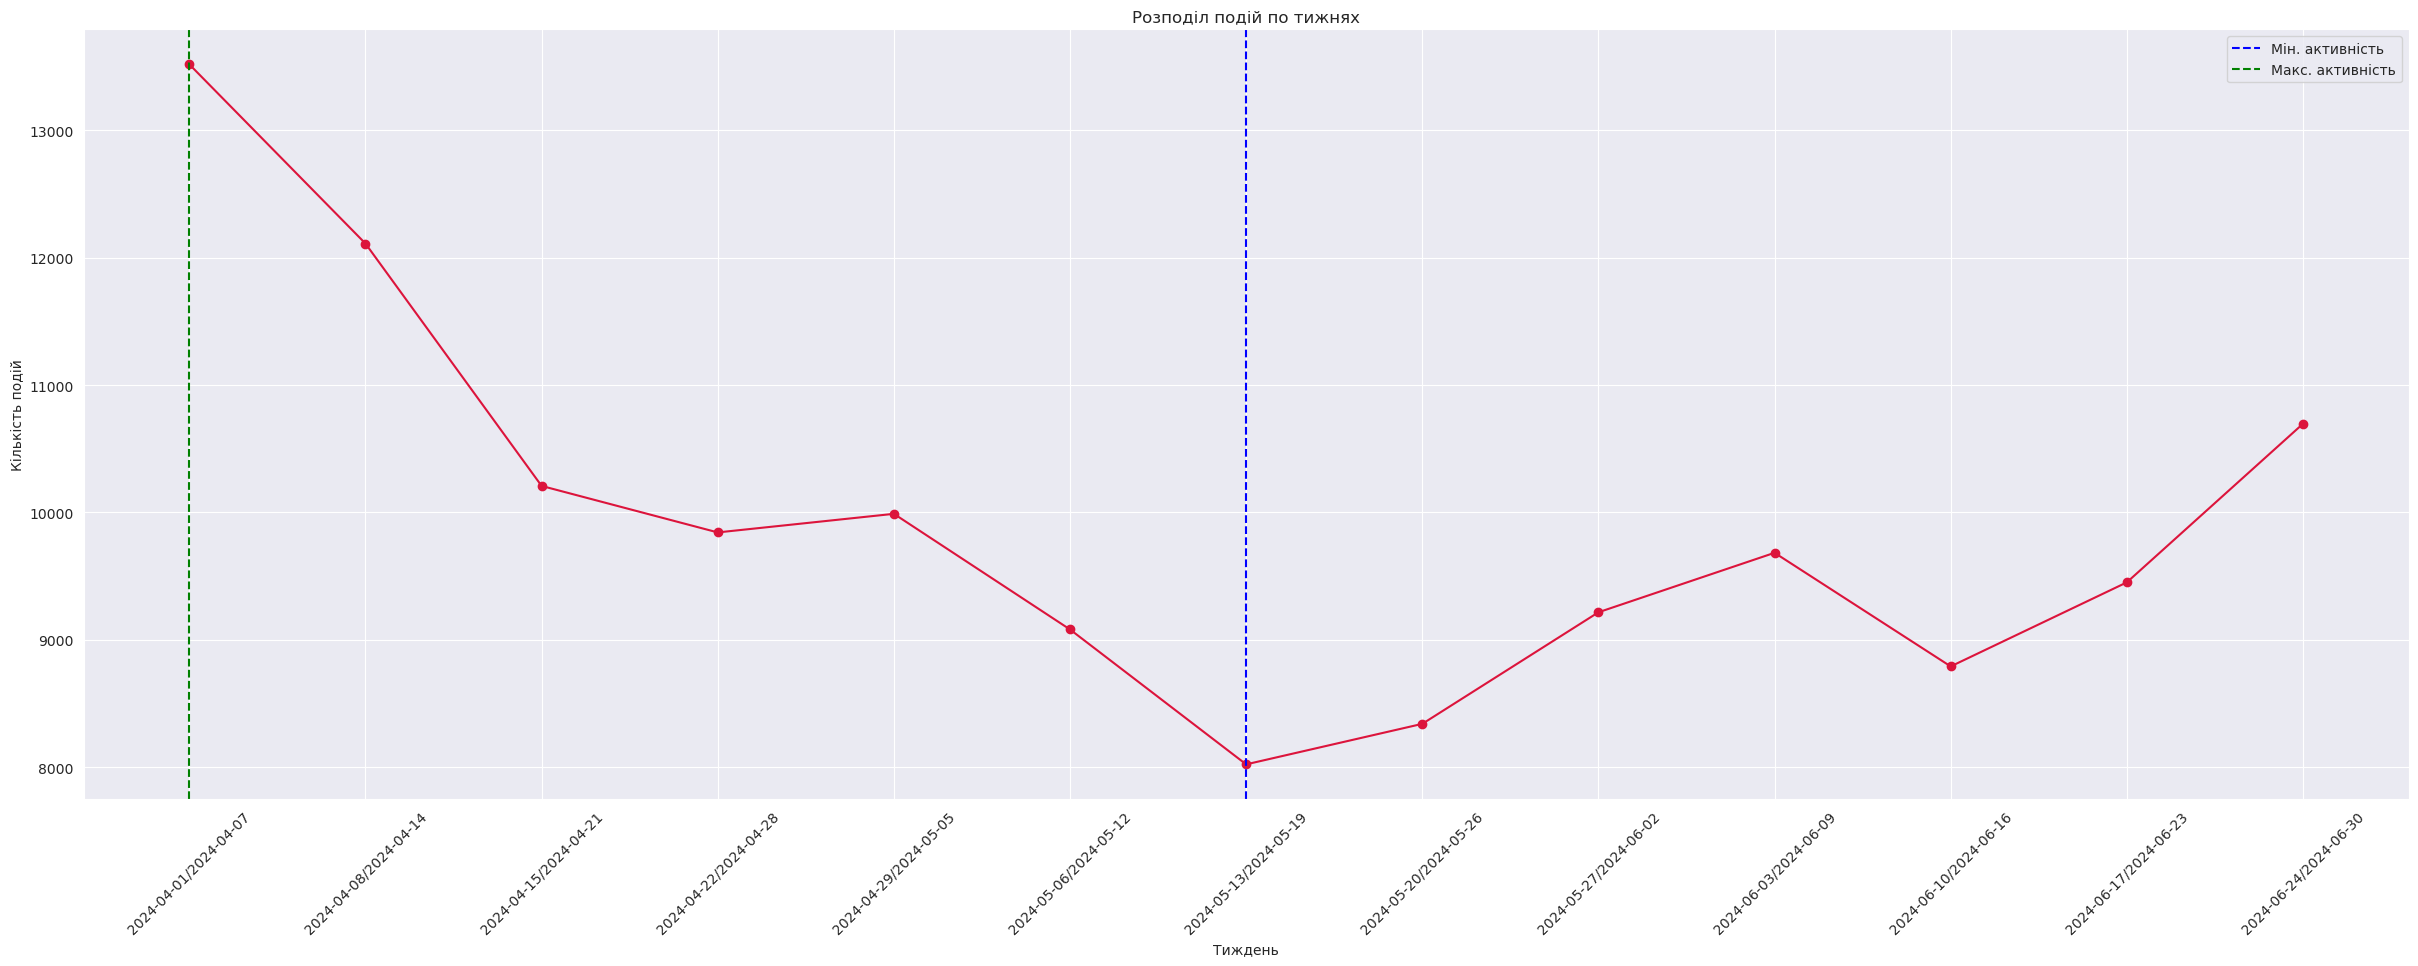

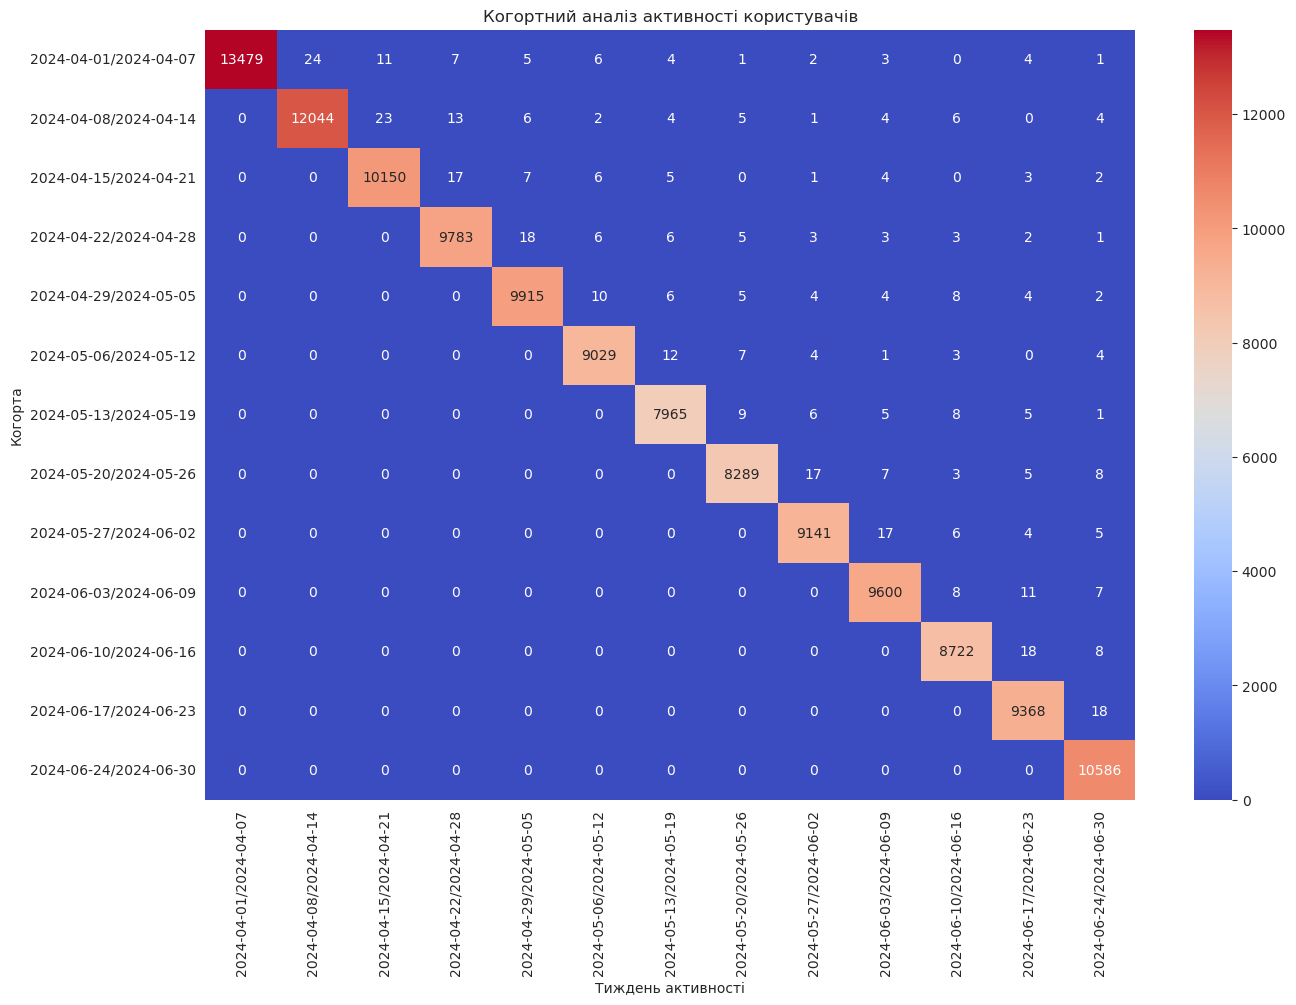

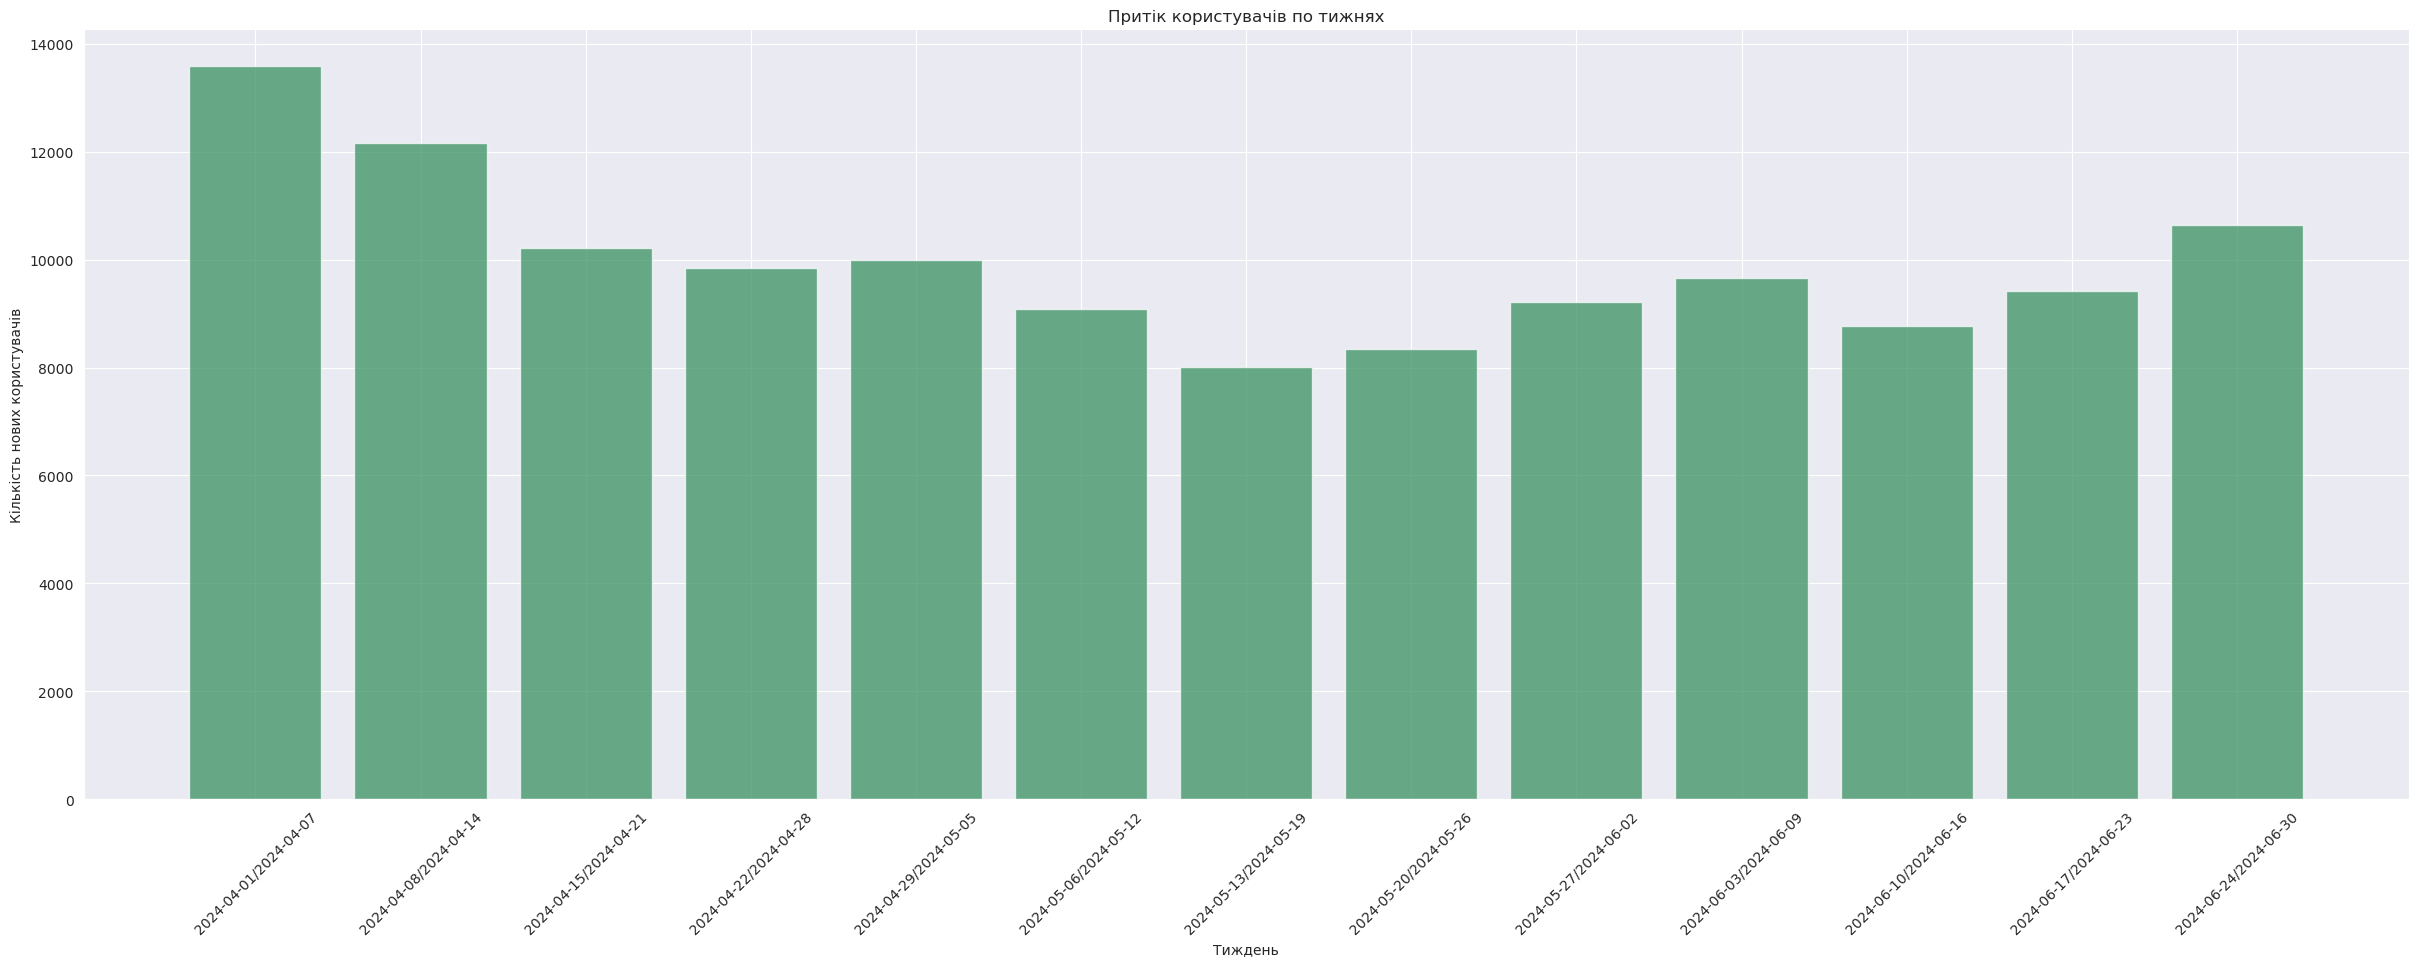

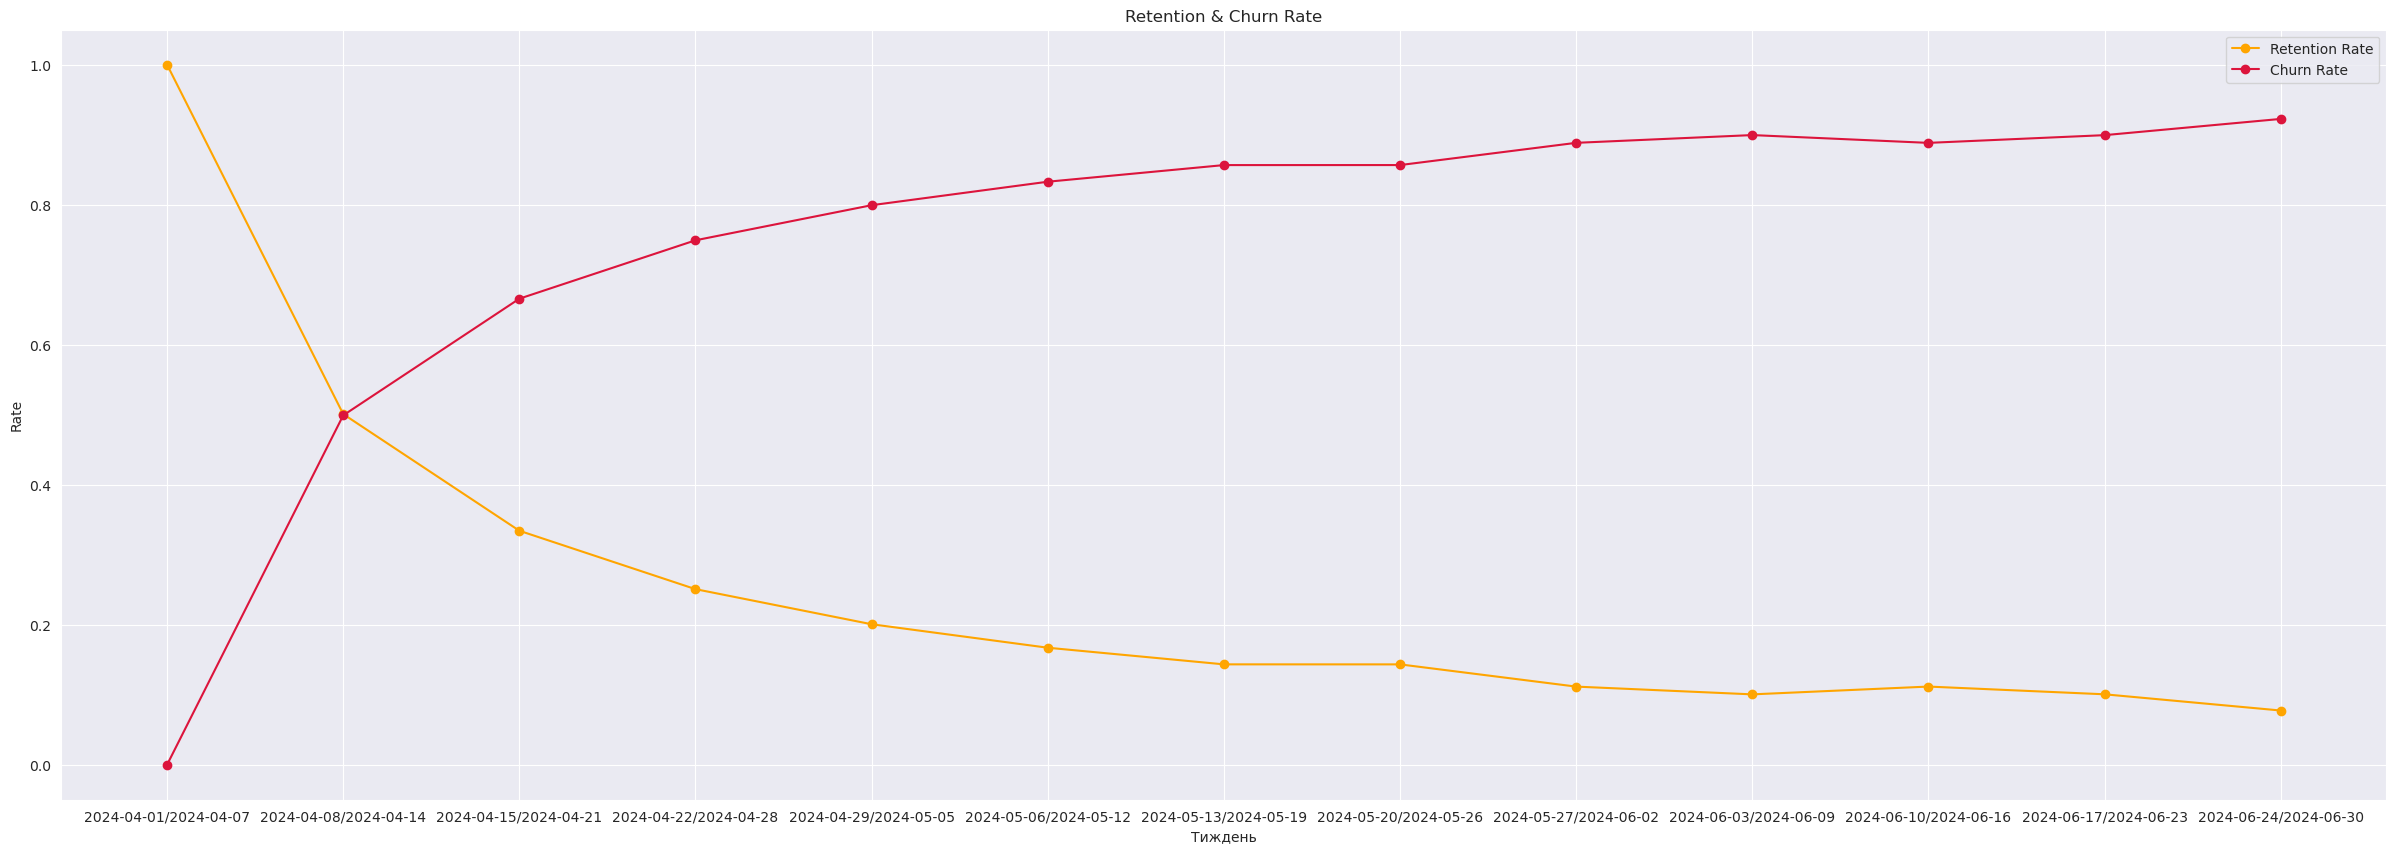

In [82]:
analyze_activity_drop(users_without_age_changes)
acquisition_analysis(users_without_age_changes)
calculate_churn_and_retention(users_without_age_changes)

The only difference from the general data is a faster and bigger outflow of clients, which is a consequence of generally low activity in this group

##### Seasonality check

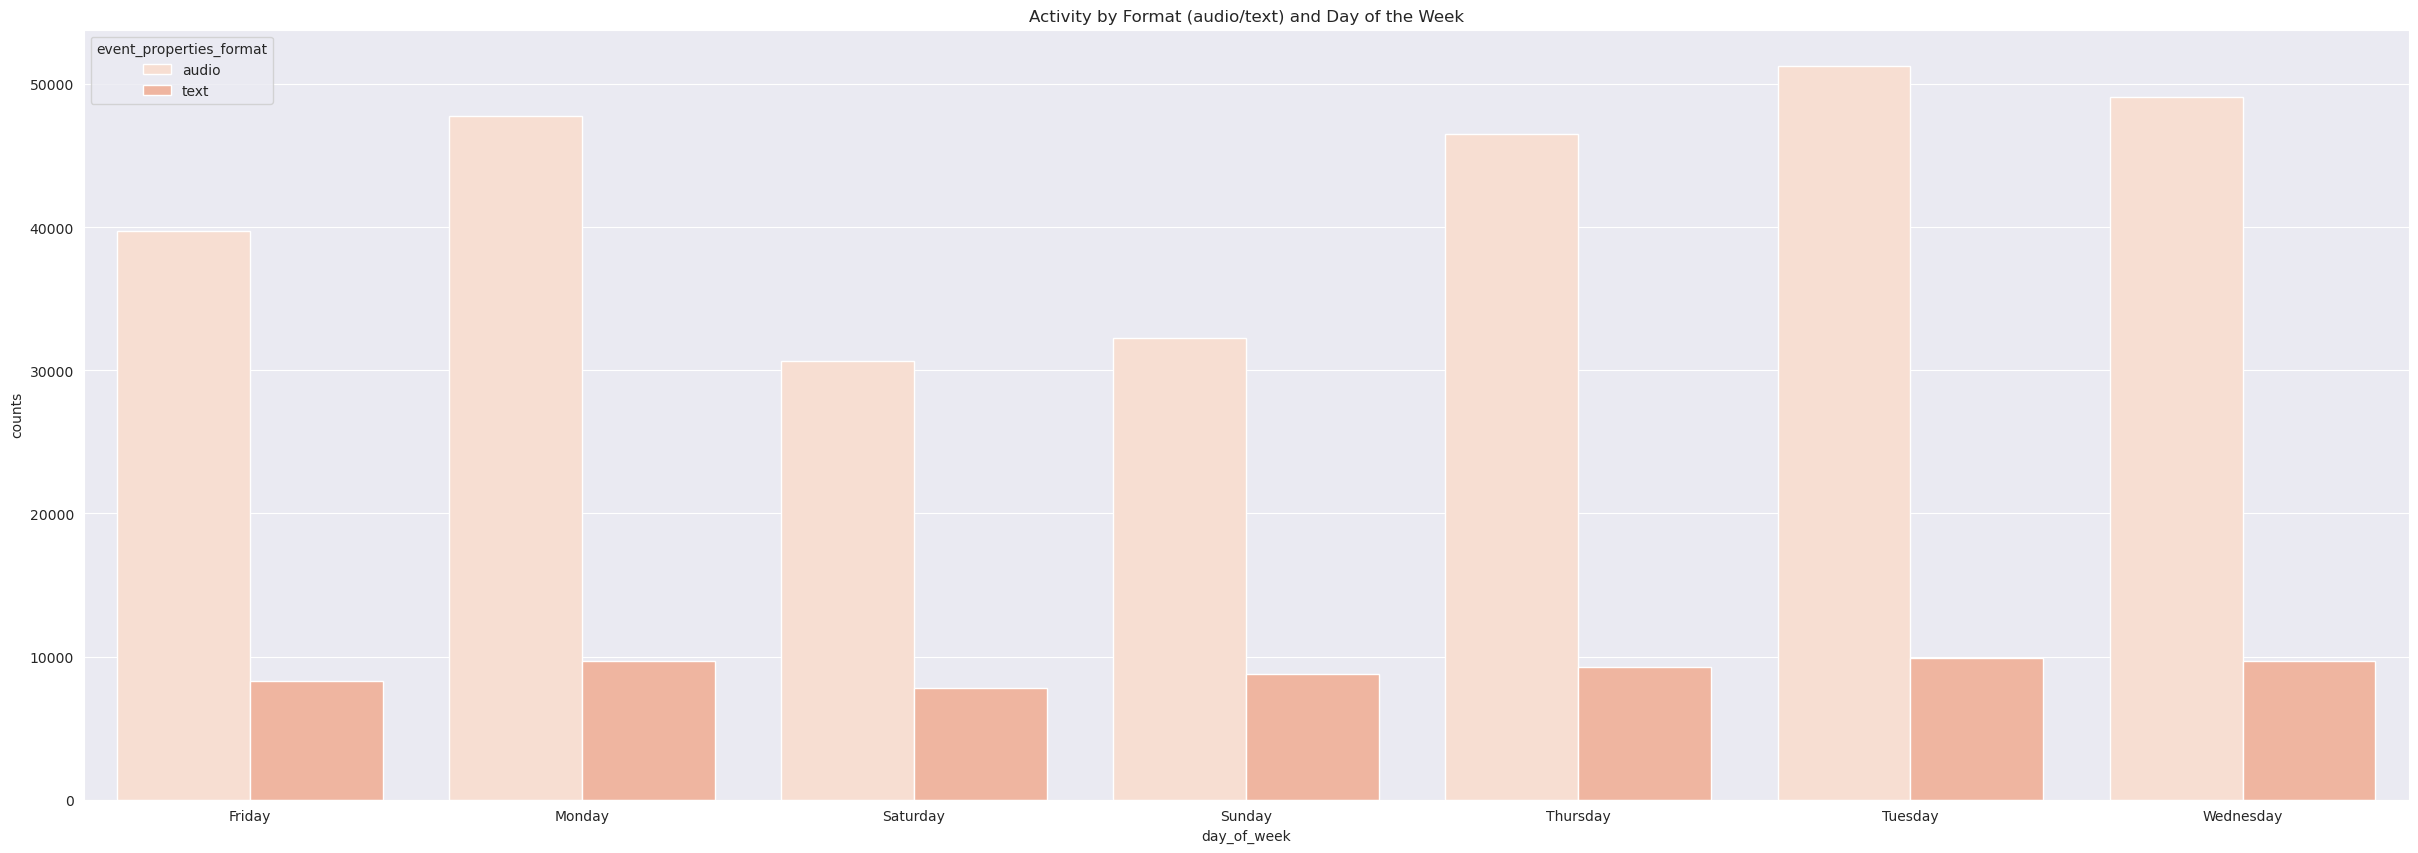

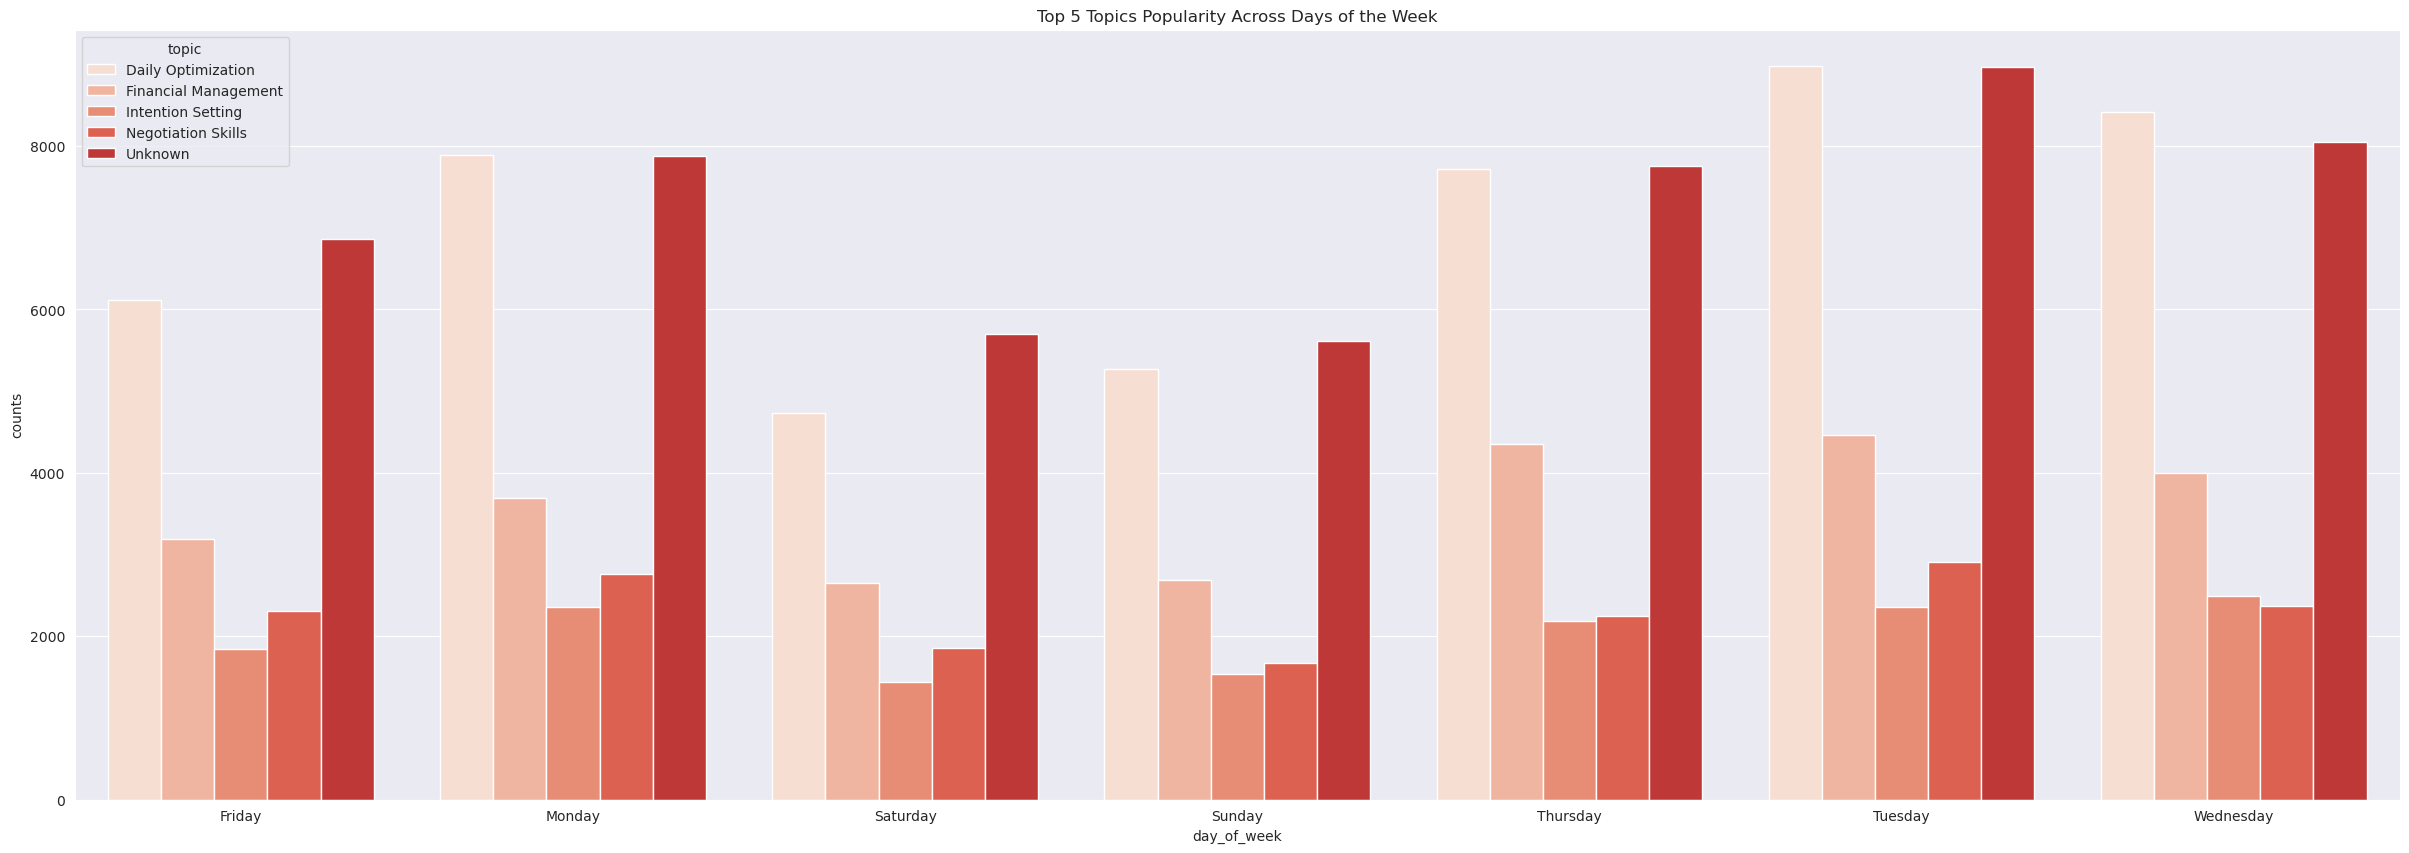

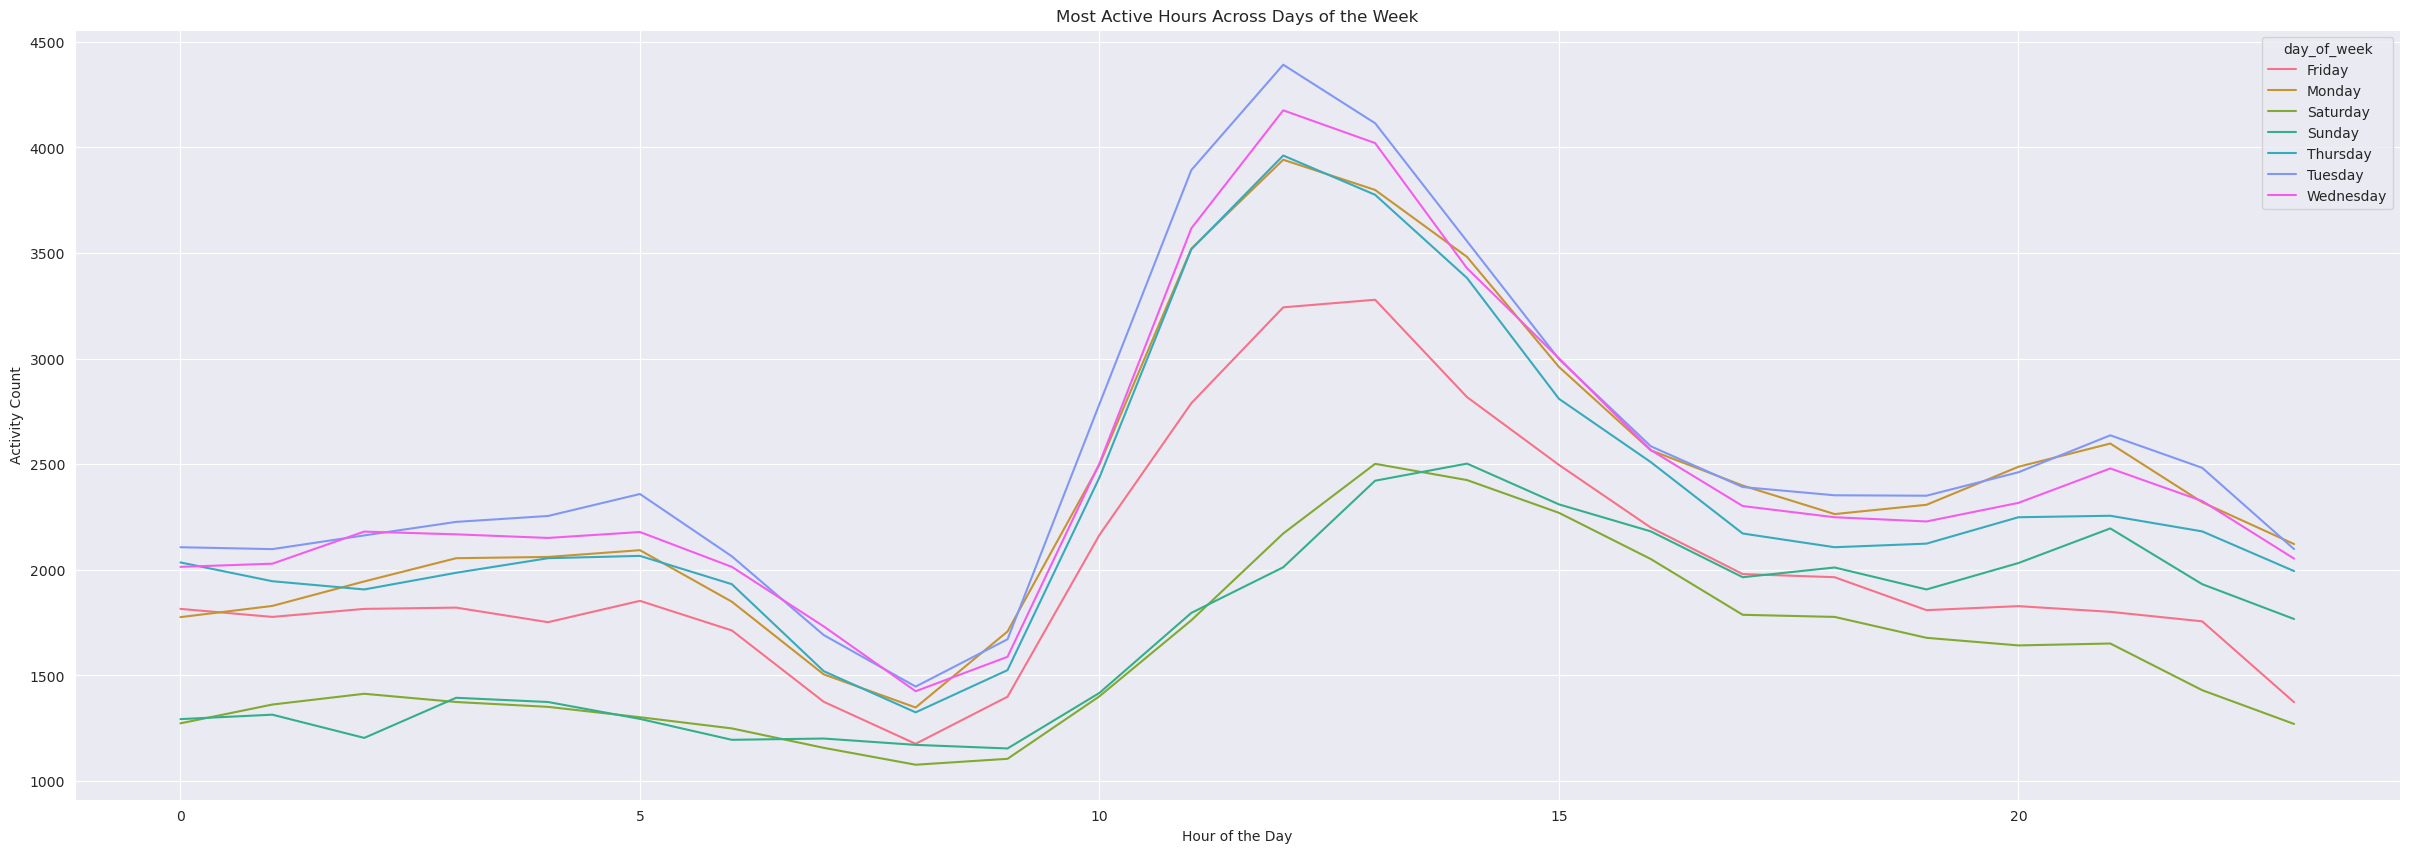

In [83]:
ses_3 = sesonal_prepare(users_with_age_changes)

plot_activity_by_format(ses_3)
plot_topic_popularity(ses_3)
plot_peak_hours(ses_3)

### Conclusions for Analysis

The analysis showed that the most popular content format is audio, which should be taken into account when building a recommendation system. The main markets for the app are the United States and English- and Spanish-speaking countries, so optimizing content for these regions can improve overall engagement.

Low Stickiness Ratio and Completion Rate indicate a high churn rate and lack of user engagement. Particular attention should be paid to the group of users who are changing their age - they demonstrate higher engagement and probably need a different approach to recommendations.

##### How insights and recommendations can help improve user experience

1. **Personalize content:** Prioritizing audio format and relevant topics will help increase user satisfaction.
2. Reduce churn:** Understanding the reasons for low Stickiness Ratio and Completion Rate will help you create more effective recommendations and improve engagement.
3. Targeting key markets:** Optimizing content for English-speaking users will improve their experience and increase engagement.
4. Flexibility of the recommendation system:** Using a content-based approach and a hybrid method will provide a baseline performance that can be gradually improved.

Translated with DeepL.com (free version)